In [ ]:
!pip install yfinance --upgrade
!pip install stockstats --upgrade
!pip install keras --upgrade
!pip install tensorflow --upgrade
!pip install --upgrade protobuf

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from stockstats import StockDataFrame as sdf

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from keras import models, layers, applications, optimizers, regularizers, constraints
from keras.initializers import glorot_normal
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping

In [2]:
np.random.seed(1)
tf.random.set_seed(2)

In [3]:
def is_third_friday(s):
    d = datetime.strptime(s, '%Y-%m-%d')
    return d.weekday() == 4 and 15 <= d.day <= 21

In [4]:
def is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

In [5]:
tic = 'AAPL'
stock = yf.Ticker(tic)
stock_df = yf.download(tic, start='1999-08-11', end='2021-08-12')
data_df = pd.DataFrame().append(stock_df)
    
# reset the index, we want to use numbers as index instead of dates
data_df = data_df.reset_index()

# convert the column names to standardized names
data_df.columns = ["date", "open", "high", "low", "close", "adjcp", "volume"]

[*********************100%***********************]  1 of 1 completed


In [6]:
# use adjusted close price instead of close price
#data_df["close"] = data_df["adjcp"]
#data_df = data_df.drop("adjcp", 1)

# convert date to standard string format, easy to filter
data_df["year"] = data_df.date.dt.year
data_df["dayofyear"] = data_df.date.dt.dayofyear
data_df["dayofweek"] = data_df.date.dt.dayofweek + 1
data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))

#for date normalization
data_df['dayofyear_sin'] = 0.01
data_df['dayofyear_cos'] = 0.01
data_df['dayofweek_sin'] = 0.01
data_df['dayofweek_cos'] = 0.01

# drop missing data
data_df = data_df.dropna()
data_df = data_df.sort_values(by=['date']).reset_index(drop=True)
stock = sdf.retype(data_df.copy())

In [7]:
for ind in ['close_-1_r', 'volume_20_sma', 'atr', 'close_20_ema', 'close_50_ema', 'close_100_ema', 'rsi_14']:
    temp_ind = pd.DataFrame(stock[ind])
    #data_df[ind] = temp_ind
    
    data_df = data_df.merge(temp_ind,on='date',how='left')

#data_df
data_df = data_df.sort_values(by=['date'])

#take slice of 100 onwards
data_df = data_df[100:]

#add new attributes
data_df['volume_delta'] = 0.0
data_df['close_20_ema_delta'] = 0.0
data_df['close_50_ema_delta'] = 0.0
data_df['close_100_ema_delta'] = 0.0
data_df['option_expiry'] = '2999-12-31'
data_df['floor_held'] = 0

data_df.drop(labels=['open','high', 'low', 'adjcp'], axis=1, inplace=True)
data_df

date       close     volume  year  dayofyear  dayofweek  \
100   2000-01-03    0.999442  535796800  2000          3          1   
101   2000-01-04    0.915179  512377600  2000          4          2   
102   2000-01-05    0.928571  778321600  2000          5          3   
103   2000-01-06    0.848214  767972800  2000          6          4   
104   2000-01-07    0.888393  460734400  2000          7          5   
...          ...         ...        ...   ...        ...        ...   
5532  2021-08-05  147.059998   46397700  2021        217          4   
5533  2021-08-06  146.139999   54067400  2021        218          5   
5534  2021-08-09  146.089996   48908700  2021        221          1   
5535  2021-08-10  145.600006   69023100  2021        222          2   
5536  2021-08-11  145.860001   48493500  2021        223          3   

      dayofyear_sin  dayofyear_cos  dayofweek_sin  dayofweek_cos  ...  \
100            0.01           0.01           0.01           0.01  ...   
101            0.01           0.01           0.01           0.01  ...   
102            0.01           0.01           0.01           0.01  ...   
103            0.01           0.01           0.01           0.01  ...   
104            0.01           0.01           0.01           0.01  ...   
...             ...            ...            ...            ...  ...   
5532           0.01           0.01           0.01           0.01  ...   
5533           0.01           0.01           0.01           0.01  ...   
5534           0.01           0.01           0.01           0.01  ...   
5535           0.01           0.01           0.01           0.01  ...   
5536           0.01           0.01           0.01           0.01  ...   

      close_20_ema  close_50_ema  close_100_ema     rsi_14  volume_delta  \
100       0.905200      0.849883       0.795880  64.525721           0.0   
101       0.906151      0.852487       0.798595  52.466557           0.0   
102       0.908286      0.855520       0.801545  53.939892           0.0   
103       0.902565      0.855229       0.802601  44.938926           0.0   
104       0.901215      0.856549       0.804537  49.478504           0.0   
...            ...           ...            ...        ...           ...   
5532    145.035288    139.842106     134.909808  60.145643           0.0   
5533    145.140498    140.089082     135.132188  56.990263           0.0   
5534    145.230927    140.324412     135.349174  56.815797           0.0   
5535    145.266077    140.531298     135.552161  55.037738           0.0   
5536    145.322641    140.740267     135.756277  55.827668           0.0   

      close_20_ema_delta  close_50_ema_delta  close_100_ema_delta  \
100                  0.0                 0.0                  0.0   
101                  0.0                 0.0                  0.0   
102                  0.0                 0.0                  0.0   
103                  0.0                 0.0                  0.0   
104                  0.0                 0.0                  0.0   
...                  ...                 ...                  ...   
5532                 0.0                 0.0                  0.0   
5533                 0.0                 0.0                  0.0   
5534                 0.0                 0.0                  0.0   
5535                 0.0                 0.0                  0.0   
5536                 0.0                 0.0                  0.0   

      option_expiry  floor_held  
100      2999-12-31           0  
101      2999-12-31           0  
102      2999-12-31           0  
103      2999-12-31           0  
104      2999-12-31           0  
...             ...         ...  
5532     2999-12-31           0  
5533     2999-12-31           0  
5534     2999-12-31           0  
5535     2999-12-31           0  
5536     2999-12-31           0  

[5437 rows x 23 columns]

In [8]:
data_df.dtypes

date                    object
close                  float64
volume                   int64
year                     int64
dayofyear                int64
dayofweek                int64
dayofyear_sin          float64
dayofyear_cos          float64
dayofweek_sin          float64
dayofweek_cos          float64
close_-1_r             float64
volume_20_sma          float64
atr                    float64
close_20_ema           float64
close_50_ema           float64
close_100_ema          float64
rsi_14                 float64
volume_delta           float64
close_20_ema_delta     float64
close_50_ema_delta     float64
close_100_ema_delta    float64
option_expiry           object
floor_held               int64
dtype: object

In [9]:
floor_threshold = 0.95
min_days_to_exp = 14

#loop through each row in the data set
#for idx, row in df[df['Date'] >= '2017-08-22'].iterrows():
for i1, d1 in data_df.iterrows():
    day1 = d1['date']
    day1_dt = datetime.strptime(day1, '%Y-%m-%d')
    
    price_floor = floor_threshold*d1['close']
    floor_held = 1
    
    #assign the cyclic date inputs
    data_df.loc[i1, 'dayofyear_sin'] = np.sin(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofyear_cos'] = np.cos(2*np.pi*float(d1['dayofyear'])/(366 if is_leap(d1['year']) else 365))
    data_df.loc[i1, 'dayofweek_sin'] = np.sin(2*np.pi*float(d1['dayofweek'])/5)
    data_df.loc[i1, 'dayofweek_cos'] = np.cos(2*np.pi*float(d1['dayofweek'])/5)
    
    data_df.loc[i1,'volume_delta'] = (d1['volume_20_sma']-d1['volume'])/d1['volume']
    data_df.loc[i1,'close_20_ema_delta'] = (d1['close_20_ema']-d1['close'])/d1['close']
    data_df.loc[i1,'close_50_ema_delta'] = (d1['close_50_ema']-d1['close'])/d1['close']
    data_df.loc[i1,'close_100_ema_delta'] = (d1['close_100_ema']-d1['close'])/d1['close']
    
    for i2, d2 in data_df[data_df['date'] >= day1].iterrows():
        day2 = d2['date']
        day2_dt = datetime.strptime(day2, '%Y-%m-%d')
        price2 = d2['close']
        
        datediff = abs((day2_dt - day1_dt).days)
        
        if price2 < price_floor:
            #print(day1, day2, price_floor, price2)
            floor_held = 0
        
        #if is_third_friday(day2) and datediff > min_days_to_exp:
        if datediff > min_days_to_exp:
            data_df.loc[i1, 'option_expiry'] = day2
            break
            
    data_df.loc[i1,'floor_held'] = floor_held

data_df

date       close     volume  year  dayofyear  dayofweek  \
100   2000-01-03    0.999442  535796800  2000          3          1   
101   2000-01-04    0.915179  512377600  2000          4          2   
102   2000-01-05    0.928571  778321600  2000          5          3   
103   2000-01-06    0.848214  767972800  2000          6          4   
104   2000-01-07    0.888393  460734400  2000          7          5   
...          ...         ...        ...   ...        ...        ...   
5532  2021-08-05  147.059998   46397700  2021        217          4   
5533  2021-08-06  146.139999   54067400  2021        218          5   
5534  2021-08-09  146.089996   48908700  2021        221          1   
5535  2021-08-10  145.600006   69023100  2021        222          2   
5536  2021-08-11  145.860001   48493500  2021        223          3   

      dayofyear_sin  dayofyear_cos  dayofweek_sin  dayofweek_cos  ...  \
100        0.051479       0.998674   9.510565e-01       0.309017  ...   
101        0.068615       0.997643   5.877853e-01      -0.809017  ...   
102        0.085731       0.996318  -5.877853e-01      -0.809017  ...   
103        0.102821       0.994700  -9.510565e-01       0.309017  ...   
104        0.119881       0.992788  -2.449294e-16       1.000000  ...   
...             ...            ...            ...            ...  ...   
5532      -0.559589      -0.828770  -9.510565e-01       0.309017  ...   
5533      -0.573772      -0.819015  -2.449294e-16       1.000000  ...   
5534      -0.615285      -0.788305   9.510565e-01       0.309017  ...   
5535      -0.628763      -0.777597   5.877853e-01      -0.809017  ...   
5536      -0.642055      -0.766659  -5.877853e-01      -0.809017  ...   

      close_20_ema  close_50_ema  close_100_ema     rsi_14  volume_delta  \
100       0.905200      0.849883       0.795880  64.525721     -0.242234   
101       0.906151      0.852487       0.798595  52.466557     -0.203150   
102       0.908286      0.855520       0.801545  53.939892     -0.454013   
103       0.902565      0.855229       0.802601  44.938926     -0.423503   
104       0.901215      0.856549       0.804537  49.478504     -0.081876   
...            ...           ...            ...        ...           ...   
5532    145.035288    139.842106     134.909808  60.145643      0.831343   
5533    145.140498    140.089082     135.132188  56.990263      0.529182   
5534    145.230927    140.324412     135.349174  56.815797      0.662473   
5535    145.266077    140.531298     135.552161  55.037738      0.154964   
5536    145.322641    140.740267     135.756277  55.827668      0.562917   

      close_20_ema_delta  close_50_ema_delta  close_100_ema_delta  \
100            -0.094294           -0.149643            -0.203676   
101            -0.009865           -0.068502            -0.127389   
102            -0.021845           -0.078670            -0.136797   
103             0.064077            0.008271            -0.053775   
104             0.014433           -0.035844            -0.094391   
...                  ...                 ...                  ...   
5532           -0.013768           -0.049081            -0.082621   
5533           -0.006839           -0.041405            -0.075324   
5534           -0.005880           -0.039466            -0.073522   
5535           -0.002293           -0.034813            -0.069010   
5536           -0.003684           -0.035100            -0.069270   

      option_expiry  floor_held  
100      2000-01-18           0  
101      2000-01-19           0  
102      2000-01-20           0  
103      2000-01-21           0  
104      2000-01-24           0  
...             ...         ...  
5532     2999-12-31           1  
5533     2999-12-31           1  
5534     2999-12-31           1  
5535     2999-12-31           1  
5536     2999-12-31           1  

[5437 rows x 23 columns]

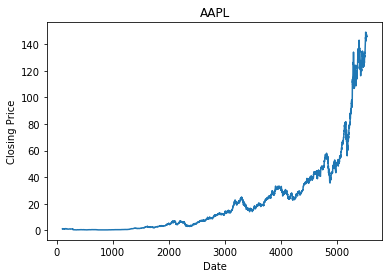

In [10]:
'''
plt.figure(1)
plt.xlabel("Date")
plt.ylabel("Support Held")
plt.title(tic)
plt.plot(data_df['floor_held'], 'o')
'''

plt.figure(0)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(tic)
plt.plot(data_df['close'])

In [11]:
#data_df.drop(labels=['date','year', 'dayofyear', 'dayofweek','option_expiry'], axis=1, inplace=True)
data_df_model = data_df[data_df['option_expiry'] != '2999-12-31']
excludeColumns = ['close', 'volume', 'volume_20_sma', 'close_20_ema', 'close_50_ema', 'close_100_ema',
                  'year', 'dayofyear', 'dayofweek','option_expiry']

#date aren't part of training, but are needed in the testing

data_df_train = data_df_model[data_df_model['year'] < 2020]
data_df_train = data_df_train.iloc[:,~data_df_train.columns.isin(excludeColumns)].copy()

data_df_test = data_df_model[data_df_model['year'] >= 2020]
data_df_test = data_df_test.iloc[:,~data_df_test.columns.isin(excludeColumns)].copy()
#data_df_model = data_df_model.iloc[:,~data_df_model.columns.isin(excludeColumns)].copy()

In [12]:
data_df_test

date  dayofyear_sin  dayofyear_cos  dayofweek_sin  dayofweek_cos  \
5131  2020-01-02       0.034328       0.999411  -9.510565e-01       0.309017   
5132  2020-01-03       0.051479       0.998674  -2.449294e-16       1.000000   
5133  2020-01-06       0.102821       0.994700   9.510565e-01       0.309017   
5134  2020-01-07       0.119881       0.992788   5.877853e-01      -0.809017   
5135  2020-01-08       0.136906       0.990584  -5.877853e-01      -0.809017   
...          ...            ...            ...            ...            ...   
5521  2021-07-21      -0.329408      -0.944188  -5.877853e-01      -0.809017   
5522  2021-07-22      -0.345612      -0.938377  -9.510565e-01       0.309017   
5523  2021-07-23      -0.361714      -0.932289  -2.449294e-16       1.000000   
5524  2021-07-26      -0.409356      -0.912375   9.510565e-01       0.309017   
5525  2021-07-27      -0.425000      -0.905193   5.877853e-01      -0.809017   

      close_-1_r       atr     rsi_14  volume_delta  close_20_ema_delta  \
5131    2.281632  1.142991  84.583737     -0.145501           -0.062947   
5132   -0.972204  1.134206  77.703695     -0.181775           -0.048629   
5133    0.796825  1.181941  79.183674      0.029867           -0.050802   
5134   -0.470305  1.158588  75.953553      0.121160           -0.041906   
5135    1.608629  1.205832  79.081928     -0.074307           -0.051638   
...          ...       ...        ...           ...                 ...   
5521   -0.513171  2.864887  62.344011      0.157809           -0.025405   
5522    0.962867  2.860253  64.564400      0.133778           -0.031395   
5523    1.198906  2.793092  67.184062      0.229173           -0.038787   
5524    0.289451  2.745728  67.810205      0.213568           -0.037603   
5525   -1.490034  2.811034  61.306558     -0.141001           -0.020851   

      close_50_ema_delta  close_100_ema_delta  floor_held  
5131           -0.112678            -0.172009           1  
5132           -0.099890            -0.160636           1  
5133           -0.102809            -0.163959           1  
5134           -0.094704            -0.156840           1  
5135           -0.104760            -0.166818           1  
...                  ...                  ...         ...  
5521           -0.064426            -0.092189           1  
5522           -0.070472            -0.098850           1  
5523           -0.078289            -0.107357           1  
5524           -0.077775            -0.107756           1  
5525           -0.061322            -0.092394           1  

[395 rows x 13 columns]

In [13]:
ct = ColumnTransformer([
        ('Standard', StandardScaler(),
         ['close_-1_r', 'atr', 'rsi_14', 'volume_delta', 
          'close_20_ema_delta', 'close_50_ema_delta', 'close_100_ema_delta'])],remainder='passthrough')

XY_train = ct.fit_transform(data_df_train)

X_train,X_val,Y_train,Y_val = train_test_split(XY_train[:, 0:-1],XY_train[:, -1], test_size = 0.2)

X_train2 = np.delete(X_train, -5, axis=1)
X_val2 = np.delete(X_val, -5, axis=1)

In [14]:
XY_test = ct.transform(data_df_test)
X_test = XY_test[:, 0:-1]
Y_test = XY_test[:, -1]
X_test2 = np.delete(X_test, -5, axis=1)
X_test2[0,:]

array([0.8498611573352889, 2.532343609817921, 2.271229728607962,
       -0.6838768749514363, -0.8564737601082214, -0.8578276259653402,
       -0.864528277102914, 0.034327600513243496, 0.9994106342455052,
       -0.9510565162951536, 0.30901699437494723], dtype=object)

In [15]:
X_train2 = X_train2.astype('float32')
X_val2 = X_val2.astype('float32')
X_test2 = X_test2.astype('float32')
Y_train = Y_train.astype('int')
Y_val = Y_val.astype('int')
Y_test = Y_test.astype('int')

In [16]:
def generate_trade_plan(X, Y_pred, Y_actual):
    consecutive_ups = 0
    consecutive_downs = 0
    trades = {}
    err_days = 0
    trade_days = 0
    trade_open = 0

    #inverse transform the stock price
    for i, p in enumerate(Y_pred.tolist()):

        #day = round(np.arccos(X_test[i,-3])*365/(2*np.pi),0)
        #trade_date = datetime(2020, 1, 1) + timedelta(day - 1)
        trade_date = X[i,-5]

        if p[0] == 0:        
            consecutive_ups = 0
            consecutive_downs += 1
        else:
            consecutive_ups += 1
            consecutive_downs = 0
        
        #open the trade
        if consecutive_ups >= 3 and trade_open == 0:
            open_date = trade_date
            trade_open = 1
            err_days = 0
            trade_days = 0
        
        #track errors during trade, exit trade after two consecutive exit signals
        if trade_open == 1:
            
            trade_days += 1
            err_days += (p[0] != Y_actual[i])
            
            if consecutive_downs > 1:
                close_date = trade_date
                trade_open = 0
                trades[(open_date,close_date)] = err_days/trade_days
    
    if trade_open == 1:
        trades[(open_date,)] = err_days/trade_days
        
    return trades

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-3)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-3)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 10s - loss: 0.6663 - accuracy: 0.6185 - val_loss: 0.6371 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.6130 - accuracy: 0.6856 - val_loss: 0.6138 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.6000 - accuracy: 0.7075 - val_loss: 0.6100 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5964 - accuracy: 0.7145 - val_loss: 0.6082 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5944 - accuracy: 0.7147 - val_loss: 0.6064 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5930 - accuracy: 0.7137 - val_loss: 0.6047 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5917 - accuracy: 0.7137 - val_loss: 0.6042 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5904 - accuracy: 0.7145 - val_loss: 0.6026 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5892 - accuracy: 0.7142 - val_loss: 0.6014 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7135 - val_loss: 0.6003 - val_accur

Epoch 82/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7207 - val_loss: 0.5803 - val_accuracy: 0.7120
Epoch 83/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7219 - val_loss: 0.5791 - val_accuracy: 0.7160
Epoch 84/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7217 - val_loss: 0.5795 - val_accuracy: 0.7170
Epoch 85/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7204 - val_loss: 0.5805 - val_accuracy: 0.7130
Epoch 86/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7202 - val_loss: 0.5798 - val_accuracy: 0.7140
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
32/32 [==============================] - 0s 731us/step - loss: 0.5789 - accuracy: 0.7120
Epoch 1/400
126/126 - 1s - loss: 0.6686 - accuracy: 0.6103 - val_loss: 0.6334 - val_accuracy: 0.6822
Epoch 2/400
126/126 - 0s - loss: 0.6107 - accuracy: 0.6961 - val_loss: 0.6107 - val_accuracy: 0.6922
Epoch 3/400
126/126 - 0s - loss: 0.5977 - accuracy: 0.7092 - val_loss: 0.6075 - val_accuracy: 0.6922
Epoch 4/400
12

126/126 - 0s - loss: 0.5843 - accuracy: 0.7162 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7160 - val_loss: 0.5990 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7169 - val_loss: 0.5993 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7160 - val_loss: 0.5979 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7157 - val_loss: 0.5966 - val_accuracy: 0.6941
Epoch 19/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7160 - val_loss: 0.5971 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7165 - val_loss: 0.5959 - val_accuracy: 0.6961
Epoch 21/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7147 - val_loss: 0.5949 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7179 - val_loss: 0.5974 - val_accuracy: 0.7011
Epoch 23/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7177 - val_loss: 0.5935 - val_accuracy: 

Epoch 95/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7279 - val_loss: 0.5830 - val_accuracy: 0.7210
Epoch 96/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7289 - val_loss: 0.5799 - val_accuracy: 0.7180
Epoch 97/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7309 - val_loss: 0.5801 - val_accuracy: 0.7210
Epoch 98/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7289 - val_loss: 0.5814 - val_accuracy: 0.7210
Epoch 99/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7274 - val_loss: 0.5809 - val_accuracy: 0.7210
Epoch 100/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7304 - val_loss: 0.5828 - val_accuracy: 0.7219
Epoch 101/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7309 - val_loss: 0.5839 - val_accuracy: 0.7210
Epoch 102/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7289 - val_loss: 0.5830 - val_accuracy: 0.7200
Epoch 103/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7296 - val_loss: 0.5809 - val_accuracy: 0.7229
Epoch 104/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7269 - val_loss: 0.579

Epoch 43/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7192 - val_loss: 0.5921 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7189 - val_loss: 0.5893 - val_accuracy: 0.7031
Epoch 45/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7192 - val_loss: 0.5909 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7202 - val_loss: 0.5894 - val_accuracy: 0.7031
Epoch 47/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7214 - val_loss: 0.5905 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7202 - val_loss: 0.5904 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7202 - val_loss: 0.5888 - val_accuracy: 0.7041
Epoch 50/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7204 - val_loss: 0.5875 - val_accuracy: 0.7061
Epoch 51/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7194 - val_loss: 0.5874 - val_accuracy: 0.7071
Epoch 52/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7217 - val_loss: 0.5889 - v

Epoch 50/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7232 - val_loss: 0.5882 - val_accuracy: 0.7130
Epoch 51/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7214 - val_loss: 0.5877 - val_accuracy: 0.7130
Epoch 52/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7242 - val_loss: 0.5885 - val_accuracy: 0.7120
Epoch 53/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7242 - val_loss: 0.5894 - val_accuracy: 0.7160
Epoch 54/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7224 - val_loss: 0.5884 - val_accuracy: 0.7090
Epoch 55/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7244 - val_loss: 0.5874 - val_accuracy: 0.7130
Epoch 56/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7254 - val_loss: 0.5874 - val_accuracy: 0.7110
Epoch 57/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7242 - val_loss: 0.5902 - val_accuracy: 0.7150
Epoch 58/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7249 - val_loss: 0.5867 - val_accuracy: 0.7180
Epoch 59/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7256 - val_loss: 0.5871 - v

Epoch 23/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7140 - val_loss: 0.6001 - val_accuracy: 0.6931
Epoch 24/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7132 - val_loss: 0.5994 - val_accuracy: 0.6922
Epoch 25/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7132 - val_loss: 0.5992 - val_accuracy: 0.6941
Epoch 26/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7140 - val_loss: 0.5996 - val_accuracy: 0.6961
Epoch 27/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7140 - val_loss: 0.5978 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7157 - val_loss: 0.5979 - val_accuracy: 0.6971
Epoch 29/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7162 - val_loss: 0.5964 - val_accuracy: 0.6951
Epoch 30/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7165 - val_loss: 0.5977 - val_accuracy: 0.6961
Epoch 31/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7160 - val_loss: 0.5952 - val_accuracy: 0.6971
Epoch 32/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7172 - val_loss: 0.5949 - v

Epoch 2/400
126/126 - 0s - loss: 0.6219 - accuracy: 0.6899 - val_loss: 0.6163 - val_accuracy: 0.7001
Epoch 3/400
126/126 - 0s - loss: 0.6073 - accuracy: 0.7085 - val_loss: 0.6117 - val_accuracy: 0.7021
Epoch 4/400
126/126 - 0s - loss: 0.6026 - accuracy: 0.7125 - val_loss: 0.6091 - val_accuracy: 0.7011
Epoch 5/400
126/126 - 0s - loss: 0.6000 - accuracy: 0.7150 - val_loss: 0.6073 - val_accuracy: 0.7001
Epoch 6/400
126/126 - 0s - loss: 0.5982 - accuracy: 0.7135 - val_loss: 0.6061 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5966 - accuracy: 0.7147 - val_loss: 0.6059 - val_accuracy: 0.7021
Epoch 8/400
126/126 - 0s - loss: 0.5952 - accuracy: 0.7145 - val_loss: 0.6048 - val_accuracy: 0.7001
Epoch 9/400
126/126 - 0s - loss: 0.5937 - accuracy: 0.7140 - val_loss: 0.6037 - val_accuracy: 0.6991
Epoch 10/400
126/126 - 0s - loss: 0.5928 - accuracy: 0.7155 - val_loss: 0.6027 - val_accuracy: 0.6981
Epoch 11/400
126/126 - 0s - loss: 0.5921 - accuracy: 0.7147 - val_loss: 0.6021 - val_accur

Epoch 83/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7289 - val_loss: 0.5808 - val_accuracy: 0.7160
Epoch 84/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7284 - val_loss: 0.5815 - val_accuracy: 0.7190
Epoch 85/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7281 - val_loss: 0.5819 - val_accuracy: 0.7150
Epoch 86/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7276 - val_loss: 0.5824 - val_accuracy: 0.7190
Epoch 87/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7299 - val_loss: 0.5807 - val_accuracy: 0.7200
Epoch 88/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7266 - val_loss: 0.5817 - val_accuracy: 0.7210
Epoch 89/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7276 - val_loss: 0.5835 - val_accuracy: 0.7190
Epoch 90/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7291 - val_loss: 0.5800 - val_accuracy: 0.7120
Epoch 91/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7304 - val_loss: 0.5823 - val_accuracy: 0.7190
Epoch 92/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7271 - val_loss: 0.5821 - v

Epoch 31/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7157 - val_loss: 0.5923 - val_accuracy: 0.6941
Epoch 32/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7155 - val_loss: 0.5920 - val_accuracy: 0.6922
Epoch 33/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7150 - val_loss: 0.5917 - val_accuracy: 0.6941
Epoch 34/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7169 - val_loss: 0.5938 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7172 - val_loss: 0.5929 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7174 - val_loss: 0.5925 - val_accuracy: 0.6941
Epoch 37/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7157 - val_loss: 0.5906 - val_accuracy: 0.6981
Epoch 38/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7165 - val_loss: 0.5932 - val_accuracy: 0.6951
Epoch 39/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7172 - val_loss: 0.5913 - val_accuracy: 0.6991
Epoch 40/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7179 - val_loss: 0.5910 - v

Epoch 112/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7286 - val_loss: 0.5829 - val_accuracy: 0.7150
Epoch 113/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7306 - val_loss: 0.5820 - val_accuracy: 0.7170
Epoch 114/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7299 - val_loss: 0.5816 - val_accuracy: 0.7239
Epoch 115/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7316 - val_loss: 0.5839 - val_accuracy: 0.7090
Epoch 116/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7296 - val_loss: 0.5837 - val_accuracy: 0.7190
Epoch 117/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7326 - val_loss: 0.5829 - val_accuracy: 0.7110
Epoch 118/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7321 - val_loss: 0.5821 - val_accuracy: 0.7200
Epoch 119/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7346 - val_loss: 0.5819 - val_accuracy: 0.7180
Epoch 120/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7341 - val_loss: 0.5871 - val_accuracy: 0.7031
Epoch 121/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7299 - val_loss: 

Epoch 60/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7234 - val_loss: 0.5827 - val_accuracy: 0.7051
Epoch 61/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7229 - val_loss: 0.5825 - val_accuracy: 0.7071
Epoch 62/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7244 - val_loss: 0.5826 - val_accuracy: 0.7080
Epoch 63/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7209 - val_loss: 0.5837 - val_accuracy: 0.7051
Epoch 64/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7244 - val_loss: 0.5833 - val_accuracy: 0.7051
Epoch 65/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7224 - val_loss: 0.5857 - val_accuracy: 0.7051
Epoch 66/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7224 - val_loss: 0.5848 - val_accuracy: 0.7090
Epoch 67/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7229 - val_loss: 0.5850 - val_accuracy: 0.7100
Epoch 68/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7209 - val_loss: 0.5816 - val_accuracy: 0.7130
Epoch 69/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7244 - val_loss: 0.5861 - v

Epoch 5/400
126/126 - 0s - loss: 0.5967 - accuracy: 0.7122 - val_loss: 0.6145 - val_accuracy: 0.6941
Epoch 6/400
126/126 - 0s - loss: 0.5955 - accuracy: 0.7120 - val_loss: 0.6127 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.5944 - accuracy: 0.7122 - val_loss: 0.6123 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.5934 - accuracy: 0.7130 - val_loss: 0.6109 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5921 - accuracy: 0.7130 - val_loss: 0.6094 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.5914 - accuracy: 0.7127 - val_loss: 0.6076 - val_accuracy: 0.6931
Epoch 11/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7125 - val_loss: 0.6066 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5898 - accuracy: 0.7127 - val_loss: 0.6052 - val_accuracy: 0.6922
Epoch 13/400
126/126 - 0s - loss: 0.5887 - accuracy: 0.7130 - val_loss: 0.6044 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7127 - val_loss: 0.6031 - val_ac

Epoch 86/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7294 - val_loss: 0.5773 - val_accuracy: 0.7200
Epoch 87/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7329 - val_loss: 0.5755 - val_accuracy: 0.7200
Epoch 88/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7301 - val_loss: 0.5765 - val_accuracy: 0.7210
Epoch 89/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7279 - val_loss: 0.5779 - val_accuracy: 0.7200
Epoch 90/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7304 - val_loss: 0.5743 - val_accuracy: 0.7229
Epoch 91/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7301 - val_loss: 0.5772 - val_accuracy: 0.7219
Epoch 92/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7274 - val_loss: 0.5772 - val_accuracy: 0.7200
Epoch 93/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7331 - val_loss: 0.5744 - val_accuracy: 0.7259
Epoch 94/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7311 - val_loss: 0.5760 - val_accuracy: 0.7210
Epoch 95/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7294 - val_loss: 0.5775 - v

Epoch 34/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7160 - val_loss: 0.5962 - val_accuracy: 0.6961
Epoch 35/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7150 - val_loss: 0.5954 - val_accuracy: 0.6981
Epoch 36/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7155 - val_loss: 0.5954 - val_accuracy: 0.6981
Epoch 37/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7157 - val_loss: 0.5935 - val_accuracy: 0.6951
Epoch 38/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7174 - val_loss: 0.5952 - val_accuracy: 0.6971
Epoch 39/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7160 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 40/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7167 - val_loss: 0.5940 - val_accuracy: 0.6971
Epoch 41/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7162 - val_loss: 0.5938 - val_accuracy: 0.6961
Epoch 42/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7174 - val_loss: 0.5936 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7174 - val_loss: 0.5934 - v

Epoch 115/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7251 - val_loss: 0.5781 - val_accuracy: 0.7219
Epoch 116/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7289 - val_loss: 0.5774 - val_accuracy: 0.7219
Epoch 117/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7309 - val_loss: 0.5777 - val_accuracy: 0.7210
Epoch 118/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7311 - val_loss: 0.5770 - val_accuracy: 0.7239
Epoch 119/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7301 - val_loss: 0.5761 - val_accuracy: 0.7289
Epoch 120/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7311 - val_loss: 0.5798 - val_accuracy: 0.7180
Epoch 121/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7299 - val_loss: 0.5750 - val_accuracy: 0.7289
Epoch 122/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7289 - val_loss: 0.5761 - val_accuracy: 0.7229
Epoch 123/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7304 - val_loss: 0.5760 - val_accuracy: 0.7239
Epoch 124/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7276 - val_loss: 

Epoch 60/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7239 - val_loss: 0.5866 - val_accuracy: 0.7071
Epoch 61/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7244 - val_loss: 0.5865 - val_accuracy: 0.7110
Epoch 62/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7242 - val_loss: 0.5863 - val_accuracy: 0.7071
Epoch 63/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7229 - val_loss: 0.5871 - val_accuracy: 0.7061
Epoch 64/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7254 - val_loss: 0.5868 - val_accuracy: 0.7051
Epoch 65/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7271 - val_loss: 0.5887 - val_accuracy: 0.7051
Epoch 66/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7239 - val_loss: 0.5886 - val_accuracy: 0.7071
Epoch 67/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7214 - val_loss: 0.5887 - val_accuracy: 0.7100
Epoch 68/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7251 - val_loss: 0.5852 - val_accuracy: 0.7100
Epoch 69/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7266 - val_loss: 0.5890 - v

Epoch 33/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7192 - val_loss: 0.5916 - val_accuracy: 0.7011
Epoch 34/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7182 - val_loss: 0.5930 - val_accuracy: 0.7001
Epoch 35/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7187 - val_loss: 0.5926 - val_accuracy: 0.7001
Epoch 36/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7177 - val_loss: 0.5921 - val_accuracy: 0.7001
Epoch 37/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7184 - val_loss: 0.5904 - val_accuracy: 0.7031
Epoch 38/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7184 - val_loss: 0.5920 - val_accuracy: 0.7011
Epoch 39/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7184 - val_loss: 0.5911 - val_accuracy: 0.7051
Epoch 40/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7184 - val_loss: 0.5908 - val_accuracy: 0.7071
Epoch 41/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7182 - val_loss: 0.5912 - val_accuracy: 0.7021
Epoch 42/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7165 - val_loss: 0.5908 - v

Epoch 40/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7189 - val_loss: 0.5950 - val_accuracy: 0.6912
Epoch 41/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7189 - val_loss: 0.5952 - val_accuracy: 0.6951
Epoch 42/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7202 - val_loss: 0.5948 - val_accuracy: 0.6951
Epoch 43/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7204 - val_loss: 0.5947 - val_accuracy: 0.6961
Epoch 44/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7202 - val_loss: 0.5930 - val_accuracy: 0.7051
Epoch 45/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7192 - val_loss: 0.5939 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7207 - val_loss: 0.5927 - val_accuracy: 0.6951
Epoch 47/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7207 - val_loss: 0.5928 - val_accuracy: 0.6981
Epoch 48/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7214 - val_loss: 0.5929 - val_accuracy: 0.6991
Epoch 49/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7219 - val_loss: 0.5914 - v

126/126 - 0s - loss: 0.5622 - accuracy: 0.7306 - val_loss: 0.5838 - val_accuracy: 0.7080
Epoch 121/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7309 - val_loss: 0.5767 - val_accuracy: 0.7150
Epoch 122/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7311 - val_loss: 0.5786 - val_accuracy: 0.7160
Epoch 123/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7289 - val_loss: 0.5777 - val_accuracy: 0.7160
Epoch 124/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7314 - val_loss: 0.5773 - val_accuracy: 0.7180
Epoch 125/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7309 - val_loss: 0.5780 - val_accuracy: 0.7120
Epoch 126/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7296 - val_loss: 0.5795 - val_accuracy: 0.7130
Epoch 127/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7329 - val_loss: 0.5800 - val_accuracy: 0.7150
Epoch 128/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7331 - val_loss: 0.5785 - val_accuracy: 0.7090
Epoch 129/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7348 - val_loss: 0.5787 - val_a

Epoch 68/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7229 - val_loss: 0.5850 - val_accuracy: 0.7140
Epoch 69/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7247 - val_loss: 0.5884 - val_accuracy: 0.7110
Epoch 70/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7251 - val_loss: 0.5856 - val_accuracy: 0.7071
Epoch 71/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7239 - val_loss: 0.5849 - val_accuracy: 0.7100
Epoch 72/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7237 - val_loss: 0.5853 - val_accuracy: 0.7150
Epoch 73/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7232 - val_loss: 0.5843 - val_accuracy: 0.7170
Epoch 74/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7249 - val_loss: 0.5839 - val_accuracy: 0.7190
Epoch 75/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7237 - val_loss: 0.5837 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7251 - val_loss: 0.5823 - val_accuracy: 0.7180
Epoch 77/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7254 - val_loss: 0.5850 - v

Epoch 16/400
126/126 - 0s - loss: 0.5862 - accuracy: 0.7142 - val_loss: 0.6017 - val_accuracy: 0.6981
Epoch 17/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7135 - val_loss: 0.6000 - val_accuracy: 0.7011
Epoch 18/400
126/126 - 0s - loss: 0.5850 - accuracy: 0.7147 - val_loss: 0.5983 - val_accuracy: 0.7021
Epoch 19/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7150 - val_loss: 0.5985 - val_accuracy: 0.7031
Epoch 20/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7150 - val_loss: 0.5967 - val_accuracy: 0.7011
Epoch 21/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7142 - val_loss: 0.5958 - val_accuracy: 0.7011
Epoch 22/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7145 - val_loss: 0.5977 - val_accuracy: 0.7071
Epoch 23/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7174 - val_loss: 0.5941 - val_accuracy: 0.7021
Epoch 24/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7162 - val_loss: 0.5942 - val_accuracy: 0.7021
Epoch 25/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7174 - val_loss: 0.5934 - v

Epoch 97/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7289 - val_loss: 0.5756 - val_accuracy: 0.7219
Epoch 98/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7321 - val_loss: 0.5767 - val_accuracy: 0.7249
Epoch 99/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7316 - val_loss: 0.5758 - val_accuracy: 0.7239
Epoch 100/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7309 - val_loss: 0.5786 - val_accuracy: 0.7239
Epoch 101/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7314 - val_loss: 0.5790 - val_accuracy: 0.7200
Epoch 102/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7311 - val_loss: 0.5785 - val_accuracy: 0.7200
Epoch 103/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7299 - val_loss: 0.5756 - val_accuracy: 0.7239
Epoch 104/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7299 - val_loss: 0.5747 - val_accuracy: 0.7279
Epoch 105/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7333 - val_loss: 0.5743 - val_accuracy: 0.7269
Epoch 106/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7324 - val_loss: 0.5

Epoch 42/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7227 - val_loss: 0.5931 - val_accuracy: 0.7051
Epoch 43/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7242 - val_loss: 0.5932 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7229 - val_loss: 0.5914 - val_accuracy: 0.7120
Epoch 45/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7234 - val_loss: 0.5924 - val_accuracy: 0.7100
Epoch 46/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7249 - val_loss: 0.5912 - val_accuracy: 0.7120
Epoch 47/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7247 - val_loss: 0.5919 - val_accuracy: 0.7080
Epoch 48/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7247 - val_loss: 0.5916 - val_accuracy: 0.7100
Epoch 49/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7259 - val_loss: 0.5906 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7242 - val_loss: 0.5901 - val_accuracy: 0.7180
Epoch 51/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7247 - val_loss: 0.5900 - v

126/126 - 0s - loss: 0.5607 - accuracy: 0.7363 - val_loss: 0.5774 - val_accuracy: 0.7249
Epoch 123/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7373 - val_loss: 0.5766 - val_accuracy: 0.7210
Epoch 124/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7343 - val_loss: 0.5756 - val_accuracy: 0.7279
Epoch 125/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7391 - val_loss: 0.5762 - val_accuracy: 0.7249
Epoch 126/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7363 - val_loss: 0.5774 - val_accuracy: 0.7210
Epoch 127/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7366 - val_loss: 0.5779 - val_accuracy: 0.7170
Epoch 128/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7346 - val_loss: 0.5764 - val_accuracy: 0.7210
Epoch 129/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7361 - val_loss: 0.5764 - val_accuracy: 0.7150
Epoch 130/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7326 - val_loss: 0.5779 - val_accuracy: 0.7219
Epoch 131/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7353 - val_loss: 0.5782 - val_a

Epoch 70/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7224 - val_loss: 0.5831 - val_accuracy: 0.7080
Epoch 71/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7209 - val_loss: 0.5818 - val_accuracy: 0.7120
Epoch 72/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7234 - val_loss: 0.5829 - val_accuracy: 0.7120
Epoch 73/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7232 - val_loss: 0.5823 - val_accuracy: 0.7150
Epoch 74/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7237 - val_loss: 0.5818 - val_accuracy: 0.7190
Epoch 75/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7234 - val_loss: 0.5808 - val_accuracy: 0.7180
Epoch 76/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7259 - val_loss: 0.5800 - val_accuracy: 0.7210
Epoch 77/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7247 - val_loss: 0.5826 - val_accuracy: 0.7140
Epoch 78/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7266 - val_loss: 0.5818 - val_accuracy: 0.7150
Epoch 79/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7259 - val_loss: 0.5820 - v

Epoch 15/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7140 - val_loss: 0.6084 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7127 - val_loss: 0.6078 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7120 - val_loss: 0.6062 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7125 - val_loss: 0.6043 - val_accuracy: 0.6941
Epoch 19/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7127 - val_loss: 0.6046 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7122 - val_loss: 0.6030 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7122 - val_loss: 0.6016 - val_accuracy: 0.6922
Epoch 22/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7140 - val_loss: 0.6032 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7135 - val_loss: 0.5999 - val_accuracy: 0.6961
Epoch 24/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7142 - val_loss: 0.5992 - v

Epoch 96/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7276 - val_loss: 0.5824 - val_accuracy: 0.7160
Epoch 97/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7279 - val_loss: 0.5833 - val_accuracy: 0.7170
Epoch 98/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7249 - val_loss: 0.5840 - val_accuracy: 0.7180
Epoch 99/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7286 - val_loss: 0.5833 - val_accuracy: 0.7140
Epoch 100/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7251 - val_loss: 0.5855 - val_accuracy: 0.7170
Epoch 101/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7271 - val_loss: 0.5862 - val_accuracy: 0.7210
Epoch 102/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7304 - val_loss: 0.5858 - val_accuracy: 0.7190
Epoch 103/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7291 - val_loss: 0.5834 - val_accuracy: 0.7210
Epoch 104/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7274 - val_loss: 0.5829 - val_accuracy: 0.7200
Epoch 105/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7289 - val_loss: 0.58

Epoch 69/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7271 - val_loss: 0.5876 - val_accuracy: 0.7100
Epoch 70/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7286 - val_loss: 0.5847 - val_accuracy: 0.7110
Epoch 71/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7266 - val_loss: 0.5841 - val_accuracy: 0.7160
Epoch 72/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7271 - val_loss: 0.5843 - val_accuracy: 0.7180
Epoch 73/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7266 - val_loss: 0.5838 - val_accuracy: 0.7170
Epoch 74/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7266 - val_loss: 0.5836 - val_accuracy: 0.7150
Epoch 75/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7264 - val_loss: 0.5827 - val_accuracy: 0.7150
Epoch 76/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7276 - val_loss: 0.5820 - val_accuracy: 0.7170
Epoch 77/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7276 - val_loss: 0.5844 - val_accuracy: 0.7140
Epoch 78/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7284 - val_loss: 0.5845 - v

Epoch 42/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7172 - val_loss: 0.5916 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7184 - val_loss: 0.5917 - val_accuracy: 0.6961
Epoch 44/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7184 - val_loss: 0.5894 - val_accuracy: 0.6991
Epoch 45/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7194 - val_loss: 0.5904 - val_accuracy: 0.7061
Epoch 46/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7199 - val_loss: 0.5890 - val_accuracy: 0.7090
Epoch 47/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7222 - val_loss: 0.5894 - val_accuracy: 0.7041
Epoch 48/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7219 - val_loss: 0.5890 - val_accuracy: 0.7051
Epoch 49/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7232 - val_loss: 0.5877 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7237 - val_loss: 0.5871 - val_accuracy: 0.7130
Epoch 51/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7227 - val_loss: 0.5871 - v

Epoch 15/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7135 - val_loss: 0.6027 - val_accuracy: 0.6991
Epoch 16/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7145 - val_loss: 0.6027 - val_accuracy: 0.6981
Epoch 17/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7150 - val_loss: 0.6017 - val_accuracy: 0.6981
Epoch 18/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7142 - val_loss: 0.6006 - val_accuracy: 0.6971
Epoch 19/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7145 - val_loss: 0.6010 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7160 - val_loss: 0.5998 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7140 - val_loss: 0.5994 - val_accuracy: 0.6981
Epoch 22/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7165 - val_loss: 0.6012 - val_accuracy: 0.7031
Epoch 23/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7179 - val_loss: 0.5983 - val_accuracy: 0.6971
Epoch 24/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7169 - val_loss: 0.5983 - v

Epoch 96/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7353 - val_loss: 0.5764 - val_accuracy: 0.7249
Epoch 97/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7376 - val_loss: 0.5770 - val_accuracy: 0.7160
Epoch 98/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7393 - val_loss: 0.5785 - val_accuracy: 0.7190
Epoch 99/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7361 - val_loss: 0.5777 - val_accuracy: 0.7200
Epoch 100/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7358 - val_loss: 0.5802 - val_accuracy: 0.7219
Epoch 101/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7403 - val_loss: 0.5804 - val_accuracy: 0.7210
Epoch 102/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7348 - val_loss: 0.5803 - val_accuracy: 0.7180
Epoch 103/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7373 - val_loss: 0.5780 - val_accuracy: 0.7200
Epoch 104/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7351 - val_loss: 0.5766 - val_accuracy: 0.7219
Epoch 105/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7388 - val_loss: 0.57

Epoch 69/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7291 - val_loss: 0.5854 - val_accuracy: 0.7120
Epoch 70/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7286 - val_loss: 0.5819 - val_accuracy: 0.7190
Epoch 71/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7271 - val_loss: 0.5815 - val_accuracy: 0.7190
Epoch 72/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7261 - val_loss: 0.5820 - val_accuracy: 0.7210
Epoch 73/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7261 - val_loss: 0.5810 - val_accuracy: 0.7219
Epoch 74/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7279 - val_loss: 0.5805 - val_accuracy: 0.7239
Epoch 75/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7254 - val_loss: 0.5798 - val_accuracy: 0.7219
Epoch 76/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7274 - val_loss: 0.5791 - val_accuracy: 0.7229
Epoch 77/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7256 - val_loss: 0.5810 - val_accuracy: 0.7229
Epoch 78/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7281 - val_loss: 0.5820 - v

Epoch 17/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7152 - val_loss: 0.5999 - val_accuracy: 0.6991
Epoch 18/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7160 - val_loss: 0.5991 - val_accuracy: 0.6981
Epoch 19/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7167 - val_loss: 0.5995 - val_accuracy: 0.6981
Epoch 20/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7157 - val_loss: 0.5986 - val_accuracy: 0.6991
Epoch 21/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7162 - val_loss: 0.5977 - val_accuracy: 0.7001
Epoch 22/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7160 - val_loss: 0.5990 - val_accuracy: 0.6991
Epoch 23/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7165 - val_loss: 0.5968 - val_accuracy: 0.7001
Epoch 24/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7162 - val_loss: 0.5964 - val_accuracy: 0.7001
Epoch 25/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7162 - val_loss: 0.5964 - val_accuracy: 0.7001
Epoch 26/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7169 - val_loss: 0.5968 - v

Epoch 98/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7279 - val_loss: 0.5828 - val_accuracy: 0.7219
Epoch 99/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7269 - val_loss: 0.5821 - val_accuracy: 0.7190
Epoch 100/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7261 - val_loss: 0.5839 - val_accuracy: 0.7219
Epoch 101/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7281 - val_loss: 0.5848 - val_accuracy: 0.7219
Epoch 102/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7299 - val_loss: 0.5841 - val_accuracy: 0.7219
Epoch 103/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7271 - val_loss: 0.5820 - val_accuracy: 0.7259
Epoch 104/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7269 - val_loss: 0.5812 - val_accuracy: 0.7259
Epoch 105/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7291 - val_loss: 0.5811 - val_accuracy: 0.7269
Epoch 106/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7281 - val_loss: 0.5836 - val_accuracy: 0.7249
Epoch 107/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7279 - val_loss: 0.

Epoch 46/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7227 - val_loss: 0.5845 - val_accuracy: 0.7090
Epoch 47/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7219 - val_loss: 0.5851 - val_accuracy: 0.7061
Epoch 48/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7232 - val_loss: 0.5849 - val_accuracy: 0.7061
Epoch 49/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7244 - val_loss: 0.5829 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7224 - val_loss: 0.5831 - val_accuracy: 0.7110
Epoch 51/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7237 - val_loss: 0.5832 - val_accuracy: 0.7100
Epoch 52/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7239 - val_loss: 0.5835 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7239 - val_loss: 0.5840 - val_accuracy: 0.7090
Epoch 54/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7217 - val_loss: 0.5843 - val_accuracy: 0.7061
Epoch 55/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7237 - val_loss: 0.5828 - v

Epoch 39/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7204 - val_loss: 0.5911 - val_accuracy: 0.7041
Epoch 40/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7209 - val_loss: 0.5909 - val_accuracy: 0.7061
Epoch 41/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7212 - val_loss: 0.5920 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7219 - val_loss: 0.5910 - val_accuracy: 0.7071
Epoch 43/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7234 - val_loss: 0.5917 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7229 - val_loss: 0.5898 - val_accuracy: 0.7041
Epoch 45/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7249 - val_loss: 0.5900 - val_accuracy: 0.7090
Epoch 46/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7259 - val_loss: 0.5888 - val_accuracy: 0.7120
Epoch 47/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7269 - val_loss: 0.5890 - val_accuracy: 0.7090
Epoch 48/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7274 - val_loss: 0.5891 - v

Epoch 12/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7145 - val_loss: 0.6057 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7145 - val_loss: 0.6052 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5857 - accuracy: 0.7142 - val_loss: 0.6040 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7150 - val_loss: 0.6039 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7157 - val_loss: 0.6035 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7157 - val_loss: 0.6016 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7147 - val_loss: 0.6001 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7162 - val_loss: 0.6006 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7157 - val_loss: 0.5989 - val_accuracy: 0.6961
Epoch 21/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7152 - val_loss: 0.5976 - v

Epoch 93/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7311 - val_loss: 0.5772 - val_accuracy: 0.7190
Epoch 94/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7311 - val_loss: 0.5782 - val_accuracy: 0.7239
Epoch 95/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7309 - val_loss: 0.5795 - val_accuracy: 0.7279
Epoch 96/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7329 - val_loss: 0.5756 - val_accuracy: 0.7229
Epoch 97/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7309 - val_loss: 0.5762 - val_accuracy: 0.7239
Epoch 98/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7319 - val_loss: 0.5776 - val_accuracy: 0.7259
Epoch 99/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7306 - val_loss: 0.5769 - val_accuracy: 0.7239
Epoch 100/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7289 - val_loss: 0.5789 - val_accuracy: 0.7289
Epoch 101/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7331 - val_loss: 0.5793 - val_accuracy: 0.7269
Epoch 102/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7291 - val_loss: 0.5795 

Epoch 66/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7244 - val_loss: 0.5869 - val_accuracy: 0.7140
Epoch 67/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7239 - val_loss: 0.5866 - val_accuracy: 0.7160
Epoch 68/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7244 - val_loss: 0.5845 - val_accuracy: 0.7180
Epoch 69/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7249 - val_loss: 0.5879 - val_accuracy: 0.7140
Epoch 70/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7251 - val_loss: 0.5844 - val_accuracy: 0.7140
Epoch 71/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7256 - val_loss: 0.5848 - val_accuracy: 0.7140
Epoch 72/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7264 - val_loss: 0.5850 - val_accuracy: 0.7160
Epoch 73/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7264 - val_loss: 0.5838 - val_accuracy: 0.7200
Epoch 74/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7269 - val_loss: 0.5839 - val_accuracy: 0.7190
Epoch 75/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7251 - val_loss: 0.5830 - v

Epoch 14/400
126/126 - 0s - loss: 0.5879 - accuracy: 0.7140 - val_loss: 0.6063 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7135 - val_loss: 0.6060 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7137 - val_loss: 0.6062 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5862 - accuracy: 0.7125 - val_loss: 0.6046 - val_accuracy: 0.6922
Epoch 18/400
126/126 - 0s - loss: 0.5859 - accuracy: 0.7137 - val_loss: 0.6032 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7147 - val_loss: 0.6032 - val_accuracy: 0.6912
Epoch 20/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7140 - val_loss: 0.6021 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7137 - val_loss: 0.6012 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7150 - val_loss: 0.6028 - val_accuracy: 0.6931
Epoch 23/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7140 - val_loss: 0.5996 - v

Epoch 95/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7271 - val_loss: 0.5833 - val_accuracy: 0.7160
Epoch 96/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7269 - val_loss: 0.5803 - val_accuracy: 0.7130
Epoch 97/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7264 - val_loss: 0.5811 - val_accuracy: 0.7170
Epoch 98/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7254 - val_loss: 0.5819 - val_accuracy: 0.7160
Epoch 99/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7256 - val_loss: 0.5810 - val_accuracy: 0.7120
Epoch 100/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7259 - val_loss: 0.5834 - val_accuracy: 0.7150
Epoch 101/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7239 - val_loss: 0.5840 - val_accuracy: 0.7180
Epoch 102/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7266 - val_loss: 0.5834 - val_accuracy: 0.7180
Epoch 103/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7256 - val_loss: 0.5808 - val_accuracy: 0.7160
Epoch 104/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7259 - val_loss: 0.579

Epoch 40/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7237 - val_loss: 0.5918 - val_accuracy: 0.7071
Epoch 41/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7229 - val_loss: 0.5917 - val_accuracy: 0.7021
Epoch 42/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7242 - val_loss: 0.5910 - val_accuracy: 0.7061
Epoch 43/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7242 - val_loss: 0.5911 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7244 - val_loss: 0.5889 - val_accuracy: 0.7090
Epoch 45/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7254 - val_loss: 0.5901 - val_accuracy: 0.7090
Epoch 46/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7251 - val_loss: 0.5886 - val_accuracy: 0.7120
Epoch 47/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7249 - val_loss: 0.5888 - val_accuracy: 0.7090
Epoch 48/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7251 - val_loss: 0.5886 - val_accuracy: 0.7090
Epoch 49/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7261 - val_loss: 0.5872 - v

126/126 - 0s - loss: 0.5620 - accuracy: 0.7324 - val_loss: 0.5815 - val_accuracy: 0.7210
Epoch 121/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7306 - val_loss: 0.5763 - val_accuracy: 0.7229
Epoch 122/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7289 - val_loss: 0.5780 - val_accuracy: 0.7200
Epoch 123/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7294 - val_loss: 0.5777 - val_accuracy: 0.7239
Epoch 124/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7299 - val_loss: 0.5771 - val_accuracy: 0.7219
Epoch 125/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7321 - val_loss: 0.5777 - val_accuracy: 0.7210
Epoch 126/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7301 - val_loss: 0.5793 - val_accuracy: 0.7269
Epoch 127/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7326 - val_loss: 0.5794 - val_accuracy: 0.7239
Epoch 128/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7326 - val_loss: 0.5775 - val_accuracy: 0.7200
Epoch 129/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7309 - val_loss: 0.5779 - val_a

In [18]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg1_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg1_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 996us/step - loss: 0.5760 - accuracy: 0.7329
Test Loss: 0.576
Test Accuracy: 0.733


In [19]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

C:\Users\btang\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{('2020-01-06', '2020-03-18'): 0.45098039215686275,
 ('2020-03-23', '2020-03-25'): 0.6666666666666666,
 ('2020-03-31', '2020-09-10'): 0.17543859649122806,
 ('2020-12-04', '2020-12-10'): 0.4,
 ('2020-12-17', '2021-01-05'): 0.4166666666666667,
 ('2021-01-27', '2021-01-29'): 1.0,
 ('2021-03-25',): 0.11627906976744186}

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-4)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-4)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 1s - loss: 0.6530 - accuracy: 0.6190 - val_loss: 0.6244 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.6010 - accuracy: 0.6841 - val_loss: 0.6017 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7068 - val_loss: 0.5980 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5850 - accuracy: 0.7135 - val_loss: 0.5964 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5833 - accuracy: 0.7145 - val_loss: 0.5948 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7140 - val_loss: 0.5931 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7137 - val_loss: 0.5927 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7145 - val_loss: 0.5912 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7142 - val_loss: 0.5901 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7135 - val_loss: 0.5892 - val_accura

Epoch 21/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7165 - val_loss: 0.5813 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7184 - val_loss: 0.5830 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7172 - val_loss: 0.5801 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7189 - val_loss: 0.5801 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7187 - val_loss: 0.5799 - val_accuracy: 0.6981
Epoch 26/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7182 - val_loss: 0.5804 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7194 - val_loss: 0.5791 - val_accuracy: 0.7001
Epoch 28/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7184 - val_loss: 0.5791 - val_accuracy: 0.7001
Epoch 29/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7177 - val_loss: 0.5779 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7199 - val_loss: 0.5794 - v

Epoch 41/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7229 - val_loss: 0.5831 - val_accuracy: 0.7120
Epoch 42/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7224 - val_loss: 0.5828 - val_accuracy: 0.7160
Epoch 43/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7237 - val_loss: 0.5827 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7234 - val_loss: 0.5808 - val_accuracy: 0.7130
Epoch 45/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7239 - val_loss: 0.5816 - val_accuracy: 0.7150
Epoch 46/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7242 - val_loss: 0.5805 - val_accuracy: 0.7130
Epoch 47/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7256 - val_loss: 0.5808 - val_accuracy: 0.7180
Epoch 48/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7254 - val_loss: 0.5810 - val_accuracy: 0.7170
Epoch 49/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7256 - val_loss: 0.5796 - val_accuracy: 0.7130
Epoch 50/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7239 - val_loss: 0.5795 - v

Epoch 14/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7132 - val_loss: 0.5921 - val_accuracy: 0.6882
Epoch 15/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7150 - val_loss: 0.5928 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7142 - val_loss: 0.5934 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7117 - val_loss: 0.5913 - val_accuracy: 0.6892
Epoch 18/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7132 - val_loss: 0.5900 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7147 - val_loss: 0.5921 - val_accuracy: 0.6902
Epoch 20/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7142 - val_loss: 0.5897 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7150 - val_loss: 0.5886 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7145 - val_loss: 0.5917 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7140 - val_loss: 0.5881 - v

Epoch 95/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7324 - val_loss: 0.5709 - val_accuracy: 0.7299
Epoch 96/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7338 - val_loss: 0.5678 - val_accuracy: 0.7259
Epoch 97/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7343 - val_loss: 0.5688 - val_accuracy: 0.7239
Epoch 98/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7358 - val_loss: 0.5698 - val_accuracy: 0.7279
Epoch 99/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7329 - val_loss: 0.5692 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7333 - val_loss: 0.5712 - val_accuracy: 0.7279
Epoch 101/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7341 - val_loss: 0.5720 - val_accuracy: 0.7269
Epoch 102/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7358 - val_loss: 0.5710 - val_accuracy: 0.7279
Epoch 103/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7341 - val_loss: 0.5691 - val_accuracy: 0.7319
Epoch 104/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7319 - val_loss: 0.568

Epoch 40/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7214 - val_loss: 0.5910 - val_accuracy: 0.7011
Epoch 41/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7202 - val_loss: 0.5894 - val_accuracy: 0.7011
Epoch 42/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7209 - val_loss: 0.5898 - val_accuracy: 0.7031
Epoch 43/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7214 - val_loss: 0.5894 - val_accuracy: 0.7031
Epoch 44/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7217 - val_loss: 0.5874 - val_accuracy: 0.7051
Epoch 45/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7227 - val_loss: 0.5891 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7244 - val_loss: 0.5873 - val_accuracy: 0.7031
Epoch 47/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7232 - val_loss: 0.5879 - val_accuracy: 0.7041
Epoch 48/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7244 - val_loss: 0.5880 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7249 - val_loss: 0.5862 - v

Epoch 13/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7100 - val_loss: 0.6000 - val_accuracy: 0.6941
Epoch 14/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7097 - val_loss: 0.5994 - val_accuracy: 0.6922
Epoch 15/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7097 - val_loss: 0.5998 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7095 - val_loss: 0.5990 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7112 - val_loss: 0.5976 - val_accuracy: 0.6902
Epoch 18/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7105 - val_loss: 0.5963 - val_accuracy: 0.6941
Epoch 19/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7112 - val_loss: 0.5966 - val_accuracy: 0.6892
Epoch 20/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7105 - val_loss: 0.5954 - val_accuracy: 0.6922
Epoch 21/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7120 - val_loss: 0.5942 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7117 - val_loss: 0.5953 - v

Epoch 6/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7137 - val_loss: 0.5942 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5850 - accuracy: 0.7142 - val_loss: 0.5944 - val_accuracy: 0.7001
Epoch 8/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7145 - val_loss: 0.5936 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7145 - val_loss: 0.5930 - val_accuracy: 0.6991
Epoch 10/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7157 - val_loss: 0.5923 - val_accuracy: 0.7001
Epoch 11/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7150 - val_loss: 0.5921 - val_accuracy: 0.6991
Epoch 12/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7135 - val_loss: 0.5913 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7150 - val_loss: 0.5914 - val_accuracy: 0.6971
Epoch 14/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7140 - val_loss: 0.5912 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7152 - val_loss: 0.5914 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7331 - val_loss: 0.5704 - val_accuracy: 0.7100
Epoch 88/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7346 - val_loss: 0.5712 - val_accuracy: 0.7180
Epoch 89/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7356 - val_loss: 0.5726 - val_accuracy: 0.7170
Epoch 90/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7333 - val_loss: 0.5695 - val_accuracy: 0.7061
Epoch 91/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7366 - val_loss: 0.5716 - val_accuracy: 0.7219
Epoch 92/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7363 - val_loss: 0.5715 - val_accuracy: 0.7180
Epoch 93/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7346 - val_loss: 0.5699 - val_accuracy: 0.7160
Epoch 94/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7351 - val_loss: 0.5711 - val_accuracy: 0.7160
Epoch 95/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7366 - val_loss: 0.5715 - val_accuracy: 0.7180
Epoch 96/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7381 - val_loss: 0.5685 - v

Epoch 42/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7194 - val_loss: 0.5858 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7179 - val_loss: 0.5853 - val_accuracy: 0.6981
Epoch 44/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7197 - val_loss: 0.5837 - val_accuracy: 0.7001
Epoch 45/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7217 - val_loss: 0.5842 - val_accuracy: 0.7001
Epoch 46/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7222 - val_loss: 0.5838 - val_accuracy: 0.7021
Epoch 47/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7182 - val_loss: 0.5842 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7207 - val_loss: 0.5840 - val_accuracy: 0.7011
Epoch 49/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7227 - val_loss: 0.5826 - val_accuracy: 0.7080
Epoch 50/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7202 - val_loss: 0.5828 - val_accuracy: 0.7011
Epoch 51/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7212 - val_loss: 0.5825 - v

126/126 - 0s - loss: 0.5489 - accuracy: 0.7304 - val_loss: 0.5727 - val_accuracy: 0.7190
Epoch 123/400
126/126 - 0s - loss: 0.5491 - accuracy: 0.7329 - val_loss: 0.5719 - val_accuracy: 0.7160
Epoch 124/400
126/126 - 0s - loss: 0.5483 - accuracy: 0.7336 - val_loss: 0.5709 - val_accuracy: 0.7180
Epoch 125/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7311 - val_loss: 0.5715 - val_accuracy: 0.7120
Epoch 126/400
126/126 - 0s - loss: 0.5483 - accuracy: 0.7361 - val_loss: 0.5728 - val_accuracy: 0.7180
Epoch 127/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7331 - val_loss: 0.5721 - val_accuracy: 0.7160
Epoch 128/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7314 - val_loss: 0.5706 - val_accuracy: 0.7130
Epoch 129/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7321 - val_loss: 0.5715 - val_accuracy: 0.7210
Epoch 130/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7338 - val_loss: 0.5734 - val_accuracy: 0.7150
Epoch 131/400
126/126 - 0s - loss: 0.5478 - accuracy: 0.7356 - val_loss: 0.5729 - val_a

Epoch 18/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7140 - val_loss: 0.5854 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7145 - val_loss: 0.5863 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7147 - val_loss: 0.5846 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7127 - val_loss: 0.5836 - val_accuracy: 0.6951
Epoch 22/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7142 - val_loss: 0.5859 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7137 - val_loss: 0.5824 - val_accuracy: 0.6961
Epoch 24/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7167 - val_loss: 0.5821 - val_accuracy: 0.6971
Epoch 25/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7167 - val_loss: 0.5819 - val_accuracy: 0.6961
Epoch 26/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7137 - val_loss: 0.5829 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7157 - val_loss: 0.5814 - v

Epoch 99/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7358 - val_loss: 0.5659 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7333 - val_loss: 0.5682 - val_accuracy: 0.7229
Epoch 101/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7351 - val_loss: 0.5691 - val_accuracy: 0.7239
Epoch 102/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7343 - val_loss: 0.5676 - val_accuracy: 0.7219
Epoch 103/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7351 - val_loss: 0.5671 - val_accuracy: 0.7249
Epoch 104/400
126/126 - 0s - loss: 0.5491 - accuracy: 0.7363 - val_loss: 0.5653 - val_accuracy: 0.7239
Epoch 105/400
126/126 - 0s - loss: 0.5491 - accuracy: 0.7386 - val_loss: 0.5650 - val_accuracy: 0.7200
Epoch 106/400
126/126 - 0s - loss: 0.5486 - accuracy: 0.7351 - val_loss: 0.5656 - val_accuracy: 0.7249
Epoch 107/400
126/126 - 0s - loss: 0.5490 - accuracy: 0.7371 - val_loss: 0.5646 - val_accuracy: 0.7219
Epoch 108/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7381 - val_loss: 0

Epoch 179/400
126/126 - 0s - loss: 0.5335 - accuracy: 0.7475 - val_loss: 0.5546 - val_accuracy: 0.7289
Epoch 180/400
126/126 - 0s - loss: 0.5337 - accuracy: 0.7470 - val_loss: 0.5498 - val_accuracy: 0.7388
Epoch 181/400
126/126 - 0s - loss: 0.5335 - accuracy: 0.7480 - val_loss: 0.5521 - val_accuracy: 0.7339
Epoch 182/400
126/126 - 0s - loss: 0.5340 - accuracy: 0.7460 - val_loss: 0.5502 - val_accuracy: 0.7319
Epoch 183/400
126/126 - 0s - loss: 0.5329 - accuracy: 0.7455 - val_loss: 0.5521 - val_accuracy: 0.7339
Epoch 184/400
126/126 - 0s - loss: 0.5334 - accuracy: 0.7460 - val_loss: 0.5510 - val_accuracy: 0.7329
Restoring model weights from the end of the best epoch.
Epoch 00184: early stopping
32/32 [==============================] - 0s 671us/step - loss: 0.5493 - accuracy: 0.7388
Epoch 1/400
126/126 - 1s - loss: 0.6648 - accuracy: 0.6069 - val_loss: 0.6324 - val_accuracy: 0.6733
Epoch 2/400
126/126 - 0s - loss: 0.6001 - accuracy: 0.7068 - val_loss: 0.6094 - val_accuracy: 0.6882
Epoch 3

Epoch 74/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7237 - val_loss: 0.5740 - val_accuracy: 0.7170
Epoch 75/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7242 - val_loss: 0.5734 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7234 - val_loss: 0.5725 - val_accuracy: 0.7170
Epoch 77/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7244 - val_loss: 0.5752 - val_accuracy: 0.7160
Epoch 78/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7251 - val_loss: 0.5745 - val_accuracy: 0.7140
Epoch 79/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7232 - val_loss: 0.5742 - val_accuracy: 0.7170
Epoch 80/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7261 - val_loss: 0.5727 - val_accuracy: 0.7180
Epoch 81/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7247 - val_loss: 0.5725 - val_accuracy: 0.7190
Epoch 82/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7244 - val_loss: 0.5723 - val_accuracy: 0.7170
Epoch 83/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7251 - val_loss: 0.5716 - v

Epoch 22/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7157 - val_loss: 0.5953 - val_accuracy: 0.6961
Epoch 23/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7137 - val_loss: 0.5920 - val_accuracy: 0.7001
Epoch 24/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7152 - val_loss: 0.5917 - val_accuracy: 0.7011
Epoch 25/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7142 - val_loss: 0.5911 - val_accuracy: 0.6991
Epoch 26/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7160 - val_loss: 0.5916 - val_accuracy: 0.6961
Epoch 27/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7152 - val_loss: 0.5901 - val_accuracy: 0.6991
Epoch 28/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7162 - val_loss: 0.5898 - val_accuracy: 0.6971
Epoch 29/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7157 - val_loss: 0.5885 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7167 - val_loss: 0.5895 - val_accuracy: 0.6991
Epoch 31/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7157 - val_loss: 0.5875 - v

Epoch 103/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7296 - val_loss: 0.5715 - val_accuracy: 0.7140
Epoch 104/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7276 - val_loss: 0.5707 - val_accuracy: 0.7150
Epoch 105/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7314 - val_loss: 0.5702 - val_accuracy: 0.7150
Epoch 106/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7314 - val_loss: 0.5713 - val_accuracy: 0.7210
Epoch 107/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7294 - val_loss: 0.5706 - val_accuracy: 0.7219
Epoch 108/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7269 - val_loss: 0.5708 - val_accuracy: 0.7200
Epoch 109/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7301 - val_loss: 0.5709 - val_accuracy: 0.7210
Epoch 110/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7321 - val_loss: 0.5700 - val_accuracy: 0.7229
Epoch 111/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7311 - val_loss: 0.5699 - val_accuracy: 0.7219
Epoch 112/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7329 - val_loss: 

Epoch 48/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7232 - val_loss: 0.5857 - val_accuracy: 0.7011
Epoch 49/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7214 - val_loss: 0.5847 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7237 - val_loss: 0.5843 - val_accuracy: 0.7080
Epoch 51/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7249 - val_loss: 0.5844 - val_accuracy: 0.7080
Epoch 52/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7239 - val_loss: 0.5854 - val_accuracy: 0.7061
Epoch 53/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7254 - val_loss: 0.5855 - val_accuracy: 0.7071
Epoch 54/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7261 - val_loss: 0.5852 - val_accuracy: 0.7061
Epoch 55/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7244 - val_loss: 0.5846 - val_accuracy: 0.7080
Epoch 56/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7251 - val_loss: 0.5850 - val_accuracy: 0.7080
Epoch 57/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7256 - val_loss: 0.5865 - v

126/126 - 0s - loss: 0.5513 - accuracy: 0.7343 - val_loss: 0.5716 - val_accuracy: 0.7170
Epoch 129/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7314 - val_loss: 0.5723 - val_accuracy: 0.7170
Epoch 130/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7338 - val_loss: 0.5730 - val_accuracy: 0.7210
Epoch 131/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7338 - val_loss: 0.5727 - val_accuracy: 0.7239
Epoch 132/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7346 - val_loss: 0.5723 - val_accuracy: 0.7170
Epoch 133/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7346 - val_loss: 0.5723 - val_accuracy: 0.7190
Epoch 134/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7343 - val_loss: 0.5729 - val_accuracy: 0.7219
Epoch 135/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7331 - val_loss: 0.5701 - val_accuracy: 0.7150
Epoch 136/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7329 - val_loss: 0.5714 - val_accuracy: 0.7160
Epoch 137/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7348 - val_loss: 0.5703 - val_a

Restoring model weights from the end of the best epoch.
Epoch 00207: early stopping
32/32 [==============================] - 0s 789us/step - loss: 0.5633 - accuracy: 0.7279
Epoch 1/400
126/126 - 1s - loss: 0.6931 - accuracy: 0.5862 - val_loss: 0.6355 - val_accuracy: 0.6753
Epoch 2/400
126/126 - 0s - loss: 0.6062 - accuracy: 0.6993 - val_loss: 0.6104 - val_accuracy: 0.6922
Epoch 3/400
126/126 - 0s - loss: 0.5919 - accuracy: 0.7137 - val_loss: 0.6041 - val_accuracy: 0.6902
Epoch 4/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7132 - val_loss: 0.6016 - val_accuracy: 0.6912
Epoch 5/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7127 - val_loss: 0.5993 - val_accuracy: 0.6912
Epoch 6/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7130 - val_loss: 0.5977 - val_accuracy: 0.6902
Epoch 7/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7132 - val_loss: 0.5977 - val_accuracy: 0.6912
Epoch 8/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7142 - val_loss: 0.5966 - val_accuracy: 0.6922
Epoch 9/400
126/126

Epoch 80/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7294 - val_loss: 0.5771 - val_accuracy: 0.7150
Epoch 81/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7304 - val_loss: 0.5767 - val_accuracy: 0.7190
Epoch 82/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7309 - val_loss: 0.5775 - val_accuracy: 0.7140
Epoch 83/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7333 - val_loss: 0.5759 - val_accuracy: 0.7219
Epoch 84/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7319 - val_loss: 0.5763 - val_accuracy: 0.7180
Epoch 85/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7306 - val_loss: 0.5769 - val_accuracy: 0.7160
Epoch 86/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7314 - val_loss: 0.5771 - val_accuracy: 0.7130
Epoch 87/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7299 - val_loss: 0.5762 - val_accuracy: 0.7150
Epoch 88/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7274 - val_loss: 0.5763 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7319 - val_loss: 0.5776 - v

Epoch 3/400
126/126 - 0s - loss: 0.5906 - accuracy: 0.7110 - val_loss: 0.6070 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7097 - val_loss: 0.6046 - val_accuracy: 0.6912
Epoch 5/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7097 - val_loss: 0.6025 - val_accuracy: 0.6922
Epoch 6/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7102 - val_loss: 0.6012 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7107 - val_loss: 0.6011 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7097 - val_loss: 0.6001 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7110 - val_loss: 0.5993 - val_accuracy: 0.6902
Epoch 10/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7110 - val_loss: 0.5984 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7117 - val_loss: 0.5979 - val_accuracy: 0.6912
Epoch 12/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7107 - val_loss: 0.5975 - val_accu

Epoch 84/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7274 - val_loss: 0.5840 - val_accuracy: 0.7051
Epoch 85/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7306 - val_loss: 0.5842 - val_accuracy: 0.7041
Epoch 86/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7284 - val_loss: 0.5843 - val_accuracy: 0.7041
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
32/32 [==============================] - 0s 869us/step - loss: 0.5839 - accuracy: 0.7061
Epoch 1/400
126/126 - 1s - loss: 0.7177 - accuracy: 0.5773 - val_loss: 0.6217 - val_accuracy: 0.6922
Epoch 2/400
126/126 - 0s - loss: 0.6004 - accuracy: 0.7065 - val_loss: 0.6052 - val_accuracy: 0.6981
Epoch 3/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7100 - val_loss: 0.6023 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.5877 - accuracy: 0.7125 - val_loss: 0.6003 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7127 - val_loss: 0.5981 - val_accuracy: 0.6981
Epoch 6/400
126/

Epoch 77/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7242 - val_loss: 0.5785 - val_accuracy: 0.7080
Epoch 78/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7259 - val_loss: 0.5773 - val_accuracy: 0.7080
Epoch 79/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7264 - val_loss: 0.5771 - val_accuracy: 0.7130
Epoch 80/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7232 - val_loss: 0.5758 - val_accuracy: 0.7080
Epoch 81/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7242 - val_loss: 0.5757 - val_accuracy: 0.7090
Epoch 82/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7266 - val_loss: 0.5758 - val_accuracy: 0.7090
Epoch 83/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7266 - val_loss: 0.5750 - val_accuracy: 0.7120
Epoch 84/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7284 - val_loss: 0.5748 - val_accuracy: 0.7120
Epoch 85/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7259 - val_loss: 0.5759 - val_accuracy: 0.7110
Epoch 86/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7256 - val_loss: 0.5754 - v

Epoch 22/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7150 - val_loss: 0.5876 - val_accuracy: 0.7071
Epoch 23/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7187 - val_loss: 0.5843 - val_accuracy: 0.7080
Epoch 24/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7152 - val_loss: 0.5843 - val_accuracy: 0.7071
Epoch 25/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7167 - val_loss: 0.5834 - val_accuracy: 0.7080
Epoch 26/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7182 - val_loss: 0.5842 - val_accuracy: 0.7061
Epoch 27/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7174 - val_loss: 0.5823 - val_accuracy: 0.7080
Epoch 28/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7182 - val_loss: 0.5833 - val_accuracy: 0.7090
Epoch 29/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7172 - val_loss: 0.5816 - val_accuracy: 0.7100
Epoch 30/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7179 - val_loss: 0.5831 - val_accuracy: 0.7080
Epoch 31/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7202 - val_loss: 0.5810 - v

Epoch 15/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7157 - val_loss: 0.5904 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7182 - val_loss: 0.5910 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7182 - val_loss: 0.5896 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7174 - val_loss: 0.5887 - val_accuracy: 0.6912
Epoch 19/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7184 - val_loss: 0.5893 - val_accuracy: 0.6941
Epoch 20/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7202 - val_loss: 0.5884 - val_accuracy: 0.6961
Epoch 21/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7209 - val_loss: 0.5879 - val_accuracy: 0.6922
Epoch 22/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7187 - val_loss: 0.5898 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7194 - val_loss: 0.5871 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7219 - val_loss: 0.5874 - v

Epoch 96/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7391 - val_loss: 0.5702 - val_accuracy: 0.7289
Epoch 97/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7381 - val_loss: 0.5705 - val_accuracy: 0.7299
Epoch 98/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7361 - val_loss: 0.5708 - val_accuracy: 0.7329
Epoch 99/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7378 - val_loss: 0.5704 - val_accuracy: 0.7299
Epoch 100/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7341 - val_loss: 0.5724 - val_accuracy: 0.7299
Epoch 101/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7393 - val_loss: 0.5721 - val_accuracy: 0.7299
Epoch 102/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7366 - val_loss: 0.5708 - val_accuracy: 0.7329
Epoch 103/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7361 - val_loss: 0.5693 - val_accuracy: 0.7329
Epoch 104/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7371 - val_loss: 0.5687 - val_accuracy: 0.7319
Epoch 105/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7378 - val_loss: 0.56

Epoch 176/400
126/126 - 0s - loss: 0.5364 - accuracy: 0.7448 - val_loss: 0.5558 - val_accuracy: 0.7388
Epoch 177/400
126/126 - 0s - loss: 0.5370 - accuracy: 0.7455 - val_loss: 0.5555 - val_accuracy: 0.7378
Epoch 178/400
126/126 - 0s - loss: 0.5364 - accuracy: 0.7443 - val_loss: 0.5573 - val_accuracy: 0.7368
Epoch 179/400
126/126 - 0s - loss: 0.5362 - accuracy: 0.7440 - val_loss: 0.5588 - val_accuracy: 0.7378
Restoring model weights from the end of the best epoch.
Epoch 00179: early stopping
32/32 [==============================] - 0s 852us/step - loss: 0.5553 - accuracy: 0.7418
Epoch 1/400
126/126 - 1s - loss: 0.6590 - accuracy: 0.6143 - val_loss: 0.6449 - val_accuracy: 0.6356
Epoch 2/400
126/126 - 0s - loss: 0.6156 - accuracy: 0.6705 - val_loss: 0.6138 - val_accuracy: 0.6872
Epoch 3/400
126/126 - 0s - loss: 0.5930 - accuracy: 0.7020 - val_loss: 0.6038 - val_accuracy: 0.6902
Epoch 4/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7120 - val_loss: 0.6019 - val_accuracy: 0.6902
Epoch 5/400

Epoch 76/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7319 - val_loss: 0.5710 - val_accuracy: 0.7140
Epoch 77/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7324 - val_loss: 0.5735 - val_accuracy: 0.7120
Epoch 78/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7306 - val_loss: 0.5729 - val_accuracy: 0.7130
Epoch 79/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7321 - val_loss: 0.5731 - val_accuracy: 0.7130
Epoch 80/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7261 - val_loss: 0.5720 - val_accuracy: 0.7140
Epoch 81/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7314 - val_loss: 0.5717 - val_accuracy: 0.7140
Epoch 82/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7336 - val_loss: 0.5725 - val_accuracy: 0.7130
Epoch 83/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7316 - val_loss: 0.5712 - val_accuracy: 0.7140
Epoch 84/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7301 - val_loss: 0.5718 - val_accuracy: 0.7140
Epoch 85/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7299 - val_loss: 0.5725 - v

Epoch 69/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7242 - val_loss: 0.5862 - val_accuracy: 0.7051
Epoch 70/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7242 - val_loss: 0.5851 - val_accuracy: 0.7071
Epoch 71/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7237 - val_loss: 0.5838 - val_accuracy: 0.7100
Epoch 72/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7254 - val_loss: 0.5844 - val_accuracy: 0.7071
Epoch 73/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7244 - val_loss: 0.5837 - val_accuracy: 0.7090
Epoch 74/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7244 - val_loss: 0.5837 - val_accuracy: 0.7090
Epoch 75/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7251 - val_loss: 0.5834 - val_accuracy: 0.7100
Epoch 76/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7269 - val_loss: 0.5822 - val_accuracy: 0.7110
Epoch 77/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7237 - val_loss: 0.5842 - val_accuracy: 0.7071
Epoch 78/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7251 - val_loss: 0.5832 - v

Epoch 149/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7363 - val_loss: 0.5720 - val_accuracy: 0.7289
Epoch 150/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7338 - val_loss: 0.5712 - val_accuracy: 0.7259
Epoch 151/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7358 - val_loss: 0.5708 - val_accuracy: 0.7239
Epoch 152/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7376 - val_loss: 0.5710 - val_accuracy: 0.7200
Epoch 153/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7351 - val_loss: 0.5719 - val_accuracy: 0.7289
Epoch 154/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7403 - val_loss: 0.5703 - val_accuracy: 0.7239
Epoch 155/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7371 - val_loss: 0.5703 - val_accuracy: 0.7219
Epoch 156/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7371 - val_loss: 0.5711 - val_accuracy: 0.7239
Epoch 157/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7388 - val_loss: 0.5699 - val_accuracy: 0.7329
Epoch 158/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7401 - val_loss: 

Epoch 44/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7214 - val_loss: 0.5822 - val_accuracy: 0.7090
Epoch 45/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7229 - val_loss: 0.5832 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7244 - val_loss: 0.5820 - val_accuracy: 0.7071
Epoch 47/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7254 - val_loss: 0.5824 - val_accuracy: 0.7041
Epoch 48/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7259 - val_loss: 0.5825 - val_accuracy: 0.7051
Epoch 49/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7244 - val_loss: 0.5806 - val_accuracy: 0.7080
Epoch 50/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7256 - val_loss: 0.5803 - val_accuracy: 0.7080
Epoch 51/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7266 - val_loss: 0.5804 - val_accuracy: 0.7100
Epoch 52/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7286 - val_loss: 0.5809 - val_accuracy: 0.7061
Epoch 53/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7251 - val_loss: 0.5811 - v

Epoch 17/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7115 - val_loss: 0.5963 - val_accuracy: 0.6922
Epoch 18/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7117 - val_loss: 0.5951 - val_accuracy: 0.6922
Epoch 19/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7122 - val_loss: 0.5953 - val_accuracy: 0.6912
Epoch 20/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7112 - val_loss: 0.5942 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7122 - val_loss: 0.5931 - val_accuracy: 0.6902
Epoch 22/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7132 - val_loss: 0.5949 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7130 - val_loss: 0.5914 - val_accuracy: 0.6912
Epoch 24/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7132 - val_loss: 0.5913 - val_accuracy: 0.6922
Epoch 25/400
126/126 - 0s - loss: 0.5722 - accuracy: 0.7132 - val_loss: 0.5909 - val_accuracy: 0.6922
Epoch 26/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7140 - val_loss: 0.5919 - v

Epoch 98/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7274 - val_loss: 0.5714 - val_accuracy: 0.7200
Epoch 99/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7286 - val_loss: 0.5705 - val_accuracy: 0.7210
Epoch 100/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7281 - val_loss: 0.5726 - val_accuracy: 0.7170
Epoch 101/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7301 - val_loss: 0.5730 - val_accuracy: 0.7200
Epoch 102/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7266 - val_loss: 0.5729 - val_accuracy: 0.7180
Epoch 103/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7284 - val_loss: 0.5702 - val_accuracy: 0.7200
Epoch 104/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7281 - val_loss: 0.5699 - val_accuracy: 0.7210
Epoch 105/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7296 - val_loss: 0.5694 - val_accuracy: 0.7190
Epoch 106/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7281 - val_loss: 0.5714 - val_accuracy: 0.7180
Epoch 107/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7274 - val_loss: 0.

Epoch 46/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7319 - val_loss: 0.5881 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7333 - val_loss: 0.5879 - val_accuracy: 0.7071
Epoch 48/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7326 - val_loss: 0.5886 - val_accuracy: 0.7061
Epoch 49/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7324 - val_loss: 0.5875 - val_accuracy: 0.7061
Epoch 50/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7304 - val_loss: 0.5872 - val_accuracy: 0.7051
Epoch 51/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7324 - val_loss: 0.5871 - val_accuracy: 0.7080
Epoch 52/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7343 - val_loss: 0.5873 - val_accuracy: 0.7080
Epoch 53/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7356 - val_loss: 0.5868 - val_accuracy: 0.7061
Epoch 54/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7353 - val_loss: 0.5870 - val_accuracy: 0.7071
Epoch 55/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7363 - val_loss: 0.5849 - v

126/126 - 0s - loss: 0.5433 - accuracy: 0.7468 - val_loss: 0.5744 - val_accuracy: 0.7229
Epoch 127/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7463 - val_loss: 0.5748 - val_accuracy: 0.7219
Epoch 128/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7480 - val_loss: 0.5737 - val_accuracy: 0.7219
Epoch 129/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7435 - val_loss: 0.5743 - val_accuracy: 0.7249
Epoch 130/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7468 - val_loss: 0.5746 - val_accuracy: 0.7229
Epoch 131/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7460 - val_loss: 0.5739 - val_accuracy: 0.7219
Epoch 132/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7478 - val_loss: 0.5739 - val_accuracy: 0.7249
Epoch 133/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7485 - val_loss: 0.5741 - val_accuracy: 0.7200
Epoch 134/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7465 - val_loss: 0.5745 - val_accuracy: 0.7249
Epoch 135/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7475 - val_loss: 0.5729 - val_a

Epoch 52/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7276 - val_loss: 0.5839 - val_accuracy: 0.7110
Epoch 53/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7259 - val_loss: 0.5843 - val_accuracy: 0.7130
Epoch 54/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7274 - val_loss: 0.5843 - val_accuracy: 0.7130
Epoch 55/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7291 - val_loss: 0.5839 - val_accuracy: 0.7140
Epoch 56/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7289 - val_loss: 0.5843 - val_accuracy: 0.7120
Epoch 57/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7284 - val_loss: 0.5855 - val_accuracy: 0.7120
Epoch 58/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7274 - val_loss: 0.5833 - val_accuracy: 0.7160
Epoch 59/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7286 - val_loss: 0.5831 - val_accuracy: 0.7160
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
32/32 [==============================] - 0s 778us/step - loss: 0.5830 - accuracy: 0.7090
Epoch 1/400

126/126 - 0s - loss: 0.5761 - accuracy: 0.7115 - val_loss: 0.5890 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7110 - val_loss: 0.5882 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7117 - val_loss: 0.5874 - val_accuracy: 0.6951
Epoch 14/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7115 - val_loss: 0.5864 - val_accuracy: 0.6971
Epoch 15/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7122 - val_loss: 0.5866 - val_accuracy: 0.6971
Epoch 16/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7127 - val_loss: 0.5863 - val_accuracy: 0.6951
Epoch 17/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7125 - val_loss: 0.5850 - val_accuracy: 0.6981
Epoch 18/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7132 - val_loss: 0.5843 - val_accuracy: 0.6981
Epoch 19/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7137 - val_loss: 0.5848 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7127 - val_loss: 0.5834 - val_accuracy: 

Epoch 4/400
126/126 - 0s - loss: 0.5899 - accuracy: 0.7078 - val_loss: 0.6030 - val_accuracy: 0.6951
Epoch 5/400
126/126 - 0s - loss: 0.5869 - accuracy: 0.7105 - val_loss: 0.6012 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7097 - val_loss: 0.5997 - val_accuracy: 0.7011
Epoch 7/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7117 - val_loss: 0.5990 - val_accuracy: 0.6991
Epoch 8/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7132 - val_loss: 0.5981 - val_accuracy: 0.7021
Epoch 9/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7142 - val_loss: 0.5970 - val_accuracy: 0.7031
Epoch 10/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7140 - val_loss: 0.5959 - val_accuracy: 0.7031
Epoch 11/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7142 - val_loss: 0.5955 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7120 - val_loss: 0.5948 - val_accuracy: 0.7011
Epoch 13/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7147 - val_loss: 0.5946 - val_acc

Epoch 85/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7361 - val_loss: 0.5725 - val_accuracy: 0.7229
Epoch 86/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7373 - val_loss: 0.5733 - val_accuracy: 0.7200
Epoch 87/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7378 - val_loss: 0.5721 - val_accuracy: 0.7259
Epoch 88/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7351 - val_loss: 0.5724 - val_accuracy: 0.7219
Epoch 89/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7356 - val_loss: 0.5734 - val_accuracy: 0.7210
Epoch 90/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7356 - val_loss: 0.5714 - val_accuracy: 0.7249
Epoch 91/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7393 - val_loss: 0.5727 - val_accuracy: 0.7200
Epoch 92/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7366 - val_loss: 0.5727 - val_accuracy: 0.7239
Epoch 93/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7411 - val_loss: 0.5721 - val_accuracy: 0.7229
Epoch 94/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7378 - val_loss: 0.5728 - v

Epoch 30/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7209 - val_loss: 0.5870 - val_accuracy: 0.7001
Epoch 31/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7199 - val_loss: 0.5848 - val_accuracy: 0.7061
Epoch 32/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7219 - val_loss: 0.5845 - val_accuracy: 0.7071
Epoch 33/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7222 - val_loss: 0.5839 - val_accuracy: 0.7080
Epoch 34/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7222 - val_loss: 0.5849 - val_accuracy: 0.7051
Epoch 35/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7229 - val_loss: 0.5844 - val_accuracy: 0.7061
Epoch 36/400
126/126 - 0s - loss: 0.5674 - accuracy: 0.7214 - val_loss: 0.5842 - val_accuracy: 0.7071
Epoch 37/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7234 - val_loss: 0.5822 - val_accuracy: 0.7071
Epoch 38/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7232 - val_loss: 0.5836 - val_accuracy: 0.7051
Epoch 39/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7229 - val_loss: 0.5823 - v

Epoch 3/400
126/126 - 0s - loss: 0.5937 - accuracy: 0.7120 - val_loss: 0.6048 - val_accuracy: 0.6961
Epoch 4/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7122 - val_loss: 0.6033 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5863 - accuracy: 0.7122 - val_loss: 0.6017 - val_accuracy: 0.6981
Epoch 6/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7127 - val_loss: 0.6007 - val_accuracy: 0.6971
Epoch 7/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7130 - val_loss: 0.6009 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7142 - val_loss: 0.5996 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7137 - val_loss: 0.5988 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7142 - val_loss: 0.5976 - val_accuracy: 0.6961
Epoch 11/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7150 - val_loss: 0.5973 - val_accuracy: 0.6961
Epoch 12/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7135 - val_loss: 0.5967 - val_accu

Epoch 84/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7266 - val_loss: 0.5827 - val_accuracy: 0.7130
Epoch 85/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7256 - val_loss: 0.5820 - val_accuracy: 0.7100
Epoch 86/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7251 - val_loss: 0.5829 - val_accuracy: 0.7120
Epoch 87/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7239 - val_loss: 0.5818 - val_accuracy: 0.7160
Epoch 88/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7242 - val_loss: 0.5822 - val_accuracy: 0.7120
Epoch 89/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7244 - val_loss: 0.5839 - val_accuracy: 0.7110
Epoch 90/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7247 - val_loss: 0.5813 - val_accuracy: 0.7150
Epoch 91/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7234 - val_loss: 0.5828 - val_accuracy: 0.7130
Epoch 92/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7229 - val_loss: 0.5823 - val_accuracy: 0.7110
Epoch 93/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7259 - val_loss: 0.5817 - v

Epoch 29/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7169 - val_loss: 0.5902 - val_accuracy: 0.7051
Epoch 30/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7189 - val_loss: 0.5913 - val_accuracy: 0.7021
Epoch 31/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7182 - val_loss: 0.5903 - val_accuracy: 0.7061
Epoch 32/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7204 - val_loss: 0.5901 - val_accuracy: 0.7061
Epoch 33/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7192 - val_loss: 0.5900 - val_accuracy: 0.7051
Epoch 34/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7234 - val_loss: 0.5903 - val_accuracy: 0.7011
Epoch 35/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7199 - val_loss: 0.5902 - val_accuracy: 0.7051
Epoch 36/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7204 - val_loss: 0.5904 - val_accuracy: 0.7061
Epoch 37/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7199 - val_loss: 0.5894 - val_accuracy: 0.7041
Epoch 38/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7199 - val_loss: 0.5902 - v

Epoch 2/400
126/126 - 0s - loss: 0.6067 - accuracy: 0.6675 - val_loss: 0.6150 - val_accuracy: 0.6643
Epoch 3/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7023 - val_loss: 0.6114 - val_accuracy: 0.6812
Epoch 4/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7087 - val_loss: 0.6100 - val_accuracy: 0.6852
Epoch 5/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7083 - val_loss: 0.6083 - val_accuracy: 0.6892
Epoch 6/400
126/126 - 0s - loss: 0.5862 - accuracy: 0.7080 - val_loss: 0.6069 - val_accuracy: 0.6892
Epoch 7/400
126/126 - 0s - loss: 0.5854 - accuracy: 0.7100 - val_loss: 0.6067 - val_accuracy: 0.6902
Epoch 8/400
126/126 - 0s - loss: 0.5843 - accuracy: 0.7097 - val_loss: 0.6047 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7110 - val_loss: 0.6037 - val_accuracy: 0.6892
Epoch 10/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7112 - val_loss: 0.6021 - val_accuracy: 0.6912
Epoch 11/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7110 - val_loss: 0.6008 - val_accur

Epoch 83/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7284 - val_loss: 0.5734 - val_accuracy: 0.7180
Epoch 84/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7271 - val_loss: 0.5743 - val_accuracy: 0.7200
Epoch 85/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7281 - val_loss: 0.5739 - val_accuracy: 0.7210
Epoch 86/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7296 - val_loss: 0.5749 - val_accuracy: 0.7190
Epoch 87/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7309 - val_loss: 0.5731 - val_accuracy: 0.7170
Epoch 88/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7291 - val_loss: 0.5743 - val_accuracy: 0.7229
Epoch 89/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7276 - val_loss: 0.5756 - val_accuracy: 0.7200
Epoch 90/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7284 - val_loss: 0.5727 - val_accuracy: 0.7200
Epoch 91/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7291 - val_loss: 0.5748 - val_accuracy: 0.7170
Epoch 92/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7291 - val_loss: 0.5749 - v

In [21]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg2_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg2_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.5553 - accuracy: 0.7418
Test Loss: 0.555
Test Accuracy: 0.742


In [22]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-21'): 0.24242424242424243,
 ('2020-05-12', '2020-05-14'): 0.6666666666666666,
 ('2020-06-01', '2020-06-30'): 0.09090909090909091,
 ('2020-07-13', '2020-07-23'): 0.4444444444444444,
 ('2020-08-04', '2020-08-13'): 0.375,
 ('2020-12-03', '2020-12-10'): 0.5,
 ('2020-12-17', '2021-01-05'): 0.4166666666666667,
 ('2021-01-25', '2021-01-29'): 1.0,
 ('2021-06-18',): 0.037037037037037035}

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-5)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-5)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 1s - loss: 0.6517 - accuracy: 0.6190 - val_loss: 0.6230 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.5997 - accuracy: 0.6841 - val_loss: 0.6004 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5871 - accuracy: 0.7065 - val_loss: 0.5966 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7132 - val_loss: 0.5950 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7145 - val_loss: 0.5933 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7140 - val_loss: 0.5917 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7137 - val_loss: 0.5912 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7145 - val_loss: 0.5897 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7132 - val_loss: 0.5886 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7132 - val_loss: 0.5876 - val_accura

Epoch 21/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7165 - val_loss: 0.5798 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7184 - val_loss: 0.5814 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7177 - val_loss: 0.5785 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7182 - val_loss: 0.5785 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7184 - val_loss: 0.5783 - val_accuracy: 0.6981
Epoch 26/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7182 - val_loss: 0.5788 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7184 - val_loss: 0.5774 - val_accuracy: 0.7001
Epoch 28/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7182 - val_loss: 0.5775 - val_accuracy: 0.7001
Epoch 29/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7177 - val_loss: 0.5763 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7197 - val_loss: 0.5777 - v

Epoch 41/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7249 - val_loss: 0.5814 - val_accuracy: 0.7140
Epoch 42/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7232 - val_loss: 0.5811 - val_accuracy: 0.7150
Epoch 43/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7229 - val_loss: 0.5809 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7244 - val_loss: 0.5791 - val_accuracy: 0.7130
Epoch 45/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7251 - val_loss: 0.5798 - val_accuracy: 0.7130
Epoch 46/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7244 - val_loss: 0.5788 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7271 - val_loss: 0.5789 - val_accuracy: 0.7160
Epoch 48/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7259 - val_loss: 0.5792 - val_accuracy: 0.7140
Epoch 49/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7261 - val_loss: 0.5778 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7251 - val_loss: 0.5777 - v

Epoch 14/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7135 - val_loss: 0.5908 - val_accuracy: 0.6882
Epoch 15/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7147 - val_loss: 0.5915 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7142 - val_loss: 0.5920 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7122 - val_loss: 0.5899 - val_accuracy: 0.6902
Epoch 18/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7132 - val_loss: 0.5887 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7147 - val_loss: 0.5907 - val_accuracy: 0.6892
Epoch 20/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7140 - val_loss: 0.5884 - val_accuracy: 0.6922
Epoch 21/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7147 - val_loss: 0.5873 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7140 - val_loss: 0.5904 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7137 - val_loss: 0.5867 - v

Epoch 95/400
126/126 - 0s - loss: 0.5483 - accuracy: 0.7329 - val_loss: 0.5691 - val_accuracy: 0.7259
Epoch 96/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7358 - val_loss: 0.5660 - val_accuracy: 0.7229
Epoch 97/400
126/126 - 0s - loss: 0.5478 - accuracy: 0.7353 - val_loss: 0.5670 - val_accuracy: 0.7239
Epoch 98/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7331 - val_loss: 0.5679 - val_accuracy: 0.7279
Epoch 99/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7336 - val_loss: 0.5674 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7331 - val_loss: 0.5694 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7351 - val_loss: 0.5699 - val_accuracy: 0.7269
Epoch 102/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7363 - val_loss: 0.5690 - val_accuracy: 0.7309
Epoch 103/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7351 - val_loss: 0.5673 - val_accuracy: 0.7319
Epoch 104/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7338 - val_loss: 0.566

Epoch 40/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7224 - val_loss: 0.5906 - val_accuracy: 0.7031
Epoch 41/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7194 - val_loss: 0.5892 - val_accuracy: 0.7031
Epoch 42/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7214 - val_loss: 0.5898 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7217 - val_loss: 0.5895 - val_accuracy: 0.7051
Epoch 44/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7214 - val_loss: 0.5876 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7232 - val_loss: 0.5893 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7229 - val_loss: 0.5876 - val_accuracy: 0.7031
Epoch 47/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7209 - val_loss: 0.5883 - val_accuracy: 0.7061
Epoch 48/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7234 - val_loss: 0.5884 - val_accuracy: 0.7031
Epoch 49/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7232 - val_loss: 0.5866 - v

Epoch 13/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7095 - val_loss: 0.5987 - val_accuracy: 0.6941
Epoch 14/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7100 - val_loss: 0.5981 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7095 - val_loss: 0.5985 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7092 - val_loss: 0.5977 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7102 - val_loss: 0.5964 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7102 - val_loss: 0.5951 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7105 - val_loss: 0.5955 - val_accuracy: 0.6912
Epoch 20/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7120 - val_loss: 0.5942 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7107 - val_loss: 0.5931 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7122 - val_loss: 0.5941 - v

Epoch 6/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7140 - val_loss: 0.5927 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7142 - val_loss: 0.5929 - val_accuracy: 0.7001
Epoch 8/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7147 - val_loss: 0.5922 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7147 - val_loss: 0.5916 - val_accuracy: 0.7001
Epoch 10/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7157 - val_loss: 0.5909 - val_accuracy: 0.7001
Epoch 11/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7142 - val_loss: 0.5907 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7135 - val_loss: 0.5899 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7147 - val_loss: 0.5900 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7135 - val_loss: 0.5898 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7157 - val_loss: 0.5900 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7329 - val_loss: 0.5698 - val_accuracy: 0.7100
Epoch 88/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7338 - val_loss: 0.5705 - val_accuracy: 0.7170
Epoch 89/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7341 - val_loss: 0.5719 - val_accuracy: 0.7120
Epoch 90/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7341 - val_loss: 0.5689 - val_accuracy: 0.7041
Epoch 91/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7371 - val_loss: 0.5707 - val_accuracy: 0.7170
Epoch 92/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7348 - val_loss: 0.5707 - val_accuracy: 0.7160
Epoch 93/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7363 - val_loss: 0.5692 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7356 - val_loss: 0.5703 - val_accuracy: 0.7140
Epoch 95/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7366 - val_loss: 0.5705 - val_accuracy: 0.7150
Epoch 96/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7366 - val_loss: 0.5677 - v

Epoch 42/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7197 - val_loss: 0.5845 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7199 - val_loss: 0.5839 - val_accuracy: 0.6981
Epoch 44/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7194 - val_loss: 0.5824 - val_accuracy: 0.6991
Epoch 45/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7222 - val_loss: 0.5829 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7229 - val_loss: 0.5824 - val_accuracy: 0.7001
Epoch 47/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7194 - val_loss: 0.5828 - val_accuracy: 0.7011
Epoch 48/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7214 - val_loss: 0.5826 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7234 - val_loss: 0.5812 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7199 - val_loss: 0.5815 - val_accuracy: 0.7001
Epoch 51/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7212 - val_loss: 0.5812 - v

Epoch 14/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7132 - val_loss: 0.5878 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7137 - val_loss: 0.5878 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7127 - val_loss: 0.5874 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7127 - val_loss: 0.5855 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7135 - val_loss: 0.5839 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7140 - val_loss: 0.5849 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7147 - val_loss: 0.5832 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7130 - val_loss: 0.5822 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7142 - val_loss: 0.5844 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7130 - val_loss: 0.5809 - v

Epoch 95/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7348 - val_loss: 0.5659 - val_accuracy: 0.7190
Epoch 96/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7336 - val_loss: 0.5635 - val_accuracy: 0.7190
Epoch 97/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7361 - val_loss: 0.5638 - val_accuracy: 0.7200
Epoch 98/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7371 - val_loss: 0.5642 - val_accuracy: 0.7190
Epoch 99/400
126/126 - 0s - loss: 0.5483 - accuracy: 0.7361 - val_loss: 0.5641 - val_accuracy: 0.7180
Epoch 100/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7336 - val_loss: 0.5661 - val_accuracy: 0.7180
Epoch 101/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7366 - val_loss: 0.5667 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7376 - val_loss: 0.5655 - val_accuracy: 0.7200
Epoch 103/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7358 - val_loss: 0.5651 - val_accuracy: 0.7210
Epoch 104/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7376 - val_loss: 0.563

Epoch 42/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7199 - val_loss: 0.5805 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7207 - val_loss: 0.5794 - val_accuracy: 0.7011
Epoch 44/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7212 - val_loss: 0.5777 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7202 - val_loss: 0.5789 - val_accuracy: 0.7011
Epoch 46/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7212 - val_loss: 0.5775 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7214 - val_loss: 0.5782 - val_accuracy: 0.7011
Epoch 48/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7222 - val_loss: 0.5779 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7232 - val_loss: 0.5763 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7189 - val_loss: 0.5763 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7212 - val_loss: 0.5761 - v

Epoch 123/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7346 - val_loss: 0.5597 - val_accuracy: 0.7269
Epoch 124/400
126/126 - 0s - loss: 0.5438 - accuracy: 0.7343 - val_loss: 0.5588 - val_accuracy: 0.7269
Epoch 125/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7353 - val_loss: 0.5598 - val_accuracy: 0.7279
Epoch 126/400
126/126 - 0s - loss: 0.5438 - accuracy: 0.7368 - val_loss: 0.5605 - val_accuracy: 0.7269
Epoch 127/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7351 - val_loss: 0.5605 - val_accuracy: 0.7269
Epoch 128/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7351 - val_loss: 0.5593 - val_accuracy: 0.7279
Epoch 129/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7356 - val_loss: 0.5593 - val_accuracy: 0.7249
Epoch 130/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7356 - val_loss: 0.5607 - val_accuracy: 0.7309
Epoch 131/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7351 - val_loss: 0.5608 - val_accuracy: 0.7299
Epoch 132/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7356 - val_loss: 

Epoch 68/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7264 - val_loss: 0.5747 - val_accuracy: 0.7100
Epoch 69/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7264 - val_loss: 0.5777 - val_accuracy: 0.7080
Epoch 70/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7249 - val_loss: 0.5746 - val_accuracy: 0.7100
Epoch 71/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7227 - val_loss: 0.5753 - val_accuracy: 0.7071
Epoch 72/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7244 - val_loss: 0.5756 - val_accuracy: 0.7110
Epoch 73/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7274 - val_loss: 0.5741 - val_accuracy: 0.7061
Epoch 74/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7259 - val_loss: 0.5741 - val_accuracy: 0.7090
Epoch 75/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7251 - val_loss: 0.5730 - val_accuracy: 0.7130
Epoch 76/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7264 - val_loss: 0.5726 - val_accuracy: 0.7120
Epoch 77/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7266 - val_loss: 0.5745 - v

Epoch 148/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7368 - val_loss: 0.5622 - val_accuracy: 0.7239
Epoch 149/400
126/126 - 0s - loss: 0.5416 - accuracy: 0.7376 - val_loss: 0.5643 - val_accuracy: 0.7200
Epoch 150/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7383 - val_loss: 0.5621 - val_accuracy: 0.7279
Epoch 151/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7398 - val_loss: 0.5632 - val_accuracy: 0.7259
Epoch 152/400
126/126 - 0s - loss: 0.5416 - accuracy: 0.7358 - val_loss: 0.5628 - val_accuracy: 0.7279
Epoch 153/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7386 - val_loss: 0.5644 - val_accuracy: 0.7269
Epoch 154/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7388 - val_loss: 0.5614 - val_accuracy: 0.7269
Epoch 155/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7398 - val_loss: 0.5616 - val_accuracy: 0.7259
Epoch 156/400
126/126 - 0s - loss: 0.5404 - accuracy: 0.7396 - val_loss: 0.5629 - val_accuracy: 0.7249
Epoch 157/400
126/126 - 0s - loss: 0.5405 - accuracy: 0.7386 - val_loss: 

Epoch 228/400
126/126 - 0s - loss: 0.5308 - accuracy: 0.7418 - val_loss: 0.5512 - val_accuracy: 0.7388
Epoch 229/400
126/126 - 0s - loss: 0.5306 - accuracy: 0.7443 - val_loss: 0.5521 - val_accuracy: 0.7378
Epoch 230/400
126/126 - 0s - loss: 0.5310 - accuracy: 0.7408 - val_loss: 0.5527 - val_accuracy: 0.7339
Epoch 231/400
126/126 - 0s - loss: 0.5307 - accuracy: 0.7425 - val_loss: 0.5536 - val_accuracy: 0.7309
Epoch 232/400
126/126 - 0s - loss: 0.5301 - accuracy: 0.7411 - val_loss: 0.5510 - val_accuracy: 0.7368
Epoch 233/400
126/126 - 0s - loss: 0.5301 - accuracy: 0.7433 - val_loss: 0.5522 - val_accuracy: 0.7339
Epoch 234/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7430 - val_loss: 0.5527 - val_accuracy: 0.7368
Epoch 235/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7420 - val_loss: 0.5536 - val_accuracy: 0.7339
Epoch 236/400
126/126 - 0s - loss: 0.5299 - accuracy: 0.7418 - val_loss: 0.5529 - val_accuracy: 0.7368
Epoch 237/400
126/126 - 0s - loss: 0.5302 - accuracy: 0.7448 - val_loss: 

Epoch 29/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7110 - val_loss: 0.5880 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7122 - val_loss: 0.5896 - val_accuracy: 0.6922
Epoch 31/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7110 - val_loss: 0.5876 - val_accuracy: 0.6941
Epoch 32/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7120 - val_loss: 0.5873 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7115 - val_loss: 0.5869 - val_accuracy: 0.6971
Epoch 34/400
126/126 - 0s - loss: 0.5692 - accuracy: 0.7112 - val_loss: 0.5880 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7122 - val_loss: 0.5879 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7137 - val_loss: 0.5874 - val_accuracy: 0.6961
Epoch 37/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7140 - val_loss: 0.5857 - val_accuracy: 0.6991
Epoch 38/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7147 - val_loss: 0.5868 - v

Epoch 48/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7244 - val_loss: 0.5816 - val_accuracy: 0.7110
Epoch 49/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7266 - val_loss: 0.5801 - val_accuracy: 0.7130
Epoch 50/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7284 - val_loss: 0.5794 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5603 - accuracy: 0.7249 - val_loss: 0.5793 - val_accuracy: 0.7120
Epoch 52/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7276 - val_loss: 0.5798 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7266 - val_loss: 0.5802 - val_accuracy: 0.7080
Epoch 54/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7271 - val_loss: 0.5808 - val_accuracy: 0.7071
Epoch 55/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7271 - val_loss: 0.5797 - val_accuracy: 0.7100
Epoch 56/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7309 - val_loss: 0.5795 - val_accuracy: 0.7080
Epoch 57/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7276 - val_loss: 0.5823 - v

126/126 - 0s - loss: 0.5454 - accuracy: 0.7396 - val_loss: 0.5648 - val_accuracy: 0.7170
Epoch 129/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7376 - val_loss: 0.5660 - val_accuracy: 0.7190
Epoch 130/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7408 - val_loss: 0.5668 - val_accuracy: 0.7160
Epoch 131/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7403 - val_loss: 0.5665 - val_accuracy: 0.7160
Epoch 132/400
126/126 - 0s - loss: 0.5444 - accuracy: 0.7398 - val_loss: 0.5653 - val_accuracy: 0.7210
Epoch 133/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7396 - val_loss: 0.5652 - val_accuracy: 0.7190
Epoch 134/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7396 - val_loss: 0.5653 - val_accuracy: 0.7229
Epoch 135/400
126/126 - 0s - loss: 0.5439 - accuracy: 0.7403 - val_loss: 0.5642 - val_accuracy: 0.7190
Epoch 136/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7423 - val_loss: 0.5641 - val_accuracy: 0.7180
Epoch 137/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7403 - val_loss: 0.5628 - val_a

Epoch 51/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7239 - val_loss: 0.5871 - val_accuracy: 0.6981
Epoch 52/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7212 - val_loss: 0.5876 - val_accuracy: 0.6951
Epoch 53/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7222 - val_loss: 0.5876 - val_accuracy: 0.6951
Epoch 54/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7189 - val_loss: 0.5878 - val_accuracy: 0.6981
Epoch 55/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7229 - val_loss: 0.5867 - val_accuracy: 0.6951
Epoch 56/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7209 - val_loss: 0.5871 - val_accuracy: 0.6981
Epoch 57/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7237 - val_loss: 0.5882 - val_accuracy: 0.6922
Epoch 58/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7232 - val_loss: 0.5866 - val_accuracy: 0.7001
Epoch 59/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7222 - val_loss: 0.5869 - val_accuracy: 0.6971
Epoch 60/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7232 - val_loss: 0.5864 - v

126/126 - 0s - loss: 0.5457 - accuracy: 0.7358 - val_loss: 0.5778 - val_accuracy: 0.7130
Epoch 132/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7378 - val_loss: 0.5767 - val_accuracy: 0.7140
Epoch 133/400
126/126 - 0s - loss: 0.5455 - accuracy: 0.7396 - val_loss: 0.5771 - val_accuracy: 0.7150
Epoch 134/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7336 - val_loss: 0.5772 - val_accuracy: 0.7130
Epoch 135/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7341 - val_loss: 0.5764 - val_accuracy: 0.7130
Epoch 136/400
126/126 - 0s - loss: 0.5444 - accuracy: 0.7366 - val_loss: 0.5763 - val_accuracy: 0.7150
Epoch 137/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7363 - val_loss: 0.5760 - val_accuracy: 0.7150
Epoch 138/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7363 - val_loss: 0.5768 - val_accuracy: 0.7160
Epoch 139/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7356 - val_loss: 0.5769 - val_accuracy: 0.7229
Epoch 140/400
126/126 - 0s - loss: 0.5439 - accuracy: 0.7371 - val_loss: 0.5751 - val_a

Epoch 57/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7222 - val_loss: 0.5801 - val_accuracy: 0.7120
Epoch 58/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7234 - val_loss: 0.5788 - val_accuracy: 0.7051
Epoch 59/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7229 - val_loss: 0.5795 - val_accuracy: 0.7051
Epoch 60/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7219 - val_loss: 0.5779 - val_accuracy: 0.7041
Epoch 61/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7244 - val_loss: 0.5778 - val_accuracy: 0.7071
Epoch 62/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7254 - val_loss: 0.5775 - val_accuracy: 0.7071
Epoch 63/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7237 - val_loss: 0.5795 - val_accuracy: 0.7080
Epoch 64/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7214 - val_loss: 0.5779 - val_accuracy: 0.7061
Epoch 65/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7266 - val_loss: 0.5793 - val_accuracy: 0.7090
Epoch 66/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7239 - val_loss: 0.5774 - v

Epoch 2/400
126/126 - 0s - loss: 0.6151 - accuracy: 0.6941 - val_loss: 0.6077 - val_accuracy: 0.6922
Epoch 3/400
126/126 - 0s - loss: 0.5941 - accuracy: 0.7063 - val_loss: 0.6023 - val_accuracy: 0.7011
Epoch 4/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7090 - val_loss: 0.6011 - val_accuracy: 0.6971
Epoch 5/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7090 - val_loss: 0.5998 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7097 - val_loss: 0.5992 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7092 - val_loss: 0.5991 - val_accuracy: 0.6941
Epoch 8/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7102 - val_loss: 0.5987 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7112 - val_loss: 0.5977 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7105 - val_loss: 0.5965 - val_accuracy: 0.6941
Epoch 11/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7110 - val_loss: 0.5959 - val_accur

Epoch 83/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7366 - val_loss: 0.5720 - val_accuracy: 0.7080
Epoch 84/400
126/126 - 0s - loss: 0.5471 - accuracy: 0.7373 - val_loss: 0.5722 - val_accuracy: 0.7051
Epoch 85/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7358 - val_loss: 0.5727 - val_accuracy: 0.7021
Epoch 86/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7376 - val_loss: 0.5727 - val_accuracy: 0.7071
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
32/32 [==============================] - 0s 676us/step - loss: 0.5716 - accuracy: 0.7080
Epoch 1/400
126/126 - 1s - loss: 0.6699 - accuracy: 0.5852 - val_loss: 0.6400 - val_accuracy: 0.6643
Epoch 2/400
126/126 - 0s - loss: 0.6043 - accuracy: 0.6966 - val_loss: 0.6063 - val_accuracy: 0.6951
Epoch 3/400
126/126 - 0s - loss: 0.5858 - accuracy: 0.7085 - val_loss: 0.5986 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7097 - val_loss: 0.5960 - val_accuracy: 0.6931
Epoch 5/400
126

Epoch 76/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7353 - val_loss: 0.5761 - val_accuracy: 0.7279
Epoch 77/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7319 - val_loss: 0.5783 - val_accuracy: 0.7279
Epoch 78/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7348 - val_loss: 0.5771 - val_accuracy: 0.7299
Epoch 79/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7336 - val_loss: 0.5768 - val_accuracy: 0.7259
Epoch 80/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7316 - val_loss: 0.5756 - val_accuracy: 0.7329
Epoch 81/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7338 - val_loss: 0.5756 - val_accuracy: 0.7289
Epoch 82/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7356 - val_loss: 0.5759 - val_accuracy: 0.7309
Epoch 83/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7343 - val_loss: 0.5745 - val_accuracy: 0.7299
Epoch 84/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7376 - val_loss: 0.5744 - val_accuracy: 0.7289
Epoch 85/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7361 - val_loss: 0.5745 - v

Epoch 156/400
126/126 - 0s - loss: 0.5384 - accuracy: 0.7428 - val_loss: 0.5583 - val_accuracy: 0.7299
Epoch 157/400
126/126 - 0s - loss: 0.5384 - accuracy: 0.7428 - val_loss: 0.5569 - val_accuracy: 0.7349
Epoch 158/400
126/126 - 0s - loss: 0.5380 - accuracy: 0.7435 - val_loss: 0.5563 - val_accuracy: 0.7358
Epoch 159/400
126/126 - 0s - loss: 0.5376 - accuracy: 0.7398 - val_loss: 0.5553 - val_accuracy: 0.7349
Epoch 160/400
126/126 - 0s - loss: 0.5374 - accuracy: 0.7430 - val_loss: 0.5573 - val_accuracy: 0.7309
Epoch 161/400
126/126 - 0s - loss: 0.5371 - accuracy: 0.7408 - val_loss: 0.5557 - val_accuracy: 0.7368
Epoch 162/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7430 - val_loss: 0.5566 - val_accuracy: 0.7398
Epoch 163/400
126/126 - 0s - loss: 0.5370 - accuracy: 0.7411 - val_loss: 0.5569 - val_accuracy: 0.7388
Epoch 164/400
126/126 - 0s - loss: 0.5368 - accuracy: 0.7435 - val_loss: 0.5584 - val_accuracy: 0.7269
Epoch 165/400
126/126 - 0s - loss: 0.5365 - accuracy: 0.7420 - val_loss: 

Epoch 236/400
126/126 - 0s - loss: 0.5264 - accuracy: 0.7522 - val_loss: 0.5477 - val_accuracy: 0.7498
Epoch 237/400
126/126 - 0s - loss: 0.5265 - accuracy: 0.7490 - val_loss: 0.5468 - val_accuracy: 0.7537
Epoch 238/400
126/126 - 0s - loss: 0.5262 - accuracy: 0.7507 - val_loss: 0.5459 - val_accuracy: 0.7498
Epoch 239/400
126/126 - 0s - loss: 0.5256 - accuracy: 0.7485 - val_loss: 0.5453 - val_accuracy: 0.7498
Epoch 240/400
126/126 - 0s - loss: 0.5259 - accuracy: 0.7505 - val_loss: 0.5460 - val_accuracy: 0.7507
Epoch 241/400
126/126 - 0s - loss: 0.5263 - accuracy: 0.7483 - val_loss: 0.5463 - val_accuracy: 0.7537
Epoch 242/400
126/126 - 0s - loss: 0.5253 - accuracy: 0.7520 - val_loss: 0.5450 - val_accuracy: 0.7478
Epoch 243/400
126/126 - 0s - loss: 0.5250 - accuracy: 0.7502 - val_loss: 0.5481 - val_accuracy: 0.7438
Epoch 244/400
126/126 - 0s - loss: 0.5249 - accuracy: 0.7522 - val_loss: 0.5451 - val_accuracy: 0.7428
Epoch 245/400
126/126 - 0s - loss: 0.5250 - accuracy: 0.7520 - val_loss: 

Epoch 316/400
126/126 - 0s - loss: 0.5148 - accuracy: 0.7584 - val_loss: 0.5372 - val_accuracy: 0.7547
Epoch 317/400
126/126 - 0s - loss: 0.5152 - accuracy: 0.7584 - val_loss: 0.5369 - val_accuracy: 0.7557
Epoch 318/400
126/126 - 0s - loss: 0.5137 - accuracy: 0.7622 - val_loss: 0.5376 - val_accuracy: 0.7567
Epoch 319/400
126/126 - 0s - loss: 0.5150 - accuracy: 0.7599 - val_loss: 0.5375 - val_accuracy: 0.7567
Epoch 320/400
126/126 - 0s - loss: 0.5147 - accuracy: 0.7577 - val_loss: 0.5387 - val_accuracy: 0.7567
Epoch 321/400
126/126 - 0s - loss: 0.5146 - accuracy: 0.7602 - val_loss: 0.5375 - val_accuracy: 0.7577
Epoch 322/400
126/126 - 0s - loss: 0.5141 - accuracy: 0.7592 - val_loss: 0.5380 - val_accuracy: 0.7557
Epoch 323/400
126/126 - 0s - loss: 0.5140 - accuracy: 0.7607 - val_loss: 0.5370 - val_accuracy: 0.7577
Epoch 324/400
126/126 - 0s - loss: 0.5139 - accuracy: 0.7587 - val_loss: 0.5376 - val_accuracy: 0.7567
Epoch 325/400
126/126 - 0s - loss: 0.5142 - accuracy: 0.7589 - val_loss: 

Epoch 10/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7132 - val_loss: 0.5921 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7137 - val_loss: 0.5913 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7125 - val_loss: 0.5906 - val_accuracy: 0.6902
Epoch 13/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7135 - val_loss: 0.5898 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7130 - val_loss: 0.5889 - val_accuracy: 0.6922
Epoch 15/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7127 - val_loss: 0.5887 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7140 - val_loss: 0.5887 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7125 - val_loss: 0.5873 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7140 - val_loss: 0.5865 - val_accuracy: 0.6922
Epoch 19/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7125 - val_loss: 0.5864 - v

Epoch 91/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7304 - val_loss: 0.5694 - val_accuracy: 0.7130
Epoch 92/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7286 - val_loss: 0.5697 - val_accuracy: 0.7150
Epoch 93/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7299 - val_loss: 0.5684 - val_accuracy: 0.7140
Epoch 94/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7299 - val_loss: 0.5693 - val_accuracy: 0.7200
Epoch 95/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7309 - val_loss: 0.5696 - val_accuracy: 0.7190
Epoch 96/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7338 - val_loss: 0.5667 - val_accuracy: 0.7160
Epoch 97/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7296 - val_loss: 0.5672 - val_accuracy: 0.7170
Epoch 98/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7331 - val_loss: 0.5670 - val_accuracy: 0.7140
Epoch 99/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7333 - val_loss: 0.5672 - val_accuracy: 0.7200
Epoch 100/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7304 - val_loss: 0.5681 - 

Epoch 39/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7160 - val_loss: 0.5887 - val_accuracy: 0.7021
Epoch 40/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7167 - val_loss: 0.5881 - val_accuracy: 0.7021
Epoch 41/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7155 - val_loss: 0.5887 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7187 - val_loss: 0.5890 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7182 - val_loss: 0.5888 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7177 - val_loss: 0.5882 - val_accuracy: 0.7011
Epoch 45/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7184 - val_loss: 0.5883 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7187 - val_loss: 0.5877 - val_accuracy: 0.6981
Epoch 47/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7214 - val_loss: 0.5881 - val_accuracy: 0.7031
Epoch 48/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7207 - val_loss: 0.5882 - v

Epoch 12/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7127 - val_loss: 0.5970 - val_accuracy: 0.6941
Epoch 13/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7142 - val_loss: 0.5961 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7130 - val_loss: 0.5950 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7140 - val_loss: 0.5951 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7130 - val_loss: 0.5956 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7142 - val_loss: 0.5938 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7142 - val_loss: 0.5922 - val_accuracy: 0.6922
Epoch 19/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7147 - val_loss: 0.5927 - val_accuracy: 0.6941
Epoch 20/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7137 - val_loss: 0.5911 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7145 - val_loss: 0.5901 - v

Epoch 93/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7351 - val_loss: 0.5740 - val_accuracy: 0.7180
Epoch 94/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7368 - val_loss: 0.5751 - val_accuracy: 0.7200
Epoch 95/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7376 - val_loss: 0.5751 - val_accuracy: 0.7219
Epoch 96/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7376 - val_loss: 0.5724 - val_accuracy: 0.7190
Epoch 97/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7381 - val_loss: 0.5734 - val_accuracy: 0.7200
Epoch 98/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7366 - val_loss: 0.5736 - val_accuracy: 0.7180
Epoch 99/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7383 - val_loss: 0.5735 - val_accuracy: 0.7180
Epoch 100/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7371 - val_loss: 0.5760 - val_accuracy: 0.7219
Epoch 101/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7388 - val_loss: 0.5757 - val_accuracy: 0.7170
Epoch 102/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7388 - val_loss: 0.5764 

Epoch 66/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7286 - val_loss: 0.5771 - val_accuracy: 0.7110
Epoch 67/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7296 - val_loss: 0.5770 - val_accuracy: 0.7110
Epoch 68/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7279 - val_loss: 0.5747 - val_accuracy: 0.7150
Epoch 69/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7329 - val_loss: 0.5781 - val_accuracy: 0.7080
Epoch 70/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7279 - val_loss: 0.5752 - val_accuracy: 0.7160
Epoch 71/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7301 - val_loss: 0.5755 - val_accuracy: 0.7150
Epoch 72/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7289 - val_loss: 0.5756 - val_accuracy: 0.7130
Epoch 73/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7289 - val_loss: 0.5743 - val_accuracy: 0.7150
Epoch 74/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7324 - val_loss: 0.5741 - val_accuracy: 0.7150
Epoch 75/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7294 - val_loss: 0.5735 - v

Epoch 14/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7145 - val_loss: 0.5935 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7150 - val_loss: 0.5935 - val_accuracy: 0.6961
Epoch 16/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7147 - val_loss: 0.5936 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7150 - val_loss: 0.5930 - val_accuracy: 0.7041
Epoch 18/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7177 - val_loss: 0.5922 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7182 - val_loss: 0.5927 - val_accuracy: 0.6991
Epoch 20/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7189 - val_loss: 0.5916 - val_accuracy: 0.7001
Epoch 21/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7192 - val_loss: 0.5914 - val_accuracy: 0.7011
Epoch 22/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7184 - val_loss: 0.5932 - val_accuracy: 0.7041
Epoch 23/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7207 - val_loss: 0.5908 - v

Epoch 95/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7435 - val_loss: 0.5762 - val_accuracy: 0.7180
Epoch 96/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7440 - val_loss: 0.5744 - val_accuracy: 0.7200
Epoch 97/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7483 - val_loss: 0.5750 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7448 - val_loss: 0.5753 - val_accuracy: 0.7200
Epoch 99/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7433 - val_loss: 0.5757 - val_accuracy: 0.7170
Epoch 100/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7443 - val_loss: 0.5764 - val_accuracy: 0.7190
Epoch 101/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7448 - val_loss: 0.5764 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7438 - val_loss: 0.5765 - val_accuracy: 0.7170
Epoch 103/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7458 - val_loss: 0.5756 - val_accuracy: 0.7170
Epoch 104/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7448 - val_loss: 0.574

Epoch 21/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7147 - val_loss: 0.5894 - val_accuracy: 0.6922
Epoch 22/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7132 - val_loss: 0.5919 - val_accuracy: 0.6912
Epoch 23/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7142 - val_loss: 0.5884 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7157 - val_loss: 0.5886 - val_accuracy: 0.6931
Epoch 25/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7147 - val_loss: 0.5885 - val_accuracy: 0.6931
Epoch 26/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7142 - val_loss: 0.5897 - val_accuracy: 0.6922
Epoch 27/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7137 - val_loss: 0.5882 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7155 - val_loss: 0.5883 - val_accuracy: 0.6961
Epoch 29/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7160 - val_loss: 0.5865 - val_accuracy: 0.6981
Epoch 30/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7150 - val_loss: 0.5884 - v

Epoch 41/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7249 - val_loss: 0.5828 - val_accuracy: 0.7080
Epoch 42/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7251 - val_loss: 0.5829 - val_accuracy: 0.7051
Epoch 43/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7271 - val_loss: 0.5829 - val_accuracy: 0.7051
Epoch 44/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7249 - val_loss: 0.5820 - val_accuracy: 0.7080
Epoch 45/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7271 - val_loss: 0.5827 - val_accuracy: 0.7071
Epoch 46/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7266 - val_loss: 0.5821 - val_accuracy: 0.7061
Epoch 47/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7271 - val_loss: 0.5822 - val_accuracy: 0.7071
Epoch 48/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7284 - val_loss: 0.5825 - val_accuracy: 0.7071
Epoch 49/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7269 - val_loss: 0.5813 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5603 - accuracy: 0.7271 - val_loss: 0.5815 - v

Epoch 61/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7311 - val_loss: 0.5709 - val_accuracy: 0.7080
Epoch 62/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7296 - val_loss: 0.5705 - val_accuracy: 0.7150
Epoch 63/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7279 - val_loss: 0.5718 - val_accuracy: 0.7110
Epoch 64/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7289 - val_loss: 0.5709 - val_accuracy: 0.7130
Epoch 65/400
126/126 - 0s - loss: 0.5506 - accuracy: 0.7289 - val_loss: 0.5725 - val_accuracy: 0.7110
Epoch 66/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7274 - val_loss: 0.5719 - val_accuracy: 0.7120
Epoch 67/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7311 - val_loss: 0.5715 - val_accuracy: 0.7150
Epoch 68/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7279 - val_loss: 0.5702 - val_accuracy: 0.7110
Epoch 69/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7306 - val_loss: 0.5733 - val_accuracy: 0.7110
Epoch 70/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7309 - val_loss: 0.5701 - v

Epoch 54/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7284 - val_loss: 0.5789 - val_accuracy: 0.7180
Epoch 55/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7289 - val_loss: 0.5777 - val_accuracy: 0.7150
Epoch 56/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7299 - val_loss: 0.5782 - val_accuracy: 0.7190
Epoch 57/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7279 - val_loss: 0.5780 - val_accuracy: 0.7140
Epoch 58/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7301 - val_loss: 0.5773 - val_accuracy: 0.7190
Epoch 59/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7331 - val_loss: 0.5774 - val_accuracy: 0.7170
Epoch 60/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7338 - val_loss: 0.5768 - val_accuracy: 0.7190
Epoch 61/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7346 - val_loss: 0.5767 - val_accuracy: 0.7190
Epoch 62/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7338 - val_loss: 0.5759 - val_accuracy: 0.7180
Epoch 63/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7341 - val_loss: 0.5771 - v

Epoch 134/400
126/126 - 0s - loss: 0.5373 - accuracy: 0.7455 - val_loss: 0.5728 - val_accuracy: 0.7180
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
32/32 [==============================] - 0s 695us/step - loss: 0.5701 - accuracy: 0.7200
Epoch 1/400
126/126 - 1s - loss: 0.6847 - accuracy: 0.5820 - val_loss: 0.6369 - val_accuracy: 0.6405
Epoch 2/400
126/126 - 0s - loss: 0.6020 - accuracy: 0.6961 - val_loss: 0.6082 - val_accuracy: 0.6842
Epoch 3/400
126/126 - 0s - loss: 0.5884 - accuracy: 0.7105 - val_loss: 0.6041 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7112 - val_loss: 0.6028 - val_accuracy: 0.6922
Epoch 5/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7112 - val_loss: 0.6013 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7112 - val_loss: 0.6008 - val_accuracy: 0.6931
Epoch 7/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7125 - val_loss: 0.6005 - val_accuracy: 0.6931
Epoch 8/400
126/1

Epoch 79/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7311 - val_loss: 0.5742 - val_accuracy: 0.7239
Epoch 80/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7284 - val_loss: 0.5729 - val_accuracy: 0.7249
Epoch 81/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7338 - val_loss: 0.5729 - val_accuracy: 0.7229
Epoch 82/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7321 - val_loss: 0.5734 - val_accuracy: 0.7210
Epoch 83/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7311 - val_loss: 0.5723 - val_accuracy: 0.7210
Epoch 84/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7329 - val_loss: 0.5724 - val_accuracy: 0.7239
Epoch 85/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7294 - val_loss: 0.5732 - val_accuracy: 0.7219
Epoch 86/400
126/126 - 0s - loss: 0.5565 - accuracy: 0.7301 - val_loss: 0.5737 - val_accuracy: 0.7279
Epoch 87/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7316 - val_loss: 0.5723 - val_accuracy: 0.7229
Epoch 88/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7321 - val_loss: 0.5732 - v

Epoch 52/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7202 - val_loss: 0.5855 - val_accuracy: 0.7071
Epoch 53/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7207 - val_loss: 0.5852 - val_accuracy: 0.7080
Epoch 54/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7209 - val_loss: 0.5858 - val_accuracy: 0.7120
Epoch 55/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7212 - val_loss: 0.5844 - val_accuracy: 0.7110
Epoch 56/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7227 - val_loss: 0.5852 - val_accuracy: 0.7110
Epoch 57/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7229 - val_loss: 0.5853 - val_accuracy: 0.7130
Epoch 58/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7229 - val_loss: 0.5848 - val_accuracy: 0.7080
Epoch 59/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7214 - val_loss: 0.5845 - val_accuracy: 0.7080
Epoch 60/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7219 - val_loss: 0.5838 - val_accuracy: 0.7090
Epoch 61/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7214 - val_loss: 0.5838 - v

126/126 - 0s - loss: 0.5428 - accuracy: 0.7294 - val_loss: 0.5766 - val_accuracy: 0.7269
Epoch 133/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7306 - val_loss: 0.5772 - val_accuracy: 0.7180
Epoch 134/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7319 - val_loss: 0.5775 - val_accuracy: 0.7229
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
32/32 [==============================] - 0s 796us/step - loss: 0.5762 - accuracy: 0.7249
Epoch 1/400
126/126 - 1s - loss: 0.7365 - accuracy: 0.5500 - val_loss: 0.6608 - val_accuracy: 0.6167
Epoch 2/400
126/126 - 0s - loss: 0.6147 - accuracy: 0.6797 - val_loss: 0.6152 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5926 - accuracy: 0.7090 - val_loss: 0.6073 - val_accuracy: 0.6961
Epoch 4/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7075 - val_loss: 0.6046 - val_accuracy: 0.6912
Epoch 5/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7097 - val_loss: 0.6022 - val_accuracy: 0.6922
Epoch 6/400
126/126 - 0s - 

Epoch 77/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7256 - val_loss: 0.5865 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7271 - val_loss: 0.5867 - val_accuracy: 0.7120
Epoch 79/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7264 - val_loss: 0.5867 - val_accuracy: 0.7130
Epoch 80/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7296 - val_loss: 0.5859 - val_accuracy: 0.7100
Epoch 81/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7274 - val_loss: 0.5855 - val_accuracy: 0.7090
Epoch 82/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7284 - val_loss: 0.5863 - val_accuracy: 0.7100
Epoch 83/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7256 - val_loss: 0.5856 - val_accuracy: 0.7011
Epoch 84/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7266 - val_loss: 0.5856 - val_accuracy: 0.7140
Epoch 85/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7286 - val_loss: 0.5857 - val_accuracy: 0.7100
Epoch 86/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7249 - val_loss: 0.5859 - v

Epoch 70/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7279 - val_loss: 0.5727 - val_accuracy: 0.7160
Epoch 71/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7284 - val_loss: 0.5730 - val_accuracy: 0.7170
Epoch 72/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7271 - val_loss: 0.5739 - val_accuracy: 0.7150
Epoch 73/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7281 - val_loss: 0.5716 - val_accuracy: 0.7170
Epoch 74/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7279 - val_loss: 0.5717 - val_accuracy: 0.7160
Epoch 75/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7299 - val_loss: 0.5706 - val_accuracy: 0.7200
Epoch 76/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7271 - val_loss: 0.5708 - val_accuracy: 0.7140
Epoch 77/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7286 - val_loss: 0.5719 - val_accuracy: 0.7180
Epoch 78/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7306 - val_loss: 0.5729 - val_accuracy: 0.7160
Epoch 79/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7299 - val_loss: 0.5719 - v

In [24]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg3_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg3_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.5323 - accuracy: 0.7617
Test Loss: 0.532
Test Accuracy: 0.762


In [25]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-24'): 0.2647058823529412,
 ('2020-04-08', '2020-07-24'): 0.09333333333333334,
 ('2020-09-29', '2020-10-26'): 0.45,
 ('2020-11-06', '2020-11-24'): 0.23076923076923078,
 ('2020-11-30', '2021-02-18'): 0.2727272727272727,
 ('2021-03-17', '2021-03-25'): 0.2857142857142857,
 ('2021-04-05', '2021-05-11'): 0.48148148148148145,
 ('2021-06-08',): 0.0}

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-6)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l2(1e-6)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)  

Epoch 1/400
126/126 - 1s - loss: 0.6515 - accuracy: 0.6190 - val_loss: 0.6229 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.5996 - accuracy: 0.6841 - val_loss: 0.6002 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7065 - val_loss: 0.5964 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7132 - val_loss: 0.5949 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7145 - val_loss: 0.5932 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7142 - val_loss: 0.5915 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7137 - val_loss: 0.5910 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7145 - val_loss: 0.5895 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7132 - val_loss: 0.5884 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7132 - val_loss: 0.5875 - val_accura

Epoch 21/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7165 - val_loss: 0.5796 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7184 - val_loss: 0.5813 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7177 - val_loss: 0.5784 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7184 - val_loss: 0.5783 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7184 - val_loss: 0.5781 - val_accuracy: 0.6981
Epoch 26/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7182 - val_loss: 0.5787 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7184 - val_loss: 0.5773 - val_accuracy: 0.6991
Epoch 28/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7182 - val_loss: 0.5773 - val_accuracy: 0.7001
Epoch 29/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7177 - val_loss: 0.5761 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7194 - val_loss: 0.5775 - v

Epoch 41/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7249 - val_loss: 0.5812 - val_accuracy: 0.7130
Epoch 42/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7229 - val_loss: 0.5809 - val_accuracy: 0.7150
Epoch 43/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7232 - val_loss: 0.5807 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7247 - val_loss: 0.5789 - val_accuracy: 0.7130
Epoch 45/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7251 - val_loss: 0.5796 - val_accuracy: 0.7130
Epoch 46/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7244 - val_loss: 0.5785 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7274 - val_loss: 0.5787 - val_accuracy: 0.7160
Epoch 48/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7259 - val_loss: 0.5790 - val_accuracy: 0.7140
Epoch 49/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7259 - val_loss: 0.5776 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7254 - val_loss: 0.5774 - v

Epoch 14/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7135 - val_loss: 0.5907 - val_accuracy: 0.6882
Epoch 15/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7145 - val_loss: 0.5914 - val_accuracy: 0.6912
Epoch 16/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7142 - val_loss: 0.5919 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7122 - val_loss: 0.5898 - val_accuracy: 0.6902
Epoch 18/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7132 - val_loss: 0.5886 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7147 - val_loss: 0.5906 - val_accuracy: 0.6892
Epoch 20/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7137 - val_loss: 0.5883 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7147 - val_loss: 0.5871 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7140 - val_loss: 0.5902 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7140 - val_loss: 0.5866 - v

Epoch 95/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7326 - val_loss: 0.5689 - val_accuracy: 0.7259
Epoch 96/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7358 - val_loss: 0.5658 - val_accuracy: 0.7239
Epoch 97/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7353 - val_loss: 0.5668 - val_accuracy: 0.7239
Epoch 98/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7331 - val_loss: 0.5677 - val_accuracy: 0.7279
Epoch 99/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7338 - val_loss: 0.5672 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7333 - val_loss: 0.5692 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7351 - val_loss: 0.5697 - val_accuracy: 0.7259
Epoch 102/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7361 - val_loss: 0.5688 - val_accuracy: 0.7299
Epoch 103/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7348 - val_loss: 0.5671 - val_accuracy: 0.7319
Epoch 104/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7343 - val_loss: 0.566

Epoch 40/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7222 - val_loss: 0.5906 - val_accuracy: 0.7011
Epoch 41/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7199 - val_loss: 0.5891 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7219 - val_loss: 0.5897 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7222 - val_loss: 0.5894 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7219 - val_loss: 0.5876 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7229 - val_loss: 0.5893 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7232 - val_loss: 0.5875 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7207 - val_loss: 0.5884 - val_accuracy: 0.7061
Epoch 48/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7234 - val_loss: 0.5884 - val_accuracy: 0.7041
Epoch 49/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7234 - val_loss: 0.5866 - v

Epoch 13/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7095 - val_loss: 0.5986 - val_accuracy: 0.6941
Epoch 14/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7100 - val_loss: 0.5980 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7095 - val_loss: 0.5984 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7092 - val_loss: 0.5976 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7102 - val_loss: 0.5963 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7097 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7107 - val_loss: 0.5953 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7117 - val_loss: 0.5941 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7110 - val_loss: 0.5929 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7120 - val_loss: 0.5940 - v

Epoch 6/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7140 - val_loss: 0.5925 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7142 - val_loss: 0.5928 - val_accuracy: 0.7001
Epoch 8/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7147 - val_loss: 0.5920 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7147 - val_loss: 0.5914 - val_accuracy: 0.7001
Epoch 10/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7157 - val_loss: 0.5907 - val_accuracy: 0.7001
Epoch 11/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7142 - val_loss: 0.5905 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7135 - val_loss: 0.5897 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7147 - val_loss: 0.5898 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7135 - val_loss: 0.5896 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7157 - val_loss: 0.5899 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7333 - val_loss: 0.5698 - val_accuracy: 0.7100
Epoch 88/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7336 - val_loss: 0.5705 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7336 - val_loss: 0.5718 - val_accuracy: 0.7140
Epoch 90/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7338 - val_loss: 0.5688 - val_accuracy: 0.7051
Epoch 91/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7371 - val_loss: 0.5706 - val_accuracy: 0.7170
Epoch 92/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7351 - val_loss: 0.5707 - val_accuracy: 0.7160
Epoch 93/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7363 - val_loss: 0.5692 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7353 - val_loss: 0.5702 - val_accuracy: 0.7130
Epoch 95/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7368 - val_loss: 0.5704 - val_accuracy: 0.7150
Epoch 96/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7368 - val_loss: 0.5677 - v

Epoch 42/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7199 - val_loss: 0.5844 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7199 - val_loss: 0.5838 - val_accuracy: 0.6971
Epoch 44/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7197 - val_loss: 0.5822 - val_accuracy: 0.6981
Epoch 45/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7227 - val_loss: 0.5827 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7234 - val_loss: 0.5823 - val_accuracy: 0.7001
Epoch 47/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7202 - val_loss: 0.5827 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7219 - val_loss: 0.5825 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7234 - val_loss: 0.5811 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7197 - val_loss: 0.5813 - val_accuracy: 0.7001
Epoch 51/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7212 - val_loss: 0.5811 - v

Epoch 14/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7132 - val_loss: 0.5877 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7137 - val_loss: 0.5876 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7130 - val_loss: 0.5872 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7127 - val_loss: 0.5854 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7135 - val_loss: 0.5838 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7140 - val_loss: 0.5847 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7147 - val_loss: 0.5830 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7135 - val_loss: 0.5820 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7142 - val_loss: 0.5842 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7130 - val_loss: 0.5808 - v

Epoch 95/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7348 - val_loss: 0.5657 - val_accuracy: 0.7190
Epoch 96/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7341 - val_loss: 0.5634 - val_accuracy: 0.7190
Epoch 97/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7363 - val_loss: 0.5636 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7363 - val_loss: 0.5640 - val_accuracy: 0.7200
Epoch 99/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7368 - val_loss: 0.5640 - val_accuracy: 0.7160
Epoch 100/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7346 - val_loss: 0.5659 - val_accuracy: 0.7170
Epoch 101/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7371 - val_loss: 0.5664 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7371 - val_loss: 0.5653 - val_accuracy: 0.7210
Epoch 103/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7358 - val_loss: 0.5649 - val_accuracy: 0.7200
Epoch 104/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7376 - val_loss: 0.563

Epoch 42/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7197 - val_loss: 0.5804 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7209 - val_loss: 0.5793 - val_accuracy: 0.7011
Epoch 44/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7212 - val_loss: 0.5776 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7204 - val_loss: 0.5788 - val_accuracy: 0.7011
Epoch 46/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7209 - val_loss: 0.5774 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7214 - val_loss: 0.5780 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7224 - val_loss: 0.5777 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7234 - val_loss: 0.5761 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7192 - val_loss: 0.5761 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7212 - val_loss: 0.5760 - v

126/126 - 0s - loss: 0.5443 - accuracy: 0.7348 - val_loss: 0.5591 - val_accuracy: 0.7249
Epoch 123/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7336 - val_loss: 0.5590 - val_accuracy: 0.7279
Epoch 124/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7343 - val_loss: 0.5580 - val_accuracy: 0.7239
Epoch 125/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7343 - val_loss: 0.5590 - val_accuracy: 0.7299
Epoch 126/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7358 - val_loss: 0.5596 - val_accuracy: 0.7299
Epoch 127/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7348 - val_loss: 0.5596 - val_accuracy: 0.7269
Epoch 128/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7341 - val_loss: 0.5584 - val_accuracy: 0.7279
Epoch 129/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7336 - val_loss: 0.5584 - val_accuracy: 0.7249
Epoch 130/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7356 - val_loss: 0.5597 - val_accuracy: 0.7309
Epoch 131/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7348 - val_loss: 0.5598 - val_a

Epoch 67/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7232 - val_loss: 0.5770 - val_accuracy: 0.7080
Epoch 68/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7261 - val_loss: 0.5746 - val_accuracy: 0.7110
Epoch 69/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7261 - val_loss: 0.5776 - val_accuracy: 0.7051
Epoch 70/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7254 - val_loss: 0.5745 - val_accuracy: 0.7100
Epoch 71/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7232 - val_loss: 0.5752 - val_accuracy: 0.7061
Epoch 72/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7244 - val_loss: 0.5755 - val_accuracy: 0.7100
Epoch 73/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7274 - val_loss: 0.5740 - val_accuracy: 0.7061
Epoch 74/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7254 - val_loss: 0.5740 - val_accuracy: 0.7090
Epoch 75/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7254 - val_loss: 0.5729 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7269 - val_loss: 0.5725 - v

Epoch 147/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7398 - val_loss: 0.5637 - val_accuracy: 0.7319
Epoch 148/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7353 - val_loss: 0.5620 - val_accuracy: 0.7259
Epoch 149/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7378 - val_loss: 0.5641 - val_accuracy: 0.7200
Epoch 150/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7378 - val_loss: 0.5619 - val_accuracy: 0.7279
Epoch 151/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7396 - val_loss: 0.5630 - val_accuracy: 0.7259
Epoch 152/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7338 - val_loss: 0.5626 - val_accuracy: 0.7269
Epoch 153/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7383 - val_loss: 0.5642 - val_accuracy: 0.7289
Epoch 154/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7383 - val_loss: 0.5612 - val_accuracy: 0.7259
Epoch 155/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7398 - val_loss: 0.5614 - val_accuracy: 0.7279
Epoch 156/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7386 - val_loss: 

Epoch 227/400
126/126 - 0s - loss: 0.5307 - accuracy: 0.7428 - val_loss: 0.5534 - val_accuracy: 0.7319
Epoch 228/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7406 - val_loss: 0.5517 - val_accuracy: 0.7378
Epoch 229/400
126/126 - 0s - loss: 0.5301 - accuracy: 0.7438 - val_loss: 0.5525 - val_accuracy: 0.7388
Epoch 230/400
126/126 - 0s - loss: 0.5305 - accuracy: 0.7388 - val_loss: 0.5532 - val_accuracy: 0.7349
Epoch 231/400
126/126 - 0s - loss: 0.5302 - accuracy: 0.7416 - val_loss: 0.5543 - val_accuracy: 0.7319
Epoch 232/400
126/126 - 0s - loss: 0.5297 - accuracy: 0.7430 - val_loss: 0.5515 - val_accuracy: 0.7349
Epoch 233/400
126/126 - 0s - loss: 0.5296 - accuracy: 0.7440 - val_loss: 0.5528 - val_accuracy: 0.7309
Epoch 234/400
126/126 - 0s - loss: 0.5299 - accuracy: 0.7438 - val_loss: 0.5533 - val_accuracy: 0.7329
Epoch 235/400
126/126 - 0s - loss: 0.5299 - accuracy: 0.7420 - val_loss: 0.5542 - val_accuracy: 0.7299
Epoch 236/400
126/126 - 0s - loss: 0.5294 - accuracy: 0.7460 - val_loss: 

Epoch 39/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7147 - val_loss: 0.5860 - val_accuracy: 0.6971
Epoch 40/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7152 - val_loss: 0.5859 - val_accuracy: 0.6961
Epoch 41/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7167 - val_loss: 0.5859 - val_accuracy: 0.6971
Epoch 42/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7165 - val_loss: 0.5862 - val_accuracy: 0.6961
Epoch 43/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7162 - val_loss: 0.5854 - val_accuracy: 0.7001
Epoch 44/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7184 - val_loss: 0.5842 - val_accuracy: 0.7031
Epoch 45/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7179 - val_loss: 0.5850 - val_accuracy: 0.6981
Epoch 46/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7207 - val_loss: 0.5839 - val_accuracy: 0.7021
Epoch 47/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7224 - val_loss: 0.5847 - val_accuracy: 0.6981
Epoch 48/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7227 - val_loss: 0.5846 - v

Epoch 58/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7296 - val_loss: 0.5787 - val_accuracy: 0.7150
Epoch 59/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7296 - val_loss: 0.5786 - val_accuracy: 0.7160
Epoch 60/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7299 - val_loss: 0.5783 - val_accuracy: 0.7160
Epoch 61/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7301 - val_loss: 0.5777 - val_accuracy: 0.7140
Epoch 62/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7309 - val_loss: 0.5775 - val_accuracy: 0.7130
Epoch 63/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7289 - val_loss: 0.5791 - val_accuracy: 0.7071
Epoch 64/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7299 - val_loss: 0.5784 - val_accuracy: 0.7100
Epoch 65/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7348 - val_loss: 0.5801 - val_accuracy: 0.7110
Epoch 66/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7319 - val_loss: 0.5792 - val_accuracy: 0.7090
Epoch 67/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7291 - val_loss: 0.5790 - v

Epoch 138/400
126/126 - 0s - loss: 0.5438 - accuracy: 0.7386 - val_loss: 0.5648 - val_accuracy: 0.7210
Epoch 139/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7408 - val_loss: 0.5637 - val_accuracy: 0.7229
Epoch 140/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7423 - val_loss: 0.5619 - val_accuracy: 0.7210
Epoch 141/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7401 - val_loss: 0.5659 - val_accuracy: 0.7200
Epoch 142/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7408 - val_loss: 0.5643 - val_accuracy: 0.7170
Epoch 143/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7411 - val_loss: 0.5620 - val_accuracy: 0.7180
Epoch 144/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7411 - val_loss: 0.5625 - val_accuracy: 0.7160
Epoch 145/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7403 - val_loss: 0.5661 - val_accuracy: 0.7219
Epoch 146/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7435 - val_loss: 0.5605 - val_accuracy: 0.7210
Epoch 147/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7411 - val_loss: 

Epoch 61/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7234 - val_loss: 0.5858 - val_accuracy: 0.6991
Epoch 62/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7234 - val_loss: 0.5855 - val_accuracy: 0.7021
Epoch 63/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7237 - val_loss: 0.5866 - val_accuracy: 0.7001
Epoch 64/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7254 - val_loss: 0.5863 - val_accuracy: 0.7011
Epoch 65/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7266 - val_loss: 0.5871 - val_accuracy: 0.6991
Epoch 66/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7251 - val_loss: 0.5859 - val_accuracy: 0.6991
Epoch 67/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7237 - val_loss: 0.5860 - val_accuracy: 0.7001
Epoch 68/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7234 - val_loss: 0.5849 - val_accuracy: 0.7031
Epoch 69/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7249 - val_loss: 0.5872 - val_accuracy: 0.7001
Epoch 70/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7254 - val_loss: 0.5849 - v

Epoch 141/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7371 - val_loss: 0.5764 - val_accuracy: 0.7219
Epoch 142/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7331 - val_loss: 0.5761 - val_accuracy: 0.7190
Epoch 143/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7373 - val_loss: 0.5746 - val_accuracy: 0.7170
Epoch 144/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7346 - val_loss: 0.5750 - val_accuracy: 0.7140
Epoch 145/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7363 - val_loss: 0.5792 - val_accuracy: 0.7130
Epoch 146/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7358 - val_loss: 0.5750 - val_accuracy: 0.7150
Epoch 147/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7368 - val_loss: 0.5760 - val_accuracy: 0.7229
Epoch 148/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7346 - val_loss: 0.5748 - val_accuracy: 0.7170
Epoch 149/400
126/126 - 0s - loss: 0.5416 - accuracy: 0.7373 - val_loss: 0.5764 - val_accuracy: 0.7150
Epoch 150/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7324 - val_loss: 

Epoch 67/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7247 - val_loss: 0.5775 - val_accuracy: 0.7120
Epoch 68/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7239 - val_loss: 0.5770 - val_accuracy: 0.7120
Epoch 69/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7251 - val_loss: 0.5793 - val_accuracy: 0.7071
Epoch 70/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7281 - val_loss: 0.5772 - val_accuracy: 0.7090
Epoch 71/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7251 - val_loss: 0.5764 - val_accuracy: 0.7051
Epoch 72/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7256 - val_loss: 0.5769 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7254 - val_loss: 0.5760 - val_accuracy: 0.7120
Epoch 74/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7256 - val_loss: 0.5756 - val_accuracy: 0.7100
Epoch 75/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7244 - val_loss: 0.5757 - val_accuracy: 0.7100
Epoch 76/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7256 - val_loss: 0.5737 - v

Epoch 12/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7122 - val_loss: 0.5949 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7107 - val_loss: 0.5935 - val_accuracy: 0.7021
Epoch 14/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7112 - val_loss: 0.5920 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7110 - val_loss: 0.5908 - val_accuracy: 0.7031
Epoch 16/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7125 - val_loss: 0.5902 - val_accuracy: 0.7011
Epoch 17/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7112 - val_loss: 0.5886 - val_accuracy: 0.7080
Epoch 18/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7127 - val_loss: 0.5869 - val_accuracy: 0.7051
Epoch 19/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7135 - val_loss: 0.5871 - val_accuracy: 0.7090
Epoch 20/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7150 - val_loss: 0.5851 - val_accuracy: 0.7080
Epoch 21/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7145 - val_loss: 0.5844 - v

Epoch 5/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7107 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7110 - val_loss: 0.5924 - val_accuracy: 0.6971
Epoch 7/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7125 - val_loss: 0.5925 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7132 - val_loss: 0.5916 - val_accuracy: 0.6971
Epoch 9/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7147 - val_loss: 0.5914 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7147 - val_loss: 0.5903 - val_accuracy: 0.6931
Epoch 11/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7145 - val_loss: 0.5899 - val_accuracy: 0.6931
Epoch 12/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7157 - val_loss: 0.5897 - val_accuracy: 0.6912
Epoch 13/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7160 - val_loss: 0.5892 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7169 - val_loss: 0.5887 - val_ac

Epoch 86/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7356 - val_loss: 0.5743 - val_accuracy: 0.7299
Epoch 87/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7381 - val_loss: 0.5734 - val_accuracy: 0.7279
Epoch 88/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7348 - val_loss: 0.5733 - val_accuracy: 0.7299
Epoch 89/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7333 - val_loss: 0.5742 - val_accuracy: 0.7239
Epoch 90/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7368 - val_loss: 0.5727 - val_accuracy: 0.7329
Epoch 91/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7368 - val_loss: 0.5728 - val_accuracy: 0.7329
Epoch 92/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7363 - val_loss: 0.5727 - val_accuracy: 0.7319
Epoch 93/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7361 - val_loss: 0.5718 - val_accuracy: 0.7329
Epoch 94/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7361 - val_loss: 0.5718 - val_accuracy: 0.7329
Epoch 95/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7361 - val_loss: 0.5717 - v

Epoch 166/400
126/126 - 0s - loss: 0.5366 - accuracy: 0.7448 - val_loss: 0.5559 - val_accuracy: 0.7329
Epoch 167/400
126/126 - 0s - loss: 0.5359 - accuracy: 0.7433 - val_loss: 0.5547 - val_accuracy: 0.7349
Epoch 168/400
126/126 - 0s - loss: 0.5353 - accuracy: 0.7458 - val_loss: 0.5560 - val_accuracy: 0.7349
Epoch 169/400
126/126 - 0s - loss: 0.5361 - accuracy: 0.7448 - val_loss: 0.5541 - val_accuracy: 0.7398
Epoch 170/400
126/126 - 0s - loss: 0.5355 - accuracy: 0.7430 - val_loss: 0.5562 - val_accuracy: 0.7339
Epoch 171/400
126/126 - 0s - loss: 0.5354 - accuracy: 0.7420 - val_loss: 0.5542 - val_accuracy: 0.7358
Epoch 172/400
126/126 - 0s - loss: 0.5358 - accuracy: 0.7425 - val_loss: 0.5541 - val_accuracy: 0.7358
Epoch 173/400
126/126 - 0s - loss: 0.5351 - accuracy: 0.7435 - val_loss: 0.5532 - val_accuracy: 0.7378
Epoch 174/400
126/126 - 0s - loss: 0.5347 - accuracy: 0.7435 - val_loss: 0.5538 - val_accuracy: 0.7398
Epoch 175/400
126/126 - 0s - loss: 0.5343 - accuracy: 0.7463 - val_loss: 

Epoch 246/400
126/126 - 0s - loss: 0.5244 - accuracy: 0.7515 - val_loss: 0.5470 - val_accuracy: 0.7468
Epoch 247/400
126/126 - 0s - loss: 0.5251 - accuracy: 0.7510 - val_loss: 0.5454 - val_accuracy: 0.7507
Epoch 248/400
126/126 - 0s - loss: 0.5248 - accuracy: 0.7498 - val_loss: 0.5444 - val_accuracy: 0.7547
Epoch 249/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7495 - val_loss: 0.5456 - val_accuracy: 0.7517
Epoch 250/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7505 - val_loss: 0.5445 - val_accuracy: 0.7498
Epoch 251/400
126/126 - 0s - loss: 0.5243 - accuracy: 0.7507 - val_loss: 0.5437 - val_accuracy: 0.7527
Epoch 252/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7498 - val_loss: 0.5443 - val_accuracy: 0.7468
Epoch 253/400
126/126 - 0s - loss: 0.5244 - accuracy: 0.7530 - val_loss: 0.5441 - val_accuracy: 0.7547
Epoch 254/400
126/126 - 0s - loss: 0.5238 - accuracy: 0.7505 - val_loss: 0.5431 - val_accuracy: 0.7478
Epoch 255/400
126/126 - 0s - loss: 0.5240 - accuracy: 0.7520 - val_loss: 

Epoch 326/400
126/126 - 0s - loss: 0.5131 - accuracy: 0.7599 - val_loss: 0.5364 - val_accuracy: 0.7597
Epoch 327/400
126/126 - 0s - loss: 0.5131 - accuracy: 0.7612 - val_loss: 0.5361 - val_accuracy: 0.7557
Epoch 328/400
126/126 - 0s - loss: 0.5134 - accuracy: 0.7602 - val_loss: 0.5346 - val_accuracy: 0.7567
Epoch 329/400
126/126 - 0s - loss: 0.5129 - accuracy: 0.7540 - val_loss: 0.5349 - val_accuracy: 0.7557
Epoch 330/400
126/126 - 0s - loss: 0.5124 - accuracy: 0.7599 - val_loss: 0.5366 - val_accuracy: 0.7557
Epoch 331/400
126/126 - 0s - loss: 0.5120 - accuracy: 0.7577 - val_loss: 0.5350 - val_accuracy: 0.7607
Epoch 332/400
126/126 - 0s - loss: 0.5127 - accuracy: 0.7594 - val_loss: 0.5348 - val_accuracy: 0.7587
Epoch 333/400
126/126 - 0s - loss: 0.5119 - accuracy: 0.7619 - val_loss: 0.5349 - val_accuracy: 0.7567
Epoch 334/400
126/126 - 0s - loss: 0.5123 - accuracy: 0.7592 - val_loss: 0.5361 - val_accuracy: 0.7627
Epoch 335/400
126/126 - 0s - loss: 0.5118 - accuracy: 0.7604 - val_loss: 

Epoch 5/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7130 - val_loss: 0.5988 - val_accuracy: 0.6892
Epoch 6/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7127 - val_loss: 0.5970 - val_accuracy: 0.6902
Epoch 7/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7137 - val_loss: 0.5962 - val_accuracy: 0.6902
Epoch 8/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7135 - val_loss: 0.5947 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7125 - val_loss: 0.5933 - val_accuracy: 0.6912
Epoch 10/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7132 - val_loss: 0.5920 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7137 - val_loss: 0.5912 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7125 - val_loss: 0.5905 - val_accuracy: 0.6902
Epoch 13/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7135 - val_loss: 0.5897 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7130 - val_loss: 0.5887 - val_ac

Epoch 86/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7284 - val_loss: 0.5693 - val_accuracy: 0.7130
Epoch 87/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7299 - val_loss: 0.5680 - val_accuracy: 0.7120
Epoch 88/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7309 - val_loss: 0.5685 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7289 - val_loss: 0.5688 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7306 - val_loss: 0.5675 - val_accuracy: 0.7110
Epoch 91/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7291 - val_loss: 0.5689 - val_accuracy: 0.7140
Epoch 92/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7304 - val_loss: 0.5692 - val_accuracy: 0.7150
Epoch 93/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7294 - val_loss: 0.5678 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7294 - val_loss: 0.5687 - val_accuracy: 0.7190
Epoch 95/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7324 - val_loss: 0.5690 - v

Epoch 34/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7157 - val_loss: 0.5897 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7155 - val_loss: 0.5899 - val_accuracy: 0.6971
Epoch 36/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7155 - val_loss: 0.5897 - val_accuracy: 0.6961
Epoch 37/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7174 - val_loss: 0.5884 - val_accuracy: 0.6981
Epoch 38/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7167 - val_loss: 0.5892 - val_accuracy: 0.6971
Epoch 39/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7165 - val_loss: 0.5886 - val_accuracy: 0.7021
Epoch 40/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7162 - val_loss: 0.5880 - val_accuracy: 0.7021
Epoch 41/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7155 - val_loss: 0.5886 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7179 - val_loss: 0.5889 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7182 - val_loss: 0.5887 - v

Epoch 27/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7140 - val_loss: 0.5869 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7162 - val_loss: 0.5876 - val_accuracy: 0.6961
Epoch 29/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7165 - val_loss: 0.5855 - val_accuracy: 0.6981
Epoch 30/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7174 - val_loss: 0.5878 - val_accuracy: 0.6971
Epoch 31/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7160 - val_loss: 0.5852 - val_accuracy: 0.7001
Epoch 32/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7157 - val_loss: 0.5849 - val_accuracy: 0.6991
Epoch 33/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7167 - val_loss: 0.5842 - val_accuracy: 0.7001
Epoch 34/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7209 - val_loss: 0.5857 - val_accuracy: 0.7001
Epoch 35/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7182 - val_loss: 0.5849 - val_accuracy: 0.6991
Epoch 36/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7189 - val_loss: 0.5843 - v

32/32 [==============================] - 0s 838us/step - loss: 0.5722 - accuracy: 0.7180
Epoch 1/400
126/126 - 1s - loss: 0.6616 - accuracy: 0.6029 - val_loss: 0.6381 - val_accuracy: 0.6385
Epoch 2/400
126/126 - 0s - loss: 0.6055 - accuracy: 0.6876 - val_loss: 0.6123 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7078 - val_loss: 0.6076 - val_accuracy: 0.7001
Epoch 4/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7097 - val_loss: 0.6056 - val_accuracy: 0.6981
Epoch 5/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7110 - val_loss: 0.6037 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7110 - val_loss: 0.6025 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7115 - val_loss: 0.6024 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7115 - val_loss: 0.6012 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7117 - val_loss: 0.6003 - val_accuracy: 0.6941
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7329 - val_loss: 0.5721 - val_accuracy: 0.7190
Epoch 82/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7306 - val_loss: 0.5725 - val_accuracy: 0.7170
Epoch 83/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7301 - val_loss: 0.5715 - val_accuracy: 0.7229
Epoch 84/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7316 - val_loss: 0.5718 - val_accuracy: 0.7200
Epoch 85/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7296 - val_loss: 0.5717 - val_accuracy: 0.7200
Epoch 86/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7348 - val_loss: 0.5722 - val_accuracy: 0.7160
Epoch 87/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7301 - val_loss: 0.5712 - val_accuracy: 0.7190
Epoch 88/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7314 - val_loss: 0.5718 - val_accuracy: 0.7170
Epoch 89/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7291 - val_loss: 0.5725 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7314 - val_loss: 0.5701 - v

Epoch 29/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7274 - val_loss: 0.5906 - val_accuracy: 0.7011
Epoch 30/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7251 - val_loss: 0.5918 - val_accuracy: 0.6971
Epoch 31/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7256 - val_loss: 0.5901 - val_accuracy: 0.7011
Epoch 32/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7276 - val_loss: 0.5904 - val_accuracy: 0.7031
Epoch 33/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7289 - val_loss: 0.5899 - val_accuracy: 0.7021
Epoch 34/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7296 - val_loss: 0.5910 - val_accuracy: 0.7041
Epoch 35/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7296 - val_loss: 0.5899 - val_accuracy: 0.7051
Epoch 36/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7286 - val_loss: 0.5905 - val_accuracy: 0.7061
Epoch 37/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7306 - val_loss: 0.5889 - val_accuracy: 0.7021
Epoch 38/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7309 - val_loss: 0.5902 - v

Epoch 110/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7475 - val_loss: 0.5743 - val_accuracy: 0.7160
Epoch 111/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7465 - val_loss: 0.5735 - val_accuracy: 0.7219
Epoch 112/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7465 - val_loss: 0.5738 - val_accuracy: 0.7200
Epoch 113/400
126/126 - 0s - loss: 0.5399 - accuracy: 0.7460 - val_loss: 0.5731 - val_accuracy: 0.7249
Epoch 114/400
126/126 - 0s - loss: 0.5399 - accuracy: 0.7488 - val_loss: 0.5727 - val_accuracy: 0.7279
Epoch 115/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7493 - val_loss: 0.5730 - val_accuracy: 0.7249
Epoch 116/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7463 - val_loss: 0.5733 - val_accuracy: 0.7269
Epoch 117/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7478 - val_loss: 0.5737 - val_accuracy: 0.7239
Epoch 118/400
126/126 - 0s - loss: 0.5395 - accuracy: 0.7448 - val_loss: 0.5734 - val_accuracy: 0.7249
Epoch 119/400
126/126 - 0s - loss: 0.5390 - accuracy: 0.7475 - val_loss: 

Epoch 36/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7187 - val_loss: 0.5865 - val_accuracy: 0.7001
Epoch 37/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7189 - val_loss: 0.5847 - val_accuracy: 0.7031
Epoch 38/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7202 - val_loss: 0.5862 - val_accuracy: 0.7021
Epoch 39/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7204 - val_loss: 0.5850 - val_accuracy: 0.7041
Epoch 40/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7227 - val_loss: 0.5858 - val_accuracy: 0.7071
Epoch 41/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7209 - val_loss: 0.5857 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7219 - val_loss: 0.5854 - val_accuracy: 0.7090
Epoch 43/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7242 - val_loss: 0.5860 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7237 - val_loss: 0.5840 - val_accuracy: 0.7041
Epoch 45/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7244 - val_loss: 0.5847 - v

Epoch 56/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7284 - val_loss: 0.5822 - val_accuracy: 0.7061
Epoch 57/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7286 - val_loss: 0.5826 - val_accuracy: 0.7071
Epoch 58/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7284 - val_loss: 0.5816 - val_accuracy: 0.7100
Epoch 59/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7294 - val_loss: 0.5817 - val_accuracy: 0.7140
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
32/32 [==============================] - 0s 740us/step - loss: 0.5811 - accuracy: 0.7061
Epoch 1/400
126/126 - 1s - loss: 0.6713 - accuracy: 0.5847 - val_loss: 0.6384 - val_accuracy: 0.6365
Epoch 2/400
126/126 - 0s - loss: 0.6070 - accuracy: 0.6834 - val_loss: 0.6085 - val_accuracy: 0.6852
Epoch 3/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7030 - val_loss: 0.5996 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7100 - val_loss: 0.5960 - val_accuracy: 0.6941
Epoch 5/400
126

Epoch 76/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7301 - val_loss: 0.5679 - val_accuracy: 0.7120
Epoch 77/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7311 - val_loss: 0.5707 - val_accuracy: 0.7110
Epoch 78/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7319 - val_loss: 0.5702 - val_accuracy: 0.7150
Epoch 79/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7316 - val_loss: 0.5702 - val_accuracy: 0.7170
Epoch 80/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7319 - val_loss: 0.5691 - val_accuracy: 0.7080
Epoch 81/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7319 - val_loss: 0.5685 - val_accuracy: 0.7090
Epoch 82/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7326 - val_loss: 0.5692 - val_accuracy: 0.7090
Epoch 83/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7341 - val_loss: 0.5684 - val_accuracy: 0.7090
Epoch 84/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7319 - val_loss: 0.5682 - val_accuracy: 0.7120
Epoch 85/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7338 - val_loss: 0.5698 - v

Epoch 69/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7336 - val_loss: 0.5762 - val_accuracy: 0.7180
Epoch 70/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7361 - val_loss: 0.5752 - val_accuracy: 0.7200
Epoch 71/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7324 - val_loss: 0.5743 - val_accuracy: 0.7190
Epoch 72/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7363 - val_loss: 0.5747 - val_accuracy: 0.7210
Epoch 73/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7358 - val_loss: 0.5738 - val_accuracy: 0.7170
Epoch 74/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7336 - val_loss: 0.5739 - val_accuracy: 0.7170
Epoch 75/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7316 - val_loss: 0.5735 - val_accuracy: 0.7170
Epoch 76/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7356 - val_loss: 0.5723 - val_accuracy: 0.7160
Epoch 77/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7381 - val_loss: 0.5743 - val_accuracy: 0.7190
Epoch 78/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7366 - val_loss: 0.5738 - v

Epoch 14/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7160 - val_loss: 0.5945 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7160 - val_loss: 0.5944 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7169 - val_loss: 0.5940 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7157 - val_loss: 0.5921 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7157 - val_loss: 0.5907 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7172 - val_loss: 0.5912 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7172 - val_loss: 0.5895 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7179 - val_loss: 0.5882 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7179 - val_loss: 0.5906 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7189 - val_loss: 0.5867 - v

Epoch 95/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7319 - val_loss: 0.5739 - val_accuracy: 0.7289
Epoch 96/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7346 - val_loss: 0.5711 - val_accuracy: 0.7259
Epoch 97/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7341 - val_loss: 0.5717 - val_accuracy: 0.7299
Epoch 98/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7338 - val_loss: 0.5726 - val_accuracy: 0.7279
Epoch 99/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7338 - val_loss: 0.5722 - val_accuracy: 0.7249
Epoch 100/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7341 - val_loss: 0.5739 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7341 - val_loss: 0.5740 - val_accuracy: 0.7259
Epoch 102/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7314 - val_loss: 0.5740 - val_accuracy: 0.7289
Epoch 103/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7341 - val_loss: 0.5722 - val_accuracy: 0.7259
Epoch 104/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7343 - val_loss: 0.572

Epoch 68/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7227 - val_loss: 0.5828 - val_accuracy: 0.7100
Epoch 69/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7232 - val_loss: 0.5846 - val_accuracy: 0.7110
Epoch 70/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7237 - val_loss: 0.5824 - val_accuracy: 0.7090
Epoch 71/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7222 - val_loss: 0.5833 - val_accuracy: 0.7080
Epoch 72/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7237 - val_loss: 0.5835 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7237 - val_loss: 0.5822 - val_accuracy: 0.7071
Epoch 74/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7237 - val_loss: 0.5828 - val_accuracy: 0.7110
Epoch 75/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7237 - val_loss: 0.5822 - val_accuracy: 0.7090
Epoch 76/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7251 - val_loss: 0.5810 - val_accuracy: 0.7080
Epoch 77/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7254 - val_loss: 0.5826 - v

Epoch 13/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7125 - val_loss: 0.5952 - val_accuracy: 0.6912
Epoch 14/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7135 - val_loss: 0.5946 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7137 - val_loss: 0.5946 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7135 - val_loss: 0.5950 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7140 - val_loss: 0.5939 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7127 - val_loss: 0.5927 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7145 - val_loss: 0.5929 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7142 - val_loss: 0.5920 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7147 - val_loss: 0.5915 - val_accuracy: 0.6961
Epoch 22/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7142 - val_loss: 0.5930 - v

Epoch 6/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7080 - val_loss: 0.6055 - val_accuracy: 0.6892
Epoch 7/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7100 - val_loss: 0.6053 - val_accuracy: 0.6892
Epoch 8/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7097 - val_loss: 0.6033 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7105 - val_loss: 0.6023 - val_accuracy: 0.6892
Epoch 10/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7110 - val_loss: 0.6007 - val_accuracy: 0.6902
Epoch 11/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7110 - val_loss: 0.5994 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7102 - val_loss: 0.5981 - val_accuracy: 0.6931
Epoch 13/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7110 - val_loss: 0.5975 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7112 - val_loss: 0.5965 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7120 - val_loss: 0.5965 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7299 - val_loss: 0.5692 - val_accuracy: 0.7180
Epoch 88/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7279 - val_loss: 0.5707 - val_accuracy: 0.7140
Epoch 89/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7296 - val_loss: 0.5716 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7279 - val_loss: 0.5692 - val_accuracy: 0.7180
Epoch 91/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7274 - val_loss: 0.5712 - val_accuracy: 0.7130
Epoch 92/400
126/126 - 0s - loss: 0.5491 - accuracy: 0.7286 - val_loss: 0.5714 - val_accuracy: 0.7140
Epoch 93/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7264 - val_loss: 0.5700 - val_accuracy: 0.7180
Epoch 94/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7291 - val_loss: 0.5710 - val_accuracy: 0.7120
Epoch 95/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7291 - val_loss: 0.5715 - val_accuracy: 0.7110
Epoch 96/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7309 - val_loss: 0.5694 - v

In [27]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg4_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg4_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.5301 - accuracy: 0.7666
Test Loss: 0.530
Test Accuracy: 0.767


In [28]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-24'): 0.2647058823529412,
 ('2020-04-09', '2020-07-24'): 0.0945945945945946,
 ('2020-08-03', '2020-08-05'): 0.6666666666666666,
 ('2020-10-14', '2020-10-22'): 0.5714285714285714,
 ('2020-11-06', '2020-11-24'): 0.23076923076923078,
 ('2020-12-02', '2021-02-18'): 0.2830188679245283,
 ('2021-03-18', '2021-03-23'): 0.5,
 ('2021-04-07', '2021-05-05'): 0.47619047619047616,
 ('2021-06-15',): 0.0}

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-3)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-3)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)

Epoch 1/400
126/126 - 1s - loss: 0.6877 - accuracy: 0.6190 - val_loss: 0.6579 - val_accuracy: 0.6703
Epoch 2/400
126/126 - 0s - loss: 0.6335 - accuracy: 0.6856 - val_loss: 0.6337 - val_accuracy: 0.6941
Epoch 3/400
126/126 - 0s - loss: 0.6196 - accuracy: 0.7068 - val_loss: 0.6289 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.6152 - accuracy: 0.7125 - val_loss: 0.6263 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.6124 - accuracy: 0.7140 - val_loss: 0.6237 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.6102 - accuracy: 0.7140 - val_loss: 0.6214 - val_accuracy: 0.6931
Epoch 7/400
126/126 - 0s - loss: 0.6084 - accuracy: 0.7132 - val_loss: 0.6202 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.6065 - accuracy: 0.7137 - val_loss: 0.6180 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.6048 - accuracy: 0.7135 - val_loss: 0.6162 - val_accuracy: 0.6922
Epoch 10/400
126/126 - 0s - loss: 0.6034 - accuracy: 0.7137 - val_loss: 0.6146 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7234 - val_loss: 0.5846 - val_accuracy: 0.7100
Epoch 83/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7234 - val_loss: 0.5833 - val_accuracy: 0.7140
Epoch 84/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7247 - val_loss: 0.5837 - val_accuracy: 0.7120
Epoch 85/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7239 - val_loss: 0.5845 - val_accuracy: 0.7120
Epoch 86/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7232 - val_loss: 0.5840 - val_accuracy: 0.7110
Epoch 87/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7242 - val_loss: 0.5829 - val_accuracy: 0.7160
Epoch 88/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7232 - val_loss: 0.5837 - val_accuracy: 0.7140
Epoch 89/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7244 - val_loss: 0.5839 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7224 - val_loss: 0.5826 - val_accuracy: 0.7140
Epoch 91/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7234 - val_loss: 0.5845 - v

Epoch 30/400
126/126 - 0s - loss: 0.5881 - accuracy: 0.7182 - val_loss: 0.6000 - val_accuracy: 0.7001
Epoch 31/400
126/126 - 0s - loss: 0.5877 - accuracy: 0.7167 - val_loss: 0.5978 - val_accuracy: 0.6991
Epoch 32/400
126/126 - 0s - loss: 0.5875 - accuracy: 0.7172 - val_loss: 0.5975 - val_accuracy: 0.6981
Epoch 33/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7172 - val_loss: 0.5969 - val_accuracy: 0.7011
Epoch 34/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7192 - val_loss: 0.5987 - val_accuracy: 0.6971
Epoch 35/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7177 - val_loss: 0.5976 - val_accuracy: 0.7001
Epoch 36/400
126/126 - 0s - loss: 0.5859 - accuracy: 0.7184 - val_loss: 0.5967 - val_accuracy: 0.7001
Epoch 37/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7192 - val_loss: 0.5948 - val_accuracy: 0.7051
Epoch 38/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7207 - val_loss: 0.5964 - val_accuracy: 0.7001
Epoch 39/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7199 - val_loss: 0.5950 - v

Epoch 111/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7247 - val_loss: 0.5858 - val_accuracy: 0.7140
Epoch 112/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7276 - val_loss: 0.5855 - val_accuracy: 0.7170
Epoch 113/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7274 - val_loss: 0.5853 - val_accuracy: 0.7140
Epoch 114/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7254 - val_loss: 0.5849 - val_accuracy: 0.7140
Epoch 115/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7271 - val_loss: 0.5868 - val_accuracy: 0.7120
Epoch 116/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7264 - val_loss: 0.5855 - val_accuracy: 0.7150
Epoch 117/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7247 - val_loss: 0.5866 - val_accuracy: 0.7110
Epoch 118/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7271 - val_loss: 0.5854 - val_accuracy: 0.7170
Epoch 119/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7251 - val_loss: 0.5853 - val_accuracy: 0.7150
Epoch 120/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7261 - val_loss: 

Epoch 59/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7242 - val_loss: 0.5890 - val_accuracy: 0.7160
Epoch 60/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7249 - val_loss: 0.5881 - val_accuracy: 0.7130
Epoch 61/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7242 - val_loss: 0.5879 - val_accuracy: 0.7140
Epoch 62/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7261 - val_loss: 0.5882 - val_accuracy: 0.7140
Epoch 63/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7249 - val_loss: 0.5890 - val_accuracy: 0.7061
Epoch 64/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7244 - val_loss: 0.5881 - val_accuracy: 0.7140
Epoch 65/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7261 - val_loss: 0.5910 - val_accuracy: 0.7071
Epoch 66/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7239 - val_loss: 0.5896 - val_accuracy: 0.7140
Epoch 67/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7232 - val_loss: 0.5899 - val_accuracy: 0.7170
Epoch 68/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7254 - val_loss: 0.5871 - v

Epoch 4/400
126/126 - 0s - loss: 0.6171 - accuracy: 0.7117 - val_loss: 0.6301 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.6140 - accuracy: 0.7122 - val_loss: 0.6274 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.6119 - accuracy: 0.7135 - val_loss: 0.6252 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.6102 - accuracy: 0.7122 - val_loss: 0.6251 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.6087 - accuracy: 0.7127 - val_loss: 0.6231 - val_accuracy: 0.6912
Epoch 9/400
126/126 - 0s - loss: 0.6070 - accuracy: 0.7112 - val_loss: 0.6222 - val_accuracy: 0.6902
Epoch 10/400
126/126 - 0s - loss: 0.6059 - accuracy: 0.7132 - val_loss: 0.6204 - val_accuracy: 0.6912
Epoch 11/400
126/126 - 0s - loss: 0.6050 - accuracy: 0.7132 - val_loss: 0.6197 - val_accuracy: 0.6902
Epoch 12/400
126/126 - 0s - loss: 0.6038 - accuracy: 0.7120 - val_loss: 0.6181 - val_accuracy: 0.6912
Epoch 13/400
126/126 - 0s - loss: 0.6023 - accuracy: 0.7120 - val_loss: 0.6171 - val_acc

Epoch 11/400
126/126 - 0s - loss: 0.6059 - accuracy: 0.7100 - val_loss: 0.6226 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.6046 - accuracy: 0.7100 - val_loss: 0.6209 - val_accuracy: 0.6922
Epoch 13/400
126/126 - 0s - loss: 0.6032 - accuracy: 0.7102 - val_loss: 0.6202 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.7095 - val_loss: 0.6189 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.6012 - accuracy: 0.7105 - val_loss: 0.6196 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.6003 - accuracy: 0.7110 - val_loss: 0.6188 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5996 - accuracy: 0.7097 - val_loss: 0.6170 - val_accuracy: 0.6922
Epoch 18/400
126/126 - 0s - loss: 0.5990 - accuracy: 0.7107 - val_loss: 0.6157 - val_accuracy: 0.6941
Epoch 19/400
126/126 - 0s - loss: 0.5980 - accuracy: 0.7100 - val_loss: 0.6166 - val_accuracy: 0.6902
Epoch 20/400
126/126 - 0s - loss: 0.5974 - accuracy: 0.7115 - val_loss: 0.6152 - v

Epoch 92/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7239 - val_loss: 0.5921 - val_accuracy: 0.7150
Epoch 93/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7239 - val_loss: 0.5902 - val_accuracy: 0.7150
Epoch 94/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7222 - val_loss: 0.5910 - val_accuracy: 0.7160
Epoch 95/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7244 - val_loss: 0.5917 - val_accuracy: 0.7170
Epoch 96/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7269 - val_loss: 0.5891 - val_accuracy: 0.7160
Epoch 97/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7254 - val_loss: 0.5900 - val_accuracy: 0.7180
Epoch 98/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7254 - val_loss: 0.5905 - val_accuracy: 0.7150
Epoch 99/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7266 - val_loss: 0.5892 - val_accuracy: 0.7170
Epoch 100/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7222 - val_loss: 0.5915 - val_accuracy: 0.7200
Epoch 101/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7244 - val_loss: 0.5925 -

Epoch 15/400
126/126 - 0s - loss: 0.6028 - accuracy: 0.7115 - val_loss: 0.6227 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.6017 - accuracy: 0.7125 - val_loss: 0.6214 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.6009 - accuracy: 0.7122 - val_loss: 0.6197 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.6002 - accuracy: 0.7117 - val_loss: 0.6181 - val_accuracy: 0.6941
Epoch 19/400
126/126 - 0s - loss: 0.5990 - accuracy: 0.7112 - val_loss: 0.6178 - val_accuracy: 0.6941
Epoch 20/400
126/126 - 0s - loss: 0.5980 - accuracy: 0.7120 - val_loss: 0.6166 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5976 - accuracy: 0.7115 - val_loss: 0.6153 - val_accuracy: 0.6951
Epoch 22/400
126/126 - 0s - loss: 0.5966 - accuracy: 0.7115 - val_loss: 0.6158 - val_accuracy: 0.6931
Epoch 23/400
126/126 - 0s - loss: 0.5957 - accuracy: 0.7112 - val_loss: 0.6131 - val_accuracy: 0.6951
Epoch 24/400
126/126 - 0s - loss: 0.5952 - accuracy: 0.7122 - val_loss: 0.6122 - v

Epoch 96/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7281 - val_loss: 0.5860 - val_accuracy: 0.7259
Epoch 97/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7271 - val_loss: 0.5865 - val_accuracy: 0.7279
Epoch 98/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7286 - val_loss: 0.5867 - val_accuracy: 0.7269
Epoch 99/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7281 - val_loss: 0.5862 - val_accuracy: 0.7289
Epoch 100/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7291 - val_loss: 0.5876 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7296 - val_loss: 0.5874 - val_accuracy: 0.7279
Epoch 102/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7289 - val_loss: 0.5873 - val_accuracy: 0.7269
Epoch 103/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7301 - val_loss: 0.5860 - val_accuracy: 0.7299
Epoch 104/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7284 - val_loss: 0.5853 - val_accuracy: 0.7289
Epoch 105/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7301 - val_loss: 0.58

Epoch 176/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7281 - val_loss: 0.5803 - val_accuracy: 0.7269
Epoch 177/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7276 - val_loss: 0.5798 - val_accuracy: 0.7279
Epoch 178/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7296 - val_loss: 0.5807 - val_accuracy: 0.7269
Epoch 179/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7286 - val_loss: 0.5816 - val_accuracy: 0.7279
Epoch 180/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7316 - val_loss: 0.5794 - val_accuracy: 0.7249
Epoch 181/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7291 - val_loss: 0.5801 - val_accuracy: 0.7279
Epoch 182/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7291 - val_loss: 0.5806 - val_accuracy: 0.7259
Epoch 183/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7281 - val_loss: 0.5800 - val_accuracy: 0.7279
Restoring model weights from the end of the best epoch.
Epoch 00183: early stopping
32/32 [==============================] - 0s 863us/step - loss: 0.5793 - accuracy: 0.7249
Epo

Epoch 72/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7217 - val_loss: 0.5919 - val_accuracy: 0.7051
Epoch 73/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7227 - val_loss: 0.5914 - val_accuracy: 0.7110
Epoch 74/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7219 - val_loss: 0.5912 - val_accuracy: 0.7140
Epoch 75/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7234 - val_loss: 0.5896 - val_accuracy: 0.7120
Epoch 76/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7199 - val_loss: 0.5892 - val_accuracy: 0.7130
Epoch 77/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7232 - val_loss: 0.5912 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7234 - val_loss: 0.5917 - val_accuracy: 0.7041
Epoch 79/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7224 - val_loss: 0.5910 - val_accuracy: 0.7140
Epoch 80/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7244 - val_loss: 0.5891 - val_accuracy: 0.7080
Epoch 81/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7232 - val_loss: 0.5887 - v

Epoch 20/400
126/126 - 0s - loss: 0.5936 - accuracy: 0.7117 - val_loss: 0.6084 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5937 - accuracy: 0.7115 - val_loss: 0.6075 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5927 - accuracy: 0.7125 - val_loss: 0.6097 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5921 - accuracy: 0.7137 - val_loss: 0.6059 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5919 - accuracy: 0.7135 - val_loss: 0.6057 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5912 - accuracy: 0.7130 - val_loss: 0.6058 - val_accuracy: 0.6971
Epoch 26/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7145 - val_loss: 0.6063 - val_accuracy: 0.6961
Epoch 27/400
126/126 - 0s - loss: 0.5903 - accuracy: 0.7147 - val_loss: 0.6051 - val_accuracy: 0.6941
Epoch 28/400
126/126 - 0s - loss: 0.5897 - accuracy: 0.7140 - val_loss: 0.6045 - val_accuracy: 0.6951
Epoch 29/400
126/126 - 0s - loss: 0.5891 - accuracy: 0.7160 - val_loss: 0.6032 - v

Epoch 101/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7264 - val_loss: 0.5909 - val_accuracy: 0.7130
Epoch 102/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7239 - val_loss: 0.5904 - val_accuracy: 0.7140
Epoch 103/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7249 - val_loss: 0.5878 - val_accuracy: 0.7150
Epoch 104/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7244 - val_loss: 0.5865 - val_accuracy: 0.7160
Epoch 105/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7254 - val_loss: 0.5862 - val_accuracy: 0.7150
Epoch 106/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7249 - val_loss: 0.5893 - val_accuracy: 0.7110
Epoch 107/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7224 - val_loss: 0.5868 - val_accuracy: 0.7150
Epoch 108/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7261 - val_loss: 0.5885 - val_accuracy: 0.7160
Epoch 109/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7232 - val_loss: 0.5877 - val_accuracy: 0.7120
Epoch 110/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7259 - val_loss: 

Epoch 46/400
126/126 - 0s - loss: 0.5854 - accuracy: 0.7197 - val_loss: 0.5963 - val_accuracy: 0.7001
Epoch 47/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7194 - val_loss: 0.5969 - val_accuracy: 0.7011
Epoch 48/400
126/126 - 0s - loss: 0.5856 - accuracy: 0.7204 - val_loss: 0.5966 - val_accuracy: 0.7011
Epoch 49/400
126/126 - 0s - loss: 0.5852 - accuracy: 0.7207 - val_loss: 0.5953 - val_accuracy: 0.7001
Epoch 50/400
126/126 - 0s - loss: 0.5850 - accuracy: 0.7182 - val_loss: 0.5948 - val_accuracy: 0.7051
Epoch 51/400
126/126 - 0s - loss: 0.5851 - accuracy: 0.7184 - val_loss: 0.5946 - val_accuracy: 0.7051
Epoch 52/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7197 - val_loss: 0.5958 - val_accuracy: 0.7011
Epoch 53/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7189 - val_loss: 0.5953 - val_accuracy: 0.6981
Epoch 54/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7192 - val_loss: 0.5949 - val_accuracy: 0.7001
Epoch 55/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7212 - val_loss: 0.5946 - v

126/126 - 0s - loss: 0.5755 - accuracy: 0.7244 - val_loss: 0.5840 - val_accuracy: 0.7120
Epoch 127/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7256 - val_loss: 0.5840 - val_accuracy: 0.7150
Epoch 128/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7251 - val_loss: 0.5831 - val_accuracy: 0.7130
Epoch 129/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7229 - val_loss: 0.5828 - val_accuracy: 0.7120
Epoch 130/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7251 - val_loss: 0.5849 - val_accuracy: 0.7120
Epoch 131/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7229 - val_loss: 0.5861 - val_accuracy: 0.7100
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
32/32 [==============================] - 0s 837us/step - loss: 0.5827 - accuracy: 0.7120
Epoch 1/400
126/126 - 1s - loss: 0.6991 - accuracy: 0.6071 - val_loss: 0.6659 - val_accuracy: 0.6763
Epoch 2/400
126/126 - 0s - loss: 0.6330 - accuracy: 0.7073 - val_loss: 0.6415 - val_accuracy: 0.6892
Epoch 3/400
126/126 -

Epoch 74/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7256 - val_loss: 0.5836 - val_accuracy: 0.7180
Epoch 75/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7224 - val_loss: 0.5827 - val_accuracy: 0.7170
Epoch 76/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7239 - val_loss: 0.5832 - val_accuracy: 0.7150
Epoch 77/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7232 - val_loss: 0.5842 - val_accuracy: 0.7160
Epoch 78/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7251 - val_loss: 0.5855 - val_accuracy: 0.7110
Epoch 79/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7251 - val_loss: 0.5842 - val_accuracy: 0.7160
Epoch 80/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7256 - val_loss: 0.5823 - val_accuracy: 0.7170
Epoch 81/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7256 - val_loss: 0.5819 - val_accuracy: 0.7180
Epoch 82/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7259 - val_loss: 0.5826 - val_accuracy: 0.7170
Epoch 83/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7222 - val_loss: 0.5818 - v

Epoch 22/400
126/126 - 0s - loss: 0.5948 - accuracy: 0.7152 - val_loss: 0.6124 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5942 - accuracy: 0.7155 - val_loss: 0.6091 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5940 - accuracy: 0.7160 - val_loss: 0.6088 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5933 - accuracy: 0.7157 - val_loss: 0.6084 - val_accuracy: 0.6981
Epoch 26/400
126/126 - 0s - loss: 0.5928 - accuracy: 0.7157 - val_loss: 0.6089 - val_accuracy: 0.6971
Epoch 27/400
126/126 - 0s - loss: 0.5927 - accuracy: 0.7157 - val_loss: 0.6078 - val_accuracy: 0.6971
Epoch 28/400
126/126 - 0s - loss: 0.5921 - accuracy: 0.7152 - val_loss: 0.6073 - val_accuracy: 0.6971
Epoch 29/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7155 - val_loss: 0.6060 - val_accuracy: 0.6971
Epoch 30/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7152 - val_loss: 0.6072 - val_accuracy: 0.6971
Epoch 31/400
126/126 - 0s - loss: 0.5911 - accuracy: 0.7152 - val_loss: 0.6049 - v

Epoch 103/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7232 - val_loss: 0.5856 - val_accuracy: 0.7180
Epoch 104/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7259 - val_loss: 0.5842 - val_accuracy: 0.7190
Epoch 105/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7244 - val_loss: 0.5834 - val_accuracy: 0.7200
Epoch 106/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7256 - val_loss: 0.5856 - val_accuracy: 0.7150
Epoch 107/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7237 - val_loss: 0.5841 - val_accuracy: 0.7170
Epoch 108/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7251 - val_loss: 0.5852 - val_accuracy: 0.7219
Epoch 109/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7242 - val_loss: 0.5845 - val_accuracy: 0.7180
Epoch 110/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7249 - val_loss: 0.5842 - val_accuracy: 0.7130
Epoch 111/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7254 - val_loss: 0.5832 - val_accuracy: 0.7180
Epoch 112/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7269 - val_loss: 

126/126 - 0s - loss: 0.6027 - accuracy: 0.7110 - val_loss: 0.6184 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.6018 - accuracy: 0.7097 - val_loss: 0.6171 - val_accuracy: 0.6941
Epoch 11/400
126/126 - 0s - loss: 0.6013 - accuracy: 0.7092 - val_loss: 0.6163 - val_accuracy: 0.6931
Epoch 12/400
126/126 - 0s - loss: 0.6005 - accuracy: 0.7083 - val_loss: 0.6158 - val_accuracy: 0.6951
Epoch 13/400
126/126 - 0s - loss: 0.5997 - accuracy: 0.7102 - val_loss: 0.6153 - val_accuracy: 0.6941
Epoch 14/400
126/126 - 0s - loss: 0.5991 - accuracy: 0.7100 - val_loss: 0.6145 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5987 - accuracy: 0.7100 - val_loss: 0.6146 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5981 - accuracy: 0.7095 - val_loss: 0.6143 - val_accuracy: 0.6951
Epoch 17/400
126/126 - 0s - loss: 0.5978 - accuracy: 0.7087 - val_loss: 0.6130 - val_accuracy: 0.6951
Epoch 18/400
126/126 - 0s - loss: 0.5973 - accuracy: 0.7097 - val_loss: 0.6122 - val_accuracy: 

Epoch 90/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7214 - val_loss: 0.5867 - val_accuracy: 0.7100
Epoch 91/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7204 - val_loss: 0.5886 - val_accuracy: 0.7061
Epoch 92/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7217 - val_loss: 0.5881 - val_accuracy: 0.7071
Epoch 93/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7229 - val_loss: 0.5870 - val_accuracy: 0.7071
Epoch 94/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7234 - val_loss: 0.5879 - val_accuracy: 0.7090
Epoch 95/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7237 - val_loss: 0.5880 - val_accuracy: 0.7080
Epoch 96/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7224 - val_loss: 0.5856 - val_accuracy: 0.7080
Epoch 97/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7234 - val_loss: 0.5868 - val_accuracy: 0.7100
Epoch 98/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7237 - val_loss: 0.5867 - val_accuracy: 0.7100
Epoch 99/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7244 - val_loss: 0.5861 - v

Epoch 38/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7182 - val_loss: 0.6013 - val_accuracy: 0.7001
Epoch 39/400
126/126 - 0s - loss: 0.5841 - accuracy: 0.7174 - val_loss: 0.6007 - val_accuracy: 0.6991
Epoch 40/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7182 - val_loss: 0.6004 - val_accuracy: 0.7001
Epoch 41/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7174 - val_loss: 0.6005 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7187 - val_loss: 0.6002 - val_accuracy: 0.7001
Epoch 43/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7184 - val_loss: 0.6001 - val_accuracy: 0.7001
Epoch 44/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7179 - val_loss: 0.5983 - val_accuracy: 0.7021
Epoch 45/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7187 - val_loss: 0.5994 - val_accuracy: 0.7001
Epoch 46/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7189 - val_loss: 0.5984 - val_accuracy: 0.7011
Epoch 47/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7187 - val_loss: 0.5987 - v

Epoch 119/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7266 - val_loss: 0.5917 - val_accuracy: 0.7259
Epoch 120/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7316 - val_loss: 0.5948 - val_accuracy: 0.7140
Epoch 121/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7291 - val_loss: 0.5905 - val_accuracy: 0.7239
Epoch 122/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7299 - val_loss: 0.5913 - val_accuracy: 0.7229
Epoch 123/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7274 - val_loss: 0.5914 - val_accuracy: 0.7239
Epoch 124/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7271 - val_loss: 0.5902 - val_accuracy: 0.7269
Epoch 125/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7296 - val_loss: 0.5907 - val_accuracy: 0.7249
Epoch 126/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7256 - val_loss: 0.5924 - val_accuracy: 0.7200
Epoch 127/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7281 - val_loss: 0.5922 - val_accuracy: 0.7219
Epoch 128/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7296 - val_loss: 

Epoch 64/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7209 - val_loss: 0.5949 - val_accuracy: 0.7041
Epoch 65/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7219 - val_loss: 0.5970 - val_accuracy: 0.7001
Epoch 66/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7214 - val_loss: 0.5957 - val_accuracy: 0.7041
Epoch 67/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7209 - val_loss: 0.5953 - val_accuracy: 0.7051
Epoch 68/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7219 - val_loss: 0.5938 - val_accuracy: 0.7041
Epoch 69/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7209 - val_loss: 0.5964 - val_accuracy: 0.7021
Epoch 70/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7219 - val_loss: 0.5942 - val_accuracy: 0.7061
Epoch 71/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7217 - val_loss: 0.5936 - val_accuracy: 0.7051
Epoch 72/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7219 - val_loss: 0.5937 - val_accuracy: 0.7061
Epoch 73/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7217 - val_loss: 0.5933 - v

Epoch 12/400
126/126 - 0s - loss: 0.6063 - accuracy: 0.7137 - val_loss: 0.6205 - val_accuracy: 0.7021
Epoch 13/400
126/126 - 0s - loss: 0.6052 - accuracy: 0.7150 - val_loss: 0.6197 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.6043 - accuracy: 0.7142 - val_loss: 0.6188 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.6037 - accuracy: 0.7145 - val_loss: 0.6188 - val_accuracy: 0.7001
Epoch 16/400
126/126 - 0s - loss: 0.6030 - accuracy: 0.7135 - val_loss: 0.6190 - val_accuracy: 0.7001
Epoch 17/400
126/126 - 0s - loss: 0.6025 - accuracy: 0.7127 - val_loss: 0.6173 - val_accuracy: 0.6991
Epoch 18/400
126/126 - 0s - loss: 0.6021 - accuracy: 0.7145 - val_loss: 0.6165 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.6012 - accuracy: 0.7145 - val_loss: 0.6166 - val_accuracy: 0.6961
Epoch 20/400
126/126 - 0s - loss: 0.6005 - accuracy: 0.7150 - val_loss: 0.6153 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.6005 - accuracy: 0.7140 - val_loss: 0.6144 - v

Epoch 93/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7254 - val_loss: 0.5875 - val_accuracy: 0.7160
Epoch 94/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7261 - val_loss: 0.5883 - val_accuracy: 0.7190
Epoch 95/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7261 - val_loss: 0.5894 - val_accuracy: 0.7210
Epoch 96/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7244 - val_loss: 0.5861 - val_accuracy: 0.7160
Epoch 97/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7259 - val_loss: 0.5866 - val_accuracy: 0.7210
Epoch 98/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7266 - val_loss: 0.5874 - val_accuracy: 0.7210
Epoch 99/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7284 - val_loss: 0.5868 - val_accuracy: 0.7180
Epoch 100/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7264 - val_loss: 0.5887 - val_accuracy: 0.7180
Epoch 101/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7254 - val_loss: 0.5894 - val_accuracy: 0.7269
Epoch 102/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7276 - val_loss: 0.5888 

Epoch 38/400
126/126 - 0s - loss: 0.5888 - accuracy: 0.7194 - val_loss: 0.6026 - val_accuracy: 0.7061
Epoch 39/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7199 - val_loss: 0.6009 - val_accuracy: 0.7071
Epoch 40/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7189 - val_loss: 0.6011 - val_accuracy: 0.7090
Epoch 41/400
126/126 - 0s - loss: 0.5876 - accuracy: 0.7212 - val_loss: 0.6009 - val_accuracy: 0.7071
Epoch 42/400
126/126 - 0s - loss: 0.5874 - accuracy: 0.7217 - val_loss: 0.6009 - val_accuracy: 0.7080
Epoch 43/400
126/126 - 0s - loss: 0.5868 - accuracy: 0.7202 - val_loss: 0.6003 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5868 - accuracy: 0.7209 - val_loss: 0.5983 - val_accuracy: 0.7080
Epoch 45/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7234 - val_loss: 0.5993 - val_accuracy: 0.7100
Epoch 46/400
126/126 - 0s - loss: 0.5857 - accuracy: 0.7234 - val_loss: 0.5982 - val_accuracy: 0.7120
Epoch 47/400
126/126 - 0s - loss: 0.5859 - accuracy: 0.7234 - val_loss: 0.5983 - v

Epoch 119/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7336 - val_loss: 0.5834 - val_accuracy: 0.7229
Epoch 120/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7338 - val_loss: 0.5871 - val_accuracy: 0.7180
Epoch 121/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7309 - val_loss: 0.5814 - val_accuracy: 0.7200
Epoch 122/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7326 - val_loss: 0.5832 - val_accuracy: 0.7190
Epoch 123/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7314 - val_loss: 0.5824 - val_accuracy: 0.7239
Epoch 124/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7324 - val_loss: 0.5814 - val_accuracy: 0.7200
Epoch 125/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7326 - val_loss: 0.5823 - val_accuracy: 0.7239
Epoch 126/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7338 - val_loss: 0.5838 - val_accuracy: 0.7229
Epoch 127/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7321 - val_loss: 0.5839 - val_accuracy: 0.7229
Epoch 128/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7329 - val_loss: 

Epoch 67/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7222 - val_loss: 0.5955 - val_accuracy: 0.7180
Epoch 68/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7242 - val_loss: 0.5932 - val_accuracy: 0.7180
Epoch 69/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7254 - val_loss: 0.5962 - val_accuracy: 0.7130
Epoch 70/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7247 - val_loss: 0.5929 - val_accuracy: 0.7130
Epoch 71/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7232 - val_loss: 0.5928 - val_accuracy: 0.7170
Epoch 72/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7234 - val_loss: 0.5937 - val_accuracy: 0.7180
Epoch 73/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7242 - val_loss: 0.5926 - val_accuracy: 0.7180
Epoch 74/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7237 - val_loss: 0.5928 - val_accuracy: 0.7180
Epoch 75/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7242 - val_loss: 0.5916 - val_accuracy: 0.7180
Epoch 76/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7247 - val_loss: 0.5913 - v

Epoch 15/400
126/126 - 0s - loss: 0.5968 - accuracy: 0.7135 - val_loss: 0.6117 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5961 - accuracy: 0.7132 - val_loss: 0.6110 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5956 - accuracy: 0.7125 - val_loss: 0.6095 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5951 - accuracy: 0.7142 - val_loss: 0.6089 - val_accuracy: 0.6941
Epoch 19/400
126/126 - 0s - loss: 0.5944 - accuracy: 0.7122 - val_loss: 0.6088 - val_accuracy: 0.6941
Epoch 20/400
126/126 - 0s - loss: 0.5938 - accuracy: 0.7130 - val_loss: 0.6084 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5937 - accuracy: 0.7125 - val_loss: 0.6076 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5931 - accuracy: 0.7130 - val_loss: 0.6081 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5928 - accuracy: 0.7120 - val_loss: 0.6065 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5925 - accuracy: 0.7127 - val_loss: 0.6061 - v

Epoch 96/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7169 - val_loss: 0.5870 - val_accuracy: 0.7061
Epoch 97/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7152 - val_loss: 0.5874 - val_accuracy: 0.7100
Epoch 98/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7179 - val_loss: 0.5872 - val_accuracy: 0.7080
Epoch 99/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7182 - val_loss: 0.5869 - val_accuracy: 0.7100
Epoch 100/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7187 - val_loss: 0.5882 - val_accuracy: 0.7061
Epoch 101/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7192 - val_loss: 0.5880 - val_accuracy: 0.7130
Epoch 102/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7187 - val_loss: 0.5878 - val_accuracy: 0.7120
Epoch 103/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7192 - val_loss: 0.5869 - val_accuracy: 0.7150
Epoch 104/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7202 - val_loss: 0.5858 - val_accuracy: 0.7180
Epoch 105/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7212 - val_loss: 0.58

Epoch 44/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7177 - val_loss: 0.5965 - val_accuracy: 0.7021
Epoch 45/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7184 - val_loss: 0.5968 - val_accuracy: 0.7041
Epoch 46/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7192 - val_loss: 0.5958 - val_accuracy: 0.7061
Epoch 47/400
126/126 - 0s - loss: 0.5824 - accuracy: 0.7202 - val_loss: 0.5958 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7207 - val_loss: 0.5953 - val_accuracy: 0.7001
Epoch 49/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7212 - val_loss: 0.5940 - val_accuracy: 0.7120
Epoch 50/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7192 - val_loss: 0.5933 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7214 - val_loss: 0.5932 - val_accuracy: 0.7120
Epoch 52/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7244 - val_loss: 0.5936 - val_accuracy: 0.7071
Epoch 53/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7224 - val_loss: 0.5929 - v

126/126 - 0s - loss: 0.5729 - accuracy: 0.7254 - val_loss: 0.5802 - val_accuracy: 0.7180
Epoch 125/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7249 - val_loss: 0.5808 - val_accuracy: 0.7140
Epoch 126/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7261 - val_loss: 0.5804 - val_accuracy: 0.7200
Epoch 127/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7266 - val_loss: 0.5803 - val_accuracy: 0.7200
Epoch 128/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7244 - val_loss: 0.5802 - val_accuracy: 0.7180
Epoch 129/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7254 - val_loss: 0.5798 - val_accuracy: 0.7210
Epoch 130/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7271 - val_loss: 0.5821 - val_accuracy: 0.7150
Epoch 131/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7264 - val_loss: 0.5820 - val_accuracy: 0.7140
Restoring model weights from the end of the best epoch.
Epoch 00131: early stopping
32/32 [==============================] - 0s 908us/step - loss: 0.5797 - accuracy: 0.7219
Epoch 1/400
126/1

Epoch 72/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7229 - val_loss: 0.5958 - val_accuracy: 0.7051
Epoch 73/400
126/126 - 0s - loss: 0.5820 - accuracy: 0.7227 - val_loss: 0.5957 - val_accuracy: 0.7080
Epoch 74/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7244 - val_loss: 0.5955 - val_accuracy: 0.7100
Epoch 75/400
126/126 - 0s - loss: 0.5819 - accuracy: 0.7217 - val_loss: 0.5945 - val_accuracy: 0.7090
Epoch 76/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7237 - val_loss: 0.5936 - val_accuracy: 0.7100
Epoch 77/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7224 - val_loss: 0.5958 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7239 - val_loss: 0.5959 - val_accuracy: 0.7051
Epoch 79/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7251 - val_loss: 0.5947 - val_accuracy: 0.7061
Epoch 80/400
126/126 - 0s - loss: 0.5810 - accuracy: 0.7212 - val_loss: 0.5935 - val_accuracy: 0.7080
Epoch 81/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7219 - val_loss: 0.5933 - v

Epoch 45/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7135 - val_loss: 0.5995 - val_accuracy: 0.6941
Epoch 46/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7135 - val_loss: 0.5985 - val_accuracy: 0.6931
Epoch 47/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7147 - val_loss: 0.5986 - val_accuracy: 0.6941
Epoch 48/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7145 - val_loss: 0.5980 - val_accuracy: 0.6941
Epoch 49/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7132 - val_loss: 0.5972 - val_accuracy: 0.6941
Epoch 50/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7140 - val_loss: 0.5963 - val_accuracy: 0.6981
Epoch 51/400
126/126 - 0s - loss: 0.5835 - accuracy: 0.7137 - val_loss: 0.5962 - val_accuracy: 0.6971
Epoch 52/400
126/126 - 0s - loss: 0.5830 - accuracy: 0.7157 - val_loss: 0.5965 - val_accuracy: 0.6941
Epoch 53/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7150 - val_loss: 0.5965 - val_accuracy: 0.6971
Epoch 54/400
126/126 - 0s - loss: 0.5826 - accuracy: 0.7155 - val_loss: 0.5963 - v

126/126 - 0s - loss: 0.5734 - accuracy: 0.7239 - val_loss: 0.5827 - val_accuracy: 0.7170
Epoch 126/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7247 - val_loss: 0.5831 - val_accuracy: 0.7229
Epoch 127/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7247 - val_loss: 0.5831 - val_accuracy: 0.7239
Epoch 128/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7264 - val_loss: 0.5823 - val_accuracy: 0.7200
Epoch 129/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7249 - val_loss: 0.5823 - val_accuracy: 0.7219
Epoch 130/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7254 - val_loss: 0.5841 - val_accuracy: 0.7170
Epoch 131/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7249 - val_loss: 0.5840 - val_accuracy: 0.7190
Epoch 132/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7234 - val_loss: 0.5828 - val_accuracy: 0.7190
Epoch 133/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7247 - val_loss: 0.5830 - val_accuracy: 0.7180
Epoch 134/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7251 - val_loss: 0.5839 - val_a

Epoch 70/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7314 - val_loss: 0.5880 - val_accuracy: 0.7140
Epoch 71/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7251 - val_loss: 0.5876 - val_accuracy: 0.7229
Epoch 72/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7309 - val_loss: 0.5880 - val_accuracy: 0.7229
Epoch 73/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7289 - val_loss: 0.5873 - val_accuracy: 0.7249
Epoch 74/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7294 - val_loss: 0.5875 - val_accuracy: 0.7239
Epoch 75/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7314 - val_loss: 0.5861 - val_accuracy: 0.7259
Epoch 76/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7286 - val_loss: 0.5859 - val_accuracy: 0.7239
Epoch 77/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7316 - val_loss: 0.5871 - val_accuracy: 0.7239
Epoch 78/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7304 - val_loss: 0.5872 - val_accuracy: 0.7229
Epoch 79/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7321 - val_loss: 0.5868 - v

Epoch 18/400
126/126 - 0s - loss: 0.5935 - accuracy: 0.7135 - val_loss: 0.6061 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5924 - accuracy: 0.7135 - val_loss: 0.6068 - val_accuracy: 0.6961
Epoch 20/400
126/126 - 0s - loss: 0.5918 - accuracy: 0.7135 - val_loss: 0.6054 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5917 - accuracy: 0.7132 - val_loss: 0.6042 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7127 - val_loss: 0.6072 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7145 - val_loss: 0.6029 - val_accuracy: 0.6951
Epoch 24/400
126/126 - 0s - loss: 0.5905 - accuracy: 0.7140 - val_loss: 0.6029 - val_accuracy: 0.6951
Epoch 25/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7132 - val_loss: 0.6027 - val_accuracy: 0.6971
Epoch 26/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7132 - val_loss: 0.6040 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5894 - accuracy: 0.7137 - val_loss: 0.6026 - v

Epoch 99/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7261 - val_loss: 0.5839 - val_accuracy: 0.7200
Epoch 100/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7256 - val_loss: 0.5858 - val_accuracy: 0.7180
Epoch 101/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7237 - val_loss: 0.5871 - val_accuracy: 0.7239
Epoch 102/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7259 - val_loss: 0.5864 - val_accuracy: 0.7239
Epoch 103/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7247 - val_loss: 0.5840 - val_accuracy: 0.7259
Epoch 104/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7237 - val_loss: 0.5828 - val_accuracy: 0.7219
Epoch 105/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7271 - val_loss: 0.5824 - val_accuracy: 0.7200
Epoch 106/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7269 - val_loss: 0.5850 - val_accuracy: 0.7180
Epoch 107/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7254 - val_loss: 0.5824 - val_accuracy: 0.7180
Epoch 108/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7281 - val_loss: 0

Epoch 47/400
126/126 - 0s - loss: 0.5878 - accuracy: 0.7187 - val_loss: 0.6027 - val_accuracy: 0.6981
Epoch 48/400
126/126 - 0s - loss: 0.5877 - accuracy: 0.7179 - val_loss: 0.6024 - val_accuracy: 0.6981
Epoch 49/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7174 - val_loss: 0.6015 - val_accuracy: 0.6991
Epoch 50/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7197 - val_loss: 0.6011 - val_accuracy: 0.6981
Epoch 51/400
126/126 - 0s - loss: 0.5868 - accuracy: 0.7179 - val_loss: 0.6007 - val_accuracy: 0.6981
Epoch 52/400
126/126 - 0s - loss: 0.5864 - accuracy: 0.7182 - val_loss: 0.6015 - val_accuracy: 0.6991
Epoch 53/400
126/126 - 0s - loss: 0.5865 - accuracy: 0.7177 - val_loss: 0.6008 - val_accuracy: 0.6981
Epoch 54/400
126/126 - 0s - loss: 0.5860 - accuracy: 0.7192 - val_loss: 0.6006 - val_accuracy: 0.6981
Epoch 55/400
126/126 - 0s - loss: 0.5861 - accuracy: 0.7184 - val_loss: 0.6001 - val_accuracy: 0.6991
Epoch 56/400
126/126 - 0s - loss: 0.5855 - accuracy: 0.7182 - val_loss: 0.6002 - v

126/126 - 0s - loss: 0.5740 - accuracy: 0.7254 - val_loss: 0.5834 - val_accuracy: 0.7190
Epoch 128/400
126/126 - 0s - loss: 0.5737 - accuracy: 0.7249 - val_loss: 0.5833 - val_accuracy: 0.7160
Epoch 129/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7256 - val_loss: 0.5829 - val_accuracy: 0.7190
Epoch 130/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7247 - val_loss: 0.5852 - val_accuracy: 0.7150
Epoch 131/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7271 - val_loss: 0.5854 - val_accuracy: 0.7150
Epoch 132/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7249 - val_loss: 0.5840 - val_accuracy: 0.7170
Epoch 133/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7254 - val_loss: 0.5833 - val_accuracy: 0.7160
Epoch 134/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7266 - val_loss: 0.5848 - val_accuracy: 0.7160
Epoch 135/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7256 - val_loss: 0.5823 - val_accuracy: 0.7160
Epoch 136/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7247 - val_loss: 0.5839 - val_a

Epoch 23/400
126/126 - 0s - loss: 0.5942 - accuracy: 0.7160 - val_loss: 0.6061 - val_accuracy: 0.6961
Epoch 24/400
126/126 - 0s - loss: 0.5939 - accuracy: 0.7152 - val_loss: 0.6056 - val_accuracy: 0.6961
Epoch 25/400
126/126 - 0s - loss: 0.5931 - accuracy: 0.7155 - val_loss: 0.6050 - val_accuracy: 0.6961
Epoch 26/400
126/126 - 0s - loss: 0.5925 - accuracy: 0.7157 - val_loss: 0.6054 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5920 - accuracy: 0.7155 - val_loss: 0.6037 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5915 - accuracy: 0.7165 - val_loss: 0.6040 - val_accuracy: 0.6941
Epoch 29/400
126/126 - 0s - loss: 0.5908 - accuracy: 0.7169 - val_loss: 0.6023 - val_accuracy: 0.6971
Epoch 30/400
126/126 - 0s - loss: 0.5907 - accuracy: 0.7182 - val_loss: 0.6037 - val_accuracy: 0.6941
Epoch 31/400
126/126 - 0s - loss: 0.5902 - accuracy: 0.7165 - val_loss: 0.6017 - val_accuracy: 0.6961
Epoch 32/400
126/126 - 0s - loss: 0.5901 - accuracy: 0.7177 - val_loss: 0.6015 - v

Epoch 104/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7237 - val_loss: 0.5856 - val_accuracy: 0.7160
Epoch 105/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7274 - val_loss: 0.5858 - val_accuracy: 0.7140
Epoch 106/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7264 - val_loss: 0.5867 - val_accuracy: 0.7110
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
32/32 [==============================] - 0s 917us/step - loss: 0.5854 - accuracy: 0.7170
Epoch 1/400
126/126 - 1s - loss: 0.7655 - accuracy: 0.5654 - val_loss: 0.6907 - val_accuracy: 0.6643
Epoch 2/400
126/126 - 0s - loss: 0.6600 - accuracy: 0.6889 - val_loss: 0.6517 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.6338 - accuracy: 0.7075 - val_loss: 0.6424 - val_accuracy: 0.6961
Epoch 4/400
126/126 - 0s - loss: 0.6259 - accuracy: 0.7090 - val_loss: 0.6383 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.6219 - accuracy: 0.7092 - val_loss: 0.6354 - val_accuracy: 0.6971
Epoch 6/400
1

Epoch 77/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7251 - val_loss: 0.5893 - val_accuracy: 0.7210
Epoch 78/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7266 - val_loss: 0.5900 - val_accuracy: 0.7170
Epoch 79/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7244 - val_loss: 0.5895 - val_accuracy: 0.7200
Epoch 80/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7242 - val_loss: 0.5879 - val_accuracy: 0.7150
Epoch 81/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7274 - val_loss: 0.5876 - val_accuracy: 0.7150
Epoch 82/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7244 - val_loss: 0.5886 - val_accuracy: 0.7110
Epoch 83/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7249 - val_loss: 0.5869 - val_accuracy: 0.7259
Epoch 84/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7279 - val_loss: 0.5875 - val_accuracy: 0.7239
Epoch 85/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7256 - val_loss: 0.5877 - val_accuracy: 0.7210
Epoch 86/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7259 - val_loss: 0.5882 - v

Epoch 22/400
126/126 - 0s - loss: 0.5932 - accuracy: 0.7165 - val_loss: 0.6112 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5926 - accuracy: 0.7167 - val_loss: 0.6079 - val_accuracy: 0.6951
Epoch 24/400
126/126 - 0s - loss: 0.5923 - accuracy: 0.7172 - val_loss: 0.6073 - val_accuracy: 0.6951
Epoch 25/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7169 - val_loss: 0.6067 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5909 - accuracy: 0.7169 - val_loss: 0.6077 - val_accuracy: 0.6941
Epoch 27/400
126/126 - 0s - loss: 0.5907 - accuracy: 0.7174 - val_loss: 0.6058 - val_accuracy: 0.6951
Epoch 28/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7169 - val_loss: 0.6062 - val_accuracy: 0.6961
Epoch 29/400
126/126 - 0s - loss: 0.5895 - accuracy: 0.7165 - val_loss: 0.6043 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5896 - accuracy: 0.7169 - val_loss: 0.6056 - val_accuracy: 0.6961
Epoch 31/400
126/126 - 0s - loss: 0.5889 - accuracy: 0.7162 - val_loss: 0.6033 - v

Epoch 103/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7256 - val_loss: 0.5851 - val_accuracy: 0.7219
Epoch 104/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7234 - val_loss: 0.5841 - val_accuracy: 0.7200
Epoch 105/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7281 - val_loss: 0.5836 - val_accuracy: 0.7200
Epoch 106/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7271 - val_loss: 0.5853 - val_accuracy: 0.7190
Epoch 107/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7249 - val_loss: 0.5842 - val_accuracy: 0.7180
Epoch 108/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7264 - val_loss: 0.5854 - val_accuracy: 0.7239
Epoch 109/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7239 - val_loss: 0.5844 - val_accuracy: 0.7180
Epoch 110/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7237 - val_loss: 0.5852 - val_accuracy: 0.7150
Epoch 111/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7251 - val_loss: 0.5834 - val_accuracy: 0.7180
Epoch 112/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7242 - val_loss: 

Epoch 51/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7224 - val_loss: 0.5935 - val_accuracy: 0.7110
Epoch 52/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7249 - val_loss: 0.5936 - val_accuracy: 0.7061
Epoch 53/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7219 - val_loss: 0.5930 - val_accuracy: 0.7150
Epoch 54/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7229 - val_loss: 0.5931 - val_accuracy: 0.7061
Epoch 55/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7242 - val_loss: 0.5922 - val_accuracy: 0.7110
Epoch 56/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7239 - val_loss: 0.5921 - val_accuracy: 0.7090
Epoch 57/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7222 - val_loss: 0.5934 - val_accuracy: 0.7080
Epoch 58/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7232 - val_loss: 0.5910 - val_accuracy: 0.7160
Epoch 59/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7227 - val_loss: 0.5906 - val_accuracy: 0.7150
Epoch 60/400
126/126 - 0s - loss: 0.5783 - accuracy: 0.7219 - val_loss: 0.5898 - v

126/126 - 0s - loss: 0.5718 - accuracy: 0.7271 - val_loss: 0.5812 - val_accuracy: 0.7229
Epoch 132/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7279 - val_loss: 0.5798 - val_accuracy: 0.7239
Epoch 133/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7261 - val_loss: 0.5792 - val_accuracy: 0.7210
Epoch 134/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7269 - val_loss: 0.5809 - val_accuracy: 0.7229
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
32/32 [==============================] - 0s 822us/step - loss: 0.5786 - accuracy: 0.7219
Epoch 1/400
126/126 - 1s - loss: 0.7749 - accuracy: 0.5512 - val_loss: 0.6984 - val_accuracy: 0.6177
Epoch 2/400
126/126 - 0s - loss: 0.6517 - accuracy: 0.6787 - val_loss: 0.6515 - val_accuracy: 0.6951
Epoch 3/400
126/126 - 0s - loss: 0.6285 - accuracy: 0.7083 - val_loss: 0.6426 - val_accuracy: 0.6951
Epoch 4/400
126/126 - 0s - loss: 0.6220 - accuracy: 0.7087 - val_loss: 0.6388 - val_accuracy: 0.6922
Epoch 5/400
126/126 - 0s 

Epoch 76/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7219 - val_loss: 0.5891 - val_accuracy: 0.7110
Epoch 77/400
126/126 - 0s - loss: 0.5770 - accuracy: 0.7214 - val_loss: 0.5897 - val_accuracy: 0.7120
Epoch 78/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7237 - val_loss: 0.5912 - val_accuracy: 0.7090
Epoch 79/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7232 - val_loss: 0.5903 - val_accuracy: 0.7090
Epoch 80/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7247 - val_loss: 0.5879 - val_accuracy: 0.7150
Epoch 81/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7247 - val_loss: 0.5877 - val_accuracy: 0.7120
Epoch 82/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7219 - val_loss: 0.5887 - val_accuracy: 0.7130
Epoch 83/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7224 - val_loss: 0.5873 - val_accuracy: 0.7170
Epoch 84/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7217 - val_loss: 0.5878 - val_accuracy: 0.7150
Epoch 85/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7224 - val_loss: 0.5880 - v

Epoch 24/400
126/126 - 0s - loss: 0.5961 - accuracy: 0.7145 - val_loss: 0.6110 - val_accuracy: 0.6922
Epoch 25/400
126/126 - 0s - loss: 0.5954 - accuracy: 0.7147 - val_loss: 0.6105 - val_accuracy: 0.6941
Epoch 26/400
126/126 - 0s - loss: 0.5946 - accuracy: 0.7145 - val_loss: 0.6113 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5944 - accuracy: 0.7145 - val_loss: 0.6098 - val_accuracy: 0.6951
Epoch 28/400
126/126 - 0s - loss: 0.5937 - accuracy: 0.7152 - val_loss: 0.6095 - val_accuracy: 0.6941
Epoch 29/400
126/126 - 0s - loss: 0.5932 - accuracy: 0.7145 - val_loss: 0.6078 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5932 - accuracy: 0.7152 - val_loss: 0.6089 - val_accuracy: 0.6931
Epoch 31/400
126/126 - 0s - loss: 0.5926 - accuracy: 0.7155 - val_loss: 0.6068 - val_accuracy: 0.6961
Epoch 32/400
126/126 - 0s - loss: 0.5924 - accuracy: 0.7147 - val_loss: 0.6063 - val_accuracy: 0.6951
Epoch 33/400
126/126 - 0s - loss: 0.5920 - accuracy: 0.7150 - val_loss: 0.6054 - v

Epoch 105/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7266 - val_loss: 0.5839 - val_accuracy: 0.7140
Epoch 106/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7289 - val_loss: 0.5862 - val_accuracy: 0.7140
Epoch 107/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7256 - val_loss: 0.5847 - val_accuracy: 0.7110
Epoch 108/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7276 - val_loss: 0.5855 - val_accuracy: 0.7210
Epoch 109/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7251 - val_loss: 0.5849 - val_accuracy: 0.7130
Epoch 110/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7261 - val_loss: 0.5856 - val_accuracy: 0.7100
Epoch 111/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7261 - val_loss: 0.5837 - val_accuracy: 0.7130
Epoch 112/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7271 - val_loss: 0.5841 - val_accuracy: 0.7160
Epoch 113/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7284 - val_loss: 0.5837 - val_accuracy: 0.7180
Epoch 114/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7254 - val_loss: 

In [30]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg5_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg5_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.5784 - accuracy: 0.7299
Test Loss: 0.578
Test Accuracy: 0.730


In [31]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-03'): 0.1,
 ('2020-02-06', '2020-02-25'): 0.7692307692307693,
 ('2020-04-13', '2020-09-11'): 0.18691588785046728,
 ('2020-09-30', '2020-10-20'): 0.4666666666666667,
 ('2020-10-23', '2020-10-29'): 0.6,
 ('2020-11-13', '2020-11-24'): 0.375,
 ('2020-12-03', '2021-01-12'): 0.2962962962962963,
 ('2021-01-22', '2021-01-29'): 1.0,
 ('2021-02-08', '2021-02-17'): 0.5714285714285714,
 ('2021-04-06', '2021-05-11'): 0.5,
 ('2021-05-18',): 0.0}

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-4)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-4)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)

Epoch 1/400
126/126 - 1s - loss: 0.6552 - accuracy: 0.6193 - val_loss: 0.6265 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.6032 - accuracy: 0.6844 - val_loss: 0.6039 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5906 - accuracy: 0.7068 - val_loss: 0.6001 - val_accuracy: 0.6912
Epoch 4/400
126/126 - 0s - loss: 0.5872 - accuracy: 0.7132 - val_loss: 0.5985 - val_accuracy: 0.6922
Epoch 5/400
126/126 - 0s - loss: 0.5854 - accuracy: 0.7142 - val_loss: 0.5968 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5840 - accuracy: 0.7140 - val_loss: 0.5952 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7137 - val_loss: 0.5947 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5816 - accuracy: 0.7145 - val_loss: 0.5931 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7137 - val_loss: 0.5920 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7135 - val_loss: 0.5910 - val_accura

Epoch 82/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7251 - val_loss: 0.5725 - val_accuracy: 0.7090
Epoch 83/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7227 - val_loss: 0.5715 - val_accuracy: 0.7140
Epoch 84/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7247 - val_loss: 0.5715 - val_accuracy: 0.7090
Epoch 85/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7212 - val_loss: 0.5728 - val_accuracy: 0.7130
Epoch 86/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7232 - val_loss: 0.5721 - val_accuracy: 0.7061
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
32/32 [==============================] - 0s 683us/step - loss: 0.5710 - accuracy: 0.7100
Epoch 1/400
126/126 - 1s - loss: 0.6592 - accuracy: 0.6118 - val_loss: 0.6249 - val_accuracy: 0.6783
Epoch 2/400
126/126 - 0s - loss: 0.6027 - accuracy: 0.6953 - val_loss: 0.6028 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.5900 - accuracy: 0.7075 - val_loss: 0.5998 - val_accuracy: 0.6941
Epoch 4/400
12

Epoch 75/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7311 - val_loss: 0.5735 - val_accuracy: 0.7100
Epoch 76/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7311 - val_loss: 0.5726 - val_accuracy: 0.7071
Epoch 77/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7309 - val_loss: 0.5759 - val_accuracy: 0.7110
Epoch 78/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7311 - val_loss: 0.5753 - val_accuracy: 0.7080
Epoch 79/400
126/126 - 0s - loss: 0.5489 - accuracy: 0.7333 - val_loss: 0.5746 - val_accuracy: 0.7041
Epoch 80/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7333 - val_loss: 0.5740 - val_accuracy: 0.7090
Epoch 81/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7316 - val_loss: 0.5739 - val_accuracy: 0.7100
Epoch 82/400
126/126 - 0s - loss: 0.5475 - accuracy: 0.7371 - val_loss: 0.5744 - val_accuracy: 0.7100
Epoch 83/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7336 - val_loss: 0.5731 - val_accuracy: 0.7130
Epoch 84/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7348 - val_loss: 0.5734 - v

Epoch 68/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7291 - val_loss: 0.5786 - val_accuracy: 0.7219
Epoch 69/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7274 - val_loss: 0.5826 - val_accuracy: 0.7210
Epoch 70/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7324 - val_loss: 0.5788 - val_accuracy: 0.7200
Epoch 71/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7284 - val_loss: 0.5791 - val_accuracy: 0.7210
Epoch 72/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7296 - val_loss: 0.5804 - val_accuracy: 0.7219
Epoch 73/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7299 - val_loss: 0.5788 - val_accuracy: 0.7190
Epoch 74/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7311 - val_loss: 0.5787 - val_accuracy: 0.7229
Epoch 75/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7286 - val_loss: 0.5777 - val_accuracy: 0.7229
Epoch 76/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7306 - val_loss: 0.5773 - val_accuracy: 0.7249
Epoch 77/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7301 - val_loss: 0.5795 - v

Epoch 41/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7227 - val_loss: 0.5860 - val_accuracy: 0.7061
Epoch 42/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7229 - val_loss: 0.5862 - val_accuracy: 0.7051
Epoch 43/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7271 - val_loss: 0.5859 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7249 - val_loss: 0.5835 - val_accuracy: 0.7100
Epoch 45/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7237 - val_loss: 0.5848 - val_accuracy: 0.7071
Epoch 46/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7254 - val_loss: 0.5832 - val_accuracy: 0.7100
Epoch 47/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7264 - val_loss: 0.5841 - val_accuracy: 0.7090
Epoch 48/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7264 - val_loss: 0.5841 - val_accuracy: 0.7100
Epoch 49/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7284 - val_loss: 0.5819 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7264 - val_loss: 0.5812 - v

Epoch 14/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7102 - val_loss: 0.5979 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7117 - val_loss: 0.5994 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7110 - val_loss: 0.5988 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7120 - val_loss: 0.5974 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7112 - val_loss: 0.5960 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7125 - val_loss: 0.5978 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7130 - val_loss: 0.5962 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7120 - val_loss: 0.5947 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7127 - val_loss: 0.5981 - val_accuracy: 0.6941
Epoch 23/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7127 - val_loss: 0.5946 - v

Epoch 21/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7120 - val_loss: 0.5961 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7112 - val_loss: 0.5972 - val_accuracy: 0.6931
Epoch 23/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7137 - val_loss: 0.5943 - val_accuracy: 0.6931
Epoch 24/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7130 - val_loss: 0.5934 - val_accuracy: 0.6941
Epoch 25/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7145 - val_loss: 0.5931 - val_accuracy: 0.6951
Epoch 26/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7152 - val_loss: 0.5932 - val_accuracy: 0.6951
Epoch 27/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7152 - val_loss: 0.5910 - val_accuracy: 0.6931
Epoch 28/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7152 - val_loss: 0.5910 - val_accuracy: 0.6941
Epoch 29/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7160 - val_loss: 0.5894 - val_accuracy: 0.6961
Epoch 30/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7162 - val_loss: 0.5901 - v

Epoch 39/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7222 - val_loss: 0.5850 - val_accuracy: 0.7080
Epoch 40/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7237 - val_loss: 0.5852 - val_accuracy: 0.7080
Epoch 41/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7227 - val_loss: 0.5856 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7264 - val_loss: 0.5854 - val_accuracy: 0.7071
Epoch 43/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7251 - val_loss: 0.5850 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7256 - val_loss: 0.5836 - val_accuracy: 0.7051
Epoch 45/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7281 - val_loss: 0.5842 - val_accuracy: 0.7071
Epoch 46/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7274 - val_loss: 0.5830 - val_accuracy: 0.7100
Epoch 47/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7259 - val_loss: 0.5830 - val_accuracy: 0.7071
Epoch 48/400
126/126 - 0s - loss: 0.5656 - accuracy: 0.7266 - val_loss: 0.5831 - v

Epoch 12/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7107 - val_loss: 0.5935 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7125 - val_loss: 0.5926 - val_accuracy: 0.7001
Epoch 14/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7117 - val_loss: 0.5920 - val_accuracy: 0.6981
Epoch 15/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7115 - val_loss: 0.5925 - val_accuracy: 0.6981
Epoch 16/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7122 - val_loss: 0.5934 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7122 - val_loss: 0.5926 - val_accuracy: 0.6961
Epoch 18/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7147 - val_loss: 0.5905 - val_accuracy: 0.6981
Epoch 19/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7155 - val_loss: 0.5918 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7142 - val_loss: 0.5905 - val_accuracy: 0.6961
Epoch 21/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7137 - val_loss: 0.5902 - v

Epoch 93/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7289 - val_loss: 0.5780 - val_accuracy: 0.7100
Epoch 94/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7291 - val_loss: 0.5792 - val_accuracy: 0.7080
Epoch 95/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7301 - val_loss: 0.5796 - val_accuracy: 0.7090
Epoch 96/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7329 - val_loss: 0.5768 - val_accuracy: 0.7130
Epoch 97/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7321 - val_loss: 0.5765 - val_accuracy: 0.7140
Epoch 98/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7326 - val_loss: 0.5778 - val_accuracy: 0.7160
Epoch 99/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7311 - val_loss: 0.5768 - val_accuracy: 0.7140
Epoch 100/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7321 - val_loss: 0.5796 - val_accuracy: 0.7120
Epoch 101/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7319 - val_loss: 0.5789 - val_accuracy: 0.7130
Epoch 102/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7341 - val_loss: 0.5797 

Epoch 173/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7393 - val_loss: 0.5648 - val_accuracy: 0.7279
Epoch 174/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7363 - val_loss: 0.5651 - val_accuracy: 0.7259
Epoch 175/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7413 - val_loss: 0.5660 - val_accuracy: 0.7219
Epoch 176/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7383 - val_loss: 0.5659 - val_accuracy: 0.7229
Epoch 177/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7411 - val_loss: 0.5663 - val_accuracy: 0.7279
Epoch 178/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7356 - val_loss: 0.5678 - val_accuracy: 0.7190
Epoch 179/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7393 - val_loss: 0.5709 - val_accuracy: 0.7180
Epoch 180/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7371 - val_loss: 0.5661 - val_accuracy: 0.7219
Epoch 181/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7381 - val_loss: 0.5680 - val_accuracy: 0.7259
Epoch 182/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7378 - val_loss: 

Epoch 69/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7284 - val_loss: 0.5744 - val_accuracy: 0.7130
Epoch 70/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7279 - val_loss: 0.5712 - val_accuracy: 0.7080
Epoch 71/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7249 - val_loss: 0.5713 - val_accuracy: 0.7150
Epoch 72/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7269 - val_loss: 0.5711 - val_accuracy: 0.7140
Epoch 73/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7301 - val_loss: 0.5712 - val_accuracy: 0.7160
Epoch 74/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7296 - val_loss: 0.5707 - val_accuracy: 0.7170
Epoch 75/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7274 - val_loss: 0.5697 - val_accuracy: 0.7150
Epoch 76/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7294 - val_loss: 0.5691 - val_accuracy: 0.7180
Epoch 77/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7281 - val_loss: 0.5710 - val_accuracy: 0.7200
Epoch 78/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7299 - val_loss: 0.5703 - v

Epoch 16/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7127 - val_loss: 0.5974 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7127 - val_loss: 0.5956 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5797 - accuracy: 0.7125 - val_loss: 0.5940 - val_accuracy: 0.6912
Epoch 19/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7125 - val_loss: 0.5943 - val_accuracy: 0.6912
Epoch 20/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7130 - val_loss: 0.5932 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7137 - val_loss: 0.5920 - val_accuracy: 0.6922
Epoch 22/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7150 - val_loss: 0.5936 - val_accuracy: 0.6931
Epoch 23/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7150 - val_loss: 0.5905 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7155 - val_loss: 0.5899 - val_accuracy: 0.6931
Epoch 25/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7162 - val_loss: 0.5898 - v

Epoch 97/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7321 - val_loss: 0.5707 - val_accuracy: 0.7219
Epoch 98/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7336 - val_loss: 0.5709 - val_accuracy: 0.7219
Epoch 99/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7309 - val_loss: 0.5710 - val_accuracy: 0.7200
Epoch 100/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7333 - val_loss: 0.5724 - val_accuracy: 0.7200
Epoch 101/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7324 - val_loss: 0.5735 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7309 - val_loss: 0.5730 - val_accuracy: 0.7200
Epoch 103/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7338 - val_loss: 0.5708 - val_accuracy: 0.7200
Epoch 104/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7331 - val_loss: 0.5695 - val_accuracy: 0.7170
Epoch 105/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7343 - val_loss: 0.5692 - val_accuracy: 0.7140
Epoch 106/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7321 - val_loss: 0.5

Epoch 45/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7187 - val_loss: 0.5840 - val_accuracy: 0.7041
Epoch 46/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7182 - val_loss: 0.5823 - val_accuracy: 0.7051
Epoch 47/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7184 - val_loss: 0.5826 - val_accuracy: 0.7041
Epoch 48/400
126/126 - 0s - loss: 0.5650 - accuracy: 0.7212 - val_loss: 0.5829 - val_accuracy: 0.7031
Epoch 49/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7202 - val_loss: 0.5814 - val_accuracy: 0.7071
Epoch 50/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7184 - val_loss: 0.5810 - val_accuracy: 0.7071
Epoch 51/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7179 - val_loss: 0.5809 - val_accuracy: 0.7080
Epoch 52/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7209 - val_loss: 0.5816 - val_accuracy: 0.7041
Epoch 53/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7214 - val_loss: 0.5814 - val_accuracy: 0.7051
Epoch 54/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7189 - val_loss: 0.5807 - v

126/126 - 0s - loss: 0.5510 - accuracy: 0.7343 - val_loss: 0.5693 - val_accuracy: 0.7170
Epoch 126/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7348 - val_loss: 0.5704 - val_accuracy: 0.7170
Epoch 127/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7321 - val_loss: 0.5704 - val_accuracy: 0.7160
Epoch 128/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7331 - val_loss: 0.5694 - val_accuracy: 0.7180
Epoch 129/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7338 - val_loss: 0.5698 - val_accuracy: 0.7150
Epoch 130/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7341 - val_loss: 0.5707 - val_accuracy: 0.7140
Epoch 131/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7324 - val_loss: 0.5715 - val_accuracy: 0.7140
Epoch 132/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7326 - val_loss: 0.5705 - val_accuracy: 0.7130
Epoch 133/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7363 - val_loss: 0.5700 - val_accuracy: 0.7130
Epoch 134/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7343 - val_loss: 0.5711 - val_a

Epoch 70/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7266 - val_loss: 0.5853 - val_accuracy: 0.7090
Epoch 71/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7244 - val_loss: 0.5858 - val_accuracy: 0.7080
Epoch 72/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7279 - val_loss: 0.5866 - val_accuracy: 0.7080
Epoch 73/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7276 - val_loss: 0.5854 - val_accuracy: 0.7120
Epoch 74/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7254 - val_loss: 0.5854 - val_accuracy: 0.7130
Epoch 75/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7266 - val_loss: 0.5841 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7289 - val_loss: 0.5836 - val_accuracy: 0.7140
Epoch 77/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7281 - val_loss: 0.5855 - val_accuracy: 0.7140
Epoch 78/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7286 - val_loss: 0.5856 - val_accuracy: 0.7110
Epoch 79/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7276 - val_loss: 0.5851 - v

Epoch 15/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7152 - val_loss: 0.5931 - val_accuracy: 0.6961
Epoch 16/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7157 - val_loss: 0.5938 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7150 - val_loss: 0.5919 - val_accuracy: 0.6961
Epoch 18/400
126/126 - 0s - loss: 0.5764 - accuracy: 0.7150 - val_loss: 0.5908 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7160 - val_loss: 0.5917 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7157 - val_loss: 0.5904 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7155 - val_loss: 0.5895 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7162 - val_loss: 0.5923 - val_accuracy: 0.6961
Epoch 23/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7162 - val_loss: 0.5886 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7160 - val_loss: 0.5888 - v

Epoch 96/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7346 - val_loss: 0.5759 - val_accuracy: 0.7190
Epoch 97/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7341 - val_loss: 0.5756 - val_accuracy: 0.7180
Epoch 98/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7356 - val_loss: 0.5768 - val_accuracy: 0.7180
Epoch 99/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7324 - val_loss: 0.5762 - val_accuracy: 0.7150
Epoch 100/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7353 - val_loss: 0.5787 - val_accuracy: 0.7170
Epoch 101/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7343 - val_loss: 0.5782 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7378 - val_loss: 0.5775 - val_accuracy: 0.7190
Epoch 103/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7383 - val_loss: 0.5758 - val_accuracy: 0.7190
Epoch 104/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7341 - val_loss: 0.5750 - val_accuracy: 0.7219
Epoch 105/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7376 - val_loss: 0.57

Epoch 19/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7147 - val_loss: 0.5969 - val_accuracy: 0.6882
Epoch 20/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7160 - val_loss: 0.5960 - val_accuracy: 0.6852
Epoch 21/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7172 - val_loss: 0.5958 - val_accuracy: 0.6862
Epoch 22/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7169 - val_loss: 0.5979 - val_accuracy: 0.6872
Epoch 23/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7155 - val_loss: 0.5949 - val_accuracy: 0.6892
Epoch 24/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7184 - val_loss: 0.5952 - val_accuracy: 0.6882
Epoch 25/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7177 - val_loss: 0.5949 - val_accuracy: 0.6892
Epoch 26/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7157 - val_loss: 0.5961 - val_accuracy: 0.6882
Epoch 27/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7189 - val_loss: 0.5949 - val_accuracy: 0.6882
Epoch 28/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7199 - val_loss: 0.5949 - v

Epoch 12/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7135 - val_loss: 0.5949 - val_accuracy: 0.6971
Epoch 13/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7140 - val_loss: 0.5942 - val_accuracy: 0.6981
Epoch 14/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7132 - val_loss: 0.5936 - val_accuracy: 0.7001
Epoch 15/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7122 - val_loss: 0.5937 - val_accuracy: 0.6981
Epoch 16/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7122 - val_loss: 0.5943 - val_accuracy: 0.6961
Epoch 17/400
126/126 - 0s - loss: 0.5789 - accuracy: 0.7100 - val_loss: 0.5928 - val_accuracy: 0.6991
Epoch 18/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7130 - val_loss: 0.5924 - val_accuracy: 0.6981
Epoch 19/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7135 - val_loss: 0.5926 - val_accuracy: 0.6961
Epoch 20/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7125 - val_loss: 0.5917 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7130 - val_loss: 0.5910 - v

Epoch 93/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7286 - val_loss: 0.5730 - val_accuracy: 0.7130
Epoch 94/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7294 - val_loss: 0.5741 - val_accuracy: 0.7140
Epoch 95/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7279 - val_loss: 0.5748 - val_accuracy: 0.7150
Epoch 96/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7291 - val_loss: 0.5708 - val_accuracy: 0.7190
Epoch 97/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7296 - val_loss: 0.5710 - val_accuracy: 0.7170
Epoch 98/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7296 - val_loss: 0.5719 - val_accuracy: 0.7140
Epoch 99/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7281 - val_loss: 0.5719 - val_accuracy: 0.7110
Epoch 100/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7306 - val_loss: 0.5745 - val_accuracy: 0.7160
Epoch 101/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7311 - val_loss: 0.5741 - val_accuracy: 0.7120
Epoch 102/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7309 - val_loss: 0.5737 

Epoch 38/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7232 - val_loss: 0.5821 - val_accuracy: 0.7100
Epoch 39/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7217 - val_loss: 0.5811 - val_accuracy: 0.7110
Epoch 40/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7224 - val_loss: 0.5809 - val_accuracy: 0.7041
Epoch 41/400
126/126 - 0s - loss: 0.5657 - accuracy: 0.7212 - val_loss: 0.5812 - val_accuracy: 0.7090
Epoch 42/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7217 - val_loss: 0.5816 - val_accuracy: 0.7110
Epoch 43/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7212 - val_loss: 0.5808 - val_accuracy: 0.7130
Epoch 44/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7247 - val_loss: 0.5799 - val_accuracy: 0.7130
Epoch 45/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7222 - val_loss: 0.5808 - val_accuracy: 0.7120
Epoch 46/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7234 - val_loss: 0.5797 - val_accuracy: 0.7100
Epoch 47/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7242 - val_loss: 0.5798 - v

Epoch 31/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7222 - val_loss: 0.5886 - val_accuracy: 0.7041
Epoch 32/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7209 - val_loss: 0.5887 - val_accuracy: 0.7031
Epoch 33/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7234 - val_loss: 0.5881 - val_accuracy: 0.7041
Epoch 34/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7222 - val_loss: 0.5891 - val_accuracy: 0.7041
Epoch 35/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7259 - val_loss: 0.5886 - val_accuracy: 0.7051
Epoch 36/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7242 - val_loss: 0.5888 - val_accuracy: 0.7031
Epoch 37/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7247 - val_loss: 0.5874 - val_accuracy: 0.7110
Epoch 38/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7279 - val_loss: 0.5889 - val_accuracy: 0.7071
Epoch 39/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7244 - val_loss: 0.5880 - val_accuracy: 0.7110
Epoch 40/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7254 - val_loss: 0.5877 - v

Epoch 112/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7381 - val_loss: 0.5687 - val_accuracy: 0.7289
Epoch 113/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7376 - val_loss: 0.5689 - val_accuracy: 0.7289
Epoch 114/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7351 - val_loss: 0.5679 - val_accuracy: 0.7339
Epoch 115/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7373 - val_loss: 0.5684 - val_accuracy: 0.7358
Epoch 116/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7376 - val_loss: 0.5679 - val_accuracy: 0.7329
Epoch 117/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7368 - val_loss: 0.5680 - val_accuracy: 0.7349
Epoch 118/400
126/126 - 0s - loss: 0.5500 - accuracy: 0.7373 - val_loss: 0.5674 - val_accuracy: 0.7329
Epoch 119/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7411 - val_loss: 0.5668 - val_accuracy: 0.7299
Epoch 120/400
126/126 - 0s - loss: 0.5491 - accuracy: 0.7401 - val_loss: 0.5691 - val_accuracy: 0.7319
Epoch 121/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7396 - val_loss: 

Epoch 192/400
126/126 - 0s - loss: 0.5357 - accuracy: 0.7490 - val_loss: 0.5577 - val_accuracy: 0.7368
Epoch 193/400
126/126 - 0s - loss: 0.5362 - accuracy: 0.7468 - val_loss: 0.5550 - val_accuracy: 0.7368
Epoch 194/400
126/126 - 0s - loss: 0.5348 - accuracy: 0.7473 - val_loss: 0.5569 - val_accuracy: 0.7388
Epoch 195/400
126/126 - 0s - loss: 0.5361 - accuracy: 0.7450 - val_loss: 0.5547 - val_accuracy: 0.7378
Epoch 196/400
126/126 - 0s - loss: 0.5348 - accuracy: 0.7490 - val_loss: 0.5573 - val_accuracy: 0.7358
Epoch 197/400
126/126 - 0s - loss: 0.5353 - accuracy: 0.7463 - val_loss: 0.5552 - val_accuracy: 0.7398
Epoch 198/400
126/126 - 0s - loss: 0.5349 - accuracy: 0.7515 - val_loss: 0.5564 - val_accuracy: 0.7398
Restoring model weights from the end of the best epoch.
Epoch 00198: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.5546 - accuracy: 0.7349
Epoch 1/400
126/126 - 1s - loss: 0.6611 - accuracy: 0.6141 - val_loss: 0.6469 - val_accuracy: 0.6365
Epoch 2

Epoch 73/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7326 - val_loss: 0.5733 - val_accuracy: 0.7140
Epoch 74/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7304 - val_loss: 0.5735 - val_accuracy: 0.7130
Epoch 75/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7289 - val_loss: 0.5730 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7314 - val_loss: 0.5718 - val_accuracy: 0.7160
Epoch 77/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7311 - val_loss: 0.5743 - val_accuracy: 0.7130
Epoch 78/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7291 - val_loss: 0.5736 - val_accuracy: 0.7140
Epoch 79/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7331 - val_loss: 0.5737 - val_accuracy: 0.7150
Epoch 80/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7279 - val_loss: 0.5727 - val_accuracy: 0.7170
Epoch 81/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7321 - val_loss: 0.5725 - val_accuracy: 0.7180
Epoch 82/400
126/126 - 0s - loss: 0.5544 - accuracy: 0.7338 - val_loss: 0.5732 - v

Epoch 66/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7232 - val_loss: 0.5844 - val_accuracy: 0.7110
Epoch 67/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7232 - val_loss: 0.5840 - val_accuracy: 0.7130
Epoch 68/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7219 - val_loss: 0.5831 - val_accuracy: 0.7140
Epoch 69/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7256 - val_loss: 0.5846 - val_accuracy: 0.7090
Epoch 70/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7242 - val_loss: 0.5836 - val_accuracy: 0.7100
Epoch 71/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7239 - val_loss: 0.5821 - val_accuracy: 0.7140
Epoch 72/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7254 - val_loss: 0.5825 - val_accuracy: 0.7170
Epoch 73/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7251 - val_loss: 0.5819 - val_accuracy: 0.7140
Epoch 74/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7264 - val_loss: 0.5817 - val_accuracy: 0.7140
Epoch 75/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7247 - val_loss: 0.5812 - v

Epoch 146/400
126/126 - 0s - loss: 0.5397 - accuracy: 0.7418 - val_loss: 0.5635 - val_accuracy: 0.7329
Epoch 147/400
126/126 - 0s - loss: 0.5398 - accuracy: 0.7411 - val_loss: 0.5640 - val_accuracy: 0.7398
Epoch 148/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7485 - val_loss: 0.5625 - val_accuracy: 0.7378
Epoch 149/400
126/126 - 0s - loss: 0.5392 - accuracy: 0.7435 - val_loss: 0.5634 - val_accuracy: 0.7408
Epoch 150/400
126/126 - 0s - loss: 0.5391 - accuracy: 0.7420 - val_loss: 0.5623 - val_accuracy: 0.7349
Epoch 151/400
126/126 - 0s - loss: 0.5395 - accuracy: 0.7408 - val_loss: 0.5629 - val_accuracy: 0.7358
Epoch 152/400
126/126 - 0s - loss: 0.5390 - accuracy: 0.7443 - val_loss: 0.5638 - val_accuracy: 0.7358
Epoch 153/400
126/126 - 0s - loss: 0.5382 - accuracy: 0.7420 - val_loss: 0.5638 - val_accuracy: 0.7398
Epoch 154/400
126/126 - 0s - loss: 0.5383 - accuracy: 0.7458 - val_loss: 0.5620 - val_accuracy: 0.7398
Epoch 155/400
126/126 - 0s - loss: 0.5384 - accuracy: 0.7440 - val_loss: 

Epoch 42/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7227 - val_loss: 0.5863 - val_accuracy: 0.7041
Epoch 43/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7234 - val_loss: 0.5864 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7222 - val_loss: 0.5844 - val_accuracy: 0.7080
Epoch 45/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7234 - val_loss: 0.5854 - val_accuracy: 0.7061
Epoch 46/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7247 - val_loss: 0.5842 - val_accuracy: 0.7100
Epoch 47/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7259 - val_loss: 0.5846 - val_accuracy: 0.7071
Epoch 48/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7244 - val_loss: 0.5847 - val_accuracy: 0.7061
Epoch 49/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7244 - val_loss: 0.5828 - val_accuracy: 0.7090
Epoch 50/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7249 - val_loss: 0.5825 - val_accuracy: 0.7090
Epoch 51/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7256 - val_loss: 0.5826 - v

Epoch 15/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7122 - val_loss: 0.5999 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5807 - accuracy: 0.7107 - val_loss: 0.5999 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7117 - val_loss: 0.5983 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7122 - val_loss: 0.5971 - val_accuracy: 0.6922
Epoch 19/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7117 - val_loss: 0.5974 - val_accuracy: 0.6902
Epoch 20/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7117 - val_loss: 0.5963 - val_accuracy: 0.6902
Epoch 21/400
126/126 - 0s - loss: 0.5778 - accuracy: 0.7120 - val_loss: 0.5953 - val_accuracy: 0.6902
Epoch 22/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7125 - val_loss: 0.5971 - val_accuracy: 0.6912
Epoch 23/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7132 - val_loss: 0.5937 - val_accuracy: 0.6892
Epoch 24/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7135 - val_loss: 0.5937 - v

Epoch 96/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7301 - val_loss: 0.5710 - val_accuracy: 0.7180
Epoch 97/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7319 - val_loss: 0.5725 - val_accuracy: 0.7180
Epoch 98/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7284 - val_loss: 0.5728 - val_accuracy: 0.7210
Epoch 99/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7289 - val_loss: 0.5718 - val_accuracy: 0.7200
Epoch 100/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7301 - val_loss: 0.5740 - val_accuracy: 0.7180
Epoch 101/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7331 - val_loss: 0.5747 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7314 - val_loss: 0.5745 - val_accuracy: 0.7180
Epoch 103/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7314 - val_loss: 0.5717 - val_accuracy: 0.7160
Epoch 104/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7311 - val_loss: 0.5711 - val_accuracy: 0.7150
Epoch 105/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7326 - val_loss: 0.57

Epoch 44/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7319 - val_loss: 0.5917 - val_accuracy: 0.7061
Epoch 45/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7316 - val_loss: 0.5922 - val_accuracy: 0.7061
Epoch 46/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7314 - val_loss: 0.5904 - val_accuracy: 0.7021
Epoch 47/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7319 - val_loss: 0.5901 - val_accuracy: 0.7051
Epoch 48/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7319 - val_loss: 0.5909 - val_accuracy: 0.7071
Epoch 49/400
126/126 - 0s - loss: 0.5603 - accuracy: 0.7329 - val_loss: 0.5897 - val_accuracy: 0.7080
Epoch 50/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7299 - val_loss: 0.5894 - val_accuracy: 0.7071
Epoch 51/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7329 - val_loss: 0.5892 - val_accuracy: 0.7100
Epoch 52/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7331 - val_loss: 0.5894 - val_accuracy: 0.7110
Epoch 53/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7341 - val_loss: 0.5890 - v

126/126 - 0s - loss: 0.5459 - accuracy: 0.7460 - val_loss: 0.5733 - val_accuracy: 0.7279
Epoch 125/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7470 - val_loss: 0.5728 - val_accuracy: 0.7249
Epoch 126/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7463 - val_loss: 0.5741 - val_accuracy: 0.7259
Epoch 127/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7463 - val_loss: 0.5745 - val_accuracy: 0.7229
Epoch 128/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7463 - val_loss: 0.5734 - val_accuracy: 0.7249
Epoch 129/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7433 - val_loss: 0.5740 - val_accuracy: 0.7259
Epoch 130/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7455 - val_loss: 0.5742 - val_accuracy: 0.7219
Epoch 131/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7463 - val_loss: 0.5736 - val_accuracy: 0.7259
Epoch 132/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7483 - val_loss: 0.5735 - val_accuracy: 0.7239
Epoch 133/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7460 - val_loss: 0.5736 - val_a

Epoch 50/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7274 - val_loss: 0.5830 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7261 - val_loss: 0.5829 - val_accuracy: 0.7130
Epoch 52/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7281 - val_loss: 0.5838 - val_accuracy: 0.7150
Epoch 53/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7269 - val_loss: 0.5843 - val_accuracy: 0.7160
Epoch 54/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7259 - val_loss: 0.5841 - val_accuracy: 0.7140
Epoch 55/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7284 - val_loss: 0.5837 - val_accuracy: 0.7190
Epoch 56/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7289 - val_loss: 0.5841 - val_accuracy: 0.7180
Epoch 57/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7276 - val_loss: 0.5853 - val_accuracy: 0.7180
Epoch 58/400
126/126 - 0s - loss: 0.5618 - accuracy: 0.7274 - val_loss: 0.5830 - val_accuracy: 0.7170
Epoch 59/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7281 - val_loss: 0.5826 - v

126/126 - 0s - loss: 0.5531 - accuracy: 0.7353 - val_loss: 0.5811 - val_accuracy: 0.7180
Epoch 131/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7381 - val_loss: 0.5811 - val_accuracy: 0.7160
Epoch 132/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7363 - val_loss: 0.5801 - val_accuracy: 0.7219
Epoch 133/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7366 - val_loss: 0.5792 - val_accuracy: 0.7170
Epoch 134/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7371 - val_loss: 0.5816 - val_accuracy: 0.7140
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
32/32 [==============================] - 0s 798us/step - loss: 0.5779 - accuracy: 0.7229
Epoch 1/400
126/126 - 1s - loss: 0.6544 - accuracy: 0.6431 - val_loss: 0.6264 - val_accuracy: 0.6912
Epoch 2/400
126/126 - 0s - loss: 0.6075 - accuracy: 0.6978 - val_loss: 0.6086 - val_accuracy: 0.7031
Epoch 3/400
126/126 - 0s - loss: 0.5941 - accuracy: 0.7070 - val_loss: 0.6041 - val_accuracy: 0.7061
Epoch 4/400
126/126 - 0

Epoch 15/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7122 - val_loss: 0.5886 - val_accuracy: 0.6961
Epoch 16/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7125 - val_loss: 0.5883 - val_accuracy: 0.6951
Epoch 17/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7125 - val_loss: 0.5870 - val_accuracy: 0.6971
Epoch 18/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7132 - val_loss: 0.5862 - val_accuracy: 0.6971
Epoch 19/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7137 - val_loss: 0.5868 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7127 - val_loss: 0.5853 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7135 - val_loss: 0.5844 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7132 - val_loss: 0.5863 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7140 - val_loss: 0.5836 - val_accuracy: 0.6971
Epoch 24/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7142 - val_loss: 0.5833 - v

Epoch 8/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7137 - val_loss: 0.6003 - val_accuracy: 0.7021
Epoch 9/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7140 - val_loss: 0.5992 - val_accuracy: 0.7011
Epoch 10/400
126/126 - 0s - loss: 0.5823 - accuracy: 0.7137 - val_loss: 0.5981 - val_accuracy: 0.7021
Epoch 11/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7137 - val_loss: 0.5977 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7122 - val_loss: 0.5970 - val_accuracy: 0.7011
Epoch 13/400
126/126 - 0s - loss: 0.5799 - accuracy: 0.7142 - val_loss: 0.5968 - val_accuracy: 0.7001
Epoch 14/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7145 - val_loss: 0.5962 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7145 - val_loss: 0.5964 - val_accuracy: 0.6991
Epoch 16/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7122 - val_loss: 0.5956 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7137 - val_loss: 0.5945 - val

Epoch 89/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7348 - val_loss: 0.5743 - val_accuracy: 0.7239
Epoch 90/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7348 - val_loss: 0.5723 - val_accuracy: 0.7239
Epoch 91/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7383 - val_loss: 0.5735 - val_accuracy: 0.7239
Epoch 92/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7358 - val_loss: 0.5735 - val_accuracy: 0.7219
Epoch 93/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7378 - val_loss: 0.5730 - val_accuracy: 0.7239
Epoch 94/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7376 - val_loss: 0.5737 - val_accuracy: 0.7210
Epoch 95/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7376 - val_loss: 0.5739 - val_accuracy: 0.7180
Epoch 96/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7393 - val_loss: 0.5716 - val_accuracy: 0.7210
Epoch 97/400
126/126 - 0s - loss: 0.5527 - accuracy: 0.7393 - val_loss: 0.5719 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7388 - val_loss: 0.5723 - v

Epoch 37/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7232 - val_loss: 0.5843 - val_accuracy: 0.7061
Epoch 38/400
126/126 - 0s - loss: 0.5686 - accuracy: 0.7234 - val_loss: 0.5857 - val_accuracy: 0.7061
Epoch 39/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7239 - val_loss: 0.5843 - val_accuracy: 0.7080
Epoch 40/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7249 - val_loss: 0.5843 - val_accuracy: 0.7100
Epoch 41/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7227 - val_loss: 0.5839 - val_accuracy: 0.7071
Epoch 42/400
126/126 - 0s - loss: 0.5673 - accuracy: 0.7251 - val_loss: 0.5846 - val_accuracy: 0.7080
Epoch 43/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7264 - val_loss: 0.5838 - val_accuracy: 0.7080
Epoch 44/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7251 - val_loss: 0.5821 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5667 - accuracy: 0.7244 - val_loss: 0.5834 - val_accuracy: 0.7080
Epoch 46/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7271 - val_loss: 0.5815 - v

Epoch 10/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7142 - val_loss: 0.5997 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5811 - accuracy: 0.7150 - val_loss: 0.5994 - val_accuracy: 0.6951
Epoch 12/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7132 - val_loss: 0.5987 - val_accuracy: 0.6961
Epoch 13/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7135 - val_loss: 0.5985 - val_accuracy: 0.6961
Epoch 14/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7137 - val_loss: 0.5981 - val_accuracy: 0.6971
Epoch 15/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7145 - val_loss: 0.5984 - val_accuracy: 0.6991
Epoch 16/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7150 - val_loss: 0.5986 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7132 - val_loss: 0.5971 - val_accuracy: 0.7001
Epoch 18/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7162 - val_loss: 0.5963 - val_accuracy: 0.6971
Epoch 19/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7160 - val_loss: 0.5970 - v

Epoch 91/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7269 - val_loss: 0.5831 - val_accuracy: 0.7170
Epoch 92/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7266 - val_loss: 0.5825 - val_accuracy: 0.7170
Epoch 93/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7286 - val_loss: 0.5816 - val_accuracy: 0.7160
Epoch 94/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7276 - val_loss: 0.5827 - val_accuracy: 0.7140
Epoch 95/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7271 - val_loss: 0.5831 - val_accuracy: 0.7140
Epoch 96/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7266 - val_loss: 0.5797 - val_accuracy: 0.7180
Epoch 97/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7281 - val_loss: 0.5813 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7279 - val_loss: 0.5809 - val_accuracy: 0.7190
Epoch 99/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7276 - val_loss: 0.5807 - val_accuracy: 0.7219
Epoch 100/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7269 - val_loss: 0.5826 - 

Epoch 36/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7202 - val_loss: 0.5920 - val_accuracy: 0.7051
Epoch 37/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7197 - val_loss: 0.5910 - val_accuracy: 0.7051
Epoch 38/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7199 - val_loss: 0.5919 - val_accuracy: 0.7080
Epoch 39/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7217 - val_loss: 0.5917 - val_accuracy: 0.7100
Epoch 40/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7219 - val_loss: 0.5913 - val_accuracy: 0.7110
Epoch 41/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7214 - val_loss: 0.5916 - val_accuracy: 0.7080
Epoch 42/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7207 - val_loss: 0.5911 - val_accuracy: 0.7061
Epoch 43/400
126/126 - 0s - loss: 0.5682 - accuracy: 0.7209 - val_loss: 0.5915 - val_accuracy: 0.7071
Epoch 44/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7212 - val_loss: 0.5907 - val_accuracy: 0.7051
Epoch 45/400
126/126 - 0s - loss: 0.5683 - accuracy: 0.7217 - val_loss: 0.5911 - v

Epoch 29/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7167 - val_loss: 0.5905 - val_accuracy: 0.6981
Epoch 30/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7189 - val_loss: 0.5915 - val_accuracy: 0.6961
Epoch 31/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7177 - val_loss: 0.5899 - val_accuracy: 0.6991
Epoch 32/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7192 - val_loss: 0.5894 - val_accuracy: 0.7041
Epoch 33/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7204 - val_loss: 0.5887 - val_accuracy: 0.7031
Epoch 34/400
126/126 - 0s - loss: 0.5703 - accuracy: 0.7204 - val_loss: 0.5898 - val_accuracy: 0.7011
Epoch 35/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7212 - val_loss: 0.5893 - val_accuracy: 0.7051
Epoch 36/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7232 - val_loss: 0.5890 - val_accuracy: 0.7041
Epoch 37/400
126/126 - 0s - loss: 0.5688 - accuracy: 0.7234 - val_loss: 0.5871 - val_accuracy: 0.7080
Epoch 38/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7219 - val_loss: 0.5881 - v

Epoch 110/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7304 - val_loss: 0.5782 - val_accuracy: 0.7210
Epoch 111/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7311 - val_loss: 0.5778 - val_accuracy: 0.7239
Epoch 112/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7299 - val_loss: 0.5779 - val_accuracy: 0.7229
Epoch 113/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7331 - val_loss: 0.5777 - val_accuracy: 0.7259
Epoch 114/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7306 - val_loss: 0.5767 - val_accuracy: 0.7279
Epoch 115/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7346 - val_loss: 0.5780 - val_accuracy: 0.7229
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
32/32 [==============================] - 0s 844us/step - loss: 0.5767 - accuracy: 0.7239


In [33]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg6_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg6_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.5602 - accuracy: 0.7388
Test Loss: 0.560
Test Accuracy: 0.739


In [34]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-04-09'): 0.4925373134328358,
 ('2020-05-19', '2020-09-04'): 0.14285714285714285,
 ('2020-09-11', '2020-10-08'): 0.25,
 ('2020-10-20', '2020-11-09'): 0.6,
 ('2020-11-12', '2020-12-30'): 0.12121212121212122,
 ('2021-02-23', '2021-03-17'): 0.35294117647058826,
 ('2021-03-22', '2021-04-05'): 0.3,
 ('2021-04-28',): 0.09523809523809523}

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-5)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-5)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)

Epoch 1/400
126/126 - 1s - loss: 0.6519 - accuracy: 0.6190 - val_loss: 0.6232 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.5999 - accuracy: 0.6841 - val_loss: 0.6006 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5873 - accuracy: 0.7065 - val_loss: 0.5968 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7132 - val_loss: 0.5952 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7145 - val_loss: 0.5935 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7140 - val_loss: 0.5919 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7137 - val_loss: 0.5914 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7145 - val_loss: 0.5899 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7132 - val_loss: 0.5888 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7132 - val_loss: 0.5878 - val_accura

Epoch 21/400
126/126 - 0s - loss: 0.5680 - accuracy: 0.7167 - val_loss: 0.5800 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7189 - val_loss: 0.5817 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7174 - val_loss: 0.5787 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7182 - val_loss: 0.5787 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7184 - val_loss: 0.5785 - val_accuracy: 0.6981
Epoch 26/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7182 - val_loss: 0.5791 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7189 - val_loss: 0.5777 - val_accuracy: 0.7001
Epoch 28/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7184 - val_loss: 0.5777 - val_accuracy: 0.7001
Epoch 29/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7177 - val_loss: 0.5765 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7202 - val_loss: 0.5779 - v

Epoch 41/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7247 - val_loss: 0.5817 - val_accuracy: 0.7140
Epoch 42/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7234 - val_loss: 0.5813 - val_accuracy: 0.7150
Epoch 43/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7229 - val_loss: 0.5812 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7242 - val_loss: 0.5793 - val_accuracy: 0.7130
Epoch 45/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7251 - val_loss: 0.5801 - val_accuracy: 0.7130
Epoch 46/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7244 - val_loss: 0.5790 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5614 - accuracy: 0.7269 - val_loss: 0.5791 - val_accuracy: 0.7160
Epoch 48/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7259 - val_loss: 0.5794 - val_accuracy: 0.7140
Epoch 49/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7261 - val_loss: 0.5780 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7251 - val_loss: 0.5779 - v

Epoch 14/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7135 - val_loss: 0.5910 - val_accuracy: 0.6882
Epoch 15/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7147 - val_loss: 0.5917 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7142 - val_loss: 0.5923 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7122 - val_loss: 0.5901 - val_accuracy: 0.6902
Epoch 18/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7132 - val_loss: 0.5889 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7147 - val_loss: 0.5909 - val_accuracy: 0.6892
Epoch 20/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7140 - val_loss: 0.5886 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7147 - val_loss: 0.5875 - val_accuracy: 0.6922
Epoch 22/400
126/126 - 0s - loss: 0.5705 - accuracy: 0.7142 - val_loss: 0.5906 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7137 - val_loss: 0.5869 - v

Epoch 95/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7326 - val_loss: 0.5692 - val_accuracy: 0.7259
Epoch 96/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7361 - val_loss: 0.5662 - val_accuracy: 0.7229
Epoch 97/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7351 - val_loss: 0.5672 - val_accuracy: 0.7239
Epoch 98/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7329 - val_loss: 0.5681 - val_accuracy: 0.7279
Epoch 99/400
126/126 - 0s - loss: 0.5482 - accuracy: 0.7336 - val_loss: 0.5676 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7331 - val_loss: 0.5696 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7348 - val_loss: 0.5701 - val_accuracy: 0.7259
Epoch 102/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7361 - val_loss: 0.5692 - val_accuracy: 0.7309
Epoch 103/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7348 - val_loss: 0.5675 - val_accuracy: 0.7319
Epoch 104/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7343 - val_loss: 0.566

Epoch 40/400
126/126 - 0s - loss: 0.5666 - accuracy: 0.7222 - val_loss: 0.5908 - val_accuracy: 0.7031
Epoch 41/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7199 - val_loss: 0.5893 - val_accuracy: 0.7031
Epoch 42/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7209 - val_loss: 0.5899 - val_accuracy: 0.7021
Epoch 43/400
126/126 - 0s - loss: 0.5648 - accuracy: 0.7219 - val_loss: 0.5895 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7214 - val_loss: 0.5877 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7232 - val_loss: 0.5894 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7232 - val_loss: 0.5876 - val_accuracy: 0.7031
Epoch 47/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7207 - val_loss: 0.5883 - val_accuracy: 0.7051
Epoch 48/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7247 - val_loss: 0.5884 - val_accuracy: 0.7031
Epoch 49/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7224 - val_loss: 0.5865 - v

Epoch 13/400
126/126 - 0s - loss: 0.5779 - accuracy: 0.7095 - val_loss: 0.5989 - val_accuracy: 0.6941
Epoch 14/400
126/126 - 0s - loss: 0.5771 - accuracy: 0.7100 - val_loss: 0.5983 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7095 - val_loss: 0.5987 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7092 - val_loss: 0.5980 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7102 - val_loss: 0.5966 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7102 - val_loss: 0.5953 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7105 - val_loss: 0.5957 - val_accuracy: 0.6912
Epoch 20/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7120 - val_loss: 0.5944 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7107 - val_loss: 0.5932 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7122 - val_loss: 0.5943 - v

Epoch 6/400
126/126 - 0s - loss: 0.5849 - accuracy: 0.7140 - val_loss: 0.5929 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5838 - accuracy: 0.7142 - val_loss: 0.5931 - val_accuracy: 0.7001
Epoch 8/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7147 - val_loss: 0.5924 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7147 - val_loss: 0.5918 - val_accuracy: 0.7001
Epoch 10/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7157 - val_loss: 0.5911 - val_accuracy: 0.7001
Epoch 11/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7142 - val_loss: 0.5909 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7135 - val_loss: 0.5901 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5791 - accuracy: 0.7147 - val_loss: 0.5902 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.5784 - accuracy: 0.7135 - val_loss: 0.5900 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7157 - val_loss: 0.5902 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5518 - accuracy: 0.7331 - val_loss: 0.5700 - val_accuracy: 0.7100
Epoch 88/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7338 - val_loss: 0.5708 - val_accuracy: 0.7170
Epoch 89/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7338 - val_loss: 0.5721 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7338 - val_loss: 0.5691 - val_accuracy: 0.7041
Epoch 91/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7371 - val_loss: 0.5710 - val_accuracy: 0.7160
Epoch 92/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7348 - val_loss: 0.5710 - val_accuracy: 0.7160
Epoch 93/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7366 - val_loss: 0.5695 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7353 - val_loss: 0.5705 - val_accuracy: 0.7130
Epoch 95/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7368 - val_loss: 0.5708 - val_accuracy: 0.7150
Epoch 96/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7376 - val_loss: 0.5680 - v

Epoch 42/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7197 - val_loss: 0.5847 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7199 - val_loss: 0.5841 - val_accuracy: 0.6981
Epoch 44/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7192 - val_loss: 0.5826 - val_accuracy: 0.6981
Epoch 45/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7224 - val_loss: 0.5831 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7229 - val_loss: 0.5826 - val_accuracy: 0.7001
Epoch 47/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7197 - val_loss: 0.5830 - val_accuracy: 0.7011
Epoch 48/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7214 - val_loss: 0.5829 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7229 - val_loss: 0.5814 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7204 - val_loss: 0.5817 - val_accuracy: 0.6991
Epoch 51/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7214 - val_loss: 0.5814 - v

Epoch 14/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7132 - val_loss: 0.5881 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7137 - val_loss: 0.5880 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5754 - accuracy: 0.7130 - val_loss: 0.5876 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7127 - val_loss: 0.5858 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7135 - val_loss: 0.5842 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5736 - accuracy: 0.7142 - val_loss: 0.5851 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7147 - val_loss: 0.5834 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7130 - val_loss: 0.5824 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5721 - accuracy: 0.7142 - val_loss: 0.5846 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7130 - val_loss: 0.5812 - v

Epoch 95/400
126/126 - 0s - loss: 0.5489 - accuracy: 0.7351 - val_loss: 0.5659 - val_accuracy: 0.7180
Epoch 96/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7336 - val_loss: 0.5635 - val_accuracy: 0.7190
Epoch 97/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7353 - val_loss: 0.5638 - val_accuracy: 0.7200
Epoch 98/400
126/126 - 0s - loss: 0.5478 - accuracy: 0.7376 - val_loss: 0.5643 - val_accuracy: 0.7200
Epoch 99/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7363 - val_loss: 0.5642 - val_accuracy: 0.7170
Epoch 100/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7341 - val_loss: 0.5661 - val_accuracy: 0.7170
Epoch 101/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7368 - val_loss: 0.5667 - val_accuracy: 0.7170
Epoch 102/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7376 - val_loss: 0.5655 - val_accuracy: 0.7200
Epoch 103/400
126/126 - 0s - loss: 0.5470 - accuracy: 0.7356 - val_loss: 0.5651 - val_accuracy: 0.7210
Epoch 104/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7373 - val_loss: 0.563

Epoch 42/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7202 - val_loss: 0.5806 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7209 - val_loss: 0.5795 - val_accuracy: 0.7021
Epoch 44/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7207 - val_loss: 0.5778 - val_accuracy: 0.7051
Epoch 45/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7202 - val_loss: 0.5790 - val_accuracy: 0.7021
Epoch 46/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7209 - val_loss: 0.5776 - val_accuracy: 0.7031
Epoch 47/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7209 - val_loss: 0.5783 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7214 - val_loss: 0.5780 - val_accuracy: 0.7031
Epoch 49/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7232 - val_loss: 0.5764 - val_accuracy: 0.7090
Epoch 50/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7192 - val_loss: 0.5764 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7214 - val_loss: 0.5762 - v

126/126 - 0s - loss: 0.5451 - accuracy: 0.7363 - val_loss: 0.5605 - val_accuracy: 0.7249
Epoch 123/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7348 - val_loss: 0.5603 - val_accuracy: 0.7259
Epoch 124/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7346 - val_loss: 0.5594 - val_accuracy: 0.7249
Epoch 125/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7353 - val_loss: 0.5604 - val_accuracy: 0.7269
Epoch 126/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7366 - val_loss: 0.5612 - val_accuracy: 0.7269
Epoch 127/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7351 - val_loss: 0.5612 - val_accuracy: 0.7259
Epoch 128/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7373 - val_loss: 0.5601 - val_accuracy: 0.7279
Epoch 129/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7366 - val_loss: 0.5601 - val_accuracy: 0.7210
Epoch 130/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7351 - val_loss: 0.5614 - val_accuracy: 0.7289
Epoch 131/400
126/126 - 0s - loss: 0.5436 - accuracy: 0.7351 - val_loss: 0.5617 - val_a

Epoch 67/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7237 - val_loss: 0.5769 - val_accuracy: 0.7080
Epoch 68/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7266 - val_loss: 0.5746 - val_accuracy: 0.7110
Epoch 69/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7266 - val_loss: 0.5776 - val_accuracy: 0.7090
Epoch 70/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7251 - val_loss: 0.5744 - val_accuracy: 0.7110
Epoch 71/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7229 - val_loss: 0.5751 - val_accuracy: 0.7090
Epoch 72/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7244 - val_loss: 0.5754 - val_accuracy: 0.7120
Epoch 73/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7284 - val_loss: 0.5739 - val_accuracy: 0.7090
Epoch 74/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7251 - val_loss: 0.5739 - val_accuracy: 0.7100
Epoch 75/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7249 - val_loss: 0.5728 - val_accuracy: 0.7130
Epoch 76/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7266 - val_loss: 0.5724 - v

Epoch 147/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7423 - val_loss: 0.5632 - val_accuracy: 0.7299
Epoch 148/400
126/126 - 0s - loss: 0.5410 - accuracy: 0.7371 - val_loss: 0.5616 - val_accuracy: 0.7229
Epoch 149/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7391 - val_loss: 0.5637 - val_accuracy: 0.7190
Epoch 150/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7388 - val_loss: 0.5615 - val_accuracy: 0.7269
Epoch 151/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7406 - val_loss: 0.5626 - val_accuracy: 0.7269
Epoch 152/400
126/126 - 0s - loss: 0.5416 - accuracy: 0.7361 - val_loss: 0.5623 - val_accuracy: 0.7269
Epoch 153/400
126/126 - 0s - loss: 0.5405 - accuracy: 0.7388 - val_loss: 0.5638 - val_accuracy: 0.7239
Epoch 154/400
126/126 - 0s - loss: 0.5406 - accuracy: 0.7406 - val_loss: 0.5608 - val_accuracy: 0.7289
Epoch 155/400
126/126 - 0s - loss: 0.5405 - accuracy: 0.7398 - val_loss: 0.5610 - val_accuracy: 0.7259
Epoch 156/400
126/126 - 0s - loss: 0.5404 - accuracy: 0.7381 - val_loss: 

Epoch 227/400
126/126 - 0s - loss: 0.5314 - accuracy: 0.7413 - val_loss: 0.5519 - val_accuracy: 0.7329
Epoch 228/400
126/126 - 0s - loss: 0.5311 - accuracy: 0.7418 - val_loss: 0.5501 - val_accuracy: 0.7428
Epoch 229/400
126/126 - 0s - loss: 0.5309 - accuracy: 0.7443 - val_loss: 0.5510 - val_accuracy: 0.7368
Epoch 230/400
126/126 - 0s - loss: 0.5313 - accuracy: 0.7418 - val_loss: 0.5516 - val_accuracy: 0.7358
Epoch 231/400
126/126 - 0s - loss: 0.5309 - accuracy: 0.7443 - val_loss: 0.5525 - val_accuracy: 0.7358
Epoch 232/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7448 - val_loss: 0.5500 - val_accuracy: 0.7388
Epoch 233/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7448 - val_loss: 0.5510 - val_accuracy: 0.7339
Epoch 234/400
126/126 - 0s - loss: 0.5305 - accuracy: 0.7455 - val_loss: 0.5515 - val_accuracy: 0.7398
Epoch 235/400
126/126 - 0s - loss: 0.5306 - accuracy: 0.7435 - val_loss: 0.5524 - val_accuracy: 0.7349
Epoch 236/400
126/126 - 0s - loss: 0.5301 - accuracy: 0.7435 - val_loss: 

Epoch 28/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7105 - val_loss: 0.5893 - val_accuracy: 0.6941
Epoch 29/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7110 - val_loss: 0.5882 - val_accuracy: 0.6941
Epoch 30/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7122 - val_loss: 0.5898 - val_accuracy: 0.6922
Epoch 31/400
126/126 - 0s - loss: 0.5704 - accuracy: 0.7107 - val_loss: 0.5877 - val_accuracy: 0.6941
Epoch 32/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7117 - val_loss: 0.5875 - val_accuracy: 0.6941
Epoch 33/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7112 - val_loss: 0.5870 - val_accuracy: 0.6971
Epoch 34/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7110 - val_loss: 0.5882 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7122 - val_loss: 0.5880 - val_accuracy: 0.6951
Epoch 36/400
126/126 - 0s - loss: 0.5687 - accuracy: 0.7137 - val_loss: 0.5875 - val_accuracy: 0.6961
Epoch 37/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7140 - val_loss: 0.5858 - v

Epoch 47/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7244 - val_loss: 0.5820 - val_accuracy: 0.7110
Epoch 48/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7247 - val_loss: 0.5818 - val_accuracy: 0.7110
Epoch 49/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7269 - val_loss: 0.5803 - val_accuracy: 0.7130
Epoch 50/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7284 - val_loss: 0.5796 - val_accuracy: 0.7130
Epoch 51/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7249 - val_loss: 0.5795 - val_accuracy: 0.7110
Epoch 52/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7271 - val_loss: 0.5800 - val_accuracy: 0.7090
Epoch 53/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7266 - val_loss: 0.5805 - val_accuracy: 0.7071
Epoch 54/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7271 - val_loss: 0.5810 - val_accuracy: 0.7080
Epoch 55/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7274 - val_loss: 0.5799 - val_accuracy: 0.7100
Epoch 56/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7304 - val_loss: 0.5797 - v

126/126 - 0s - loss: 0.5461 - accuracy: 0.7378 - val_loss: 0.5673 - val_accuracy: 0.7190
Epoch 128/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7391 - val_loss: 0.5650 - val_accuracy: 0.7150
Epoch 129/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7391 - val_loss: 0.5661 - val_accuracy: 0.7160
Epoch 130/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7408 - val_loss: 0.5670 - val_accuracy: 0.7170
Epoch 131/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7411 - val_loss: 0.5667 - val_accuracy: 0.7160
Epoch 132/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7383 - val_loss: 0.5655 - val_accuracy: 0.7229
Epoch 133/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7408 - val_loss: 0.5653 - val_accuracy: 0.7190
Epoch 134/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7391 - val_loss: 0.5655 - val_accuracy: 0.7229
Epoch 135/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7401 - val_loss: 0.5644 - val_accuracy: 0.7210
Epoch 136/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7425 - val_loss: 0.5642 - val_a

Epoch 50/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7194 - val_loss: 0.5872 - val_accuracy: 0.6971
Epoch 51/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7242 - val_loss: 0.5873 - val_accuracy: 0.6981
Epoch 52/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7214 - val_loss: 0.5877 - val_accuracy: 0.6941
Epoch 53/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7222 - val_loss: 0.5878 - val_accuracy: 0.6951
Epoch 54/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7189 - val_loss: 0.5880 - val_accuracy: 0.6981
Epoch 55/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7229 - val_loss: 0.5869 - val_accuracy: 0.6951
Epoch 56/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7207 - val_loss: 0.5873 - val_accuracy: 0.6981
Epoch 57/400
126/126 - 0s - loss: 0.5612 - accuracy: 0.7237 - val_loss: 0.5884 - val_accuracy: 0.6912
Epoch 58/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7229 - val_loss: 0.5867 - val_accuracy: 0.7001
Epoch 59/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7219 - val_loss: 0.5871 - v

126/126 - 0s - loss: 0.5455 - accuracy: 0.7368 - val_loss: 0.5781 - val_accuracy: 0.7110
Epoch 131/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7358 - val_loss: 0.5780 - val_accuracy: 0.7120
Epoch 132/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7376 - val_loss: 0.5769 - val_accuracy: 0.7130
Epoch 133/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7388 - val_loss: 0.5772 - val_accuracy: 0.7160
Epoch 134/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7333 - val_loss: 0.5774 - val_accuracy: 0.7150
Epoch 135/400
126/126 - 0s - loss: 0.5447 - accuracy: 0.7343 - val_loss: 0.5765 - val_accuracy: 0.7140
Epoch 136/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7368 - val_loss: 0.5765 - val_accuracy: 0.7130
Epoch 137/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7366 - val_loss: 0.5761 - val_accuracy: 0.7160
Epoch 138/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7361 - val_loss: 0.5769 - val_accuracy: 0.7170
Epoch 139/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7353 - val_loss: 0.5771 - val_a

Epoch 56/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7204 - val_loss: 0.5793 - val_accuracy: 0.7061
Epoch 57/400
126/126 - 0s - loss: 0.5636 - accuracy: 0.7224 - val_loss: 0.5802 - val_accuracy: 0.7130
Epoch 58/400
126/126 - 0s - loss: 0.5638 - accuracy: 0.7232 - val_loss: 0.5789 - val_accuracy: 0.7051
Epoch 59/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7234 - val_loss: 0.5796 - val_accuracy: 0.7041
Epoch 60/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7217 - val_loss: 0.5780 - val_accuracy: 0.7041
Epoch 61/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7247 - val_loss: 0.5779 - val_accuracy: 0.7071
Epoch 62/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7249 - val_loss: 0.5776 - val_accuracy: 0.7071
Epoch 63/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7234 - val_loss: 0.5796 - val_accuracy: 0.7080
Epoch 64/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7214 - val_loss: 0.5779 - val_accuracy: 0.7061
Epoch 65/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7266 - val_loss: 0.5794 - v

32/32 [==============================] - 0s 755us/step - loss: 0.5643 - accuracy: 0.7160
Epoch 1/400
126/126 - 1s - loss: 0.7540 - accuracy: 0.5216 - val_loss: 0.6455 - val_accuracy: 0.6574
Epoch 2/400
126/126 - 0s - loss: 0.6153 - accuracy: 0.6941 - val_loss: 0.6079 - val_accuracy: 0.6922
Epoch 3/400
126/126 - 0s - loss: 0.5943 - accuracy: 0.7063 - val_loss: 0.6026 - val_accuracy: 0.7011
Epoch 4/400
126/126 - 0s - loss: 0.5891 - accuracy: 0.7090 - val_loss: 0.6013 - val_accuracy: 0.6961
Epoch 5/400
126/126 - 0s - loss: 0.5863 - accuracy: 0.7090 - val_loss: 0.6000 - val_accuracy: 0.6961
Epoch 6/400
126/126 - 0s - loss: 0.5844 - accuracy: 0.7097 - val_loss: 0.5994 - val_accuracy: 0.6941
Epoch 7/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7095 - val_loss: 0.5993 - val_accuracy: 0.6931
Epoch 8/400
126/126 - 0s - loss: 0.5815 - accuracy: 0.7102 - val_loss: 0.5989 - val_accuracy: 0.6941
Epoch 9/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7112 - val_loss: 0.5979 - val_accuracy: 0.6931
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7348 - val_loss: 0.5721 - val_accuracy: 0.7080
Epoch 82/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7373 - val_loss: 0.5729 - val_accuracy: 0.7080
Epoch 83/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7366 - val_loss: 0.5723 - val_accuracy: 0.7071
Epoch 84/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7371 - val_loss: 0.5724 - val_accuracy: 0.7051
Epoch 85/400
126/126 - 0s - loss: 0.5467 - accuracy: 0.7358 - val_loss: 0.5729 - val_accuracy: 0.7021
Epoch 86/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7378 - val_loss: 0.5729 - val_accuracy: 0.7071
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
32/32 [==============================] - 0s 933us/step - loss: 0.5718 - accuracy: 0.7071
Epoch 1/400
126/126 - 1s - loss: 0.6701 - accuracy: 0.5852 - val_loss: 0.6402 - val_accuracy: 0.6643
Epoch 2/400
126/126 - 0s - loss: 0.6046 - accuracy: 0.6966 - val_loss: 0.6065 - val_accuracy: 0.6951
Epoch 3/400
1

Epoch 74/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7356 - val_loss: 0.5779 - val_accuracy: 0.7259
Epoch 75/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7329 - val_loss: 0.5776 - val_accuracy: 0.7299
Epoch 76/400
126/126 - 0s - loss: 0.5546 - accuracy: 0.7346 - val_loss: 0.5763 - val_accuracy: 0.7279
Epoch 77/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7326 - val_loss: 0.5785 - val_accuracy: 0.7289
Epoch 78/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7343 - val_loss: 0.5773 - val_accuracy: 0.7299
Epoch 79/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7341 - val_loss: 0.5771 - val_accuracy: 0.7249
Epoch 80/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7321 - val_loss: 0.5758 - val_accuracy: 0.7339
Epoch 81/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7343 - val_loss: 0.5758 - val_accuracy: 0.7289
Epoch 82/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7356 - val_loss: 0.5761 - val_accuracy: 0.7319
Epoch 83/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7341 - val_loss: 0.5747 - v

Epoch 154/400
126/126 - 0s - loss: 0.5384 - accuracy: 0.7391 - val_loss: 0.5575 - val_accuracy: 0.7339
Epoch 155/400
126/126 - 0s - loss: 0.5387 - accuracy: 0.7438 - val_loss: 0.5575 - val_accuracy: 0.7329
Epoch 156/400
126/126 - 0s - loss: 0.5386 - accuracy: 0.7433 - val_loss: 0.5585 - val_accuracy: 0.7319
Epoch 157/400
126/126 - 0s - loss: 0.5385 - accuracy: 0.7428 - val_loss: 0.5571 - val_accuracy: 0.7339
Epoch 158/400
126/126 - 0s - loss: 0.5382 - accuracy: 0.7425 - val_loss: 0.5564 - val_accuracy: 0.7329
Epoch 159/400
126/126 - 0s - loss: 0.5377 - accuracy: 0.7391 - val_loss: 0.5554 - val_accuracy: 0.7358
Epoch 160/400
126/126 - 0s - loss: 0.5376 - accuracy: 0.7428 - val_loss: 0.5575 - val_accuracy: 0.7319
Epoch 161/400
126/126 - 0s - loss: 0.5372 - accuracy: 0.7418 - val_loss: 0.5558 - val_accuracy: 0.7368
Epoch 162/400
126/126 - 0s - loss: 0.5367 - accuracy: 0.7430 - val_loss: 0.5567 - val_accuracy: 0.7349
Epoch 163/400
126/126 - 0s - loss: 0.5372 - accuracy: 0.7413 - val_loss: 

Epoch 234/400
126/126 - 0s - loss: 0.5268 - accuracy: 0.7485 - val_loss: 0.5474 - val_accuracy: 0.7488
Epoch 235/400
126/126 - 0s - loss: 0.5265 - accuracy: 0.7493 - val_loss: 0.5490 - val_accuracy: 0.7458
Epoch 236/400
126/126 - 0s - loss: 0.5264 - accuracy: 0.7535 - val_loss: 0.5478 - val_accuracy: 0.7507
Epoch 237/400
126/126 - 0s - loss: 0.5265 - accuracy: 0.7505 - val_loss: 0.5469 - val_accuracy: 0.7547
Epoch 238/400
126/126 - 0s - loss: 0.5263 - accuracy: 0.7532 - val_loss: 0.5460 - val_accuracy: 0.7498
Epoch 239/400
126/126 - 0s - loss: 0.5257 - accuracy: 0.7485 - val_loss: 0.5453 - val_accuracy: 0.7547
Epoch 240/400
126/126 - 0s - loss: 0.5260 - accuracy: 0.7512 - val_loss: 0.5461 - val_accuracy: 0.7517
Epoch 241/400
126/126 - 0s - loss: 0.5263 - accuracy: 0.7480 - val_loss: 0.5463 - val_accuracy: 0.7547
Epoch 242/400
126/126 - 0s - loss: 0.5254 - accuracy: 0.7500 - val_loss: 0.5452 - val_accuracy: 0.7498
Epoch 243/400
126/126 - 0s - loss: 0.5251 - accuracy: 0.7512 - val_loss: 

Epoch 314/400
126/126 - 0s - loss: 0.5151 - accuracy: 0.7567 - val_loss: 0.5365 - val_accuracy: 0.7557
Epoch 315/400
126/126 - 0s - loss: 0.5140 - accuracy: 0.7577 - val_loss: 0.5383 - val_accuracy: 0.7517
Epoch 316/400
126/126 - 0s - loss: 0.5144 - accuracy: 0.7587 - val_loss: 0.5364 - val_accuracy: 0.7567
Epoch 317/400
126/126 - 0s - loss: 0.5148 - accuracy: 0.7560 - val_loss: 0.5360 - val_accuracy: 0.7577
Epoch 318/400
126/126 - 0s - loss: 0.5134 - accuracy: 0.7614 - val_loss: 0.5368 - val_accuracy: 0.7537
Epoch 319/400
126/126 - 0s - loss: 0.5147 - accuracy: 0.7607 - val_loss: 0.5368 - val_accuracy: 0.7597
Epoch 320/400
126/126 - 0s - loss: 0.5143 - accuracy: 0.7589 - val_loss: 0.5381 - val_accuracy: 0.7577
Epoch 321/400
126/126 - 0s - loss: 0.5142 - accuracy: 0.7587 - val_loss: 0.5369 - val_accuracy: 0.7567
Epoch 322/400
126/126 - 0s - loss: 0.5137 - accuracy: 0.7599 - val_loss: 0.5373 - val_accuracy: 0.7567
Epoch 323/400
126/126 - 0s - loss: 0.5135 - accuracy: 0.7575 - val_loss: 

Epoch 7/400
126/126 - 0s - loss: 0.5831 - accuracy: 0.7137 - val_loss: 0.5966 - val_accuracy: 0.6902
Epoch 8/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7135 - val_loss: 0.5950 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7127 - val_loss: 0.5937 - val_accuracy: 0.6912
Epoch 10/400
126/126 - 0s - loss: 0.5801 - accuracy: 0.7132 - val_loss: 0.5923 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5796 - accuracy: 0.7135 - val_loss: 0.5915 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5786 - accuracy: 0.7122 - val_loss: 0.5908 - val_accuracy: 0.6912
Epoch 13/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7135 - val_loss: 0.5901 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7130 - val_loss: 0.5891 - val_accuracy: 0.6922
Epoch 15/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7125 - val_loss: 0.5889 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7140 - val_loss: 0.5889 - val_

Epoch 88/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7306 - val_loss: 0.5691 - val_accuracy: 0.7150
Epoch 89/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7291 - val_loss: 0.5696 - val_accuracy: 0.7160
Epoch 90/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7291 - val_loss: 0.5683 - val_accuracy: 0.7120
Epoch 91/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7304 - val_loss: 0.5696 - val_accuracy: 0.7140
Epoch 92/400
126/126 - 0s - loss: 0.5450 - accuracy: 0.7289 - val_loss: 0.5699 - val_accuracy: 0.7150
Epoch 93/400
126/126 - 0s - loss: 0.5452 - accuracy: 0.7294 - val_loss: 0.5686 - val_accuracy: 0.7130
Epoch 94/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7299 - val_loss: 0.5694 - val_accuracy: 0.7200
Epoch 95/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7301 - val_loss: 0.5698 - val_accuracy: 0.7180
Epoch 96/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7341 - val_loss: 0.5669 - val_accuracy: 0.7150
Epoch 97/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7294 - val_loss: 0.5674 - v

Epoch 36/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7155 - val_loss: 0.5899 - val_accuracy: 0.6981
Epoch 37/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7174 - val_loss: 0.5886 - val_accuracy: 0.6981
Epoch 38/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7165 - val_loss: 0.5894 - val_accuracy: 0.6981
Epoch 39/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7155 - val_loss: 0.5888 - val_accuracy: 0.7021
Epoch 40/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7162 - val_loss: 0.5882 - val_accuracy: 0.7021
Epoch 41/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7152 - val_loss: 0.5889 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7184 - val_loss: 0.5892 - val_accuracy: 0.7021
Epoch 43/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7182 - val_loss: 0.5890 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7174 - val_loss: 0.5884 - val_accuracy: 0.7001
Epoch 45/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7179 - val_loss: 0.5885 - v

Epoch 9/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7115 - val_loss: 0.6010 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5812 - accuracy: 0.7120 - val_loss: 0.5995 - val_accuracy: 0.6951
Epoch 11/400
126/126 - 0s - loss: 0.5805 - accuracy: 0.7135 - val_loss: 0.5984 - val_accuracy: 0.6931
Epoch 12/400
126/126 - 0s - loss: 0.5794 - accuracy: 0.7127 - val_loss: 0.5973 - val_accuracy: 0.6941
Epoch 13/400
126/126 - 0s - loss: 0.5785 - accuracy: 0.7142 - val_loss: 0.5963 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7130 - val_loss: 0.5952 - val_accuracy: 0.6922
Epoch 15/400
126/126 - 0s - loss: 0.5769 - accuracy: 0.7140 - val_loss: 0.5953 - val_accuracy: 0.6931
Epoch 16/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7130 - val_loss: 0.5958 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.5756 - accuracy: 0.7142 - val_loss: 0.5940 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7142 - val_loss: 0.5924 - va

Epoch 90/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7336 - val_loss: 0.5737 - val_accuracy: 0.7160
Epoch 91/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7371 - val_loss: 0.5752 - val_accuracy: 0.7190
Epoch 92/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7329 - val_loss: 0.5755 - val_accuracy: 0.7190
Epoch 93/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7346 - val_loss: 0.5742 - val_accuracy: 0.7180
Epoch 94/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7376 - val_loss: 0.5754 - val_accuracy: 0.7200
Epoch 95/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7378 - val_loss: 0.5753 - val_accuracy: 0.7229
Epoch 96/400
126/126 - 0s - loss: 0.5522 - accuracy: 0.7378 - val_loss: 0.5726 - val_accuracy: 0.7180
Epoch 97/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7383 - val_loss: 0.5736 - val_accuracy: 0.7210
Epoch 98/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7366 - val_loss: 0.5739 - val_accuracy: 0.7170
Epoch 99/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7381 - val_loss: 0.5738 - v

Epoch 63/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7261 - val_loss: 0.5773 - val_accuracy: 0.7120
Epoch 64/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7289 - val_loss: 0.5771 - val_accuracy: 0.7120
Epoch 65/400
126/126 - 0s - loss: 0.5556 - accuracy: 0.7271 - val_loss: 0.5780 - val_accuracy: 0.7080
Epoch 66/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7289 - val_loss: 0.5774 - val_accuracy: 0.7110
Epoch 67/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7296 - val_loss: 0.5773 - val_accuracy: 0.7110
Epoch 68/400
126/126 - 0s - loss: 0.5553 - accuracy: 0.7281 - val_loss: 0.5749 - val_accuracy: 0.7150
Epoch 69/400
126/126 - 0s - loss: 0.5551 - accuracy: 0.7329 - val_loss: 0.5784 - val_accuracy: 0.7080
Epoch 70/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7281 - val_loss: 0.5754 - val_accuracy: 0.7160
Epoch 71/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7299 - val_loss: 0.5757 - val_accuracy: 0.7130
Epoch 72/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7286 - val_loss: 0.5758 - v

Epoch 11/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7145 - val_loss: 0.5947 - val_accuracy: 0.6981
Epoch 12/400
126/126 - 0s - loss: 0.5753 - accuracy: 0.7140 - val_loss: 0.5943 - val_accuracy: 0.6961
Epoch 13/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7155 - val_loss: 0.5944 - val_accuracy: 0.6961
Epoch 14/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7145 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7150 - val_loss: 0.5937 - val_accuracy: 0.6961
Epoch 16/400
126/126 - 0s - loss: 0.5719 - accuracy: 0.7147 - val_loss: 0.5939 - val_accuracy: 0.6991
Epoch 17/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7150 - val_loss: 0.5932 - val_accuracy: 0.7041
Epoch 18/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7179 - val_loss: 0.5924 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7182 - val_loss: 0.5929 - val_accuracy: 0.6991
Epoch 20/400
126/126 - 0s - loss: 0.5691 - accuracy: 0.7189 - val_loss: 0.5918 - v

Epoch 92/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7428 - val_loss: 0.5765 - val_accuracy: 0.7190
Epoch 93/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7438 - val_loss: 0.5756 - val_accuracy: 0.7210
Epoch 94/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7453 - val_loss: 0.5766 - val_accuracy: 0.7180
Epoch 95/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7438 - val_loss: 0.5763 - val_accuracy: 0.7180
Epoch 96/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7443 - val_loss: 0.5745 - val_accuracy: 0.7200
Epoch 97/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7485 - val_loss: 0.5751 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7455 - val_loss: 0.5754 - val_accuracy: 0.7190
Epoch 99/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7433 - val_loss: 0.5758 - val_accuracy: 0.7180
Epoch 100/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7445 - val_loss: 0.5765 - val_accuracy: 0.7190
Epoch 101/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7453 - val_loss: 0.5765 -

Epoch 18/400
126/126 - 0s - loss: 0.5738 - accuracy: 0.7132 - val_loss: 0.5911 - val_accuracy: 0.6922
Epoch 19/400
126/126 - 0s - loss: 0.5730 - accuracy: 0.7132 - val_loss: 0.5922 - val_accuracy: 0.6912
Epoch 20/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7145 - val_loss: 0.5909 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7147 - val_loss: 0.5896 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7130 - val_loss: 0.5920 - val_accuracy: 0.6912
Epoch 23/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7140 - val_loss: 0.5886 - val_accuracy: 0.6941
Epoch 24/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7157 - val_loss: 0.5887 - val_accuracy: 0.6931
Epoch 25/400
126/126 - 0s - loss: 0.5700 - accuracy: 0.7147 - val_loss: 0.5887 - val_accuracy: 0.6941
Epoch 26/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7142 - val_loss: 0.5899 - val_accuracy: 0.6922
Epoch 27/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7142 - val_loss: 0.5884 - v

Epoch 38/400
126/126 - 0s - loss: 0.5639 - accuracy: 0.7229 - val_loss: 0.5834 - val_accuracy: 0.7011
Epoch 39/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7254 - val_loss: 0.5831 - val_accuracy: 0.7051
Epoch 40/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7249 - val_loss: 0.5828 - val_accuracy: 0.7051
Epoch 41/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7242 - val_loss: 0.5830 - val_accuracy: 0.7080
Epoch 42/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7251 - val_loss: 0.5831 - val_accuracy: 0.7051
Epoch 43/400
126/126 - 0s - loss: 0.5624 - accuracy: 0.7271 - val_loss: 0.5830 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5622 - accuracy: 0.7249 - val_loss: 0.5822 - val_accuracy: 0.7090
Epoch 45/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7274 - val_loss: 0.5829 - val_accuracy: 0.7071
Epoch 46/400
126/126 - 0s - loss: 0.5615 - accuracy: 0.7266 - val_loss: 0.5823 - val_accuracy: 0.7061
Epoch 47/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7276 - val_loss: 0.5824 - v

Epoch 58/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7259 - val_loss: 0.5722 - val_accuracy: 0.7120
Epoch 59/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7284 - val_loss: 0.5722 - val_accuracy: 0.7080
Epoch 60/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7296 - val_loss: 0.5712 - val_accuracy: 0.7120
Epoch 61/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7311 - val_loss: 0.5710 - val_accuracy: 0.7090
Epoch 62/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7296 - val_loss: 0.5707 - val_accuracy: 0.7150
Epoch 63/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7281 - val_loss: 0.5719 - val_accuracy: 0.7110
Epoch 64/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7291 - val_loss: 0.5710 - val_accuracy: 0.7130
Epoch 65/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7294 - val_loss: 0.5726 - val_accuracy: 0.7110
Epoch 66/400
126/126 - 0s - loss: 0.5510 - accuracy: 0.7271 - val_loss: 0.5720 - val_accuracy: 0.7120
Epoch 67/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7309 - val_loss: 0.5717 - v

Epoch 51/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7301 - val_loss: 0.5790 - val_accuracy: 0.7180
Epoch 52/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7316 - val_loss: 0.5792 - val_accuracy: 0.7150
Epoch 53/400
126/126 - 0s - loss: 0.5577 - accuracy: 0.7289 - val_loss: 0.5784 - val_accuracy: 0.7150
Epoch 54/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7286 - val_loss: 0.5790 - val_accuracy: 0.7190
Epoch 55/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7291 - val_loss: 0.5779 - val_accuracy: 0.7150
Epoch 56/400
126/126 - 0s - loss: 0.5566 - accuracy: 0.7301 - val_loss: 0.5783 - val_accuracy: 0.7190
Epoch 57/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7281 - val_loss: 0.5781 - val_accuracy: 0.7130
Epoch 58/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7301 - val_loss: 0.5774 - val_accuracy: 0.7190
Epoch 59/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7324 - val_loss: 0.5775 - val_accuracy: 0.7170
Epoch 60/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7336 - val_loss: 0.5769 - v

126/126 - 0s - loss: 0.5384 - accuracy: 0.7418 - val_loss: 0.5723 - val_accuracy: 0.7229
Epoch 132/400
126/126 - 0s - loss: 0.5380 - accuracy: 0.7430 - val_loss: 0.5720 - val_accuracy: 0.7229
Epoch 133/400
126/126 - 0s - loss: 0.5380 - accuracy: 0.7403 - val_loss: 0.5713 - val_accuracy: 0.7239
Epoch 134/400
126/126 - 0s - loss: 0.5376 - accuracy: 0.7450 - val_loss: 0.5729 - val_accuracy: 0.7180
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
32/32 [==============================] - 0s 883us/step - loss: 0.5702 - accuracy: 0.7190
Epoch 1/400
126/126 - 1s - loss: 0.6849 - accuracy: 0.5820 - val_loss: 0.6371 - val_accuracy: 0.6405
Epoch 2/400
126/126 - 0s - loss: 0.6022 - accuracy: 0.6961 - val_loss: 0.6084 - val_accuracy: 0.6842
Epoch 3/400
126/126 - 0s - loss: 0.5886 - accuracy: 0.7105 - val_loss: 0.6043 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7112 - val_loss: 0.6030 - val_accuracy: 0.6922
Epoch 5/400
126/126 - 0s 

Epoch 76/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7319 - val_loss: 0.5727 - val_accuracy: 0.7259
Epoch 77/400
126/126 - 0s - loss: 0.5578 - accuracy: 0.7296 - val_loss: 0.5749 - val_accuracy: 0.7200
Epoch 78/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7309 - val_loss: 0.5749 - val_accuracy: 0.7239
Epoch 79/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7311 - val_loss: 0.5745 - val_accuracy: 0.7239
Epoch 80/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7284 - val_loss: 0.5732 - val_accuracy: 0.7249
Epoch 81/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7338 - val_loss: 0.5732 - val_accuracy: 0.7229
Epoch 82/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7321 - val_loss: 0.5737 - val_accuracy: 0.7200
Epoch 83/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7316 - val_loss: 0.5725 - val_accuracy: 0.7200
Epoch 84/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7329 - val_loss: 0.5727 - val_accuracy: 0.7239
Epoch 85/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7294 - val_loss: 0.5735 - v

Epoch 49/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7212 - val_loss: 0.5857 - val_accuracy: 0.7080
Epoch 50/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7199 - val_loss: 0.5854 - val_accuracy: 0.7071
Epoch 51/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7209 - val_loss: 0.5857 - val_accuracy: 0.7051
Epoch 52/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7202 - val_loss: 0.5857 - val_accuracy: 0.7071
Epoch 53/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7204 - val_loss: 0.5854 - val_accuracy: 0.7071
Epoch 54/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7209 - val_loss: 0.5860 - val_accuracy: 0.7120
Epoch 55/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7209 - val_loss: 0.5846 - val_accuracy: 0.7110
Epoch 56/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7219 - val_loss: 0.5854 - val_accuracy: 0.7090
Epoch 57/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7227 - val_loss: 0.5855 - val_accuracy: 0.7130
Epoch 58/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7227 - val_loss: 0.5850 - v

Epoch 129/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7309 - val_loss: 0.5769 - val_accuracy: 0.7269
Epoch 130/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7333 - val_loss: 0.5776 - val_accuracy: 0.7239
Epoch 131/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7291 - val_loss: 0.5768 - val_accuracy: 0.7229
Epoch 132/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7296 - val_loss: 0.5763 - val_accuracy: 0.7269
Epoch 133/400
126/126 - 0s - loss: 0.5428 - accuracy: 0.7309 - val_loss: 0.5770 - val_accuracy: 0.7219
Epoch 134/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7311 - val_loss: 0.5772 - val_accuracy: 0.7200
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
32/32 [==============================] - 0s 1ms/step - loss: 0.5760 - accuracy: 0.7239
Epoch 1/400
126/126 - 1s - loss: 0.7368 - accuracy: 0.5500 - val_loss: 0.6610 - val_accuracy: 0.6167
Epoch 2/400
126/126 - 0s - loss: 0.6149 - accuracy: 0.6797 - val_loss: 0.6154 - val_accuracy: 0.6971
Epoch 3/4

Epoch 74/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7269 - val_loss: 0.5867 - val_accuracy: 0.7160
Epoch 75/400
126/126 - 0s - loss: 0.5571 - accuracy: 0.7261 - val_loss: 0.5864 - val_accuracy: 0.7150
Epoch 76/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7239 - val_loss: 0.5856 - val_accuracy: 0.7180
Epoch 77/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7256 - val_loss: 0.5867 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5564 - accuracy: 0.7271 - val_loss: 0.5870 - val_accuracy: 0.7120
Epoch 79/400
126/126 - 0s - loss: 0.5563 - accuracy: 0.7261 - val_loss: 0.5870 - val_accuracy: 0.7130
Epoch 80/400
126/126 - 0s - loss: 0.5558 - accuracy: 0.7291 - val_loss: 0.5862 - val_accuracy: 0.7100
Epoch 81/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7271 - val_loss: 0.5858 - val_accuracy: 0.7090
Epoch 82/400
126/126 - 0s - loss: 0.5557 - accuracy: 0.7284 - val_loss: 0.5866 - val_accuracy: 0.7080
Epoch 83/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7251 - val_loss: 0.5859 - v

Epoch 67/400
126/126 - 0s - loss: 0.5560 - accuracy: 0.7261 - val_loss: 0.5756 - val_accuracy: 0.7160
Epoch 68/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7259 - val_loss: 0.5729 - val_accuracy: 0.7130
Epoch 69/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7294 - val_loss: 0.5768 - val_accuracy: 0.7130
Epoch 70/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7279 - val_loss: 0.5730 - val_accuracy: 0.7160
Epoch 71/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7279 - val_loss: 0.5734 - val_accuracy: 0.7170
Epoch 72/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7276 - val_loss: 0.5742 - val_accuracy: 0.7150
Epoch 73/400
126/126 - 0s - loss: 0.5534 - accuracy: 0.7284 - val_loss: 0.5720 - val_accuracy: 0.7170
Epoch 74/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7281 - val_loss: 0.5720 - val_accuracy: 0.7160
Epoch 75/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7301 - val_loss: 0.5709 - val_accuracy: 0.7190
Epoch 76/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7271 - val_loss: 0.5711 - v

In [37]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg6_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg6_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 804us/step - loss: 0.5305 - accuracy: 0.7617
Test Loss: 0.531
Test Accuracy: 0.762


In [38]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-24'): 0.2647058823529412,
 ('2020-04-09', '2020-07-24'): 0.10810810810810811,
 ('2020-08-03', '2020-08-06'): 0.5,
 ('2020-08-11', '2020-08-17'): 0.6,
 ('2020-10-13', '2020-10-22'): 0.75,
 ('2020-11-06', '2020-11-24'): 0.23076923076923078,
 ('2020-11-30', '2021-02-18'): 0.2727272727272727,
 ('2021-03-17', '2021-03-24'): 0.3333333333333333,
 ('2021-04-07', '2021-05-05'): 0.47619047619047616,
 ('2021-06-15',): 0.0}

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-6)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)

Epoch 1/400
126/126 - 1s - loss: 0.6516 - accuracy: 0.6190 - val_loss: 0.6229 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.5996 - accuracy: 0.6841 - val_loss: 0.6003 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7065 - val_loss: 0.5965 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7132 - val_loss: 0.5949 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7145 - val_loss: 0.5932 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7142 - val_loss: 0.5915 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7137 - val_loss: 0.5911 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7145 - val_loss: 0.5895 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7132 - val_loss: 0.5884 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7132 - val_loss: 0.5875 - val_accura

Epoch 21/400
126/126 - 0s - loss: 0.5677 - accuracy: 0.7165 - val_loss: 0.5797 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7184 - val_loss: 0.5813 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7177 - val_loss: 0.5784 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7184 - val_loss: 0.5784 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7184 - val_loss: 0.5782 - val_accuracy: 0.6981
Epoch 26/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7182 - val_loss: 0.5787 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7184 - val_loss: 0.5773 - val_accuracy: 0.7001
Epoch 28/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7182 - val_loss: 0.5773 - val_accuracy: 0.7001
Epoch 29/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7177 - val_loss: 0.5761 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7194 - val_loss: 0.5776 - v

Epoch 41/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7249 - val_loss: 0.5813 - val_accuracy: 0.7130
Epoch 42/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7229 - val_loss: 0.5809 - val_accuracy: 0.7150
Epoch 43/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7232 - val_loss: 0.5807 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7247 - val_loss: 0.5789 - val_accuracy: 0.7130
Epoch 45/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7251 - val_loss: 0.5797 - val_accuracy: 0.7130
Epoch 46/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7244 - val_loss: 0.5786 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7274 - val_loss: 0.5787 - val_accuracy: 0.7160
Epoch 48/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7259 - val_loss: 0.5790 - val_accuracy: 0.7140
Epoch 49/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7259 - val_loss: 0.5776 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7254 - val_loss: 0.5775 - v

Epoch 14/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7135 - val_loss: 0.5907 - val_accuracy: 0.6882
Epoch 15/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7145 - val_loss: 0.5914 - val_accuracy: 0.6912
Epoch 16/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7142 - val_loss: 0.5919 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7122 - val_loss: 0.5898 - val_accuracy: 0.6902
Epoch 18/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7132 - val_loss: 0.5886 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5718 - accuracy: 0.7147 - val_loss: 0.5906 - val_accuracy: 0.6892
Epoch 20/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7137 - val_loss: 0.5883 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7147 - val_loss: 0.5872 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7140 - val_loss: 0.5902 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7140 - val_loss: 0.5866 - v

Epoch 95/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7326 - val_loss: 0.5689 - val_accuracy: 0.7259
Epoch 96/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7358 - val_loss: 0.5659 - val_accuracy: 0.7239
Epoch 97/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7353 - val_loss: 0.5669 - val_accuracy: 0.7239
Epoch 98/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7331 - val_loss: 0.5677 - val_accuracy: 0.7279
Epoch 99/400
126/126 - 0s - loss: 0.5477 - accuracy: 0.7341 - val_loss: 0.5673 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7336 - val_loss: 0.5692 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7351 - val_loss: 0.5697 - val_accuracy: 0.7259
Epoch 102/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7361 - val_loss: 0.5688 - val_accuracy: 0.7299
Epoch 103/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7348 - val_loss: 0.5671 - val_accuracy: 0.7319
Epoch 104/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7343 - val_loss: 0.566

Epoch 40/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7222 - val_loss: 0.5906 - val_accuracy: 0.7011
Epoch 41/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7199 - val_loss: 0.5892 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7219 - val_loss: 0.5898 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7219 - val_loss: 0.5894 - val_accuracy: 0.7051
Epoch 44/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7219 - val_loss: 0.5876 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7229 - val_loss: 0.5893 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7232 - val_loss: 0.5875 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7207 - val_loss: 0.5884 - val_accuracy: 0.7061
Epoch 48/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7234 - val_loss: 0.5885 - val_accuracy: 0.7041
Epoch 49/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7234 - val_loss: 0.5866 - v

Epoch 13/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7095 - val_loss: 0.5986 - val_accuracy: 0.6941
Epoch 14/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7100 - val_loss: 0.5980 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7095 - val_loss: 0.5984 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7092 - val_loss: 0.5976 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7102 - val_loss: 0.5963 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7097 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7107 - val_loss: 0.5954 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7117 - val_loss: 0.5941 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7110 - val_loss: 0.5930 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7120 - val_loss: 0.5940 - v

Epoch 6/400
126/126 - 0s - loss: 0.5846 - accuracy: 0.7140 - val_loss: 0.5926 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7142 - val_loss: 0.5928 - val_accuracy: 0.7001
Epoch 8/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7147 - val_loss: 0.5921 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7147 - val_loss: 0.5915 - val_accuracy: 0.7001
Epoch 10/400
126/126 - 0s - loss: 0.5809 - accuracy: 0.7157 - val_loss: 0.5907 - val_accuracy: 0.7001
Epoch 11/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7142 - val_loss: 0.5906 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7135 - val_loss: 0.5898 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7147 - val_loss: 0.5898 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7135 - val_loss: 0.5896 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7157 - val_loss: 0.5899 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7333 - val_loss: 0.5698 - val_accuracy: 0.7100
Epoch 88/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7336 - val_loss: 0.5705 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7336 - val_loss: 0.5718 - val_accuracy: 0.7140
Epoch 90/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7338 - val_loss: 0.5688 - val_accuracy: 0.7051
Epoch 91/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7371 - val_loss: 0.5707 - val_accuracy: 0.7170
Epoch 92/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7348 - val_loss: 0.5707 - val_accuracy: 0.7160
Epoch 93/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7363 - val_loss: 0.5692 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7353 - val_loss: 0.5702 - val_accuracy: 0.7130
Epoch 95/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7368 - val_loss: 0.5705 - val_accuracy: 0.7150
Epoch 96/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7368 - val_loss: 0.5677 - v

Epoch 42/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7199 - val_loss: 0.5844 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7199 - val_loss: 0.5838 - val_accuracy: 0.6971
Epoch 44/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7194 - val_loss: 0.5822 - val_accuracy: 0.6991
Epoch 45/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7227 - val_loss: 0.5828 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7234 - val_loss: 0.5823 - val_accuracy: 0.7001
Epoch 47/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7202 - val_loss: 0.5827 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7219 - val_loss: 0.5825 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7232 - val_loss: 0.5811 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7197 - val_loss: 0.5814 - val_accuracy: 0.7001
Epoch 51/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7212 - val_loss: 0.5811 - v

Epoch 14/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7132 - val_loss: 0.5877 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5758 - accuracy: 0.7137 - val_loss: 0.5877 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5750 - accuracy: 0.7130 - val_loss: 0.5872 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7127 - val_loss: 0.5854 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7135 - val_loss: 0.5838 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7140 - val_loss: 0.5847 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7147 - val_loss: 0.5830 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7135 - val_loss: 0.5820 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7142 - val_loss: 0.5842 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7130 - val_loss: 0.5808 - v

Epoch 95/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7346 - val_loss: 0.5657 - val_accuracy: 0.7180
Epoch 96/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7346 - val_loss: 0.5634 - val_accuracy: 0.7190
Epoch 97/400
126/126 - 0s - loss: 0.5481 - accuracy: 0.7363 - val_loss: 0.5636 - val_accuracy: 0.7190
Epoch 98/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7363 - val_loss: 0.5640 - val_accuracy: 0.7200
Epoch 99/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7368 - val_loss: 0.5640 - val_accuracy: 0.7170
Epoch 100/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7348 - val_loss: 0.5659 - val_accuracy: 0.7170
Epoch 101/400
126/126 - 0s - loss: 0.5473 - accuracy: 0.7371 - val_loss: 0.5664 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7371 - val_loss: 0.5653 - val_accuracy: 0.7210
Epoch 103/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7356 - val_loss: 0.5649 - val_accuracy: 0.7210
Epoch 104/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7376 - val_loss: 0.563

Epoch 42/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7197 - val_loss: 0.5804 - val_accuracy: 0.6991
Epoch 43/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7212 - val_loss: 0.5793 - val_accuracy: 0.7011
Epoch 44/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7212 - val_loss: 0.5776 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7204 - val_loss: 0.5788 - val_accuracy: 0.7011
Epoch 46/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7209 - val_loss: 0.5774 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7212 - val_loss: 0.5781 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7222 - val_loss: 0.5778 - val_accuracy: 0.7031
Epoch 49/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7234 - val_loss: 0.5762 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7189 - val_loss: 0.5761 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7212 - val_loss: 0.5760 - v

126/126 - 0s - loss: 0.5443 - accuracy: 0.7348 - val_loss: 0.5592 - val_accuracy: 0.7249
Epoch 123/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7338 - val_loss: 0.5590 - val_accuracy: 0.7279
Epoch 124/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7348 - val_loss: 0.5581 - val_accuracy: 0.7239
Epoch 125/400
126/126 - 0s - loss: 0.5438 - accuracy: 0.7343 - val_loss: 0.5591 - val_accuracy: 0.7299
Epoch 126/400
126/126 - 0s - loss: 0.5434 - accuracy: 0.7358 - val_loss: 0.5597 - val_accuracy: 0.7299
Epoch 127/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7346 - val_loss: 0.5597 - val_accuracy: 0.7269
Epoch 128/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7343 - val_loss: 0.5584 - val_accuracy: 0.7269
Epoch 129/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7341 - val_loss: 0.5585 - val_accuracy: 0.7249
Epoch 130/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7351 - val_loss: 0.5598 - val_accuracy: 0.7309
Epoch 131/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7351 - val_loss: 0.5599 - val_a

Epoch 67/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7232 - val_loss: 0.5770 - val_accuracy: 0.7080
Epoch 68/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7261 - val_loss: 0.5746 - val_accuracy: 0.7110
Epoch 69/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7261 - val_loss: 0.5776 - val_accuracy: 0.7061
Epoch 70/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7254 - val_loss: 0.5745 - val_accuracy: 0.7100
Epoch 71/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7232 - val_loss: 0.5752 - val_accuracy: 0.7071
Epoch 72/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7244 - val_loss: 0.5755 - val_accuracy: 0.7100
Epoch 73/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7274 - val_loss: 0.5740 - val_accuracy: 0.7061
Epoch 74/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7256 - val_loss: 0.5740 - val_accuracy: 0.7090
Epoch 75/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7256 - val_loss: 0.5729 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5533 - accuracy: 0.7271 - val_loss: 0.5725 - v

Epoch 147/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7396 - val_loss: 0.5636 - val_accuracy: 0.7319
Epoch 148/400
126/126 - 0s - loss: 0.5407 - accuracy: 0.7363 - val_loss: 0.5619 - val_accuracy: 0.7249
Epoch 149/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7383 - val_loss: 0.5640 - val_accuracy: 0.7200
Epoch 150/400
126/126 - 0s - loss: 0.5408 - accuracy: 0.7378 - val_loss: 0.5618 - val_accuracy: 0.7279
Epoch 151/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7398 - val_loss: 0.5629 - val_accuracy: 0.7269
Epoch 152/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7343 - val_loss: 0.5625 - val_accuracy: 0.7269
Epoch 153/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7386 - val_loss: 0.5641 - val_accuracy: 0.7279
Epoch 154/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7388 - val_loss: 0.5611 - val_accuracy: 0.7269
Epoch 155/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7403 - val_loss: 0.5613 - val_accuracy: 0.7279
Epoch 156/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7383 - val_loss: 

Epoch 227/400
126/126 - 0s - loss: 0.5307 - accuracy: 0.7430 - val_loss: 0.5533 - val_accuracy: 0.7329
Epoch 228/400
126/126 - 0s - loss: 0.5304 - accuracy: 0.7403 - val_loss: 0.5515 - val_accuracy: 0.7398
Epoch 229/400
126/126 - 0s - loss: 0.5302 - accuracy: 0.7433 - val_loss: 0.5523 - val_accuracy: 0.7388
Epoch 230/400
126/126 - 0s - loss: 0.5306 - accuracy: 0.7383 - val_loss: 0.5531 - val_accuracy: 0.7358
Epoch 231/400
126/126 - 0s - loss: 0.5303 - accuracy: 0.7416 - val_loss: 0.5541 - val_accuracy: 0.7309
Epoch 232/400
126/126 - 0s - loss: 0.5297 - accuracy: 0.7433 - val_loss: 0.5513 - val_accuracy: 0.7349
Epoch 233/400
126/126 - 0s - loss: 0.5296 - accuracy: 0.7443 - val_loss: 0.5525 - val_accuracy: 0.7309
Epoch 234/400
126/126 - 0s - loss: 0.5299 - accuracy: 0.7443 - val_loss: 0.5531 - val_accuracy: 0.7349
Epoch 235/400
126/126 - 0s - loss: 0.5299 - accuracy: 0.7413 - val_loss: 0.5540 - val_accuracy: 0.7309
Epoch 236/400
126/126 - 0s - loss: 0.5294 - accuracy: 0.7455 - val_loss: 

Epoch 39/400
126/126 - 0s - loss: 0.5670 - accuracy: 0.7145 - val_loss: 0.5861 - val_accuracy: 0.6971
Epoch 40/400
126/126 - 0s - loss: 0.5669 - accuracy: 0.7152 - val_loss: 0.5859 - val_accuracy: 0.6961
Epoch 41/400
126/126 - 0s - loss: 0.5664 - accuracy: 0.7169 - val_loss: 0.5859 - val_accuracy: 0.6971
Epoch 42/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7165 - val_loss: 0.5862 - val_accuracy: 0.6961
Epoch 43/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7162 - val_loss: 0.5854 - val_accuracy: 0.7001
Epoch 44/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7184 - val_loss: 0.5842 - val_accuracy: 0.7031
Epoch 45/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7179 - val_loss: 0.5850 - val_accuracy: 0.6981
Epoch 46/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7207 - val_loss: 0.5839 - val_accuracy: 0.7011
Epoch 47/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7224 - val_loss: 0.5847 - val_accuracy: 0.6981
Epoch 48/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7227 - val_loss: 0.5846 - v

Epoch 58/400
126/126 - 0s - loss: 0.5586 - accuracy: 0.7296 - val_loss: 0.5787 - val_accuracy: 0.7150
Epoch 59/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7296 - val_loss: 0.5786 - val_accuracy: 0.7160
Epoch 60/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7299 - val_loss: 0.5784 - val_accuracy: 0.7160
Epoch 61/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7301 - val_loss: 0.5778 - val_accuracy: 0.7140
Epoch 62/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7309 - val_loss: 0.5776 - val_accuracy: 0.7130
Epoch 63/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7291 - val_loss: 0.5791 - val_accuracy: 0.7071
Epoch 64/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7301 - val_loss: 0.5784 - val_accuracy: 0.7100
Epoch 65/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7348 - val_loss: 0.5801 - val_accuracy: 0.7110
Epoch 66/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7321 - val_loss: 0.5792 - val_accuracy: 0.7090
Epoch 67/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7291 - val_loss: 0.5790 - v

Epoch 138/400
126/126 - 0s - loss: 0.5438 - accuracy: 0.7386 - val_loss: 0.5648 - val_accuracy: 0.7210
Epoch 139/400
126/126 - 0s - loss: 0.5435 - accuracy: 0.7408 - val_loss: 0.5637 - val_accuracy: 0.7239
Epoch 140/400
126/126 - 0s - loss: 0.5437 - accuracy: 0.7420 - val_loss: 0.5619 - val_accuracy: 0.7210
Epoch 141/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7401 - val_loss: 0.5659 - val_accuracy: 0.7200
Epoch 142/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7411 - val_loss: 0.5643 - val_accuracy: 0.7170
Epoch 143/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7411 - val_loss: 0.5620 - val_accuracy: 0.7180
Epoch 144/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7408 - val_loss: 0.5625 - val_accuracy: 0.7160
Epoch 145/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7406 - val_loss: 0.5661 - val_accuracy: 0.7219
Epoch 146/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7435 - val_loss: 0.5605 - val_accuracy: 0.7200
Epoch 147/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7418 - val_loss: 

Epoch 61/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7234 - val_loss: 0.5858 - val_accuracy: 0.6991
Epoch 62/400
126/126 - 0s - loss: 0.5596 - accuracy: 0.7234 - val_loss: 0.5856 - val_accuracy: 0.7021
Epoch 63/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7234 - val_loss: 0.5866 - val_accuracy: 0.7001
Epoch 64/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7254 - val_loss: 0.5863 - val_accuracy: 0.7011
Epoch 65/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7266 - val_loss: 0.5871 - val_accuracy: 0.6991
Epoch 66/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7249 - val_loss: 0.5859 - val_accuracy: 0.6991
Epoch 67/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7237 - val_loss: 0.5860 - val_accuracy: 0.7001
Epoch 68/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7234 - val_loss: 0.5850 - val_accuracy: 0.7031
Epoch 69/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7249 - val_loss: 0.5872 - val_accuracy: 0.7001
Epoch 70/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7254 - val_loss: 0.5849 - v

Epoch 141/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7368 - val_loss: 0.5764 - val_accuracy: 0.7219
Epoch 142/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7331 - val_loss: 0.5761 - val_accuracy: 0.7190
Epoch 143/400
126/126 - 0s - loss: 0.5427 - accuracy: 0.7376 - val_loss: 0.5746 - val_accuracy: 0.7170
Epoch 144/400
126/126 - 0s - loss: 0.5429 - accuracy: 0.7346 - val_loss: 0.5750 - val_accuracy: 0.7140
Epoch 145/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7361 - val_loss: 0.5792 - val_accuracy: 0.7130
Epoch 146/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7358 - val_loss: 0.5751 - val_accuracy: 0.7150
Epoch 147/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7371 - val_loss: 0.5760 - val_accuracy: 0.7229
Epoch 148/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7348 - val_loss: 0.5748 - val_accuracy: 0.7170
Epoch 149/400
126/126 - 0s - loss: 0.5416 - accuracy: 0.7373 - val_loss: 0.5764 - val_accuracy: 0.7150
Epoch 150/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7324 - val_loss: 

Epoch 67/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7247 - val_loss: 0.5775 - val_accuracy: 0.7120
Epoch 68/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7242 - val_loss: 0.5770 - val_accuracy: 0.7120
Epoch 69/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7251 - val_loss: 0.5793 - val_accuracy: 0.7071
Epoch 70/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7281 - val_loss: 0.5773 - val_accuracy: 0.7090
Epoch 71/400
126/126 - 0s - loss: 0.5605 - accuracy: 0.7251 - val_loss: 0.5764 - val_accuracy: 0.7051
Epoch 72/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7256 - val_loss: 0.5769 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7251 - val_loss: 0.5760 - val_accuracy: 0.7120
Epoch 74/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7256 - val_loss: 0.5756 - val_accuracy: 0.7100
Epoch 75/400
126/126 - 0s - loss: 0.5595 - accuracy: 0.7244 - val_loss: 0.5757 - val_accuracy: 0.7100
Epoch 76/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7259 - val_loss: 0.5737 - v

Epoch 12/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7122 - val_loss: 0.5949 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5760 - accuracy: 0.7107 - val_loss: 0.5935 - val_accuracy: 0.7021
Epoch 14/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7112 - val_loss: 0.5920 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7110 - val_loss: 0.5908 - val_accuracy: 0.7031
Epoch 16/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7125 - val_loss: 0.5902 - val_accuracy: 0.7011
Epoch 17/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7112 - val_loss: 0.5886 - val_accuracy: 0.7080
Epoch 18/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7127 - val_loss: 0.5869 - val_accuracy: 0.7051
Epoch 19/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7137 - val_loss: 0.5871 - val_accuracy: 0.7090
Epoch 20/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7150 - val_loss: 0.5852 - val_accuracy: 0.7080
Epoch 21/400
126/126 - 0s - loss: 0.5699 - accuracy: 0.7145 - val_loss: 0.5844 - v

Epoch 5/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7107 - val_loss: 0.5937 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7110 - val_loss: 0.5924 - val_accuracy: 0.6971
Epoch 7/400
126/126 - 0s - loss: 0.5772 - accuracy: 0.7125 - val_loss: 0.5926 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7132 - val_loss: 0.5916 - val_accuracy: 0.6971
Epoch 9/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7147 - val_loss: 0.5914 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5747 - accuracy: 0.7147 - val_loss: 0.5904 - val_accuracy: 0.6931
Epoch 11/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7145 - val_loss: 0.5900 - val_accuracy: 0.6931
Epoch 12/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7157 - val_loss: 0.5897 - val_accuracy: 0.6912
Epoch 13/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7160 - val_loss: 0.5892 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7169 - val_loss: 0.5887 - val_ac

Epoch 86/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7356 - val_loss: 0.5743 - val_accuracy: 0.7299
Epoch 87/400
126/126 - 0s - loss: 0.5511 - accuracy: 0.7381 - val_loss: 0.5734 - val_accuracy: 0.7279
Epoch 88/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7348 - val_loss: 0.5733 - val_accuracy: 0.7299
Epoch 89/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7333 - val_loss: 0.5742 - val_accuracy: 0.7239
Epoch 90/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7368 - val_loss: 0.5727 - val_accuracy: 0.7329
Epoch 91/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7371 - val_loss: 0.5728 - val_accuracy: 0.7329
Epoch 92/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7363 - val_loss: 0.5727 - val_accuracy: 0.7319
Epoch 93/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7361 - val_loss: 0.5718 - val_accuracy: 0.7329
Epoch 94/400
126/126 - 0s - loss: 0.5493 - accuracy: 0.7361 - val_loss: 0.5719 - val_accuracy: 0.7329
Epoch 95/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7361 - val_loss: 0.5717 - v

Epoch 166/400
126/126 - 0s - loss: 0.5366 - accuracy: 0.7450 - val_loss: 0.5559 - val_accuracy: 0.7329
Epoch 167/400
126/126 - 0s - loss: 0.5359 - accuracy: 0.7433 - val_loss: 0.5547 - val_accuracy: 0.7349
Epoch 168/400
126/126 - 0s - loss: 0.5353 - accuracy: 0.7458 - val_loss: 0.5560 - val_accuracy: 0.7349
Epoch 169/400
126/126 - 0s - loss: 0.5361 - accuracy: 0.7448 - val_loss: 0.5541 - val_accuracy: 0.7398
Epoch 170/400
126/126 - 0s - loss: 0.5355 - accuracy: 0.7430 - val_loss: 0.5562 - val_accuracy: 0.7339
Epoch 171/400
126/126 - 0s - loss: 0.5354 - accuracy: 0.7420 - val_loss: 0.5542 - val_accuracy: 0.7358
Epoch 172/400
126/126 - 0s - loss: 0.5358 - accuracy: 0.7425 - val_loss: 0.5541 - val_accuracy: 0.7358
Epoch 173/400
126/126 - 0s - loss: 0.5351 - accuracy: 0.7440 - val_loss: 0.5532 - val_accuracy: 0.7378
Epoch 174/400
126/126 - 0s - loss: 0.5347 - accuracy: 0.7435 - val_loss: 0.5538 - val_accuracy: 0.7398
Epoch 175/400
126/126 - 0s - loss: 0.5343 - accuracy: 0.7463 - val_loss: 

Epoch 246/400
126/126 - 0s - loss: 0.5244 - accuracy: 0.7515 - val_loss: 0.5470 - val_accuracy: 0.7488
Epoch 247/400
126/126 - 0s - loss: 0.5251 - accuracy: 0.7512 - val_loss: 0.5454 - val_accuracy: 0.7507
Epoch 248/400
126/126 - 0s - loss: 0.5248 - accuracy: 0.7498 - val_loss: 0.5444 - val_accuracy: 0.7557
Epoch 249/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7498 - val_loss: 0.5456 - val_accuracy: 0.7517
Epoch 250/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7507 - val_loss: 0.5445 - val_accuracy: 0.7478
Epoch 251/400
126/126 - 0s - loss: 0.5243 - accuracy: 0.7502 - val_loss: 0.5437 - val_accuracy: 0.7527
Epoch 252/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7495 - val_loss: 0.5443 - val_accuracy: 0.7488
Epoch 253/400
126/126 - 0s - loss: 0.5244 - accuracy: 0.7527 - val_loss: 0.5441 - val_accuracy: 0.7547
Epoch 254/400
126/126 - 0s - loss: 0.5238 - accuracy: 0.7500 - val_loss: 0.5431 - val_accuracy: 0.7468
Epoch 255/400
126/126 - 0s - loss: 0.5240 - accuracy: 0.7520 - val_loss: 

Epoch 326/400
126/126 - 0s - loss: 0.5130 - accuracy: 0.7592 - val_loss: 0.5364 - val_accuracy: 0.7607
Epoch 327/400
126/126 - 0s - loss: 0.5130 - accuracy: 0.7612 - val_loss: 0.5360 - val_accuracy: 0.7557
Epoch 328/400
126/126 - 0s - loss: 0.5134 - accuracy: 0.7599 - val_loss: 0.5345 - val_accuracy: 0.7567
Epoch 329/400
126/126 - 0s - loss: 0.5128 - accuracy: 0.7555 - val_loss: 0.5348 - val_accuracy: 0.7567
Epoch 330/400
126/126 - 0s - loss: 0.5123 - accuracy: 0.7602 - val_loss: 0.5365 - val_accuracy: 0.7557
Epoch 331/400
126/126 - 0s - loss: 0.5120 - accuracy: 0.7572 - val_loss: 0.5350 - val_accuracy: 0.7617
Epoch 332/400
126/126 - 0s - loss: 0.5127 - accuracy: 0.7597 - val_loss: 0.5348 - val_accuracy: 0.7577
Epoch 333/400
126/126 - 0s - loss: 0.5119 - accuracy: 0.7619 - val_loss: 0.5348 - val_accuracy: 0.7567
Epoch 334/400
126/126 - 0s - loss: 0.5122 - accuracy: 0.7597 - val_loss: 0.5360 - val_accuracy: 0.7607
Epoch 335/400
126/126 - 0s - loss: 0.5118 - accuracy: 0.7599 - val_loss: 

Epoch 5/400
126/126 - 0s - loss: 0.5847 - accuracy: 0.7130 - val_loss: 0.5988 - val_accuracy: 0.6892
Epoch 6/400
126/126 - 0s - loss: 0.5837 - accuracy: 0.7127 - val_loss: 0.5970 - val_accuracy: 0.6902
Epoch 7/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7137 - val_loss: 0.5962 - val_accuracy: 0.6902
Epoch 8/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7135 - val_loss: 0.5947 - val_accuracy: 0.6931
Epoch 9/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7125 - val_loss: 0.5933 - val_accuracy: 0.6912
Epoch 10/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7132 - val_loss: 0.5920 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7137 - val_loss: 0.5912 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7125 - val_loss: 0.5905 - val_accuracy: 0.6902
Epoch 13/400
126/126 - 0s - loss: 0.5774 - accuracy: 0.7135 - val_loss: 0.5897 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7130 - val_loss: 0.5887 - val_ac

Epoch 86/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7284 - val_loss: 0.5693 - val_accuracy: 0.7130
Epoch 87/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7296 - val_loss: 0.5680 - val_accuracy: 0.7130
Epoch 88/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7309 - val_loss: 0.5685 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7289 - val_loss: 0.5688 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7306 - val_loss: 0.5676 - val_accuracy: 0.7110
Epoch 91/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7291 - val_loss: 0.5689 - val_accuracy: 0.7140
Epoch 92/400
126/126 - 0s - loss: 0.5441 - accuracy: 0.7304 - val_loss: 0.5692 - val_accuracy: 0.7150
Epoch 93/400
126/126 - 0s - loss: 0.5443 - accuracy: 0.7294 - val_loss: 0.5678 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5433 - accuracy: 0.7294 - val_loss: 0.5687 - val_accuracy: 0.7190
Epoch 95/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7324 - val_loss: 0.5690 - v

Epoch 34/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7157 - val_loss: 0.5897 - val_accuracy: 0.6951
Epoch 35/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7155 - val_loss: 0.5899 - val_accuracy: 0.6971
Epoch 36/400
126/126 - 0s - loss: 0.5665 - accuracy: 0.7157 - val_loss: 0.5897 - val_accuracy: 0.6961
Epoch 37/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7174 - val_loss: 0.5884 - val_accuracy: 0.6981
Epoch 38/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7167 - val_loss: 0.5892 - val_accuracy: 0.6971
Epoch 39/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7165 - val_loss: 0.5886 - val_accuracy: 0.7021
Epoch 40/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7162 - val_loss: 0.5880 - val_accuracy: 0.7021
Epoch 41/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7155 - val_loss: 0.5887 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7179 - val_loss: 0.5890 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7182 - val_loss: 0.5887 - v

Epoch 27/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7140 - val_loss: 0.5869 - val_accuracy: 0.6961
Epoch 28/400
126/126 - 0s - loss: 0.5690 - accuracy: 0.7162 - val_loss: 0.5876 - val_accuracy: 0.6961
Epoch 29/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7165 - val_loss: 0.5855 - val_accuracy: 0.6981
Epoch 30/400
126/126 - 0s - loss: 0.5684 - accuracy: 0.7174 - val_loss: 0.5879 - val_accuracy: 0.6971
Epoch 31/400
126/126 - 0s - loss: 0.5679 - accuracy: 0.7160 - val_loss: 0.5853 - val_accuracy: 0.7001
Epoch 32/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7157 - val_loss: 0.5849 - val_accuracy: 0.6991
Epoch 33/400
126/126 - 0s - loss: 0.5672 - accuracy: 0.7167 - val_loss: 0.5843 - val_accuracy: 0.7001
Epoch 34/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7209 - val_loss: 0.5857 - val_accuracy: 0.7001
Epoch 35/400
126/126 - 0s - loss: 0.5662 - accuracy: 0.7182 - val_loss: 0.5850 - val_accuracy: 0.6991
Epoch 36/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7189 - val_loss: 0.5843 - v

32/32 [==============================] - 0s 772us/step - loss: 0.5723 - accuracy: 0.7180
Epoch 1/400
126/126 - 1s - loss: 0.6617 - accuracy: 0.6029 - val_loss: 0.6381 - val_accuracy: 0.6385
Epoch 2/400
126/126 - 0s - loss: 0.6055 - accuracy: 0.6876 - val_loss: 0.6123 - val_accuracy: 0.6912
Epoch 3/400
126/126 - 0s - loss: 0.5916 - accuracy: 0.7078 - val_loss: 0.6076 - val_accuracy: 0.7001
Epoch 4/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7097 - val_loss: 0.6056 - val_accuracy: 0.6981
Epoch 5/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7110 - val_loss: 0.6037 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7110 - val_loss: 0.6025 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7115 - val_loss: 0.6024 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7115 - val_loss: 0.6013 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5822 - accuracy: 0.7115 - val_loss: 0.6003 - val_accuracy: 0.6941
Ep

Epoch 81/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7329 - val_loss: 0.5721 - val_accuracy: 0.7190
Epoch 82/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7304 - val_loss: 0.5725 - val_accuracy: 0.7170
Epoch 83/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7299 - val_loss: 0.5715 - val_accuracy: 0.7229
Epoch 84/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7316 - val_loss: 0.5719 - val_accuracy: 0.7200
Epoch 85/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7294 - val_loss: 0.5717 - val_accuracy: 0.7200
Epoch 86/400
126/126 - 0s - loss: 0.5516 - accuracy: 0.7343 - val_loss: 0.5722 - val_accuracy: 0.7160
Epoch 87/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7301 - val_loss: 0.5712 - val_accuracy: 0.7180
Epoch 88/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7314 - val_loss: 0.5718 - val_accuracy: 0.7170
Epoch 89/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7291 - val_loss: 0.5725 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7314 - val_loss: 0.5701 - v

Epoch 29/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7274 - val_loss: 0.5906 - val_accuracy: 0.7011
Epoch 30/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7254 - val_loss: 0.5918 - val_accuracy: 0.6971
Epoch 31/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7256 - val_loss: 0.5902 - val_accuracy: 0.7011
Epoch 32/400
126/126 - 0s - loss: 0.5620 - accuracy: 0.7276 - val_loss: 0.5904 - val_accuracy: 0.7031
Epoch 33/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7289 - val_loss: 0.5899 - val_accuracy: 0.7021
Epoch 34/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7296 - val_loss: 0.5910 - val_accuracy: 0.7041
Epoch 35/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7296 - val_loss: 0.5899 - val_accuracy: 0.7051
Epoch 36/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7286 - val_loss: 0.5905 - val_accuracy: 0.7061
Epoch 37/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7306 - val_loss: 0.5889 - val_accuracy: 0.7021
Epoch 38/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7309 - val_loss: 0.5902 - v

Epoch 110/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7475 - val_loss: 0.5744 - val_accuracy: 0.7170
Epoch 111/400
126/126 - 0s - loss: 0.5403 - accuracy: 0.7465 - val_loss: 0.5736 - val_accuracy: 0.7219
Epoch 112/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7463 - val_loss: 0.5738 - val_accuracy: 0.7200
Epoch 113/400
126/126 - 0s - loss: 0.5399 - accuracy: 0.7460 - val_loss: 0.5731 - val_accuracy: 0.7249
Epoch 114/400
126/126 - 0s - loss: 0.5399 - accuracy: 0.7488 - val_loss: 0.5727 - val_accuracy: 0.7279
Epoch 115/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7493 - val_loss: 0.5730 - val_accuracy: 0.7249
Epoch 116/400
126/126 - 0s - loss: 0.5393 - accuracy: 0.7463 - val_loss: 0.5733 - val_accuracy: 0.7269
Epoch 117/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7478 - val_loss: 0.5737 - val_accuracy: 0.7239
Epoch 118/400
126/126 - 0s - loss: 0.5395 - accuracy: 0.7448 - val_loss: 0.5734 - val_accuracy: 0.7249
Epoch 119/400
126/126 - 0s - loss: 0.5390 - accuracy: 0.7475 - val_loss: 

Epoch 36/400
126/126 - 0s - loss: 0.5644 - accuracy: 0.7187 - val_loss: 0.5865 - val_accuracy: 0.7001
Epoch 37/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7189 - val_loss: 0.5847 - val_accuracy: 0.7031
Epoch 38/400
126/126 - 0s - loss: 0.5633 - accuracy: 0.7202 - val_loss: 0.5862 - val_accuracy: 0.7021
Epoch 39/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7204 - val_loss: 0.5850 - val_accuracy: 0.7041
Epoch 40/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7227 - val_loss: 0.5858 - val_accuracy: 0.7071
Epoch 41/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7209 - val_loss: 0.5857 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7219 - val_loss: 0.5854 - val_accuracy: 0.7090
Epoch 43/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7242 - val_loss: 0.5860 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7239 - val_loss: 0.5840 - val_accuracy: 0.7041
Epoch 45/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7244 - val_loss: 0.5847 - v

Epoch 56/400
126/126 - 0s - loss: 0.5585 - accuracy: 0.7284 - val_loss: 0.5822 - val_accuracy: 0.7061
Epoch 57/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7286 - val_loss: 0.5826 - val_accuracy: 0.7071
Epoch 58/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7284 - val_loss: 0.5816 - val_accuracy: 0.7100
Epoch 59/400
126/126 - 0s - loss: 0.5576 - accuracy: 0.7296 - val_loss: 0.5818 - val_accuracy: 0.7140
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
32/32 [==============================] - 0s 836us/step - loss: 0.5811 - accuracy: 0.7061
Epoch 1/400
126/126 - 1s - loss: 0.6713 - accuracy: 0.5847 - val_loss: 0.6384 - val_accuracy: 0.6365
Epoch 2/400
126/126 - 0s - loss: 0.6071 - accuracy: 0.6834 - val_loss: 0.6086 - val_accuracy: 0.6852
Epoch 3/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7030 - val_loss: 0.5997 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5828 - accuracy: 0.7100 - val_loss: 0.5960 - val_accuracy: 0.6941
Epoch 5/400
126

Epoch 76/400
126/126 - 0s - loss: 0.5480 - accuracy: 0.7301 - val_loss: 0.5679 - val_accuracy: 0.7120
Epoch 77/400
126/126 - 0s - loss: 0.5471 - accuracy: 0.7311 - val_loss: 0.5707 - val_accuracy: 0.7110
Epoch 78/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7316 - val_loss: 0.5702 - val_accuracy: 0.7150
Epoch 79/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7316 - val_loss: 0.5702 - val_accuracy: 0.7170
Epoch 80/400
126/126 - 0s - loss: 0.5459 - accuracy: 0.7319 - val_loss: 0.5691 - val_accuracy: 0.7080
Epoch 81/400
126/126 - 0s - loss: 0.5462 - accuracy: 0.7319 - val_loss: 0.5685 - val_accuracy: 0.7090
Epoch 82/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7326 - val_loss: 0.5693 - val_accuracy: 0.7090
Epoch 83/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7343 - val_loss: 0.5684 - val_accuracy: 0.7090
Epoch 84/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7319 - val_loss: 0.5682 - val_accuracy: 0.7120
Epoch 85/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7338 - val_loss: 0.5698 - v

Epoch 69/400
126/126 - 0s - loss: 0.5525 - accuracy: 0.7336 - val_loss: 0.5762 - val_accuracy: 0.7190
Epoch 70/400
126/126 - 0s - loss: 0.5523 - accuracy: 0.7361 - val_loss: 0.5752 - val_accuracy: 0.7200
Epoch 71/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7324 - val_loss: 0.5743 - val_accuracy: 0.7190
Epoch 72/400
126/126 - 0s - loss: 0.5519 - accuracy: 0.7363 - val_loss: 0.5747 - val_accuracy: 0.7210
Epoch 73/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7356 - val_loss: 0.5738 - val_accuracy: 0.7170
Epoch 74/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7336 - val_loss: 0.5739 - val_accuracy: 0.7170
Epoch 75/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7316 - val_loss: 0.5735 - val_accuracy: 0.7170
Epoch 76/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7358 - val_loss: 0.5723 - val_accuracy: 0.7160
Epoch 77/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7381 - val_loss: 0.5743 - val_accuracy: 0.7180
Epoch 78/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7366 - val_loss: 0.5738 - v

Epoch 14/400
126/126 - 0s - loss: 0.5761 - accuracy: 0.7160 - val_loss: 0.5945 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5757 - accuracy: 0.7160 - val_loss: 0.5945 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5748 - accuracy: 0.7169 - val_loss: 0.5941 - val_accuracy: 0.6931
Epoch 17/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7157 - val_loss: 0.5922 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7157 - val_loss: 0.5907 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7172 - val_loss: 0.5913 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7172 - val_loss: 0.5895 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7182 - val_loss: 0.5882 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7179 - val_loss: 0.5906 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7189 - val_loss: 0.5867 - v

Epoch 95/400
126/126 - 0s - loss: 0.5552 - accuracy: 0.7321 - val_loss: 0.5739 - val_accuracy: 0.7289
Epoch 96/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7346 - val_loss: 0.5711 - val_accuracy: 0.7259
Epoch 97/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7341 - val_loss: 0.5717 - val_accuracy: 0.7299
Epoch 98/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7336 - val_loss: 0.5727 - val_accuracy: 0.7279
Epoch 99/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7338 - val_loss: 0.5723 - val_accuracy: 0.7249
Epoch 100/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7338 - val_loss: 0.5740 - val_accuracy: 0.7259
Epoch 101/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7341 - val_loss: 0.5740 - val_accuracy: 0.7249
Epoch 102/400
126/126 - 0s - loss: 0.5550 - accuracy: 0.7314 - val_loss: 0.5741 - val_accuracy: 0.7289
Epoch 103/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7341 - val_loss: 0.5723 - val_accuracy: 0.7259
Epoch 104/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7343 - val_loss: 0.572

Epoch 68/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7227 - val_loss: 0.5828 - val_accuracy: 0.7100
Epoch 69/400
126/126 - 0s - loss: 0.5548 - accuracy: 0.7234 - val_loss: 0.5847 - val_accuracy: 0.7110
Epoch 70/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7237 - val_loss: 0.5824 - val_accuracy: 0.7090
Epoch 71/400
126/126 - 0s - loss: 0.5543 - accuracy: 0.7222 - val_loss: 0.5833 - val_accuracy: 0.7080
Epoch 72/400
126/126 - 0s - loss: 0.5540 - accuracy: 0.7234 - val_loss: 0.5835 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7237 - val_loss: 0.5822 - val_accuracy: 0.7071
Epoch 74/400
126/126 - 0s - loss: 0.5538 - accuracy: 0.7239 - val_loss: 0.5829 - val_accuracy: 0.7110
Epoch 75/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7237 - val_loss: 0.5822 - val_accuracy: 0.7090
Epoch 76/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7251 - val_loss: 0.5810 - val_accuracy: 0.7080
Epoch 77/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7254 - val_loss: 0.5826 - v

Epoch 13/400
126/126 - 0s - loss: 0.5763 - accuracy: 0.7125 - val_loss: 0.5952 - val_accuracy: 0.6912
Epoch 14/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7135 - val_loss: 0.5947 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7137 - val_loss: 0.5946 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5744 - accuracy: 0.7135 - val_loss: 0.5950 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7140 - val_loss: 0.5939 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7127 - val_loss: 0.5927 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7145 - val_loss: 0.5929 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7142 - val_loss: 0.5920 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7147 - val_loss: 0.5915 - val_accuracy: 0.6961
Epoch 22/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7142 - val_loss: 0.5930 - v

Epoch 6/400
126/126 - 0s - loss: 0.5848 - accuracy: 0.7080 - val_loss: 0.6055 - val_accuracy: 0.6892
Epoch 7/400
126/126 - 0s - loss: 0.5839 - accuracy: 0.7100 - val_loss: 0.6053 - val_accuracy: 0.6892
Epoch 8/400
126/126 - 0s - loss: 0.5829 - accuracy: 0.7097 - val_loss: 0.6033 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5817 - accuracy: 0.7105 - val_loss: 0.6023 - val_accuracy: 0.6892
Epoch 10/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7110 - val_loss: 0.6007 - val_accuracy: 0.6902
Epoch 11/400
126/126 - 0s - loss: 0.5803 - accuracy: 0.7110 - val_loss: 0.5994 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7102 - val_loss: 0.5982 - val_accuracy: 0.6931
Epoch 13/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7110 - val_loss: 0.5975 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7112 - val_loss: 0.5965 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5767 - accuracy: 0.7120 - val_loss: 0.5965 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7299 - val_loss: 0.5692 - val_accuracy: 0.7180
Epoch 88/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7279 - val_loss: 0.5707 - val_accuracy: 0.7150
Epoch 89/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7296 - val_loss: 0.5716 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5494 - accuracy: 0.7279 - val_loss: 0.5693 - val_accuracy: 0.7180
Epoch 91/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7274 - val_loss: 0.5712 - val_accuracy: 0.7130
Epoch 92/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7286 - val_loss: 0.5714 - val_accuracy: 0.7140
Epoch 93/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7264 - val_loss: 0.5700 - val_accuracy: 0.7170
Epoch 94/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7291 - val_loss: 0.5710 - val_accuracy: 0.7120
Epoch 95/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7291 - val_loss: 0.5715 - val_accuracy: 0.7110
Epoch 96/400
126/126 - 0s - loss: 0.5485 - accuracy: 0.7311 - val_loss: 0.5694 - v

In [40]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg7_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg7_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.5301 - accuracy: 0.7686
Test Loss: 0.530
Test Accuracy: 0.769


In [41]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-24'): 0.2647058823529412,
 ('2020-04-09', '2020-07-24'): 0.0945945945945946,
 ('2020-08-03', '2020-08-05'): 0.6666666666666666,
 ('2020-10-14', '2020-10-22'): 0.5714285714285714,
 ('2020-11-06', '2020-11-24'): 0.23076923076923078,
 ('2020-12-02', '2021-02-18'): 0.2830188679245283,
 ('2021-03-18', '2021-03-23'): 0.5,
 ('2021-04-07', '2021-05-05'): 0.47619047619047616,
 ('2021-06-15',): 0.0}

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#is optimizer deterministic
accuracies = []
losses = []

for run in range(30):
    NN = Sequential()
    NN.add(layers.Dense(8, name = "hidden1", input_dim=X_train2.shape[1], activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-7)))
    NN.add(layers.Dense(6, name = "hidden2", activation='tanh', 
                    kernel_initializer=glorot_normal(seed=run),kernel_regularizer = regularizers.l1(1e-7)))
    NN.add(layers.Dense(1, name = "output", activation='sigmoid', kernel_initializer=glorot_normal(seed=run)))
    NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    AAPL_test = NN.fit(x=X_train2,y=Y_train, epochs=400, validation_data=(X_val2, Y_val), callbacks=[es], verbose=2)
    val_loss, val_acc = NN.evaluate(X_val2, Y_val)
    accuracies.append(val_acc)
    losses.append(val_loss)
    fname = "Reg_run" + str(run) + "_weights.h5"
    NN.save_weights(fname)

Epoch 1/400
126/126 - 1s - loss: 0.6515 - accuracy: 0.6190 - val_loss: 0.6229 - val_accuracy: 0.6713
Epoch 2/400
126/126 - 0s - loss: 0.5996 - accuracy: 0.6841 - val_loss: 0.6002 - val_accuracy: 0.6971
Epoch 3/400
126/126 - 0s - loss: 0.5870 - accuracy: 0.7065 - val_loss: 0.5964 - val_accuracy: 0.6922
Epoch 4/400
126/126 - 0s - loss: 0.5836 - accuracy: 0.7132 - val_loss: 0.5948 - val_accuracy: 0.6931
Epoch 5/400
126/126 - 0s - loss: 0.5818 - accuracy: 0.7145 - val_loss: 0.5932 - val_accuracy: 0.6931
Epoch 6/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7142 - val_loss: 0.5915 - val_accuracy: 0.6922
Epoch 7/400
126/126 - 0s - loss: 0.5793 - accuracy: 0.7137 - val_loss: 0.5910 - val_accuracy: 0.6922
Epoch 8/400
126/126 - 0s - loss: 0.5780 - accuracy: 0.7145 - val_loss: 0.5895 - val_accuracy: 0.6922
Epoch 9/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7132 - val_loss: 0.5884 - val_accuracy: 0.6931
Epoch 10/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7132 - val_loss: 0.5875 - val_accura

Epoch 21/400
126/126 - 0s - loss: 0.5676 - accuracy: 0.7165 - val_loss: 0.5796 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7184 - val_loss: 0.5813 - val_accuracy: 0.6981
Epoch 23/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7177 - val_loss: 0.5783 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5658 - accuracy: 0.7184 - val_loss: 0.5783 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5651 - accuracy: 0.7184 - val_loss: 0.5781 - val_accuracy: 0.6981
Epoch 26/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7182 - val_loss: 0.5787 - val_accuracy: 0.7001
Epoch 27/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7184 - val_loss: 0.5773 - val_accuracy: 0.6991
Epoch 28/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7182 - val_loss: 0.5773 - val_accuracy: 0.7001
Epoch 29/400
126/126 - 0s - loss: 0.5627 - accuracy: 0.7177 - val_loss: 0.5761 - val_accuracy: 0.7001
Epoch 30/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7194 - val_loss: 0.5775 - v

Epoch 41/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7249 - val_loss: 0.5812 - val_accuracy: 0.7130
Epoch 42/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7229 - val_loss: 0.5809 - val_accuracy: 0.7150
Epoch 43/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7232 - val_loss: 0.5807 - val_accuracy: 0.7150
Epoch 44/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7247 - val_loss: 0.5788 - val_accuracy: 0.7130
Epoch 45/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7251 - val_loss: 0.5796 - val_accuracy: 0.7130
Epoch 46/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7244 - val_loss: 0.5785 - val_accuracy: 0.7080
Epoch 47/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7274 - val_loss: 0.5787 - val_accuracy: 0.7160
Epoch 48/400
126/126 - 0s - loss: 0.5608 - accuracy: 0.7259 - val_loss: 0.5790 - val_accuracy: 0.7140
Epoch 49/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7259 - val_loss: 0.5776 - val_accuracy: 0.7110
Epoch 50/400
126/126 - 0s - loss: 0.5601 - accuracy: 0.7254 - val_loss: 0.5774 - v

Epoch 14/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7135 - val_loss: 0.5906 - val_accuracy: 0.6882
Epoch 15/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7145 - val_loss: 0.5913 - val_accuracy: 0.6912
Epoch 16/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7142 - val_loss: 0.5919 - val_accuracy: 0.6902
Epoch 17/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7122 - val_loss: 0.5898 - val_accuracy: 0.6902
Epoch 18/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7132 - val_loss: 0.5886 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7147 - val_loss: 0.5906 - val_accuracy: 0.6892
Epoch 20/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7137 - val_loss: 0.5883 - val_accuracy: 0.6912
Epoch 21/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7147 - val_loss: 0.5871 - val_accuracy: 0.6931
Epoch 22/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7140 - val_loss: 0.5902 - val_accuracy: 0.6922
Epoch 23/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7140 - val_loss: 0.5866 - v

Epoch 95/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7326 - val_loss: 0.5688 - val_accuracy: 0.7259
Epoch 96/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7358 - val_loss: 0.5658 - val_accuracy: 0.7239
Epoch 97/400
126/126 - 0s - loss: 0.5474 - accuracy: 0.7353 - val_loss: 0.5668 - val_accuracy: 0.7239
Epoch 98/400
126/126 - 0s - loss: 0.5471 - accuracy: 0.7333 - val_loss: 0.5677 - val_accuracy: 0.7269
Epoch 99/400
126/126 - 0s - loss: 0.5476 - accuracy: 0.7341 - val_loss: 0.5672 - val_accuracy: 0.7229
Epoch 100/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7338 - val_loss: 0.5692 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7351 - val_loss: 0.5697 - val_accuracy: 0.7259
Epoch 102/400
126/126 - 0s - loss: 0.5469 - accuracy: 0.7361 - val_loss: 0.5688 - val_accuracy: 0.7299
Epoch 103/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7348 - val_loss: 0.5671 - val_accuracy: 0.7319
Epoch 104/400
126/126 - 0s - loss: 0.5463 - accuracy: 0.7343 - val_loss: 0.566

Epoch 40/400
126/126 - 0s - loss: 0.5663 - accuracy: 0.7222 - val_loss: 0.5906 - val_accuracy: 0.7011
Epoch 41/400
126/126 - 0s - loss: 0.5659 - accuracy: 0.7199 - val_loss: 0.5891 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7219 - val_loss: 0.5897 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7222 - val_loss: 0.5894 - val_accuracy: 0.7061
Epoch 44/400
126/126 - 0s - loss: 0.5642 - accuracy: 0.7219 - val_loss: 0.5876 - val_accuracy: 0.7071
Epoch 45/400
126/126 - 0s - loss: 0.5640 - accuracy: 0.7229 - val_loss: 0.5893 - val_accuracy: 0.7031
Epoch 46/400
126/126 - 0s - loss: 0.5630 - accuracy: 0.7232 - val_loss: 0.5875 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5628 - accuracy: 0.7204 - val_loss: 0.5884 - val_accuracy: 0.7061
Epoch 48/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7234 - val_loss: 0.5884 - val_accuracy: 0.7041
Epoch 49/400
126/126 - 0s - loss: 0.5619 - accuracy: 0.7234 - val_loss: 0.5866 - v

Epoch 13/400
126/126 - 0s - loss: 0.5775 - accuracy: 0.7095 - val_loss: 0.5986 - val_accuracy: 0.6941
Epoch 14/400
126/126 - 0s - loss: 0.5768 - accuracy: 0.7100 - val_loss: 0.5979 - val_accuracy: 0.6941
Epoch 15/400
126/126 - 0s - loss: 0.5762 - accuracy: 0.7095 - val_loss: 0.5984 - val_accuracy: 0.6902
Epoch 16/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7092 - val_loss: 0.5976 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7102 - val_loss: 0.5963 - val_accuracy: 0.6912
Epoch 18/400
126/126 - 0s - loss: 0.5743 - accuracy: 0.7097 - val_loss: 0.5949 - val_accuracy: 0.6951
Epoch 19/400
126/126 - 0s - loss: 0.5735 - accuracy: 0.7107 - val_loss: 0.5953 - val_accuracy: 0.6922
Epoch 20/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7117 - val_loss: 0.5940 - val_accuracy: 0.6931
Epoch 21/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7110 - val_loss: 0.5929 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7120 - val_loss: 0.5939 - v

Epoch 6/400
126/126 - 0s - loss: 0.5845 - accuracy: 0.7140 - val_loss: 0.5925 - val_accuracy: 0.7021
Epoch 7/400
126/126 - 0s - loss: 0.5834 - accuracy: 0.7142 - val_loss: 0.5927 - val_accuracy: 0.7001
Epoch 8/400
126/126 - 0s - loss: 0.5825 - accuracy: 0.7147 - val_loss: 0.5920 - val_accuracy: 0.6991
Epoch 9/400
126/126 - 0s - loss: 0.5814 - accuracy: 0.7147 - val_loss: 0.5914 - val_accuracy: 0.7001
Epoch 10/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7157 - val_loss: 0.5907 - val_accuracy: 0.7001
Epoch 11/400
126/126 - 0s - loss: 0.5804 - accuracy: 0.7142 - val_loss: 0.5905 - val_accuracy: 0.7001
Epoch 12/400
126/126 - 0s - loss: 0.5795 - accuracy: 0.7135 - val_loss: 0.5897 - val_accuracy: 0.7001
Epoch 13/400
126/126 - 0s - loss: 0.5787 - accuracy: 0.7147 - val_loss: 0.5898 - val_accuracy: 0.6991
Epoch 14/400
126/126 - 0s - loss: 0.5781 - accuracy: 0.7135 - val_loss: 0.5896 - val_accuracy: 0.6991
Epoch 15/400
126/126 - 0s - loss: 0.5776 - accuracy: 0.7157 - val_loss: 0.5899 - val_a

Epoch 87/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7333 - val_loss: 0.5698 - val_accuracy: 0.7100
Epoch 88/400
126/126 - 0s - loss: 0.5517 - accuracy: 0.7336 - val_loss: 0.5705 - val_accuracy: 0.7160
Epoch 89/400
126/126 - 0s - loss: 0.5509 - accuracy: 0.7336 - val_loss: 0.5718 - val_accuracy: 0.7140
Epoch 90/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7338 - val_loss: 0.5688 - val_accuracy: 0.7051
Epoch 91/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7371 - val_loss: 0.5706 - val_accuracy: 0.7170
Epoch 92/400
126/126 - 0s - loss: 0.5505 - accuracy: 0.7351 - val_loss: 0.5707 - val_accuracy: 0.7160
Epoch 93/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7363 - val_loss: 0.5692 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5497 - accuracy: 0.7353 - val_loss: 0.5702 - val_accuracy: 0.7130
Epoch 95/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7368 - val_loss: 0.5704 - val_accuracy: 0.7150
Epoch 96/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7368 - val_loss: 0.5677 - v

Epoch 42/400
126/126 - 0s - loss: 0.5613 - accuracy: 0.7197 - val_loss: 0.5844 - val_accuracy: 0.6981
Epoch 43/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7199 - val_loss: 0.5838 - val_accuracy: 0.6971
Epoch 44/400
126/126 - 0s - loss: 0.5606 - accuracy: 0.7197 - val_loss: 0.5822 - val_accuracy: 0.6981
Epoch 45/400
126/126 - 0s - loss: 0.5607 - accuracy: 0.7227 - val_loss: 0.5827 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7234 - val_loss: 0.5822 - val_accuracy: 0.7001
Epoch 47/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7202 - val_loss: 0.5827 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5597 - accuracy: 0.7219 - val_loss: 0.5825 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5592 - accuracy: 0.7234 - val_loss: 0.5811 - val_accuracy: 0.7051
Epoch 50/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7197 - val_loss: 0.5813 - val_accuracy: 0.7001
Epoch 51/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7212 - val_loss: 0.5811 - v

126/126 - 0s - loss: 0.5463 - accuracy: 0.7324 - val_loss: 0.5721 - val_accuracy: 0.7110
Epoch 123/400
126/126 - 0s - loss: 0.5465 - accuracy: 0.7324 - val_loss: 0.5714 - val_accuracy: 0.7130
Epoch 124/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7336 - val_loss: 0.5705 - val_accuracy: 0.7130
Epoch 125/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7289 - val_loss: 0.5709 - val_accuracy: 0.7090
Epoch 126/400
126/126 - 0s - loss: 0.5456 - accuracy: 0.7336 - val_loss: 0.5724 - val_accuracy: 0.7130
Epoch 127/400
126/126 - 0s - loss: 0.5457 - accuracy: 0.7289 - val_loss: 0.5715 - val_accuracy: 0.7120
Epoch 128/400
126/126 - 0s - loss: 0.5454 - accuracy: 0.7304 - val_loss: 0.5702 - val_accuracy: 0.7120
Epoch 129/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7319 - val_loss: 0.5711 - val_accuracy: 0.7140
Epoch 130/400
126/126 - 0s - loss: 0.5448 - accuracy: 0.7326 - val_loss: 0.5728 - val_accuracy: 0.7110
Epoch 131/400
126/126 - 0s - loss: 0.5451 - accuracy: 0.7329 - val_loss: 0.5723 - val_a

Epoch 18/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7135 - val_loss: 0.5838 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5732 - accuracy: 0.7140 - val_loss: 0.5847 - val_accuracy: 0.6931
Epoch 20/400
126/126 - 0s - loss: 0.5728 - accuracy: 0.7147 - val_loss: 0.5830 - val_accuracy: 0.6941
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7135 - val_loss: 0.5820 - val_accuracy: 0.6941
Epoch 22/400
126/126 - 0s - loss: 0.5717 - accuracy: 0.7142 - val_loss: 0.5842 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5713 - accuracy: 0.7130 - val_loss: 0.5808 - val_accuracy: 0.6961
Epoch 24/400
126/126 - 0s - loss: 0.5712 - accuracy: 0.7157 - val_loss: 0.5804 - val_accuracy: 0.6971
Epoch 25/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7155 - val_loss: 0.5802 - val_accuracy: 0.6961
Epoch 26/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7140 - val_loss: 0.5812 - val_accuracy: 0.6971
Epoch 27/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7145 - val_loss: 0.5797 - v

Epoch 99/400
126/126 - 0s - loss: 0.5479 - accuracy: 0.7368 - val_loss: 0.5639 - val_accuracy: 0.7170
Epoch 100/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7348 - val_loss: 0.5658 - val_accuracy: 0.7170
Epoch 101/400
126/126 - 0s - loss: 0.5472 - accuracy: 0.7371 - val_loss: 0.5664 - val_accuracy: 0.7160
Epoch 102/400
126/126 - 0s - loss: 0.5468 - accuracy: 0.7368 - val_loss: 0.5653 - val_accuracy: 0.7210
Epoch 103/400
126/126 - 0s - loss: 0.5466 - accuracy: 0.7358 - val_loss: 0.5649 - val_accuracy: 0.7200
Epoch 104/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7378 - val_loss: 0.5634 - val_accuracy: 0.7170
Epoch 105/400
126/126 - 0s - loss: 0.5460 - accuracy: 0.7391 - val_loss: 0.5630 - val_accuracy: 0.7200
Epoch 106/400
126/126 - 0s - loss: 0.5455 - accuracy: 0.7336 - val_loss: 0.5635 - val_accuracy: 0.7219
Epoch 107/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7401 - val_loss: 0.5626 - val_accuracy: 0.7219
Epoch 108/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7381 - val_loss: 0

Epoch 46/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7209 - val_loss: 0.5774 - val_accuracy: 0.7041
Epoch 47/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7214 - val_loss: 0.5780 - val_accuracy: 0.7001
Epoch 48/400
126/126 - 0s - loss: 0.5632 - accuracy: 0.7224 - val_loss: 0.5777 - val_accuracy: 0.7021
Epoch 49/400
126/126 - 0s - loss: 0.5629 - accuracy: 0.7234 - val_loss: 0.5761 - val_accuracy: 0.7100
Epoch 50/400
126/126 - 0s - loss: 0.5625 - accuracy: 0.7192 - val_loss: 0.5761 - val_accuracy: 0.7120
Epoch 51/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7212 - val_loss: 0.5759 - val_accuracy: 0.7130
Epoch 52/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7192 - val_loss: 0.5771 - val_accuracy: 0.7041
Epoch 53/400
126/126 - 0s - loss: 0.5623 - accuracy: 0.7224 - val_loss: 0.5767 - val_accuracy: 0.7041
Epoch 54/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7194 - val_loss: 0.5768 - val_accuracy: 0.7100
Epoch 55/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7222 - val_loss: 0.5759 - v

126/126 - 0s - loss: 0.5433 - accuracy: 0.7356 - val_loss: 0.5596 - val_accuracy: 0.7299
Epoch 127/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7346 - val_loss: 0.5595 - val_accuracy: 0.7269
Epoch 128/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7341 - val_loss: 0.5583 - val_accuracy: 0.7279
Epoch 129/400
126/126 - 0s - loss: 0.5430 - accuracy: 0.7338 - val_loss: 0.5583 - val_accuracy: 0.7249
Epoch 130/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7356 - val_loss: 0.5596 - val_accuracy: 0.7309
Epoch 131/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7348 - val_loss: 0.5597 - val_accuracy: 0.7299
Epoch 132/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7353 - val_loss: 0.5594 - val_accuracy: 0.7309
Epoch 133/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7351 - val_loss: 0.5585 - val_accuracy: 0.7329
Epoch 134/400
126/126 - 0s - loss: 0.5421 - accuracy: 0.7341 - val_loss: 0.5588 - val_accuracy: 0.7339
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
32/

Epoch 71/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7232 - val_loss: 0.5752 - val_accuracy: 0.7061
Epoch 72/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7242 - val_loss: 0.5755 - val_accuracy: 0.7100
Epoch 73/400
126/126 - 0s - loss: 0.5530 - accuracy: 0.7274 - val_loss: 0.5740 - val_accuracy: 0.7061
Epoch 74/400
126/126 - 0s - loss: 0.5531 - accuracy: 0.7256 - val_loss: 0.5740 - val_accuracy: 0.7090
Epoch 75/400
126/126 - 0s - loss: 0.5528 - accuracy: 0.7251 - val_loss: 0.5729 - val_accuracy: 0.7140
Epoch 76/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7269 - val_loss: 0.5725 - val_accuracy: 0.7120
Epoch 77/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7269 - val_loss: 0.5744 - val_accuracy: 0.7080
Epoch 78/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7256 - val_loss: 0.5744 - val_accuracy: 0.7100
Epoch 79/400
126/126 - 0s - loss: 0.5524 - accuracy: 0.7271 - val_loss: 0.5743 - val_accuracy: 0.7100
Epoch 80/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7286 - val_loss: 0.5722 - v

Epoch 151/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7398 - val_loss: 0.5629 - val_accuracy: 0.7279
Epoch 152/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7336 - val_loss: 0.5626 - val_accuracy: 0.7269
Epoch 153/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7378 - val_loss: 0.5642 - val_accuracy: 0.7289
Epoch 154/400
126/126 - 0s - loss: 0.5402 - accuracy: 0.7381 - val_loss: 0.5612 - val_accuracy: 0.7259
Epoch 155/400
126/126 - 0s - loss: 0.5401 - accuracy: 0.7398 - val_loss: 0.5614 - val_accuracy: 0.7279
Epoch 156/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7386 - val_loss: 0.5626 - val_accuracy: 0.7259
Epoch 157/400
126/126 - 0s - loss: 0.5400 - accuracy: 0.7378 - val_loss: 0.5618 - val_accuracy: 0.7229
Epoch 158/400
126/126 - 0s - loss: 0.5399 - accuracy: 0.7386 - val_loss: 0.5609 - val_accuracy: 0.7239
Epoch 159/400
126/126 - 0s - loss: 0.5396 - accuracy: 0.7398 - val_loss: 0.5604 - val_accuracy: 0.7229
Epoch 160/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7356 - val_loss: 

Epoch 231/400
126/126 - 0s - loss: 0.5302 - accuracy: 0.7418 - val_loss: 0.5543 - val_accuracy: 0.7319
Epoch 232/400
126/126 - 0s - loss: 0.5296 - accuracy: 0.7438 - val_loss: 0.5516 - val_accuracy: 0.7358
Epoch 233/400
126/126 - 0s - loss: 0.5296 - accuracy: 0.7438 - val_loss: 0.5528 - val_accuracy: 0.7299
Epoch 234/400
126/126 - 0s - loss: 0.5298 - accuracy: 0.7440 - val_loss: 0.5533 - val_accuracy: 0.7339
Epoch 235/400
126/126 - 0s - loss: 0.5298 - accuracy: 0.7418 - val_loss: 0.5543 - val_accuracy: 0.7299
Epoch 236/400
126/126 - 0s - loss: 0.5293 - accuracy: 0.7460 - val_loss: 0.5535 - val_accuracy: 0.7349
Epoch 237/400
126/126 - 0s - loss: 0.5296 - accuracy: 0.7428 - val_loss: 0.5518 - val_accuracy: 0.7388
Epoch 238/400
126/126 - 0s - loss: 0.5292 - accuracy: 0.7433 - val_loss: 0.5514 - val_accuracy: 0.7388
Epoch 239/400
126/126 - 0s - loss: 0.5290 - accuracy: 0.7420 - val_loss: 0.5512 - val_accuracy: 0.7378
Epoch 240/400
126/126 - 0s - loss: 0.5290 - accuracy: 0.7430 - val_loss: 

Epoch 43/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7162 - val_loss: 0.5854 - val_accuracy: 0.7001
Epoch 44/400
126/126 - 0s - loss: 0.5653 - accuracy: 0.7184 - val_loss: 0.5842 - val_accuracy: 0.7031
Epoch 45/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7179 - val_loss: 0.5850 - val_accuracy: 0.6981
Epoch 46/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7207 - val_loss: 0.5839 - val_accuracy: 0.7011
Epoch 47/400
126/126 - 0s - loss: 0.5645 - accuracy: 0.7224 - val_loss: 0.5847 - val_accuracy: 0.6981
Epoch 48/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7227 - val_loss: 0.5846 - val_accuracy: 0.7011
Epoch 49/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7194 - val_loss: 0.5835 - val_accuracy: 0.7031
Epoch 50/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7229 - val_loss: 0.5832 - val_accuracy: 0.7071
Epoch 51/400
126/126 - 0s - loss: 0.5637 - accuracy: 0.7251 - val_loss: 0.5834 - val_accuracy: 0.7061
Epoch 52/400
126/126 - 0s - loss: 0.5631 - accuracy: 0.7251 - val_loss: 0.5845 - v

Epoch 62/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7309 - val_loss: 0.5775 - val_accuracy: 0.7130
Epoch 63/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7291 - val_loss: 0.5790 - val_accuracy: 0.7071
Epoch 64/400
126/126 - 0s - loss: 0.5569 - accuracy: 0.7299 - val_loss: 0.5784 - val_accuracy: 0.7100
Epoch 65/400
126/126 - 0s - loss: 0.5562 - accuracy: 0.7348 - val_loss: 0.5801 - val_accuracy: 0.7110
Epoch 66/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7321 - val_loss: 0.5792 - val_accuracy: 0.7090
Epoch 67/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7291 - val_loss: 0.5790 - val_accuracy: 0.7061
Epoch 68/400
126/126 - 0s - loss: 0.5561 - accuracy: 0.7284 - val_loss: 0.5768 - val_accuracy: 0.7210
Epoch 69/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7314 - val_loss: 0.5804 - val_accuracy: 0.7080
Epoch 70/400
126/126 - 0s - loss: 0.5554 - accuracy: 0.7336 - val_loss: 0.5770 - val_accuracy: 0.7120
Epoch 71/400
126/126 - 0s - loss: 0.5559 - accuracy: 0.7314 - val_loss: 0.5765 - v

Epoch 142/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7408 - val_loss: 0.5643 - val_accuracy: 0.7170
Epoch 143/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7413 - val_loss: 0.5620 - val_accuracy: 0.7180
Epoch 144/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7413 - val_loss: 0.5625 - val_accuracy: 0.7160
Epoch 145/400
126/126 - 0s - loss: 0.5420 - accuracy: 0.7406 - val_loss: 0.5661 - val_accuracy: 0.7219
Epoch 146/400
126/126 - 0s - loss: 0.5417 - accuracy: 0.7435 - val_loss: 0.5605 - val_accuracy: 0.7210
Epoch 147/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7416 - val_loss: 0.5634 - val_accuracy: 0.7190
Epoch 148/400
126/126 - 0s - loss: 0.5411 - accuracy: 0.7408 - val_loss: 0.5608 - val_accuracy: 0.7259
Epoch 149/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7403 - val_loss: 0.5632 - val_accuracy: 0.7289
Epoch 150/400
126/126 - 0s - loss: 0.5413 - accuracy: 0.7416 - val_loss: 0.5625 - val_accuracy: 0.7180
Epoch 151/400
126/126 - 0s - loss: 0.5413 - accuracy: 0.7423 - val_loss: 

Epoch 65/400
126/126 - 0s - loss: 0.5584 - accuracy: 0.7266 - val_loss: 0.5870 - val_accuracy: 0.6991
Epoch 66/400
126/126 - 0s - loss: 0.5587 - accuracy: 0.7251 - val_loss: 0.5859 - val_accuracy: 0.6991
Epoch 67/400
126/126 - 0s - loss: 0.5589 - accuracy: 0.7237 - val_loss: 0.5860 - val_accuracy: 0.7001
Epoch 68/400
126/126 - 0s - loss: 0.5581 - accuracy: 0.7234 - val_loss: 0.5849 - val_accuracy: 0.7031
Epoch 69/400
126/126 - 0s - loss: 0.5579 - accuracy: 0.7249 - val_loss: 0.5872 - val_accuracy: 0.7001
Epoch 70/400
126/126 - 0s - loss: 0.5574 - accuracy: 0.7254 - val_loss: 0.5849 - val_accuracy: 0.7001
Epoch 71/400
126/126 - 0s - loss: 0.5575 - accuracy: 0.7237 - val_loss: 0.5845 - val_accuracy: 0.7011
Epoch 72/400
126/126 - 0s - loss: 0.5572 - accuracy: 0.7249 - val_loss: 0.5845 - val_accuracy: 0.7011
Epoch 73/400
126/126 - 0s - loss: 0.5567 - accuracy: 0.7261 - val_loss: 0.5840 - val_accuracy: 0.7031
Epoch 74/400
126/126 - 0s - loss: 0.5568 - accuracy: 0.7256 - val_loss: 0.5840 - v

Epoch 145/400
126/126 - 0s - loss: 0.5418 - accuracy: 0.7361 - val_loss: 0.5792 - val_accuracy: 0.7130
Epoch 146/400
126/126 - 0s - loss: 0.5419 - accuracy: 0.7358 - val_loss: 0.5750 - val_accuracy: 0.7150
Epoch 147/400
126/126 - 0s - loss: 0.5424 - accuracy: 0.7368 - val_loss: 0.5759 - val_accuracy: 0.7229
Epoch 148/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7346 - val_loss: 0.5747 - val_accuracy: 0.7170
Epoch 149/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7373 - val_loss: 0.5763 - val_accuracy: 0.7140
Epoch 150/400
126/126 - 0s - loss: 0.5412 - accuracy: 0.7324 - val_loss: 0.5747 - val_accuracy: 0.7180
Epoch 151/400
126/126 - 0s - loss: 0.5414 - accuracy: 0.7393 - val_loss: 0.5752 - val_accuracy: 0.7229
Epoch 152/400
126/126 - 0s - loss: 0.5415 - accuracy: 0.7356 - val_loss: 0.5747 - val_accuracy: 0.7170
Epoch 153/400
126/126 - 0s - loss: 0.5405 - accuracy: 0.7383 - val_loss: 0.5762 - val_accuracy: 0.7210
Restoring model weights from the end of the best epoch.
Epoch 00153: earl

Epoch 71/400
126/126 - 0s - loss: 0.5604 - accuracy: 0.7251 - val_loss: 0.5764 - val_accuracy: 0.7051
Epoch 72/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7254 - val_loss: 0.5769 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7254 - val_loss: 0.5760 - val_accuracy: 0.7120
Epoch 74/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7256 - val_loss: 0.5755 - val_accuracy: 0.7100
Epoch 75/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7244 - val_loss: 0.5757 - val_accuracy: 0.7100
Epoch 76/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7256 - val_loss: 0.5737 - val_accuracy: 0.7110
Epoch 77/400
126/126 - 0s - loss: 0.5594 - accuracy: 0.7244 - val_loss: 0.5768 - val_accuracy: 0.7120
Epoch 78/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7261 - val_loss: 0.5755 - val_accuracy: 0.7071
Epoch 79/400
126/126 - 0s - loss: 0.5588 - accuracy: 0.7261 - val_loss: 0.5753 - val_accuracy: 0.7100
Epoch 80/400
126/126 - 0s - loss: 0.5582 - accuracy: 0.7224 - val_loss: 0.5742 - v

Epoch 16/400
126/126 - 0s - loss: 0.5733 - accuracy: 0.7125 - val_loss: 0.5902 - val_accuracy: 0.7011
Epoch 17/400
126/126 - 0s - loss: 0.5727 - accuracy: 0.7112 - val_loss: 0.5886 - val_accuracy: 0.7080
Epoch 18/400
126/126 - 0s - loss: 0.5720 - accuracy: 0.7127 - val_loss: 0.5869 - val_accuracy: 0.7051
Epoch 19/400
126/126 - 0s - loss: 0.5711 - accuracy: 0.7135 - val_loss: 0.5871 - val_accuracy: 0.7090
Epoch 20/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7150 - val_loss: 0.5851 - val_accuracy: 0.7080
Epoch 21/400
126/126 - 0s - loss: 0.5698 - accuracy: 0.7145 - val_loss: 0.5844 - val_accuracy: 0.7090
Epoch 22/400
126/126 - 0s - loss: 0.5689 - accuracy: 0.7152 - val_loss: 0.5858 - val_accuracy: 0.7071
Epoch 23/400
126/126 - 0s - loss: 0.5685 - accuracy: 0.7184 - val_loss: 0.5825 - val_accuracy: 0.7100
Epoch 24/400
126/126 - 0s - loss: 0.5681 - accuracy: 0.7155 - val_loss: 0.5824 - val_accuracy: 0.7100
Epoch 25/400
126/126 - 0s - loss: 0.5675 - accuracy: 0.7167 - val_loss: 0.5816 - v

Epoch 9/400
126/126 - 0s - loss: 0.5752 - accuracy: 0.7147 - val_loss: 0.5913 - val_accuracy: 0.6961
Epoch 10/400
126/126 - 0s - loss: 0.5746 - accuracy: 0.7147 - val_loss: 0.5903 - val_accuracy: 0.6931
Epoch 11/400
126/126 - 0s - loss: 0.5742 - accuracy: 0.7145 - val_loss: 0.5899 - val_accuracy: 0.6931
Epoch 12/400
126/126 - 0s - loss: 0.5734 - accuracy: 0.7157 - val_loss: 0.5896 - val_accuracy: 0.6912
Epoch 13/400
126/126 - 0s - loss: 0.5724 - accuracy: 0.7160 - val_loss: 0.5891 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5716 - accuracy: 0.7169 - val_loss: 0.5887 - val_accuracy: 0.6951
Epoch 15/400
126/126 - 0s - loss: 0.5710 - accuracy: 0.7160 - val_loss: 0.5887 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5702 - accuracy: 0.7182 - val_loss: 0.5894 - val_accuracy: 0.6912
Epoch 17/400
126/126 - 0s - loss: 0.5697 - accuracy: 0.7174 - val_loss: 0.5879 - val_accuracy: 0.6931
Epoch 18/400
126/126 - 0s - loss: 0.5694 - accuracy: 0.7174 - val_loss: 0.5871 - va

Epoch 90/400
126/126 - 0s - loss: 0.5501 - accuracy: 0.7368 - val_loss: 0.5727 - val_accuracy: 0.7329
Epoch 91/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7368 - val_loss: 0.5728 - val_accuracy: 0.7329
Epoch 92/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7363 - val_loss: 0.5727 - val_accuracy: 0.7329
Epoch 93/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7361 - val_loss: 0.5718 - val_accuracy: 0.7329
Epoch 94/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7361 - val_loss: 0.5718 - val_accuracy: 0.7329
Epoch 95/400
126/126 - 0s - loss: 0.5492 - accuracy: 0.7361 - val_loss: 0.5717 - val_accuracy: 0.7299
Epoch 96/400
126/126 - 0s - loss: 0.5490 - accuracy: 0.7386 - val_loss: 0.5695 - val_accuracy: 0.7358
Epoch 97/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7378 - val_loss: 0.5697 - val_accuracy: 0.7319
Epoch 98/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7388 - val_loss: 0.5698 - val_accuracy: 0.7339
Epoch 99/400
126/126 - 0s - loss: 0.5489 - accuracy: 0.7378 - val_loss: 0.5695 - v

Epoch 170/400
126/126 - 0s - loss: 0.5354 - accuracy: 0.7430 - val_loss: 0.5562 - val_accuracy: 0.7339
Epoch 171/400
126/126 - 0s - loss: 0.5353 - accuracy: 0.7420 - val_loss: 0.5542 - val_accuracy: 0.7358
Epoch 172/400
126/126 - 0s - loss: 0.5358 - accuracy: 0.7430 - val_loss: 0.5541 - val_accuracy: 0.7349
Epoch 173/400
126/126 - 0s - loss: 0.5350 - accuracy: 0.7438 - val_loss: 0.5532 - val_accuracy: 0.7378
Epoch 174/400
126/126 - 0s - loss: 0.5346 - accuracy: 0.7433 - val_loss: 0.5538 - val_accuracy: 0.7398
Epoch 175/400
126/126 - 0s - loss: 0.5343 - accuracy: 0.7463 - val_loss: 0.5543 - val_accuracy: 0.7388
Epoch 176/400
126/126 - 0s - loss: 0.5340 - accuracy: 0.7438 - val_loss: 0.5539 - val_accuracy: 0.7339
Epoch 177/400
126/126 - 0s - loss: 0.5345 - accuracy: 0.7443 - val_loss: 0.5530 - val_accuracy: 0.7358
Epoch 178/400
126/126 - 0s - loss: 0.5340 - accuracy: 0.7445 - val_loss: 0.5548 - val_accuracy: 0.7339
Epoch 179/400
126/126 - 0s - loss: 0.5337 - accuracy: 0.7455 - val_loss: 

Epoch 250/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7505 - val_loss: 0.5446 - val_accuracy: 0.7478
Epoch 251/400
126/126 - 0s - loss: 0.5243 - accuracy: 0.7510 - val_loss: 0.5438 - val_accuracy: 0.7527
Epoch 252/400
126/126 - 0s - loss: 0.5241 - accuracy: 0.7493 - val_loss: 0.5443 - val_accuracy: 0.7488
Epoch 253/400
126/126 - 0s - loss: 0.5244 - accuracy: 0.7525 - val_loss: 0.5441 - val_accuracy: 0.7527
Epoch 254/400
126/126 - 0s - loss: 0.5238 - accuracy: 0.7505 - val_loss: 0.5432 - val_accuracy: 0.7468
Epoch 255/400
126/126 - 0s - loss: 0.5240 - accuracy: 0.7527 - val_loss: 0.5431 - val_accuracy: 0.7517
Epoch 256/400
126/126 - 0s - loss: 0.5236 - accuracy: 0.7527 - val_loss: 0.5431 - val_accuracy: 0.7527
Epoch 257/400
126/126 - 0s - loss: 0.5231 - accuracy: 0.7542 - val_loss: 0.5431 - val_accuracy: 0.7498
Epoch 258/400
126/126 - 0s - loss: 0.5236 - accuracy: 0.7515 - val_loss: 0.5428 - val_accuracy: 0.7478
Epoch 259/400
126/126 - 0s - loss: 0.5228 - accuracy: 0.7510 - val_loss: 

Epoch 330/400
126/126 - 0s - loss: 0.5123 - accuracy: 0.7604 - val_loss: 0.5365 - val_accuracy: 0.7557
Epoch 331/400
126/126 - 0s - loss: 0.5120 - accuracy: 0.7572 - val_loss: 0.5350 - val_accuracy: 0.7597
Epoch 332/400
126/126 - 0s - loss: 0.5127 - accuracy: 0.7597 - val_loss: 0.5348 - val_accuracy: 0.7587
Epoch 333/400
126/126 - 0s - loss: 0.5119 - accuracy: 0.7619 - val_loss: 0.5348 - val_accuracy: 0.7567
Epoch 334/400
126/126 - 0s - loss: 0.5122 - accuracy: 0.7587 - val_loss: 0.5360 - val_accuracy: 0.7617
Epoch 335/400
126/126 - 0s - loss: 0.5118 - accuracy: 0.7597 - val_loss: 0.5340 - val_accuracy: 0.7597
Epoch 336/400
126/126 - 0s - loss: 0.5117 - accuracy: 0.7622 - val_loss: 0.5355 - val_accuracy: 0.7557
Epoch 337/400
126/126 - 0s - loss: 0.5111 - accuracy: 0.7562 - val_loss: 0.5362 - val_accuracy: 0.7607
Epoch 338/400
126/126 - 0s - loss: 0.5115 - accuracy: 0.7594 - val_loss: 0.5340 - val_accuracy: 0.7577
Epoch 339/400
126/126 - 0s - loss: 0.5109 - accuracy: 0.7617 - val_loss: 

Epoch 9/400
126/126 - 0s - loss: 0.5806 - accuracy: 0.7125 - val_loss: 0.5933 - val_accuracy: 0.6912
Epoch 10/400
126/126 - 0s - loss: 0.5798 - accuracy: 0.7132 - val_loss: 0.5920 - val_accuracy: 0.6922
Epoch 11/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7137 - val_loss: 0.5912 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7125 - val_loss: 0.5904 - val_accuracy: 0.6902
Epoch 13/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7135 - val_loss: 0.5897 - val_accuracy: 0.6922
Epoch 14/400
126/126 - 0s - loss: 0.5765 - accuracy: 0.7130 - val_loss: 0.5887 - val_accuracy: 0.6922
Epoch 15/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7127 - val_loss: 0.5885 - val_accuracy: 0.6922
Epoch 16/400
126/126 - 0s - loss: 0.5751 - accuracy: 0.7140 - val_loss: 0.5885 - val_accuracy: 0.6922
Epoch 17/400
126/126 - 0s - loss: 0.5745 - accuracy: 0.7125 - val_loss: 0.5871 - val_accuracy: 0.6922
Epoch 18/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7140 - val_loss: 0.5863 - va

Epoch 90/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7309 - val_loss: 0.5675 - val_accuracy: 0.7110
Epoch 91/400
126/126 - 0s - loss: 0.5444 - accuracy: 0.7291 - val_loss: 0.5688 - val_accuracy: 0.7140
Epoch 92/400
126/126 - 0s - loss: 0.5440 - accuracy: 0.7309 - val_loss: 0.5691 - val_accuracy: 0.7150
Epoch 93/400
126/126 - 0s - loss: 0.5442 - accuracy: 0.7294 - val_loss: 0.5678 - val_accuracy: 0.7120
Epoch 94/400
126/126 - 0s - loss: 0.5432 - accuracy: 0.7294 - val_loss: 0.5686 - val_accuracy: 0.7170
Epoch 95/400
126/126 - 0s - loss: 0.5431 - accuracy: 0.7324 - val_loss: 0.5689 - val_accuracy: 0.7190
Epoch 96/400
126/126 - 0s - loss: 0.5426 - accuracy: 0.7341 - val_loss: 0.5661 - val_accuracy: 0.7150
Epoch 97/400
126/126 - 0s - loss: 0.5425 - accuracy: 0.7306 - val_loss: 0.5666 - val_accuracy: 0.7180
Epoch 98/400
126/126 - 0s - loss: 0.5422 - accuracy: 0.7358 - val_loss: 0.5663 - val_accuracy: 0.7140
Epoch 99/400
126/126 - 0s - loss: 0.5423 - accuracy: 0.7341 - val_loss: 0.5665 - v

Epoch 38/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7167 - val_loss: 0.5892 - val_accuracy: 0.6971
Epoch 39/400
126/126 - 0s - loss: 0.5655 - accuracy: 0.7165 - val_loss: 0.5886 - val_accuracy: 0.7021
Epoch 40/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7162 - val_loss: 0.5880 - val_accuracy: 0.7021
Epoch 41/400
126/126 - 0s - loss: 0.5649 - accuracy: 0.7155 - val_loss: 0.5886 - val_accuracy: 0.6991
Epoch 42/400
126/126 - 0s - loss: 0.5646 - accuracy: 0.7177 - val_loss: 0.5889 - val_accuracy: 0.7011
Epoch 43/400
126/126 - 0s - loss: 0.5643 - accuracy: 0.7182 - val_loss: 0.5887 - val_accuracy: 0.6991
Epoch 44/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7184 - val_loss: 0.5882 - val_accuracy: 0.7001
Epoch 45/400
126/126 - 0s - loss: 0.5641 - accuracy: 0.7182 - val_loss: 0.5882 - val_accuracy: 0.6991
Epoch 46/400
126/126 - 0s - loss: 0.5635 - accuracy: 0.7184 - val_loss: 0.5876 - val_accuracy: 0.6981
Epoch 47/400
126/126 - 0s - loss: 0.5634 - accuracy: 0.7212 - val_loss: 0.5880 - v

Epoch 31/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7160 - val_loss: 0.5852 - val_accuracy: 0.7001
Epoch 32/400
126/126 - 0s - loss: 0.5678 - accuracy: 0.7157 - val_loss: 0.5849 - val_accuracy: 0.6991
Epoch 33/400
126/126 - 0s - loss: 0.5671 - accuracy: 0.7167 - val_loss: 0.5842 - val_accuracy: 0.7001
Epoch 34/400
126/126 - 0s - loss: 0.5668 - accuracy: 0.7209 - val_loss: 0.5857 - val_accuracy: 0.7001
Epoch 35/400
126/126 - 0s - loss: 0.5661 - accuracy: 0.7182 - val_loss: 0.5849 - val_accuracy: 0.6991
Epoch 36/400
126/126 - 0s - loss: 0.5660 - accuracy: 0.7189 - val_loss: 0.5843 - val_accuracy: 0.7001
Epoch 37/400
126/126 - 0s - loss: 0.5652 - accuracy: 0.7187 - val_loss: 0.5828 - val_accuracy: 0.7041
Epoch 38/400
126/126 - 0s - loss: 0.5654 - accuracy: 0.7194 - val_loss: 0.5841 - val_accuracy: 0.7021
Epoch 39/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7202 - val_loss: 0.5831 - val_accuracy: 0.7031
Epoch 40/400
126/126 - 0s - loss: 0.5647 - accuracy: 0.7204 - val_loss: 0.5827 - v

Epoch 4/400
126/126 - 0s - loss: 0.5882 - accuracy: 0.7097 - val_loss: 0.6056 - val_accuracy: 0.6981
Epoch 5/400
126/126 - 0s - loss: 0.5866 - accuracy: 0.7110 - val_loss: 0.6037 - val_accuracy: 0.6971
Epoch 6/400
126/126 - 0s - loss: 0.5853 - accuracy: 0.7110 - val_loss: 0.6025 - val_accuracy: 0.6961
Epoch 7/400
126/126 - 0s - loss: 0.5842 - accuracy: 0.7115 - val_loss: 0.6024 - val_accuracy: 0.6961
Epoch 8/400
126/126 - 0s - loss: 0.5832 - accuracy: 0.7115 - val_loss: 0.6012 - val_accuracy: 0.6951
Epoch 9/400
126/126 - 0s - loss: 0.5821 - accuracy: 0.7115 - val_loss: 0.6003 - val_accuracy: 0.6941
Epoch 10/400
126/126 - 0s - loss: 0.5813 - accuracy: 0.7120 - val_loss: 0.5992 - val_accuracy: 0.6941
Epoch 11/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7127 - val_loss: 0.5984 - val_accuracy: 0.6931
Epoch 12/400
126/126 - 0s - loss: 0.5800 - accuracy: 0.7122 - val_loss: 0.5974 - val_accuracy: 0.6941
Epoch 13/400
126/126 - 0s - loss: 0.5790 - accuracy: 0.7122 - val_loss: 0.5970 - val_acc

Epoch 85/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7296 - val_loss: 0.5717 - val_accuracy: 0.7200
Epoch 86/400
126/126 - 0s - loss: 0.5515 - accuracy: 0.7346 - val_loss: 0.5722 - val_accuracy: 0.7160
Epoch 87/400
126/126 - 0s - loss: 0.5512 - accuracy: 0.7301 - val_loss: 0.5712 - val_accuracy: 0.7190
Epoch 88/400
126/126 - 0s - loss: 0.5513 - accuracy: 0.7314 - val_loss: 0.5718 - val_accuracy: 0.7170
Epoch 89/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7291 - val_loss: 0.5725 - val_accuracy: 0.7130
Epoch 90/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7314 - val_loss: 0.5701 - val_accuracy: 0.7190
Epoch 91/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7301 - val_loss: 0.5721 - val_accuracy: 0.7130
Epoch 92/400
126/126 - 0s - loss: 0.5503 - accuracy: 0.7309 - val_loss: 0.5719 - val_accuracy: 0.7120
Epoch 93/400
126/126 - 0s - loss: 0.5507 - accuracy: 0.7306 - val_loss: 0.5708 - val_accuracy: 0.7210
Epoch 94/400
126/126 - 0s - loss: 0.5498 - accuracy: 0.7294 - val_loss: 0.5708 - v

Epoch 33/400
126/126 - 0s - loss: 0.5616 - accuracy: 0.7291 - val_loss: 0.5899 - val_accuracy: 0.7021
Epoch 34/400
126/126 - 0s - loss: 0.5610 - accuracy: 0.7296 - val_loss: 0.5910 - val_accuracy: 0.7041
Epoch 35/400
126/126 - 0s - loss: 0.5602 - accuracy: 0.7296 - val_loss: 0.5898 - val_accuracy: 0.7061
Epoch 36/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7286 - val_loss: 0.5904 - val_accuracy: 0.7061
Epoch 37/400
126/126 - 0s - loss: 0.5591 - accuracy: 0.7306 - val_loss: 0.5888 - val_accuracy: 0.7021
Epoch 38/400
126/126 - 0s - loss: 0.5590 - accuracy: 0.7309 - val_loss: 0.5902 - val_accuracy: 0.7011
Epoch 39/400
126/126 - 0s - loss: 0.5583 - accuracy: 0.7299 - val_loss: 0.5886 - val_accuracy: 0.7021
Epoch 40/400
126/126 - 0s - loss: 0.5580 - accuracy: 0.7319 - val_loss: 0.5882 - val_accuracy: 0.7021
Epoch 41/400
126/126 - 0s - loss: 0.5573 - accuracy: 0.7314 - val_loss: 0.5883 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5570 - accuracy: 0.7319 - val_loss: 0.5881 - v

Epoch 114/400
126/126 - 0s - loss: 0.5398 - accuracy: 0.7485 - val_loss: 0.5727 - val_accuracy: 0.7279
Epoch 115/400
126/126 - 0s - loss: 0.5392 - accuracy: 0.7493 - val_loss: 0.5729 - val_accuracy: 0.7249
Epoch 116/400
126/126 - 0s - loss: 0.5392 - accuracy: 0.7463 - val_loss: 0.5733 - val_accuracy: 0.7269
Epoch 117/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7478 - val_loss: 0.5737 - val_accuracy: 0.7239
Epoch 118/400
126/126 - 0s - loss: 0.5394 - accuracy: 0.7448 - val_loss: 0.5733 - val_accuracy: 0.7249
Epoch 119/400
126/126 - 0s - loss: 0.5389 - accuracy: 0.7478 - val_loss: 0.5734 - val_accuracy: 0.7289
Epoch 120/400
126/126 - 0s - loss: 0.5386 - accuracy: 0.7483 - val_loss: 0.5736 - val_accuracy: 0.7229
Epoch 121/400
126/126 - 0s - loss: 0.5391 - accuracy: 0.7480 - val_loss: 0.5720 - val_accuracy: 0.7229
Epoch 122/400
126/126 - 0s - loss: 0.5385 - accuracy: 0.7507 - val_loss: 0.5728 - val_accuracy: 0.7249
Epoch 123/400
126/126 - 0s - loss: 0.5388 - accuracy: 0.7475 - val_loss: 

Epoch 40/400
126/126 - 0s - loss: 0.5626 - accuracy: 0.7227 - val_loss: 0.5858 - val_accuracy: 0.7071
Epoch 41/400
126/126 - 0s - loss: 0.5621 - accuracy: 0.7209 - val_loss: 0.5857 - val_accuracy: 0.7041
Epoch 42/400
126/126 - 0s - loss: 0.5617 - accuracy: 0.7219 - val_loss: 0.5854 - val_accuracy: 0.7090
Epoch 43/400
126/126 - 0s - loss: 0.5611 - accuracy: 0.7242 - val_loss: 0.5860 - val_accuracy: 0.7041
Epoch 44/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7237 - val_loss: 0.5840 - val_accuracy: 0.7041
Epoch 45/400
126/126 - 0s - loss: 0.5609 - accuracy: 0.7244 - val_loss: 0.5847 - val_accuracy: 0.7100
Epoch 46/400
126/126 - 0s - loss: 0.5599 - accuracy: 0.7251 - val_loss: 0.5836 - val_accuracy: 0.7061
Epoch 47/400
126/126 - 0s - loss: 0.5600 - accuracy: 0.7251 - val_loss: 0.5845 - val_accuracy: 0.7071
Epoch 48/400
126/126 - 0s - loss: 0.5598 - accuracy: 0.7261 - val_loss: 0.5844 - val_accuracy: 0.7110
Epoch 49/400
126/126 - 0s - loss: 0.5593 - accuracy: 0.7276 - val_loss: 0.5829 - v

Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
32/32 [==============================] - 0s 805us/step - loss: 0.5811 - accuracy: 0.7061
Epoch 1/400
126/126 - 1s - loss: 0.6713 - accuracy: 0.5847 - val_loss: 0.6384 - val_accuracy: 0.6365
Epoch 2/400
126/126 - 0s - loss: 0.6070 - accuracy: 0.6834 - val_loss: 0.6085 - val_accuracy: 0.6852
Epoch 3/400
126/126 - 0s - loss: 0.5883 - accuracy: 0.7030 - val_loss: 0.5996 - val_accuracy: 0.6931
Epoch 4/400
126/126 - 0s - loss: 0.5827 - accuracy: 0.7100 - val_loss: 0.5960 - val_accuracy: 0.6941
Epoch 5/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7107 - val_loss: 0.5934 - val_accuracy: 0.6951
Epoch 6/400
126/126 - 0s - loss: 0.5788 - accuracy: 0.7112 - val_loss: 0.5917 - val_accuracy: 0.6951
Epoch 7/400
126/126 - 0s - loss: 0.5777 - accuracy: 0.7115 - val_loss: 0.5912 - val_accuracy: 0.6951
Epoch 8/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7112 - val_loss: 0.5899 - val_accuracy: 0.6951
Epoch 9/400
126/126

Epoch 80/400
126/126 - 0s - loss: 0.5458 - accuracy: 0.7319 - val_loss: 0.5690 - val_accuracy: 0.7080
Epoch 81/400
126/126 - 0s - loss: 0.5461 - accuracy: 0.7319 - val_loss: 0.5684 - val_accuracy: 0.7090
Epoch 82/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7326 - val_loss: 0.5692 - val_accuracy: 0.7090
Epoch 83/400
126/126 - 0s - loss: 0.5453 - accuracy: 0.7341 - val_loss: 0.5684 - val_accuracy: 0.7090
Epoch 84/400
126/126 - 0s - loss: 0.5449 - accuracy: 0.7321 - val_loss: 0.5681 - val_accuracy: 0.7120
Epoch 85/400
126/126 - 0s - loss: 0.5445 - accuracy: 0.7336 - val_loss: 0.5698 - val_accuracy: 0.7130
Epoch 86/400
126/126 - 0s - loss: 0.5446 - accuracy: 0.7324 - val_loss: 0.5691 - val_accuracy: 0.7130
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping
32/32 [==============================] - 0s 804us/step - loss: 0.5679 - accuracy: 0.7120
Epoch 1/400
126/126 - 1s - loss: 0.7227 - accuracy: 0.5641 - val_loss: 0.6492 - val_accuracy: 0.6643
Epoch 2/400


Epoch 73/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7358 - val_loss: 0.5738 - val_accuracy: 0.7170
Epoch 74/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7338 - val_loss: 0.5739 - val_accuracy: 0.7170
Epoch 75/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7319 - val_loss: 0.5735 - val_accuracy: 0.7170
Epoch 76/400
126/126 - 0s - loss: 0.5514 - accuracy: 0.7356 - val_loss: 0.5723 - val_accuracy: 0.7160
Epoch 77/400
126/126 - 0s - loss: 0.5508 - accuracy: 0.7381 - val_loss: 0.5743 - val_accuracy: 0.7190
Epoch 78/400
126/126 - 0s - loss: 0.5504 - accuracy: 0.7366 - val_loss: 0.5738 - val_accuracy: 0.7200
Epoch 79/400
126/126 - 0s - loss: 0.5502 - accuracy: 0.7373 - val_loss: 0.5735 - val_accuracy: 0.7160
Epoch 80/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7371 - val_loss: 0.5728 - val_accuracy: 0.7180
Epoch 81/400
126/126 - 0s - loss: 0.5499 - accuracy: 0.7363 - val_loss: 0.5724 - val_accuracy: 0.7190
Epoch 82/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7388 - val_loss: 0.5735 - v

Epoch 18/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7157 - val_loss: 0.5907 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5731 - accuracy: 0.7172 - val_loss: 0.5912 - val_accuracy: 0.6951
Epoch 20/400
126/126 - 0s - loss: 0.5726 - accuracy: 0.7172 - val_loss: 0.5895 - val_accuracy: 0.6951
Epoch 21/400
126/126 - 0s - loss: 0.5725 - accuracy: 0.7182 - val_loss: 0.5882 - val_accuracy: 0.6971
Epoch 22/400
126/126 - 0s - loss: 0.5714 - accuracy: 0.7179 - val_loss: 0.5906 - val_accuracy: 0.6971
Epoch 23/400
126/126 - 0s - loss: 0.5708 - accuracy: 0.7189 - val_loss: 0.5867 - val_accuracy: 0.6981
Epoch 24/400
126/126 - 0s - loss: 0.5706 - accuracy: 0.7194 - val_loss: 0.5867 - val_accuracy: 0.6981
Epoch 25/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7197 - val_loss: 0.5861 - val_accuracy: 0.6991
Epoch 26/400
126/126 - 0s - loss: 0.5695 - accuracy: 0.7209 - val_loss: 0.5874 - val_accuracy: 0.6981
Epoch 27/400
126/126 - 0s - loss: 0.5693 - accuracy: 0.7199 - val_loss: 0.5853 - v

Epoch 99/400
126/126 - 0s - loss: 0.5555 - accuracy: 0.7338 - val_loss: 0.5722 - val_accuracy: 0.7249
Epoch 100/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7338 - val_loss: 0.5739 - val_accuracy: 0.7269
Epoch 101/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7341 - val_loss: 0.5739 - val_accuracy: 0.7259
Epoch 102/400
126/126 - 0s - loss: 0.5549 - accuracy: 0.7314 - val_loss: 0.5740 - val_accuracy: 0.7289
Epoch 103/400
126/126 - 0s - loss: 0.5547 - accuracy: 0.7341 - val_loss: 0.5722 - val_accuracy: 0.7259
Epoch 104/400
126/126 - 0s - loss: 0.5542 - accuracy: 0.7343 - val_loss: 0.5720 - val_accuracy: 0.7269
Epoch 105/400
126/126 - 0s - loss: 0.5545 - accuracy: 0.7348 - val_loss: 0.5711 - val_accuracy: 0.7259
Epoch 106/400
126/126 - 0s - loss: 0.5541 - accuracy: 0.7314 - val_loss: 0.5722 - val_accuracy: 0.7259
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping
32/32 [==============================] - 0s 808us/step - loss: 0.5710 - accuracy: 0.7259
Epoc

Epoch 72/400
126/126 - 0s - loss: 0.5539 - accuracy: 0.7237 - val_loss: 0.5835 - val_accuracy: 0.7090
Epoch 73/400
126/126 - 0s - loss: 0.5535 - accuracy: 0.7237 - val_loss: 0.5822 - val_accuracy: 0.7071
Epoch 74/400
126/126 - 0s - loss: 0.5537 - accuracy: 0.7239 - val_loss: 0.5828 - val_accuracy: 0.7110
Epoch 75/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7237 - val_loss: 0.5822 - val_accuracy: 0.7090
Epoch 76/400
126/126 - 0s - loss: 0.5536 - accuracy: 0.7251 - val_loss: 0.5810 - val_accuracy: 0.7080
Epoch 77/400
126/126 - 0s - loss: 0.5532 - accuracy: 0.7254 - val_loss: 0.5826 - val_accuracy: 0.7100
Epoch 78/400
126/126 - 0s - loss: 0.5529 - accuracy: 0.7249 - val_loss: 0.5826 - val_accuracy: 0.7090
Epoch 79/400
126/126 - 0s - loss: 0.5526 - accuracy: 0.7244 - val_loss: 0.5827 - val_accuracy: 0.7100
Epoch 80/400
126/126 - 0s - loss: 0.5520 - accuracy: 0.7251 - val_loss: 0.5810 - val_accuracy: 0.7100
Epoch 81/400
126/126 - 0s - loss: 0.5521 - accuracy: 0.7251 - val_loss: 0.5818 - v

Epoch 17/400
126/126 - 0s - loss: 0.5741 - accuracy: 0.7140 - val_loss: 0.5939 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5739 - accuracy: 0.7127 - val_loss: 0.5927 - val_accuracy: 0.6961
Epoch 19/400
126/126 - 0s - loss: 0.5729 - accuracy: 0.7145 - val_loss: 0.5929 - val_accuracy: 0.6971
Epoch 20/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7142 - val_loss: 0.5920 - val_accuracy: 0.6971
Epoch 21/400
126/126 - 0s - loss: 0.5723 - accuracy: 0.7147 - val_loss: 0.5915 - val_accuracy: 0.6961
Epoch 22/400
126/126 - 0s - loss: 0.5715 - accuracy: 0.7142 - val_loss: 0.5930 - val_accuracy: 0.6951
Epoch 23/400
126/126 - 0s - loss: 0.5709 - accuracy: 0.7157 - val_loss: 0.5905 - val_accuracy: 0.6991
Epoch 24/400
126/126 - 0s - loss: 0.5707 - accuracy: 0.7162 - val_loss: 0.5901 - val_accuracy: 0.6991
Epoch 25/400
126/126 - 0s - loss: 0.5701 - accuracy: 0.7165 - val_loss: 0.5900 - val_accuracy: 0.7011
Epoch 26/400
126/126 - 0s - loss: 0.5696 - accuracy: 0.7152 - val_loss: 0.5906 - v

Epoch 10/400
126/126 - 0s - loss: 0.5808 - accuracy: 0.7110 - val_loss: 0.6007 - val_accuracy: 0.6902
Epoch 11/400
126/126 - 0s - loss: 0.5802 - accuracy: 0.7110 - val_loss: 0.5994 - val_accuracy: 0.6922
Epoch 12/400
126/126 - 0s - loss: 0.5792 - accuracy: 0.7102 - val_loss: 0.5981 - val_accuracy: 0.6931
Epoch 13/400
126/126 - 0s - loss: 0.5782 - accuracy: 0.7110 - val_loss: 0.5975 - val_accuracy: 0.6931
Epoch 14/400
126/126 - 0s - loss: 0.5773 - accuracy: 0.7112 - val_loss: 0.5965 - val_accuracy: 0.6931
Epoch 15/400
126/126 - 0s - loss: 0.5766 - accuracy: 0.7120 - val_loss: 0.5965 - val_accuracy: 0.6941
Epoch 16/400
126/126 - 0s - loss: 0.5759 - accuracy: 0.7115 - val_loss: 0.5959 - val_accuracy: 0.6941
Epoch 17/400
126/126 - 0s - loss: 0.5755 - accuracy: 0.7115 - val_loss: 0.5943 - val_accuracy: 0.6941
Epoch 18/400
126/126 - 0s - loss: 0.5749 - accuracy: 0.7122 - val_loss: 0.5934 - val_accuracy: 0.6931
Epoch 19/400
126/126 - 0s - loss: 0.5740 - accuracy: 0.7117 - val_loss: 0.5938 - v

Epoch 91/400
126/126 - 0s - loss: 0.5495 - accuracy: 0.7274 - val_loss: 0.5712 - val_accuracy: 0.7130
Epoch 92/400
126/126 - 0s - loss: 0.5491 - accuracy: 0.7286 - val_loss: 0.5713 - val_accuracy: 0.7140
Epoch 93/400
126/126 - 0s - loss: 0.5496 - accuracy: 0.7266 - val_loss: 0.5700 - val_accuracy: 0.7180
Epoch 94/400
126/126 - 0s - loss: 0.5488 - accuracy: 0.7294 - val_loss: 0.5709 - val_accuracy: 0.7120
Epoch 95/400
126/126 - 0s - loss: 0.5487 - accuracy: 0.7294 - val_loss: 0.5715 - val_accuracy: 0.7110
Epoch 96/400
126/126 - 0s - loss: 0.5484 - accuracy: 0.7311 - val_loss: 0.5693 - val_accuracy: 0.7210
Epoch 97/400
126/126 - 0s - loss: 0.5483 - accuracy: 0.7311 - val_loss: 0.5703 - val_accuracy: 0.7170
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping
32/32 [==============================] - 0s 821us/step - loss: 0.5692 - accuracy: 0.7180


In [43]:
best_run = accuracies.index(max(accuracies))
best_run_fname = "Reg_run" + str(best_run) + "_weights.h5"
NN.load_weights(best_run_fname)

# serialize model to JSON
Reg8_json = NN.to_json()
#with open("Nodes2.json", "w") as json_file:
#    json_file.write(model_json)
NN.save_weights("Reg8_weights.h5")

results = NN.evaluate(X_val2, Y_val)
print("Test Loss: %.3f\nTest Accuracy: %.3f" %(results[0], results[1]))

32/32 [==============================] - 0s 869us/step - loss: 0.5302 - accuracy: 0.7666
Test Loss: 0.530
Test Accuracy: 0.767


In [44]:
Y_pred = NN.predict_classes(X_test2)
generate_trade_plan(X_test, Y_pred, Y_test)

{('2020-01-06', '2020-02-24'): 0.2647058823529412,
 ('2020-04-09', '2020-07-24'): 0.0945945945945946,
 ('2020-08-03', '2020-08-05'): 0.6666666666666666,
 ('2020-10-14', '2020-10-22'): 0.5714285714285714,
 ('2020-11-06', '2020-11-24'): 0.23076923076923078,
 ('2020-12-02', '2021-02-18'): 0.2830188679245283,
 ('2021-03-18', '2021-03-23'): 0.5,
 ('2021-04-07', '2021-05-05'): 0.47619047619047616,
 ('2021-06-15',): 0.0}